In [ ]:
# !pip install torchmetrics
# !pip install EMD-signal

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
import torchmetrics as tm
import torch.cuda.amp as amp
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm.autonotebook as tqdm
import copy
import random

from PyEMD import EMD


In [ ]:
def set_seed(seed: int) -> None:
    """
    set random seed for modules :)
    :param seed: random seed
    """
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)
set_seed(0)

In [ ]:
data=pd.read_csv("./000001.SS.csv")
data

Date         Open         High          Low        Close  \
0     2004-01-02  1492.723999  1526.244019  1491.693970  1517.192993   
1     2004-01-05  1516.796997  1568.814941  1516.697021  1568.353027   
2     2004-01-06  1568.899048  1589.083008  1557.927002  1574.522949   
3     2004-01-07  1574.102051  1594.996948  1565.087036  1587.203979   
4     2004-01-08  1587.451050  1616.576050  1582.880005  1610.125977   
...          ...          ...          ...          ...          ...   
3436  2017-12-25  3296.210938  3312.300049  3270.440918  3280.839111   
3437  2017-12-26  3277.836914  3307.299072  3274.326904  3306.125000   
3438  2017-12-27  3302.460938  3307.080078  3270.349121  3275.782959   
3439  2017-12-28  3272.291016  3304.095947  3263.728027  3296.385010   
3440  2017-12-29  3295.246094  3308.225098  3292.770020  3307.172119   

        Adj Close    Volume  
0     1517.192993   16600.0  
1     1568.353027   28600.0  
2     1574.522949   32600.0  
3     1587.203979   30600.0  
4     1610.125977   28400.0  
...           ...       ...  
3436  3280.839111  142500.0  
3437  3306.125000  142400.0  
3438  3275.782959  162700.0  
3439  3296.385010  175400.0  
3440  3307.172119  141600.0  

[3441 rows x 7 columns]

In [ ]:
data["Close"].isna().sum()
data["Close"].fillna(method="ffill",inplace=True)# filling with forward data
data["Close"].isna().sum()

0

In [ ]:
signal=data["Close"].values
n_train = int(0.8*signal.shape[0])
min_max_scaler = StandardScaler()
min_max_scaler.fit(signal.reshape(-1, 1))
scale_sig = min_max_scaler.transform(signal.reshape(-1, 1))
scale_sig = scale_sig.ravel()

In [ ]:
scale_sig.shape

(3441,)

In [ ]:
emd=EMD(spline_kind="cubic")
imfs = emd(scale_sig)
imfs_train = imfs[:,:n_train]
imfs_test = imfs[:,n_train:]

In [ ]:
imfs_train.shape

(9, 2752)

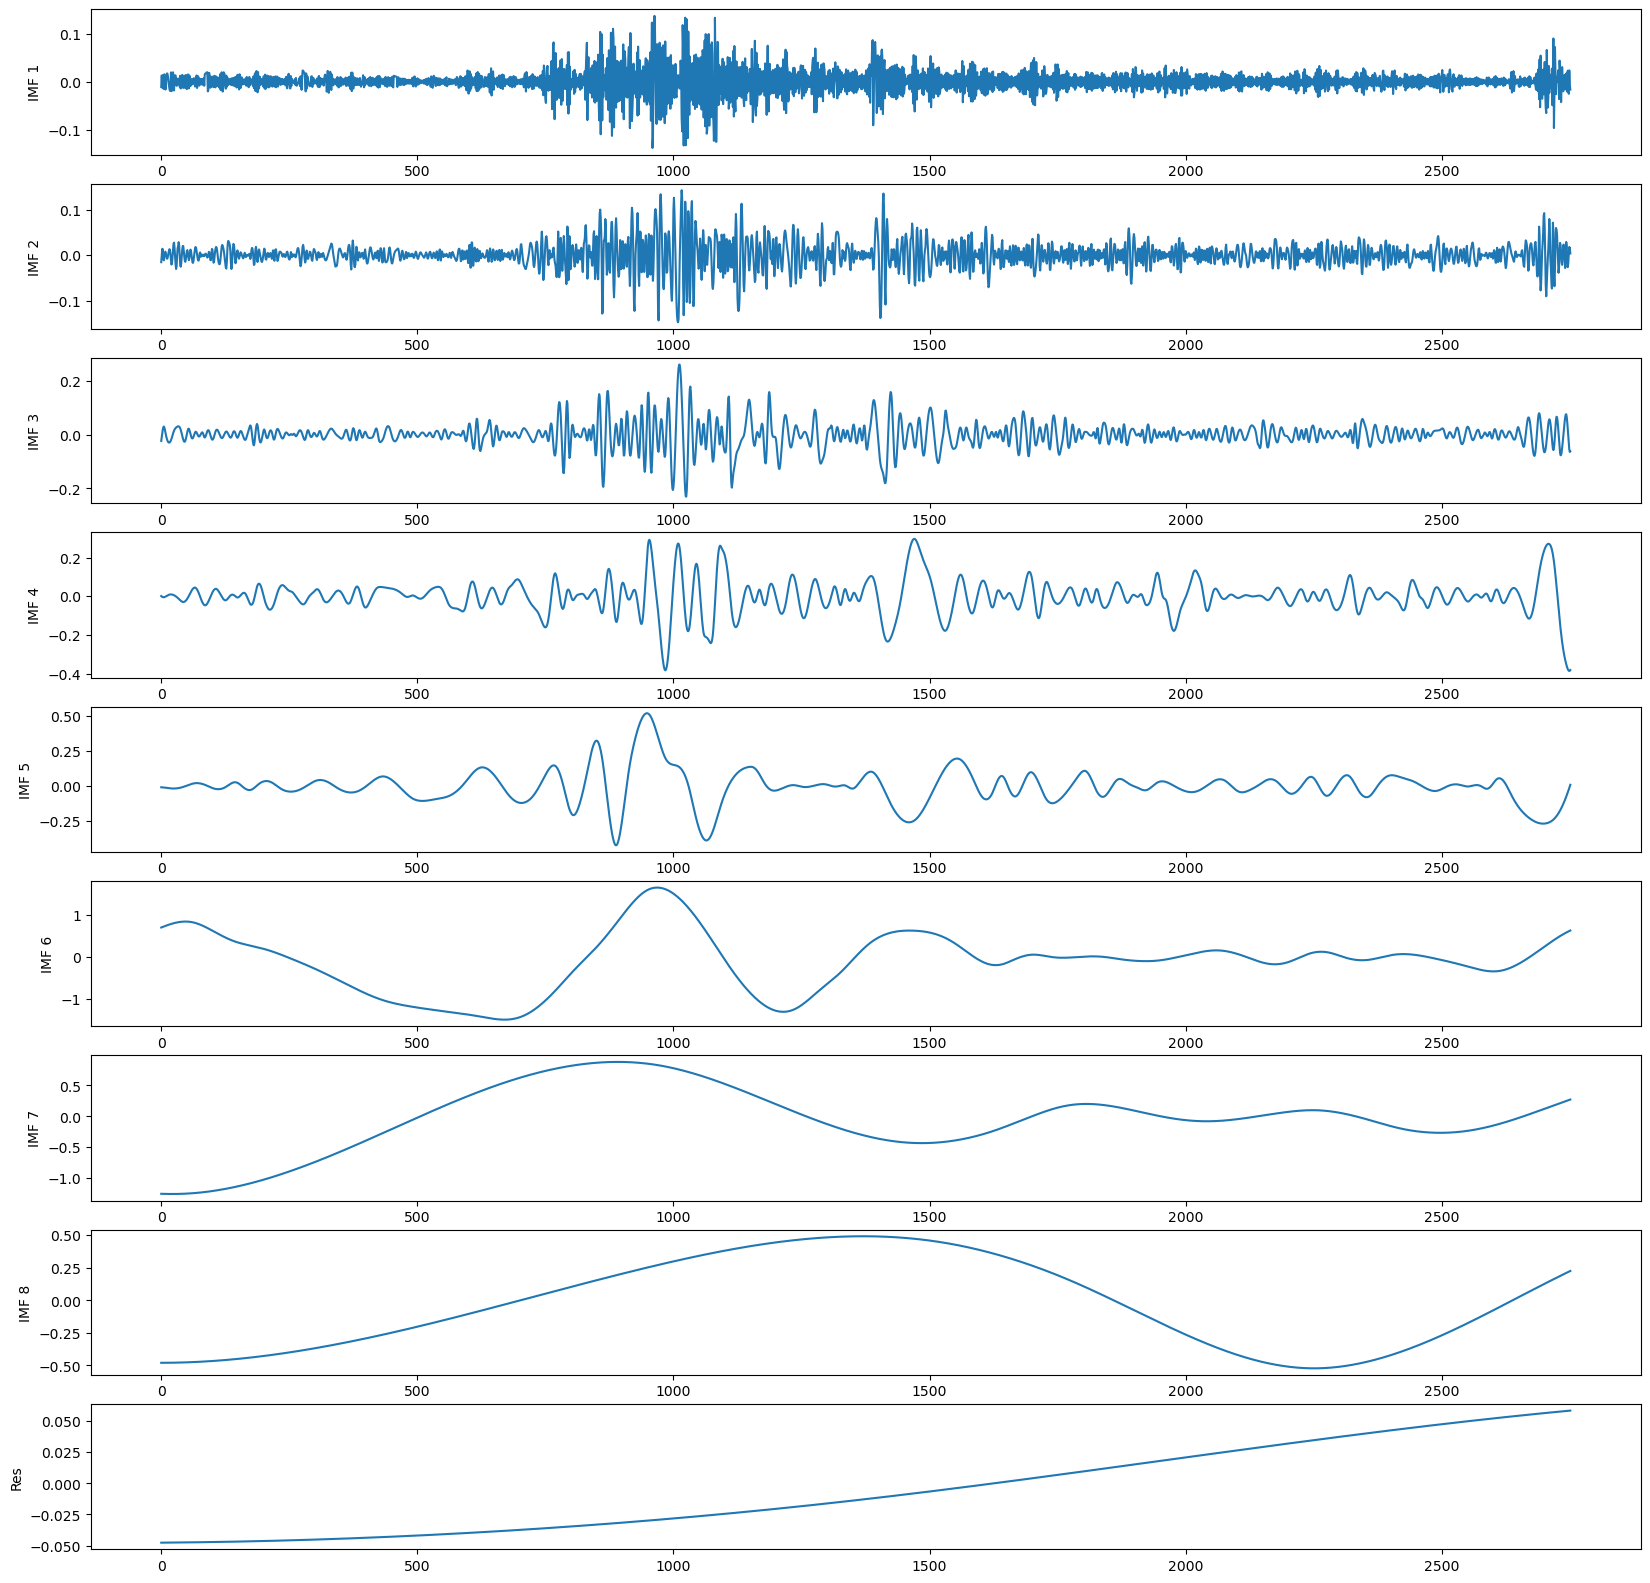

In [ ]:
plt.figure(figsize=(20,20))

for i,imf in enumerate(imfs_train):

  plt.subplot(9,1,i+1)
  plt.plot(imf)
  if i==8:
    text="Res"
  else:
    text=f"IMF {i+1}"
  plt.ylabel(text)
plt.show()

In [ ]:
def convertToDataset(data, step=20):
    X, Y =[], []
    for i in range(len(data)-step):
        d=i+step
        X.append(data[i:d,])
        Y.append(data[d,])
    return np.array(X), np.array(Y)

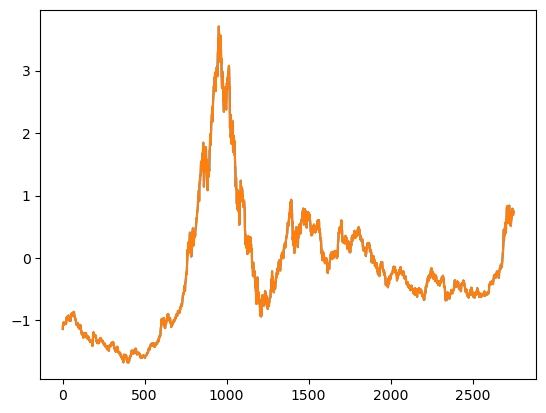

In [ ]:
plt.plot(imfs_train.sum(axis=0))
plt.plot(scale_sig[:n_train])

In [ ]:
class CSVDataset(Dataset):
    def __init__(self, data, num_sqn=20):
        self.data = data
        self.num_sqn = num_sqn
        self.x , self.y = convertToDataset(self.data , self.num_sqn)
        self.x = torch.tensor(self.x, dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.float32)

    def __getitem__(self, idx):
        x, y = self.x[idx], self.y[idx]
        return x, y

    def __len__(self):
        return len(self.x)

In [ ]:
train_ds = CSVDataset(imfs_train[0])
test_ds = CSVDataset(imfs_test[0])

In [ ]:
test_ds[0][1]

tensor(-0.0007)

In [ ]:
BATCH_SIZE = 16
NW = 4

In [ ]:
train_dl = DataLoader(train_ds, shuffle=True, batch_size=BATCH_SIZE, pin_memory=True)
test_dl = DataLoader(test_ds, shuffle=False, batch_size=BATCH_SIZE, pin_memory=True)
dataloaders = {
    "train": train_dl,
    "test": test_dl
}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
a, b = next(iter(test_dl))

In [ ]:
a.shape

torch.Size([16, 20])

In [ ]:
class MlpModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Sequential(
            self.get_linear(20, 8),
            nn.Linear(8, 1),
        )

    def forward(self, x):
        return self.layer(x).reshape(-1)

    def get_linear(self, indim , outdim):
        return nn.Sequential(
            nn.Linear(indim, outdim),
            nn.ReLU(),
        )


In [ ]:
class LSTMLayer(nn.Module):
    def __init__(self, in_size, hi_size):
        super().__init__()
        self.lstm = nn.LSTMCell(in_size, hi_size, device=device)
        self.hi_size = hi_size


    def forward(self, x):
        output = []
        x = x.unsqueeze(-1)
        hx = torch.zeros(x.shape[0], self.hi_size).to(device)
        cx = torch.zeros(x.shape[0], self.hi_size).to(device)
        for i in range(x.shape[1]):
            hx, cx = self.lstm(x[:, i, :], (hx, cx))
            output.append(hx)
        return torch.stack(output, dim=1)


In [ ]:
class LSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(64, 1),
        )
        self.lstm = LSTMLayer(1, 64)

    def forward(self, x):
        h = self.lstm(x)
        return self.mlp(h[:, -1, :]).reshape(-1)

    def get_linear(self, indim , outdim):
        return nn.Sequential(
            nn.Linear(indim, outdim),
            nn.ReLU(),
        )



In [ ]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, x):
        scores = self.Va(x)
        scores = scores.squeeze(2).unsqueeze(1)

        weights = f.softmax(scores, dim=-1)
        context = torch.bmm(weights, x).squeeze(1)
        return context, weights

In [ ]:
class AttnLSTM(nn.Module):
    def __init__(self, ):
        super().__init__()
        self.attention = Attention(64)
        self.lstm = LSTMLayer(1, 64)
        self.mlp = nn.Sequential(
            nn.Linear(64, 1),
        )
        self.attn_weights = None

    def get_linear(self, indim , outdim):
        return nn.Sequential(
            nn.Linear(indim, outdim),
            nn.ReLU(),
        )

    def forward(self, x):
        h = self.lstm(x)
        y, w = self.attention(h)
        self.attn_weights = w

        return self.mlp(y).reshape(-1)



In [ ]:
# # lstm = AttnLSTM()
# lstm = AttnLSTM()
# lstm = lstm.to(device)
# criterion = nn.L1Loss()
# a, b = next(iter(train_dl))
# output = lstm(a.to(device))
# # print(a.shape, b.shape)
# # c = lstm(a)
# # print(c.shape)
# # print(criterion(output, b.to(device)))

In [ ]:
# output.shape

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
class Trainer:
    def __init__(self, dataloaders, model, criterion, optimizer, scheduler, model_name="model", num_epochs=25):
        self.model = model.to(device)
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.num_epochs = num_epochs
        self.model_name = model_name
        self.dataloaders = dataloaders
        self.scaler = amp.GradScaler()

        self.metric_train = tm.regression.MeanAbsoluteError().to(device)
        self.loss_train = AverageMeter()
        self.train_hist = []

        self.metric_valid = tm.regression.MeanAbsoluteError().to(device)
        self.loss_valid = AverageMeter()
        self.valid_hist = []

        self.best_acc = torch.inf

    def one_step(self, inputs, targets):
        training = self.model.training
        with amp.autocast(enabled=training):
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = self.model(inputs)
            loss = self.criterion(input=outputs, target=targets)
        if training:
            self.scaler.scale(loss).backward()
            self.scaler.step(self.optimizer)
            self.scaler.update()
            self.optimizer.zero_grad()
            self.metric_train.update(outputs, targets)
            self.loss_train.update(loss)

        else:
            self.metric_valid.update(outputs, targets)
            self.loss_valid.update(loss)
        return loss

    def train_one_epoch(self, epoch):
        self.model.train()
        self.loss_train.reset()
        self.metric_train.reset()
        with tqdm.tqdm(self.dataloaders["train"], unit='batch') as tepoch:
            for inputs, targets in tepoch:
                self.one_step(inputs, targets)
                tepoch.set_postfix(loss=self.loss_train.avg.item(), metric=self.metric_train.compute().item(), phase="Training")
            if self.scheduler is not None:
                self.scheduler.step()
        return self.loss_train.avg, self.metric_train.compute().item()

    def valid_one_epoch(self, epoch):
        self.model.eval()
        self.loss_valid.reset()
        self.metric_valid.reset()
        with tqdm.tqdm(self.dataloaders["test"], unit='batch') as tepoch:
            with torch.inference_mode():
                for inputs, targets in tepoch:
                    self.one_step(inputs, targets)
                    tepoch.set_postfix(loss=self.loss_valid.avg.item(), metric=self.metric_valid.compute().item(),
                                       phase="Validation")

        return self.loss_valid.avg.item(), self.metric_valid.compute().item()

    def train(self):
        for epoch in range(self.num_epochs):
            set_seed(epoch)
            t_loss, t_acc = self.train_one_epoch(epoch)
            v_loss, v_acc = self.valid_one_epoch(epoch)
            self.train_hist.append(t_acc)
            self.valid_hist.append(v_acc)
            print(f"Epoch: {epoch}, Train Loss: {t_loss:.4}, Train Acc: {t_acc:.4}, Valid Loss: {v_loss:.4}, Valid Acc: {v_acc:.4}")


            if v_acc < self.best_acc:
                state = {
                    "model": self.model.state_dict(),
                    "optimizer": self.optimizer.state_dict(),
                    "epoch": epoch,
                    "acc": self.best_acc,
                    "scaler": scaler.state_dict()
                }
                torch.save(state, f'{self.model_name}.pth')
                self.best_acc = v_acc
                self.best_model = copy.deepcopy(self.model)
                print('Model Saved!')
            print()

    def valid(self):
        v_loss, v_acc = self.valid_one_epoch(0)
        print(f"Validation: : Valid Loss: {v_loss:.4}, Valid Acc: {v_acc:.4}")

    def overfit(self):
        self.model.train()
        inputs, targets = next(iter(self.dataloaders["train"]))
        for epoch in range(100):
            loss = self.one_step(inputs, targets)
            print(f"Epoch: {epoch}, Loss: {loss}")

    def test(self, tensor):
      tensor = tensor.to(device)
      self.best_model.eval()
      # if hasattr(self.best_model, "lstm"):
      #     self.best_model.flatten_parameters()
      with torch.inference_mode():
        out = self.best_model(tensor)
      return out

In [ ]:
lstm_models = []
lstm_accs = []
for i in range(9):
    print("#"*10 , f" Model {i} ", "#"*10)
    train_ds = CSVDataset(imfs_train[i])
    test_ds = CSVDataset(imfs_test[i])

    train_dl = DataLoader(train_ds, shuffle=True, batch_size=BATCH_SIZE, pin_memory=True, num_workers=NW)
    test_dl = DataLoader(test_ds, shuffle=False, batch_size=BATCH_SIZE, pin_memory=True, num_workers=NW)
    dataloaders = {
        "train": train_dl,
        "test": test_dl
    }

    criterion = nn.L1Loss()
    lstm_model = LSTMModel()
    optimizer = optim.SGD(params=lstm_model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200, eta_min=1e-5)
    scaler = amp.GradScaler()
    trainer_lstm = Trainer(dataloaders, lstm_model, criterion, optimizer, scheduler=scheduler, num_epochs=200, model_name=f"lstm_{i}")
    trainer_lstm.train()
    lstm_models.append(trainer_lstm.best_model)
    lstm_accs.append(trainer_lstm.best_acc)
    print("#"*10 , f" Model {i} Acc {trainer_lstm.best_acc} ", "#"*10)

##########  Model 0  ##########


  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 0, Train Loss: 0.01961, Train Acc: 0.0196, Valid Loss: 0.02429, Valid Acc: 0.02433
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 1, Train Loss: 0.01912, Train Acc: 0.01912, Valid Loss: 0.02193, Valid Acc: 0.02198
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 2, Train Loss: 0.02062, Train Acc: 0.02061, Valid Loss: 0.022, Valid Acc: 0.02205



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 3, Train Loss: 0.02068, Train Acc: 0.02068, Valid Loss: 0.02612, Valid Acc: 0.02618



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 4, Train Loss: 0.01926, Train Acc: 0.01926, Valid Loss: 0.02843, Valid Acc: 0.02846



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 5, Train Loss: 0.01853, Train Acc: 0.01853, Valid Loss: 0.02268, Valid Acc: 0.02272



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 6, Train Loss: 0.01932, Train Acc: 0.0193, Valid Loss: 0.02215, Valid Acc: 0.02221



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 7, Train Loss: 0.02018, Train Acc: 0.02018, Valid Loss: 0.02548, Valid Acc: 0.02552



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 8, Train Loss: 0.02055, Train Acc: 0.02054, Valid Loss: 0.02971, Valid Acc: 0.02976



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 9, Train Loss: 0.02027, Train Acc: 0.02028, Valid Loss: 0.0222, Valid Acc: 0.02225



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 10, Train Loss: 0.01873, Train Acc: 0.01874, Valid Loss: 0.02537, Valid Acc: 0.02543



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 11, Train Loss: 0.01936, Train Acc: 0.01936, Valid Loss: 0.02262, Valid Acc: 0.02267



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 12, Train Loss: 0.01927, Train Acc: 0.01928, Valid Loss: 0.02208, Valid Acc: 0.02213



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 13, Train Loss: 0.01857, Train Acc: 0.01858, Valid Loss: 0.02179, Valid Acc: 0.02184
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 14, Train Loss: 0.01891, Train Acc: 0.01892, Valid Loss: 0.02222, Valid Acc: 0.02228



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 15, Train Loss: 0.01876, Train Acc: 0.01878, Valid Loss: 0.02202, Valid Acc: 0.02208



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 16, Train Loss: 0.01926, Train Acc: 0.01926, Valid Loss: 0.02454, Valid Acc: 0.0246



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 17, Train Loss: 0.01941, Train Acc: 0.0194, Valid Loss: 0.02306, Valid Acc: 0.0231



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 18, Train Loss: 0.01846, Train Acc: 0.01845, Valid Loss: 0.02319, Valid Acc: 0.02323



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 19, Train Loss: 0.01867, Train Acc: 0.01867, Valid Loss: 0.02294, Valid Acc: 0.023



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 20, Train Loss: 0.01878, Train Acc: 0.01879, Valid Loss: 0.02175, Valid Acc: 0.0218
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 21, Train Loss: 0.01837, Train Acc: 0.01838, Valid Loss: 0.02288, Valid Acc: 0.02293



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 22, Train Loss: 0.01887, Train Acc: 0.01887, Valid Loss: 0.02459, Valid Acc: 0.02464



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 23, Train Loss: 0.01894, Train Acc: 0.01893, Valid Loss: 0.02372, Valid Acc: 0.02377



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 24, Train Loss: 0.01841, Train Acc: 0.01841, Valid Loss: 0.02167, Valid Acc: 0.02172
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 25, Train Loss: 0.01879, Train Acc: 0.0188, Valid Loss: 0.02171, Valid Acc: 0.02176



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 26, Train Loss: 0.01877, Train Acc: 0.01877, Valid Loss: 0.02322, Valid Acc: 0.02326



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 27, Train Loss: 0.01893, Train Acc: 0.01892, Valid Loss: 0.02165, Valid Acc: 0.0217
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 28, Train Loss: 0.01896, Train Acc: 0.01894, Valid Loss: 0.02318, Valid Acc: 0.02323



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 29, Train Loss: 0.0184, Train Acc: 0.01841, Valid Loss: 0.02202, Valid Acc: 0.02207



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 30, Train Loss: 0.01903, Train Acc: 0.01903, Valid Loss: 0.02177, Valid Acc: 0.02183



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 31, Train Loss: 0.01888, Train Acc: 0.01889, Valid Loss: 0.02276, Valid Acc: 0.0228



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 32, Train Loss: 0.02005, Train Acc: 0.02006, Valid Loss: 0.02164, Valid Acc: 0.02169
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 33, Train Loss: 0.01829, Train Acc: 0.0183, Valid Loss: 0.02165, Valid Acc: 0.0217



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 34, Train Loss: 0.01875, Train Acc: 0.01875, Valid Loss: 0.0292, Valid Acc: 0.02926



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 35, Train Loss: 0.01947, Train Acc: 0.01946, Valid Loss: 0.02167, Valid Acc: 0.02172



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 36, Train Loss: 0.01893, Train Acc: 0.01893, Valid Loss: 0.02164, Valid Acc: 0.02169



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 37, Train Loss: 0.01913, Train Acc: 0.01912, Valid Loss: 0.02401, Valid Acc: 0.02407



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 38, Train Loss: 0.01838, Train Acc: 0.01837, Valid Loss: 0.02333, Valid Acc: 0.02338



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 39, Train Loss: 0.0185, Train Acc: 0.01851, Valid Loss: 0.02209, Valid Acc: 0.02213



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 40, Train Loss: 0.01894, Train Acc: 0.01895, Valid Loss: 0.02527, Valid Acc: 0.02533



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 41, Train Loss: 0.01857, Train Acc: 0.01853, Valid Loss: 0.02162, Valid Acc: 0.02168
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 42, Train Loss: 0.01872, Train Acc: 0.01871, Valid Loss: 0.02867, Valid Acc: 0.0287



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 43, Train Loss: 0.01858, Train Acc: 0.01858, Valid Loss: 0.02626, Valid Acc: 0.0263



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 44, Train Loss: 0.01868, Train Acc: 0.01867, Valid Loss: 0.02241, Valid Acc: 0.02246



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 45, Train Loss: 0.01925, Train Acc: 0.01924, Valid Loss: 0.02443, Valid Acc: 0.02449



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 46, Train Loss: 0.02004, Train Acc: 0.02005, Valid Loss: 0.0251, Valid Acc: 0.02516



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 47, Train Loss: 0.01818, Train Acc: 0.01818, Valid Loss: 0.02155, Valid Acc: 0.0216
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 48, Train Loss: 0.01835, Train Acc: 0.01836, Valid Loss: 0.02156, Valid Acc: 0.02161



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 49, Train Loss: 0.01916, Train Acc: 0.01914, Valid Loss: 0.0216, Valid Acc: 0.02164



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 50, Train Loss: 0.01782, Train Acc: 0.01782, Valid Loss: 0.02155, Valid Acc: 0.0216



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 51, Train Loss: 0.01873, Train Acc: 0.01872, Valid Loss: 0.02719, Valid Acc: 0.02723



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 52, Train Loss: 0.01904, Train Acc: 0.01905, Valid Loss: 0.02184, Valid Acc: 0.02188



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 53, Train Loss: 0.01826, Train Acc: 0.01826, Valid Loss: 0.02204, Valid Acc: 0.0221



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 54, Train Loss: 0.01843, Train Acc: 0.01842, Valid Loss: 0.02245, Valid Acc: 0.0225



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 55, Train Loss: 0.01788, Train Acc: 0.01786, Valid Loss: 0.02312, Valid Acc: 0.02317



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 56, Train Loss: 0.01881, Train Acc: 0.01881, Valid Loss: 0.02221, Valid Acc: 0.02225



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 57, Train Loss: 0.01991, Train Acc: 0.01991, Valid Loss: 0.02213, Valid Acc: 0.02219



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 58, Train Loss: 0.01856, Train Acc: 0.01855, Valid Loss: 0.02154, Valid Acc: 0.02159
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 59, Train Loss: 0.01924, Train Acc: 0.01922, Valid Loss: 0.02668, Valid Acc: 0.02673



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 60, Train Loss: 0.01868, Train Acc: 0.01867, Valid Loss: 0.03197, Valid Acc: 0.032



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 61, Train Loss: 0.01874, Train Acc: 0.01872, Valid Loss: 0.02153, Valid Acc: 0.02158
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 62, Train Loss: 0.01882, Train Acc: 0.01881, Valid Loss: 0.02172, Valid Acc: 0.02177



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 63, Train Loss: 0.01855, Train Acc: 0.01855, Valid Loss: 0.02217, Valid Acc: 0.02223



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 64, Train Loss: 0.01834, Train Acc: 0.01835, Valid Loss: 0.02265, Valid Acc: 0.02269



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 65, Train Loss: 0.01828, Train Acc: 0.01826, Valid Loss: 0.02215, Valid Acc: 0.02219



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 66, Train Loss: 0.01815, Train Acc: 0.01814, Valid Loss: 0.02149, Valid Acc: 0.02154
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 67, Train Loss: 0.01827, Train Acc: 0.01828, Valid Loss: 0.02145, Valid Acc: 0.0215
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 68, Train Loss: 0.01994, Train Acc: 0.01994, Valid Loss: 0.02908, Valid Acc: 0.02911



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 69, Train Loss: 0.01837, Train Acc: 0.01837, Valid Loss: 0.02349, Valid Acc: 0.02353



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 70, Train Loss: 0.01816, Train Acc: 0.01816, Valid Loss: 0.0225, Valid Acc: 0.02256



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 71, Train Loss: 0.01797, Train Acc: 0.01797, Valid Loss: 0.02352, Valid Acc: 0.02358



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 72, Train Loss: 0.01773, Train Acc: 0.01774, Valid Loss: 0.02194, Valid Acc: 0.02198



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 73, Train Loss: 0.01789, Train Acc: 0.0179, Valid Loss: 0.02173, Valid Acc: 0.02178



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 74, Train Loss: 0.01891, Train Acc: 0.01891, Valid Loss: 0.02215, Valid Acc: 0.02221



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 75, Train Loss: 0.01859, Train Acc: 0.01859, Valid Loss: 0.02147, Valid Acc: 0.02152



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 76, Train Loss: 0.01771, Train Acc: 0.01771, Valid Loss: 0.02224, Valid Acc: 0.02228



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 77, Train Loss: 0.01813, Train Acc: 0.01813, Valid Loss: 0.02139, Valid Acc: 0.02144
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 78, Train Loss: 0.01769, Train Acc: 0.01768, Valid Loss: 0.02349, Valid Acc: 0.02353



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 79, Train Loss: 0.01812, Train Acc: 0.01812, Valid Loss: 0.02137, Valid Acc: 0.02142
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 80, Train Loss: 0.01787, Train Acc: 0.01787, Valid Loss: 0.02273, Valid Acc: 0.02278



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 81, Train Loss: 0.01747, Train Acc: 0.01746, Valid Loss: 0.02419, Valid Acc: 0.02425



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 82, Train Loss: 0.01818, Train Acc: 0.01817, Valid Loss: 0.02136, Valid Acc: 0.02141
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 83, Train Loss: 0.01726, Train Acc: 0.01727, Valid Loss: 0.02132, Valid Acc: 0.02138
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 84, Train Loss: 0.01751, Train Acc: 0.01751, Valid Loss: 0.02131, Valid Acc: 0.02136
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 85, Train Loss: 0.01753, Train Acc: 0.01752, Valid Loss: 0.02251, Valid Acc: 0.02256



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 86, Train Loss: 0.01761, Train Acc: 0.01761, Valid Loss: 0.02155, Valid Acc: 0.02161



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 87, Train Loss: 0.01733, Train Acc: 0.01731, Valid Loss: 0.02188, Valid Acc: 0.02192



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 88, Train Loss: 0.01743, Train Acc: 0.01744, Valid Loss: 0.02156, Valid Acc: 0.02161



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 89, Train Loss: 0.01742, Train Acc: 0.01743, Valid Loss: 0.02142, Valid Acc: 0.02147



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 90, Train Loss: 0.01738, Train Acc: 0.01738, Valid Loss: 0.02146, Valid Acc: 0.02151



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 91, Train Loss: 0.01743, Train Acc: 0.01743, Valid Loss: 0.02126, Valid Acc: 0.02131
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 92, Train Loss: 0.01762, Train Acc: 0.01761, Valid Loss: 0.02203, Valid Acc: 0.02208



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 93, Train Loss: 0.01779, Train Acc: 0.01778, Valid Loss: 0.02124, Valid Acc: 0.02129
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 94, Train Loss: 0.01738, Train Acc: 0.01739, Valid Loss: 0.02134, Valid Acc: 0.0214



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 95, Train Loss: 0.01767, Train Acc: 0.01767, Valid Loss: 0.02228, Valid Acc: 0.02232



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 96, Train Loss: 0.0172, Train Acc: 0.01719, Valid Loss: 0.02169, Valid Acc: 0.02174



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 97, Train Loss: 0.01728, Train Acc: 0.01729, Valid Loss: 0.02201, Valid Acc: 0.02207



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 98, Train Loss: 0.01716, Train Acc: 0.01717, Valid Loss: 0.02122, Valid Acc: 0.02127
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 99, Train Loss: 0.01752, Train Acc: 0.01752, Valid Loss: 0.0213, Valid Acc: 0.02135



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 100, Train Loss: 0.01721, Train Acc: 0.01721, Valid Loss: 0.02127, Valid Acc: 0.02132



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 101, Train Loss: 0.01773, Train Acc: 0.01773, Valid Loss: 0.0234, Valid Acc: 0.02344



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 102, Train Loss: 0.01754, Train Acc: 0.01753, Valid Loss: 0.02141, Valid Acc: 0.02145



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 103, Train Loss: 0.01835, Train Acc: 0.01833, Valid Loss: 0.0214, Valid Acc: 0.02146



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 104, Train Loss: 0.01737, Train Acc: 0.01738, Valid Loss: 0.02285, Valid Acc: 0.02291



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 105, Train Loss: 0.01751, Train Acc: 0.01751, Valid Loss: 0.02163, Valid Acc: 0.02169



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 106, Train Loss: 0.01726, Train Acc: 0.01726, Valid Loss: 0.02118, Valid Acc: 0.02123
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 107, Train Loss: 0.01748, Train Acc: 0.01748, Valid Loss: 0.02281, Valid Acc: 0.02287



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 108, Train Loss: 0.01762, Train Acc: 0.01761, Valid Loss: 0.02117, Valid Acc: 0.02122
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 109, Train Loss: 0.01749, Train Acc: 0.01749, Valid Loss: 0.02337, Valid Acc: 0.02343



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 110, Train Loss: 0.01802, Train Acc: 0.01803, Valid Loss: 0.02156, Valid Acc: 0.0216



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 111, Train Loss: 0.01735, Train Acc: 0.01736, Valid Loss: 0.02144, Valid Acc: 0.0215



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 112, Train Loss: 0.01712, Train Acc: 0.01712, Valid Loss: 0.02153, Valid Acc: 0.02158



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 113, Train Loss: 0.017, Train Acc: 0.017, Valid Loss: 0.02131, Valid Acc: 0.02137



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 114, Train Loss: 0.01692, Train Acc: 0.01693, Valid Loss: 0.02121, Valid Acc: 0.02126



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 115, Train Loss: 0.01706, Train Acc: 0.01706, Valid Loss: 0.02113, Valid Acc: 0.02118
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 116, Train Loss: 0.01709, Train Acc: 0.01708, Valid Loss: 0.02133, Valid Acc: 0.02138



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 117, Train Loss: 0.01687, Train Acc: 0.01686, Valid Loss: 0.02245, Valid Acc: 0.0225



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 118, Train Loss: 0.01702, Train Acc: 0.01701, Valid Loss: 0.02419, Valid Acc: 0.02425



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 119, Train Loss: 0.0174, Train Acc: 0.0174, Valid Loss: 0.02129, Valid Acc: 0.02133



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 120, Train Loss: 0.01742, Train Acc: 0.01744, Valid Loss: 0.02112, Valid Acc: 0.02118
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 121, Train Loss: 0.01707, Train Acc: 0.01707, Valid Loss: 0.02135, Valid Acc: 0.0214



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 122, Train Loss: 0.01704, Train Acc: 0.01705, Valid Loss: 0.02372, Valid Acc: 0.02376



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 123, Train Loss: 0.01685, Train Acc: 0.01686, Valid Loss: 0.02133, Valid Acc: 0.02137



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 124, Train Loss: 0.01689, Train Acc: 0.01689, Valid Loss: 0.02117, Valid Acc: 0.02122



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 125, Train Loss: 0.01702, Train Acc: 0.01703, Valid Loss: 0.02157, Valid Acc: 0.02162



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 126, Train Loss: 0.01711, Train Acc: 0.01711, Valid Loss: 0.02159, Valid Acc: 0.02164



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 127, Train Loss: 0.01709, Train Acc: 0.01708, Valid Loss: 0.02107, Valid Acc: 0.02112
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 128, Train Loss: 0.01722, Train Acc: 0.01723, Valid Loss: 0.02109, Valid Acc: 0.02115



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 129, Train Loss: 0.01686, Train Acc: 0.01686, Valid Loss: 0.02133, Valid Acc: 0.02137



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 130, Train Loss: 0.01677, Train Acc: 0.01677, Valid Loss: 0.02104, Valid Acc: 0.0211
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 131, Train Loss: 0.01686, Train Acc: 0.01687, Valid Loss: 0.02105, Valid Acc: 0.0211



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 132, Train Loss: 0.01685, Train Acc: 0.01684, Valid Loss: 0.02116, Valid Acc: 0.0212



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 133, Train Loss: 0.01675, Train Acc: 0.01675, Valid Loss: 0.02317, Valid Acc: 0.02322



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 134, Train Loss: 0.01697, Train Acc: 0.01695, Valid Loss: 0.02122, Valid Acc: 0.02127



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 135, Train Loss: 0.01683, Train Acc: 0.01682, Valid Loss: 0.02141, Valid Acc: 0.02147



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 136, Train Loss: 0.01666, Train Acc: 0.01665, Valid Loss: 0.0214, Valid Acc: 0.02144



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 137, Train Loss: 0.01682, Train Acc: 0.01682, Valid Loss: 0.02123, Valid Acc: 0.02128



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 138, Train Loss: 0.01695, Train Acc: 0.01696, Valid Loss: 0.02183, Valid Acc: 0.02188



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 139, Train Loss: 0.01668, Train Acc: 0.01668, Valid Loss: 0.0211, Valid Acc: 0.02115



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 140, Train Loss: 0.01676, Train Acc: 0.01676, Valid Loss: 0.021, Valid Acc: 0.02106
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 141, Train Loss: 0.0167, Train Acc: 0.0167, Valid Loss: 0.02103, Valid Acc: 0.02109



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 142, Train Loss: 0.01659, Train Acc: 0.01659, Valid Loss: 0.02107, Valid Acc: 0.02113



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 143, Train Loss: 0.01678, Train Acc: 0.01677, Valid Loss: 0.02139, Valid Acc: 0.02144



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 144, Train Loss: 0.01685, Train Acc: 0.01687, Valid Loss: 0.02112, Valid Acc: 0.02117



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 145, Train Loss: 0.01672, Train Acc: 0.01673, Valid Loss: 0.02101, Valid Acc: 0.02107



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 146, Train Loss: 0.0166, Train Acc: 0.0166, Valid Loss: 0.02101, Valid Acc: 0.02107



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 147, Train Loss: 0.01645, Train Acc: 0.01645, Valid Loss: 0.02139, Valid Acc: 0.02143



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 148, Train Loss: 0.01667, Train Acc: 0.01665, Valid Loss: 0.02114, Valid Acc: 0.02119



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 149, Train Loss: 0.01661, Train Acc: 0.01661, Valid Loss: 0.02137, Valid Acc: 0.02142



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 150, Train Loss: 0.01645, Train Acc: 0.01646, Valid Loss: 0.02099, Valid Acc: 0.02104
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 151, Train Loss: 0.01652, Train Acc: 0.01651, Valid Loss: 0.02107, Valid Acc: 0.02112



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 152, Train Loss: 0.01655, Train Acc: 0.01656, Valid Loss: 0.02103, Valid Acc: 0.02109



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 153, Train Loss: 0.01649, Train Acc: 0.01649, Valid Loss: 0.02112, Valid Acc: 0.02117



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 154, Train Loss: 0.01647, Train Acc: 0.01646, Valid Loss: 0.02176, Valid Acc: 0.02181



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 155, Train Loss: 0.01645, Train Acc: 0.01644, Valid Loss: 0.02097, Valid Acc: 0.02102
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 156, Train Loss: 0.01651, Train Acc: 0.0165, Valid Loss: 0.02117, Valid Acc: 0.02122



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 157, Train Loss: 0.01649, Train Acc: 0.0165, Valid Loss: 0.02107, Valid Acc: 0.02112



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 158, Train Loss: 0.01646, Train Acc: 0.01646, Valid Loss: 0.02171, Valid Acc: 0.02176



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 159, Train Loss: 0.01635, Train Acc: 0.01634, Valid Loss: 0.02098, Valid Acc: 0.02103



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 160, Train Loss: 0.0165, Train Acc: 0.0165, Valid Loss: 0.02098, Valid Acc: 0.02103



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 161, Train Loss: 0.01634, Train Acc: 0.01635, Valid Loss: 0.02095, Valid Acc: 0.021
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 162, Train Loss: 0.01638, Train Acc: 0.01638, Valid Loss: 0.02114, Valid Acc: 0.02119



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 163, Train Loss: 0.01641, Train Acc: 0.01641, Valid Loss: 0.02111, Valid Acc: 0.02116



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 164, Train Loss: 0.01636, Train Acc: 0.01636, Valid Loss: 0.02097, Valid Acc: 0.02102



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 165, Train Loss: 0.01638, Train Acc: 0.01637, Valid Loss: 0.0213, Valid Acc: 0.02134



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 166, Train Loss: 0.01634, Train Acc: 0.01634, Valid Loss: 0.02099, Valid Acc: 0.02104



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 167, Train Loss: 0.01633, Train Acc: 0.01633, Valid Loss: 0.021, Valid Acc: 0.02105



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 168, Train Loss: 0.01645, Train Acc: 0.01643, Valid Loss: 0.02159, Valid Acc: 0.02165



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 169, Train Loss: 0.01636, Train Acc: 0.01636, Valid Loss: 0.02111, Valid Acc: 0.02116



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 170, Train Loss: 0.01631, Train Acc: 0.01631, Valid Loss: 0.02095, Valid Acc: 0.021



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 171, Train Loss: 0.01633, Train Acc: 0.01633, Valid Loss: 0.02094, Valid Acc: 0.02099
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 172, Train Loss: 0.01635, Train Acc: 0.01633, Valid Loss: 0.02103, Valid Acc: 0.02108



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 173, Train Loss: 0.01629, Train Acc: 0.01627, Valid Loss: 0.02096, Valid Acc: 0.02101



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 174, Train Loss: 0.01627, Train Acc: 0.01628, Valid Loss: 0.02097, Valid Acc: 0.02102



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 175, Train Loss: 0.01626, Train Acc: 0.01626, Valid Loss: 0.02114, Valid Acc: 0.02119



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 176, Train Loss: 0.01629, Train Acc: 0.01628, Valid Loss: 0.02094, Valid Acc: 0.02099



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 177, Train Loss: 0.01632, Train Acc: 0.01632, Valid Loss: 0.02093, Valid Acc: 0.02098
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 178, Train Loss: 0.01626, Train Acc: 0.01626, Valid Loss: 0.02096, Valid Acc: 0.02101



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 179, Train Loss: 0.0162, Train Acc: 0.01621, Valid Loss: 0.02129, Valid Acc: 0.02134



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 180, Train Loss: 0.01628, Train Acc: 0.01628, Valid Loss: 0.02093, Valid Acc: 0.02098
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 181, Train Loss: 0.01627, Train Acc: 0.01628, Valid Loss: 0.02103, Valid Acc: 0.02109



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 182, Train Loss: 0.0162, Train Acc: 0.0162, Valid Loss: 0.02111, Valid Acc: 0.02116



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 183, Train Loss: 0.01625, Train Acc: 0.01624, Valid Loss: 0.02093, Valid Acc: 0.02098
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 184, Train Loss: 0.01624, Train Acc: 0.01622, Valid Loss: 0.02099, Valid Acc: 0.02104



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 185, Train Loss: 0.01623, Train Acc: 0.01624, Valid Loss: 0.02095, Valid Acc: 0.021



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 186, Train Loss: 0.01622, Train Acc: 0.01623, Valid Loss: 0.02095, Valid Acc: 0.02101



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 187, Train Loss: 0.01622, Train Acc: 0.01623, Valid Loss: 0.02093, Valid Acc: 0.02098



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 188, Train Loss: 0.01623, Train Acc: 0.01623, Valid Loss: 0.02095, Valid Acc: 0.021



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 189, Train Loss: 0.01621, Train Acc: 0.01619, Valid Loss: 0.02103, Valid Acc: 0.02108



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 190, Train Loss: 0.01625, Train Acc: 0.01625, Valid Loss: 0.02093, Valid Acc: 0.02098
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 191, Train Loss: 0.01622, Train Acc: 0.01622, Valid Loss: 0.02092, Valid Acc: 0.02098
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 192, Train Loss: 0.01623, Train Acc: 0.01622, Valid Loss: 0.02093, Valid Acc: 0.02098



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 193, Train Loss: 0.01621, Train Acc: 0.01622, Valid Loss: 0.02092, Valid Acc: 0.02098
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 194, Train Loss: 0.01622, Train Acc: 0.01621, Valid Loss: 0.02093, Valid Acc: 0.02098



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 195, Train Loss: 0.01621, Train Acc: 0.01621, Valid Loss: 0.02093, Valid Acc: 0.02098



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 196, Train Loss: 0.01619, Train Acc: 0.0162, Valid Loss: 0.02093, Valid Acc: 0.02098



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 197, Train Loss: 0.0162, Train Acc: 0.01621, Valid Loss: 0.02093, Valid Acc: 0.02098



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 198, Train Loss: 0.0162, Train Acc: 0.0162, Valid Loss: 0.02093, Valid Acc: 0.02098



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 199, Train Loss: 0.0162, Train Acc: 0.0162, Valid Loss: 0.02093, Valid Acc: 0.02098

##########  Model 0 Acc 0.020978085696697235  ##########
##########  Model 1  ##########


  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 0, Train Loss: 0.02317, Train Acc: 0.02316, Valid Loss: 0.0231, Valid Acc: 0.02316
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 1, Train Loss: 0.02059, Train Acc: 0.0206, Valid Loss: 0.01963, Valid Acc: 0.01969
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 2, Train Loss: 0.02047, Train Acc: 0.02047, Valid Loss: 0.0196, Valid Acc: 0.01966
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 3, Train Loss: 0.02078, Train Acc: 0.02078, Valid Loss: 0.01957, Valid Acc: 0.01964
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 4, Train Loss: 0.02005, Train Acc: 0.02005, Valid Loss: 0.01911, Valid Acc: 0.01919
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 5, Train Loss: 0.02349, Train Acc: 0.0235, Valid Loss: 0.01898, Valid Acc: 0.01905
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 6, Train Loss: 0.02102, Train Acc: 0.02103, Valid Loss: 0.02084, Valid Acc: 0.0209



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 7, Train Loss: 0.0213, Train Acc: 0.02129, Valid Loss: 0.02566, Valid Acc: 0.02569



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 8, Train Loss: 0.02015, Train Acc: 0.02016, Valid Loss: 0.01947, Valid Acc: 0.01954



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 9, Train Loss: 0.01963, Train Acc: 0.01963, Valid Loss: 0.0201, Valid Acc: 0.02014



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 10, Train Loss: 0.02072, Train Acc: 0.02073, Valid Loss: 0.022, Valid Acc: 0.02206



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 11, Train Loss: 0.02165, Train Acc: 0.02165, Valid Loss: 0.02508, Valid Acc: 0.02513



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 12, Train Loss: 0.02026, Train Acc: 0.02025, Valid Loss: 0.01966, Valid Acc: 0.01972



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 13, Train Loss: 0.02096, Train Acc: 0.02097, Valid Loss: 0.01964, Valid Acc: 0.01971



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 14, Train Loss: 0.02012, Train Acc: 0.02011, Valid Loss: 0.02761, Valid Acc: 0.02765



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 15, Train Loss: 0.02049, Train Acc: 0.02049, Valid Loss: 0.02027, Valid Acc: 0.02033



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 16, Train Loss: 0.01977, Train Acc: 0.01977, Valid Loss: 0.02227, Valid Acc: 0.02232



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 17, Train Loss: 0.02033, Train Acc: 0.02033, Valid Loss: 0.0185, Valid Acc: 0.01856
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 18, Train Loss: 0.0204, Train Acc: 0.02041, Valid Loss: 0.01843, Valid Acc: 0.01849
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 19, Train Loss: 0.01931, Train Acc: 0.0193, Valid Loss: 0.01889, Valid Acc: 0.01896



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 20, Train Loss: 0.01947, Train Acc: 0.01946, Valid Loss: 0.02039, Valid Acc: 0.02045



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 21, Train Loss: 0.01912, Train Acc: 0.01912, Valid Loss: 0.01885, Valid Acc: 0.0189



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 22, Train Loss: 0.01896, Train Acc: 0.01895, Valid Loss: 0.02088, Valid Acc: 0.02092



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 23, Train Loss: 0.02055, Train Acc: 0.02056, Valid Loss: 0.021, Valid Acc: 0.02106



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 24, Train Loss: 0.01988, Train Acc: 0.0199, Valid Loss: 0.018, Valid Acc: 0.01807
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 25, Train Loss: 0.01978, Train Acc: 0.01978, Valid Loss: 0.01983, Valid Acc: 0.01987



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 26, Train Loss: 0.01973, Train Acc: 0.01971, Valid Loss: 0.02867, Valid Acc: 0.02868



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 27, Train Loss: 0.01987, Train Acc: 0.01987, Valid Loss: 0.01904, Valid Acc: 0.01909



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 28, Train Loss: 0.01887, Train Acc: 0.01884, Valid Loss: 0.02707, Valid Acc: 0.02709



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 29, Train Loss: 0.02104, Train Acc: 0.02104, Valid Loss: 0.01934, Valid Acc: 0.01938



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 30, Train Loss: 0.01855, Train Acc: 0.01855, Valid Loss: 0.01779, Valid Acc: 0.01786
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 31, Train Loss: 0.0184, Train Acc: 0.01841, Valid Loss: 0.01886, Valid Acc: 0.0189



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 32, Train Loss: 0.01897, Train Acc: 0.01896, Valid Loss: 0.0181, Valid Acc: 0.01816



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 33, Train Loss: 0.01858, Train Acc: 0.01859, Valid Loss: 0.01748, Valid Acc: 0.01755
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 34, Train Loss: 0.01987, Train Acc: 0.01988, Valid Loss: 0.01745, Valid Acc: 0.01751
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 35, Train Loss: 0.01805, Train Acc: 0.01805, Valid Loss: 0.01916, Valid Acc: 0.01921



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 36, Train Loss: 0.01902, Train Acc: 0.01903, Valid Loss: 0.01947, Valid Acc: 0.01952



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 37, Train Loss: 0.01787, Train Acc: 0.01785, Valid Loss: 0.01692, Valid Acc: 0.01699
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 38, Train Loss: 0.01773, Train Acc: 0.01773, Valid Loss: 0.01683, Valid Acc: 0.01689
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 39, Train Loss: 0.01829, Train Acc: 0.0183, Valid Loss: 0.01674, Valid Acc: 0.0168
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 40, Train Loss: 0.01764, Train Acc: 0.01765, Valid Loss: 0.01792, Valid Acc: 0.01797



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 41, Train Loss: 0.01822, Train Acc: 0.0182, Valid Loss: 0.01674, Valid Acc: 0.0168



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 42, Train Loss: 0.01772, Train Acc: 0.0177, Valid Loss: 0.01845, Valid Acc: 0.01849



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 43, Train Loss: 0.02017, Train Acc: 0.02016, Valid Loss: 0.01671, Valid Acc: 0.01677
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 44, Train Loss: 0.01738, Train Acc: 0.01738, Valid Loss: 0.0211, Valid Acc: 0.02114



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 45, Train Loss: 0.01747, Train Acc: 0.01746, Valid Loss: 0.01858, Valid Acc: 0.01862



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 46, Train Loss: 0.01799, Train Acc: 0.018, Valid Loss: 0.01671, Valid Acc: 0.01675
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 47, Train Loss: 0.01811, Train Acc: 0.01811, Valid Loss: 0.01594, Valid Acc: 0.01599
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 48, Train Loss: 0.01737, Train Acc: 0.01737, Valid Loss: 0.01704, Valid Acc: 0.01708



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 49, Train Loss: 0.01778, Train Acc: 0.01777, Valid Loss: 0.01637, Valid Acc: 0.01643



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 50, Train Loss: 0.0164, Train Acc: 0.01639, Valid Loss: 0.0182, Valid Acc: 0.01822



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 51, Train Loss: 0.0172, Train Acc: 0.01719, Valid Loss: 0.01571, Valid Acc: 0.01575
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 52, Train Loss: 0.01909, Train Acc: 0.0191, Valid Loss: 0.01628, Valid Acc: 0.01631



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 53, Train Loss: 0.01681, Train Acc: 0.0168, Valid Loss: 0.02238, Valid Acc: 0.02242



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 54, Train Loss: 0.0162, Train Acc: 0.0162, Valid Loss: 0.01875, Valid Acc: 0.01877



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 55, Train Loss: 0.01732, Train Acc: 0.01732, Valid Loss: 0.01564, Valid Acc: 0.01569
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 56, Train Loss: 0.01705, Train Acc: 0.01705, Valid Loss: 0.01782, Valid Acc: 0.01784



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 57, Train Loss: 0.01604, Train Acc: 0.01604, Valid Loss: 0.01492, Valid Acc: 0.01497
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 58, Train Loss: 0.0156, Train Acc: 0.01559, Valid Loss: 0.02366, Valid Acc: 0.02367



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 59, Train Loss: 0.01702, Train Acc: 0.01703, Valid Loss: 0.01437, Valid Acc: 0.01441
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 60, Train Loss: 0.01551, Train Acc: 0.01551, Valid Loss: 0.01434, Valid Acc: 0.01439
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 61, Train Loss: 0.01593, Train Acc: 0.01594, Valid Loss: 0.01382, Valid Acc: 0.01386
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 62, Train Loss: 0.01525, Train Acc: 0.01525, Valid Loss: 0.01451, Valid Acc: 0.01456



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 63, Train Loss: 0.01537, Train Acc: 0.01538, Valid Loss: 0.01348, Valid Acc: 0.01353
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 64, Train Loss: 0.01484, Train Acc: 0.01484, Valid Loss: 0.01322, Valid Acc: 0.01327
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 65, Train Loss: 0.01475, Train Acc: 0.01475, Valid Loss: 0.0168, Valid Acc: 0.01684



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 66, Train Loss: 0.01445, Train Acc: 0.01442, Valid Loss: 0.01361, Valid Acc: 0.01366



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 67, Train Loss: 0.01484, Train Acc: 0.01484, Valid Loss: 0.01847, Valid Acc: 0.0185



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 68, Train Loss: 0.01446, Train Acc: 0.01446, Valid Loss: 0.01346, Valid Acc: 0.0135



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 69, Train Loss: 0.0143, Train Acc: 0.0143, Valid Loss: 0.01491, Valid Acc: 0.01494



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 70, Train Loss: 0.01366, Train Acc: 0.01366, Valid Loss: 0.01306, Valid Acc: 0.0131
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 71, Train Loss: 0.0143, Train Acc: 0.0143, Valid Loss: 0.01521, Valid Acc: 0.01524



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 72, Train Loss: 0.01354, Train Acc: 0.01354, Valid Loss: 0.01338, Valid Acc: 0.01342



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 73, Train Loss: 0.01342, Train Acc: 0.01343, Valid Loss: 0.01188, Valid Acc: 0.0119
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 74, Train Loss: 0.01306, Train Acc: 0.01306, Valid Loss: 0.01226, Valid Acc: 0.01229



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 75, Train Loss: 0.01437, Train Acc: 0.01437, Valid Loss: 0.01172, Valid Acc: 0.01176
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 76, Train Loss: 0.01399, Train Acc: 0.01398, Valid Loss: 0.01113, Valid Acc: 0.01116
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 77, Train Loss: 0.01407, Train Acc: 0.01408, Valid Loss: 0.01216, Valid Acc: 0.01218



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 78, Train Loss: 0.0132, Train Acc: 0.0132, Valid Loss: 0.01477, Valid Acc: 0.01479



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 79, Train Loss: 0.01306, Train Acc: 0.01307, Valid Loss: 0.01143, Valid Acc: 0.01147



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 80, Train Loss: 0.01269, Train Acc: 0.0127, Valid Loss: 0.01472, Valid Acc: 0.01473



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 81, Train Loss: 0.01225, Train Acc: 0.01224, Valid Loss: 0.01161, Valid Acc: 0.01163



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 82, Train Loss: 0.01262, Train Acc: 0.01262, Valid Loss: 0.01325, Valid Acc: 0.01326



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 83, Train Loss: 0.01224, Train Acc: 0.01225, Valid Loss: 0.01056, Valid Acc: 0.01059
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 84, Train Loss: 0.01205, Train Acc: 0.01205, Valid Loss: 0.01031, Valid Acc: 0.01034
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 85, Train Loss: 0.01267, Train Acc: 0.01267, Valid Loss: 0.01447, Valid Acc: 0.01448



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 86, Train Loss: 0.01232, Train Acc: 0.01232, Valid Loss: 0.0144, Valid Acc: 0.01441



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 87, Train Loss: 0.01243, Train Acc: 0.01243, Valid Loss: 0.01021, Valid Acc: 0.01025
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 88, Train Loss: 0.01221, Train Acc: 0.01221, Valid Loss: 0.01378, Valid Acc: 0.0138



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 89, Train Loss: 0.01275, Train Acc: 0.01275, Valid Loss: 0.01695, Valid Acc: 0.01697



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 90, Train Loss: 0.01206, Train Acc: 0.01207, Valid Loss: 0.01045, Valid Acc: 0.01047



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 91, Train Loss: 0.01163, Train Acc: 0.01163, Valid Loss: 0.01517, Valid Acc: 0.01518



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 92, Train Loss: 0.01174, Train Acc: 0.01174, Valid Loss: 0.01157, Valid Acc: 0.01159



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 93, Train Loss: 0.01173, Train Acc: 0.01172, Valid Loss: 0.01103, Valid Acc: 0.01105



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 94, Train Loss: 0.01132, Train Acc: 0.01133, Valid Loss: 0.01022, Valid Acc: 0.01024
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 95, Train Loss: 0.01165, Train Acc: 0.01165, Valid Loss: 0.01221, Valid Acc: 0.01224



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 96, Train Loss: 0.01189, Train Acc: 0.01189, Valid Loss: 0.01065, Valid Acc: 0.01067



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 97, Train Loss: 0.01157, Train Acc: 0.01158, Valid Loss: 0.01049, Valid Acc: 0.01053



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 98, Train Loss: 0.01121, Train Acc: 0.01122, Valid Loss: 0.01112, Valid Acc: 0.01115



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 99, Train Loss: 0.0113, Train Acc: 0.01131, Valid Loss: 0.01167, Valid Acc: 0.01169



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 100, Train Loss: 0.01188, Train Acc: 0.01189, Valid Loss: 0.01015, Valid Acc: 0.01018
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 101, Train Loss: 0.01148, Train Acc: 0.01149, Valid Loss: 0.009734, Valid Acc: 0.009762
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 102, Train Loss: 0.01105, Train Acc: 0.01105, Valid Loss: 0.01169, Valid Acc: 0.0117



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 103, Train Loss: 0.0116, Train Acc: 0.01158, Valid Loss: 0.009668, Valid Acc: 0.009697
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 104, Train Loss: 0.01114, Train Acc: 0.01114, Valid Loss: 0.009984, Valid Acc: 0.01001



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 105, Train Loss: 0.01082, Train Acc: 0.01083, Valid Loss: 0.009531, Valid Acc: 0.009559
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 106, Train Loss: 0.01108, Train Acc: 0.01107, Valid Loss: 0.01055, Valid Acc: 0.01057



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 107, Train Loss: 0.01116, Train Acc: 0.01116, Valid Loss: 0.01681, Valid Acc: 0.01683



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 108, Train Loss: 0.01101, Train Acc: 0.01101, Valid Loss: 0.009386, Valid Acc: 0.009416
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 109, Train Loss: 0.01075, Train Acc: 0.01075, Valid Loss: 0.01119, Valid Acc: 0.01121



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 110, Train Loss: 0.01127, Train Acc: 0.01128, Valid Loss: 0.009557, Valid Acc: 0.009583



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 111, Train Loss: 0.0107, Train Acc: 0.01071, Valid Loss: 0.0093, Valid Acc: 0.00933
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 112, Train Loss: 0.01075, Train Acc: 0.01075, Valid Loss: 0.009996, Valid Acc: 0.01002



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 113, Train Loss: 0.01091, Train Acc: 0.0109, Valid Loss: 0.009264, Valid Acc: 0.009293
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 114, Train Loss: 0.01074, Train Acc: 0.01075, Valid Loss: 0.01044, Valid Acc: 0.01046



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 115, Train Loss: 0.01029, Train Acc: 0.01029, Valid Loss: 0.009304, Valid Acc: 0.009335



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 116, Train Loss: 0.0109, Train Acc: 0.01089, Valid Loss: 0.009502, Valid Acc: 0.009527



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 117, Train Loss: 0.01079, Train Acc: 0.01079, Valid Loss: 0.01228, Valid Acc: 0.01231



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 118, Train Loss: 0.01056, Train Acc: 0.01056, Valid Loss: 0.009156, Valid Acc: 0.009184
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 119, Train Loss: 0.01066, Train Acc: 0.01066, Valid Loss: 0.009268, Valid Acc: 0.009294



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 120, Train Loss: 0.01081, Train Acc: 0.01082, Valid Loss: 0.009203, Valid Acc: 0.00923



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 121, Train Loss: 0.01096, Train Acc: 0.01096, Valid Loss: 0.01211, Valid Acc: 0.01214



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 122, Train Loss: 0.01043, Train Acc: 0.01043, Valid Loss: 0.009626, Valid Acc: 0.009649



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 123, Train Loss: 0.01098, Train Acc: 0.01099, Valid Loss: 0.009044, Valid Acc: 0.009073
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 124, Train Loss: 0.01078, Train Acc: 0.01078, Valid Loss: 0.01258, Valid Acc: 0.01261



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 125, Train Loss: 0.0102, Train Acc: 0.01021, Valid Loss: 0.009369, Valid Acc: 0.009393



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 126, Train Loss: 0.01014, Train Acc: 0.01014, Valid Loss: 0.009897, Valid Acc: 0.009925



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 127, Train Loss: 0.0102, Train Acc: 0.01019, Valid Loss: 0.01123, Valid Acc: 0.01124



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 128, Train Loss: 0.01062, Train Acc: 0.01063, Valid Loss: 0.008958, Valid Acc: 0.008987
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 129, Train Loss: 0.01013, Train Acc: 0.01014, Valid Loss: 0.009994, Valid Acc: 0.01002



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 130, Train Loss: 0.01038, Train Acc: 0.01039, Valid Loss: 0.009033, Valid Acc: 0.009063



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 131, Train Loss: 0.009929, Train Acc: 0.009937, Valid Loss: 0.008891, Valid Acc: 0.00892
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 132, Train Loss: 0.01014, Train Acc: 0.01015, Valid Loss: 0.01312, Valid Acc: 0.01314



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 133, Train Loss: 0.01008, Train Acc: 0.01007, Valid Loss: 0.01075, Valid Acc: 0.01077



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 134, Train Loss: 0.01021, Train Acc: 0.0102, Valid Loss: 0.009778, Valid Acc: 0.009805



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 135, Train Loss: 0.009979, Train Acc: 0.009983, Valid Loss: 0.00943, Valid Acc: 0.009451



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 136, Train Loss: 0.0101, Train Acc: 0.0101, Valid Loss: 0.00884, Valid Acc: 0.008868
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 137, Train Loss: 0.01001, Train Acc: 0.01001, Valid Loss: 0.01051, Valid Acc: 0.01054



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 138, Train Loss: 0.009973, Train Acc: 0.009978, Valid Loss: 0.00954, Valid Acc: 0.009568



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 139, Train Loss: 0.01, Train Acc: 0.01, Valid Loss: 0.01153, Valid Acc: 0.01155



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 140, Train Loss: 0.009617, Train Acc: 0.009623, Valid Loss: 0.008794, Valid Acc: 0.008823
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 141, Train Loss: 0.009956, Train Acc: 0.009952, Valid Loss: 0.01269, Valid Acc: 0.01272



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 142, Train Loss: 0.009957, Train Acc: 0.009964, Valid Loss: 0.01052, Valid Acc: 0.01054



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 143, Train Loss: 0.009691, Train Acc: 0.009678, Valid Loss: 0.009907, Valid Acc: 0.009933



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 144, Train Loss: 0.009755, Train Acc: 0.009761, Valid Loss: 0.008846, Valid Acc: 0.008875



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 145, Train Loss: 0.009556, Train Acc: 0.00955, Valid Loss: 0.008847, Valid Acc: 0.008872



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 146, Train Loss: 0.009865, Train Acc: 0.009865, Valid Loss: 0.01103, Valid Acc: 0.01105



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 147, Train Loss: 0.009584, Train Acc: 0.009591, Valid Loss: 0.009432, Valid Acc: 0.009453



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 148, Train Loss: 0.009583, Train Acc: 0.009581, Valid Loss: 0.008791, Valid Acc: 0.00882
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 149, Train Loss: 0.009435, Train Acc: 0.00944, Valid Loss: 0.008706, Valid Acc: 0.008733
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 150, Train Loss: 0.009465, Train Acc: 0.009469, Valid Loss: 0.008961, Valid Acc: 0.008989



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 151, Train Loss: 0.009557, Train Acc: 0.00955, Valid Loss: 0.008639, Valid Acc: 0.008667
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 152, Train Loss: 0.009411, Train Acc: 0.009416, Valid Loss: 0.008652, Valid Acc: 0.008679



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 153, Train Loss: 0.009567, Train Acc: 0.009566, Valid Loss: 0.008618, Valid Acc: 0.008647
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 154, Train Loss: 0.009414, Train Acc: 0.009409, Valid Loss: 0.008744, Valid Acc: 0.008773



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 155, Train Loss: 0.009573, Train Acc: 0.009571, Valid Loss: 0.00923, Valid Acc: 0.009257



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 156, Train Loss: 0.009526, Train Acc: 0.009519, Valid Loss: 0.008782, Valid Acc: 0.008811



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 157, Train Loss: 0.009519, Train Acc: 0.009518, Valid Loss: 0.008765, Valid Acc: 0.00879



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 158, Train Loss: 0.009482, Train Acc: 0.009489, Valid Loss: 0.008715, Valid Acc: 0.00874



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 159, Train Loss: 0.00941, Train Acc: 0.009405, Valid Loss: 0.008585, Valid Acc: 0.008614
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 160, Train Loss: 0.009505, Train Acc: 0.009512, Valid Loss: 0.008577, Valid Acc: 0.008605
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 161, Train Loss: 0.009335, Train Acc: 0.009325, Valid Loss: 0.009229, Valid Acc: 0.009256



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 162, Train Loss: 0.009402, Train Acc: 0.009406, Valid Loss: 0.00872, Valid Acc: 0.008749



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 163, Train Loss: 0.009287, Train Acc: 0.009287, Valid Loss: 0.009333, Valid Acc: 0.009353



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 164, Train Loss: 0.009571, Train Acc: 0.009568, Valid Loss: 0.008597, Valid Acc: 0.008625



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 165, Train Loss: 0.009302, Train Acc: 0.009297, Valid Loss: 0.009024, Valid Acc: 0.009046



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 166, Train Loss: 0.009291, Train Acc: 0.009296, Valid Loss: 0.00857, Valid Acc: 0.008597
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 167, Train Loss: 0.009377, Train Acc: 0.009376, Valid Loss: 0.008584, Valid Acc: 0.008612



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 168, Train Loss: 0.00936, Train Acc: 0.00936, Valid Loss: 0.008565, Valid Acc: 0.008594
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 169, Train Loss: 0.009215, Train Acc: 0.009216, Valid Loss: 0.008973, Valid Acc: 0.009001



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 170, Train Loss: 0.009285, Train Acc: 0.009291, Valid Loss: 0.008568, Valid Acc: 0.008596



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 171, Train Loss: 0.009178, Train Acc: 0.009176, Valid Loss: 0.008757, Valid Acc: 0.008782



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 172, Train Loss: 0.009184, Train Acc: 0.009178, Valid Loss: 0.008519, Valid Acc: 0.008547
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 173, Train Loss: 0.009223, Train Acc: 0.009219, Valid Loss: 0.008529, Valid Acc: 0.008557



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 174, Train Loss: 0.00916, Train Acc: 0.009163, Valid Loss: 0.008515, Valid Acc: 0.008543
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 175, Train Loss: 0.009192, Train Acc: 0.009188, Valid Loss: 0.008523, Valid Acc: 0.008551



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 176, Train Loss: 0.009163, Train Acc: 0.009158, Valid Loss: 0.008519, Valid Acc: 0.008547



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 177, Train Loss: 0.009156, Train Acc: 0.009155, Valid Loss: 0.008588, Valid Acc: 0.008616



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 178, Train Loss: 0.009142, Train Acc: 0.009138, Valid Loss: 0.008782, Valid Acc: 0.008811



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 179, Train Loss: 0.009134, Train Acc: 0.009135, Valid Loss: 0.008503, Valid Acc: 0.008531
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 180, Train Loss: 0.009142, Train Acc: 0.009138, Valid Loss: 0.00867, Valid Acc: 0.008698



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 181, Train Loss: 0.009133, Train Acc: 0.009137, Valid Loss: 0.008509, Valid Acc: 0.008537



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 182, Train Loss: 0.00914, Train Acc: 0.009138, Valid Loss: 0.008549, Valid Acc: 0.008577



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 183, Train Loss: 0.009136, Train Acc: 0.009135, Valid Loss: 0.008529, Valid Acc: 0.008556



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 184, Train Loss: 0.009131, Train Acc: 0.009126, Valid Loss: 0.008551, Valid Acc: 0.00858



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 185, Train Loss: 0.009121, Train Acc: 0.009122, Valid Loss: 0.008514, Valid Acc: 0.008542



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 186, Train Loss: 0.009108, Train Acc: 0.009109, Valid Loss: 0.008503, Valid Acc: 0.008531
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 187, Train Loss: 0.009098, Train Acc: 0.009103, Valid Loss: 0.008495, Valid Acc: 0.008523
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 188, Train Loss: 0.009102, Train Acc: 0.009102, Valid Loss: 0.008496, Valid Acc: 0.008524



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 189, Train Loss: 0.009085, Train Acc: 0.009093, Valid Loss: 0.008529, Valid Acc: 0.008557



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 190, Train Loss: 0.009096, Train Acc: 0.009097, Valid Loss: 0.008495, Valid Acc: 0.008523



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 191, Train Loss: 0.009083, Train Acc: 0.009089, Valid Loss: 0.008498, Valid Acc: 0.008526



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 192, Train Loss: 0.009094, Train Acc: 0.009092, Valid Loss: 0.008493, Valid Acc: 0.008521
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 193, Train Loss: 0.009093, Train Acc: 0.009088, Valid Loss: 0.008496, Valid Acc: 0.008524



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 194, Train Loss: 0.009098, Train Acc: 0.009089, Valid Loss: 0.008587, Valid Acc: 0.008616



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 195, Train Loss: 0.009086, Train Acc: 0.009086, Valid Loss: 0.008498, Valid Acc: 0.008526



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 196, Train Loss: 0.009075, Train Acc: 0.00908, Valid Loss: 0.008497, Valid Acc: 0.008525



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 197, Train Loss: 0.009083, Train Acc: 0.009081, Valid Loss: 0.008501, Valid Acc: 0.008529



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 198, Train Loss: 0.009078, Train Acc: 0.009079, Valid Loss: 0.008522, Valid Acc: 0.00855



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 199, Train Loss: 0.009078, Train Acc: 0.009077, Valid Loss: 0.008511, Valid Acc: 0.008539

##########  Model 1 Acc 0.008520770817995071  ##########
##########  Model 2  ##########


  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 0, Train Loss: 0.03052, Train Acc: 0.03053, Valid Loss: 0.0418, Valid Acc: 0.04192
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 1, Train Loss: 0.03066, Train Acc: 0.03067, Valid Loss: 0.03757, Valid Acc: 0.03772
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 2, Train Loss: 0.02912, Train Acc: 0.02913, Valid Loss: 0.04286, Valid Acc: 0.04297



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 3, Train Loss: 0.02935, Train Acc: 0.02935, Valid Loss: 0.03493, Valid Acc: 0.03507
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 4, Train Loss: 0.02622, Train Acc: 0.02624, Valid Loss: 0.03275, Valid Acc: 0.03287
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 5, Train Loss: 0.02478, Train Acc: 0.02479, Valid Loss: 0.03104, Valid Acc: 0.03117
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 6, Train Loss: 0.02373, Train Acc: 0.02374, Valid Loss: 0.02828, Valid Acc: 0.0284
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 7, Train Loss: 0.02399, Train Acc: 0.02399, Valid Loss: 0.02799, Valid Acc: 0.02808
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 8, Train Loss: 0.02074, Train Acc: 0.02074, Valid Loss: 0.02443, Valid Acc: 0.02453
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 9, Train Loss: 0.0205, Train Acc: 0.0205, Valid Loss: 0.023, Valid Acc: 0.02309
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 10, Train Loss: 0.01992, Train Acc: 0.01992, Valid Loss: 0.02927, Valid Acc: 0.02932



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 11, Train Loss: 0.01984, Train Acc: 0.01985, Valid Loss: 0.02101, Valid Acc: 0.02109
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 12, Train Loss: 0.01932, Train Acc: 0.01933, Valid Loss: 0.02079, Valid Acc: 0.02086
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 13, Train Loss: 0.01793, Train Acc: 0.01793, Valid Loss: 0.01911, Valid Acc: 0.01918
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 14, Train Loss: 0.01681, Train Acc: 0.01681, Valid Loss: 0.01935, Valid Acc: 0.01941



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 15, Train Loss: 0.01624, Train Acc: 0.01625, Valid Loss: 0.01856, Valid Acc: 0.01861
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 16, Train Loss: 0.01583, Train Acc: 0.01584, Valid Loss: 0.01669, Valid Acc: 0.01675
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 17, Train Loss: 0.01451, Train Acc: 0.01451, Valid Loss: 0.0166, Valid Acc: 0.01665
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 18, Train Loss: 0.01357, Train Acc: 0.01357, Valid Loss: 0.01557, Valid Acc: 0.01562
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 19, Train Loss: 0.01364, Train Acc: 0.01365, Valid Loss: 0.02838, Valid Acc: 0.0284



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 20, Train Loss: 0.01225, Train Acc: 0.01225, Valid Loss: 0.0196, Valid Acc: 0.01962



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 21, Train Loss: 0.01396, Train Acc: 0.01396, Valid Loss: 0.01237, Valid Acc: 0.01241
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 22, Train Loss: 0.01172, Train Acc: 0.01172, Valid Loss: 0.01614, Valid Acc: 0.01617



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 23, Train Loss: 0.01202, Train Acc: 0.01201, Valid Loss: 0.01297, Valid Acc: 0.01299



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 24, Train Loss: 0.0113, Train Acc: 0.01131, Valid Loss: 0.009884, Valid Acc: 0.009916
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 25, Train Loss: 0.0127, Train Acc: 0.0127, Valid Loss: 0.01721, Valid Acc: 0.01722



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 26, Train Loss: 0.01204, Train Acc: 0.01204, Valid Loss: 0.01169, Valid Acc: 0.01171



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 27, Train Loss: 0.01458, Train Acc: 0.01457, Valid Loss: 0.01215, Valid Acc: 0.01217



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 28, Train Loss: 0.01183, Train Acc: 0.01182, Valid Loss: 0.01249, Valid Acc: 0.01251



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 29, Train Loss: 0.01177, Train Acc: 0.01177, Valid Loss: 0.008984, Valid Acc: 0.009015
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 30, Train Loss: 0.01052, Train Acc: 0.01052, Valid Loss: 0.009476, Valid Acc: 0.009502



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 31, Train Loss: 0.01054, Train Acc: 0.01055, Valid Loss: 0.01221, Valid Acc: 0.01223



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 32, Train Loss: 0.01267, Train Acc: 0.01266, Valid Loss: 0.01248, Valid Acc: 0.0125



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 33, Train Loss: 0.01221, Train Acc: 0.01221, Valid Loss: 0.009491, Valid Acc: 0.009514



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 34, Train Loss: 0.01032, Train Acc: 0.01033, Valid Loss: 0.01979, Valid Acc: 0.0198



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 35, Train Loss: 0.01242, Train Acc: 0.01243, Valid Loss: 0.01096, Valid Acc: 0.01098



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 36, Train Loss: 0.008103, Train Acc: 0.008107, Valid Loss: 0.007995, Valid Acc: 0.008021
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 37, Train Loss: 0.01126, Train Acc: 0.01127, Valid Loss: 0.01746, Valid Acc: 0.01747



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 38, Train Loss: 0.01136, Train Acc: 0.01136, Valid Loss: 0.01062, Valid Acc: 0.01064



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 39, Train Loss: 0.008761, Train Acc: 0.008752, Valid Loss: 0.0114, Valid Acc: 0.01142



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 40, Train Loss: 0.009531, Train Acc: 0.009535, Valid Loss: 0.007678, Valid Acc: 0.007704
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 41, Train Loss: 0.01103, Train Acc: 0.01102, Valid Loss: 0.03053, Valid Acc: 0.03053



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 42, Train Loss: 0.01344, Train Acc: 0.01345, Valid Loss: 0.00733, Valid Acc: 0.007355
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 43, Train Loss: 0.009638, Train Acc: 0.00963, Valid Loss: 0.015, Valid Acc: 0.01501



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 44, Train Loss: 0.008453, Train Acc: 0.008454, Valid Loss: 0.009177, Valid Acc: 0.009195



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 45, Train Loss: 0.008183, Train Acc: 0.008175, Valid Loss: 0.007475, Valid Acc: 0.007498



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 46, Train Loss: 0.00984, Train Acc: 0.009837, Valid Loss: 0.00834, Valid Acc: 0.00836



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 47, Train Loss: 0.008056, Train Acc: 0.008061, Valid Loss: 0.006907, Valid Acc: 0.00693
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 48, Train Loss: 0.01058, Train Acc: 0.01059, Valid Loss: 0.01609, Valid Acc: 0.0161



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 49, Train Loss: 0.01196, Train Acc: 0.01195, Valid Loss: 0.01567, Valid Acc: 0.01568



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 50, Train Loss: 0.01038, Train Acc: 0.01037, Valid Loss: 0.01105, Valid Acc: 0.01106



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 51, Train Loss: 0.007316, Train Acc: 0.007318, Valid Loss: 0.006546, Valid Acc: 0.006569
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 52, Train Loss: 0.009597, Train Acc: 0.009597, Valid Loss: 0.006553, Valid Acc: 0.006574



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 53, Train Loss: 0.009861, Train Acc: 0.009869, Valid Loss: 0.01168, Valid Acc: 0.01169



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 54, Train Loss: 0.0114, Train Acc: 0.01141, Valid Loss: 0.006442, Valid Acc: 0.006464
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 55, Train Loss: 0.00773, Train Acc: 0.007732, Valid Loss: 0.006708, Valid Acc: 0.006729



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 56, Train Loss: 0.00768, Train Acc: 0.007686, Valid Loss: 0.008882, Valid Acc: 0.008896



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 57, Train Loss: 0.007709, Train Acc: 0.007711, Valid Loss: 0.01113, Valid Acc: 0.01114



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 58, Train Loss: 0.007006, Train Acc: 0.007006, Valid Loss: 0.0067, Valid Acc: 0.006719



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 59, Train Loss: 0.008264, Train Acc: 0.008266, Valid Loss: 0.00767, Valid Acc: 0.007685



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 60, Train Loss: 0.008206, Train Acc: 0.008202, Valid Loss: 0.009985, Valid Acc: 0.009996



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 61, Train Loss: 0.006997, Train Acc: 0.006996, Valid Loss: 0.01027, Valid Acc: 0.01028



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 62, Train Loss: 0.007073, Train Acc: 0.007074, Valid Loss: 0.006657, Valid Acc: 0.006675



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 63, Train Loss: 0.006521, Train Acc: 0.006521, Valid Loss: 0.007151, Valid Acc: 0.007166



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 64, Train Loss: 0.009347, Train Acc: 0.009353, Valid Loss: 0.01097, Valid Acc: 0.01098



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 65, Train Loss: 0.007401, Train Acc: 0.007401, Valid Loss: 0.01483, Valid Acc: 0.01484



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 66, Train Loss: 0.007417, Train Acc: 0.007418, Valid Loss: 0.01392, Valid Acc: 0.01393



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 67, Train Loss: 0.008383, Train Acc: 0.008389, Valid Loss: 0.006759, Valid Acc: 0.006774



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 68, Train Loss: 0.01031, Train Acc: 0.01032, Valid Loss: 0.006845, Valid Acc: 0.006862



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 69, Train Loss: 0.007971, Train Acc: 0.007961, Valid Loss: 0.008147, Valid Acc: 0.008158



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 70, Train Loss: 0.008465, Train Acc: 0.00847, Valid Loss: 0.008899, Valid Acc: 0.00891



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 71, Train Loss: 0.009249, Train Acc: 0.009251, Valid Loss: 0.01069, Valid Acc: 0.0107



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 72, Train Loss: 0.005142, Train Acc: 0.005132, Valid Loss: 0.005277, Valid Acc: 0.005294
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 73, Train Loss: 0.007318, Train Acc: 0.007319, Valid Loss: 0.005275, Valid Acc: 0.005293
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 74, Train Loss: 0.006589, Train Acc: 0.006585, Valid Loss: 0.01582, Valid Acc: 0.01582



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 75, Train Loss: 0.007077, Train Acc: 0.007074, Valid Loss: 0.008631, Valid Acc: 0.00864



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 76, Train Loss: 0.005544, Train Acc: 0.005543, Valid Loss: 0.007159, Valid Acc: 0.00717



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 77, Train Loss: 0.006928, Train Acc: 0.006931, Valid Loss: 0.006843, Valid Acc: 0.006857



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 78, Train Loss: 0.006634, Train Acc: 0.006636, Valid Loss: 0.005151, Valid Acc: 0.005168
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 79, Train Loss: 0.0054, Train Acc: 0.005401, Valid Loss: 0.005358, Valid Acc: 0.005373



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 80, Train Loss: 0.005623, Train Acc: 0.005627, Valid Loss: 0.0059, Valid Acc: 0.005913



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 81, Train Loss: 0.006943, Train Acc: 0.00695, Valid Loss: 0.007888, Valid Acc: 0.007898



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 82, Train Loss: 0.005645, Train Acc: 0.005648, Valid Loss: 0.009998, Valid Acc: 0.01



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 83, Train Loss: 0.006334, Train Acc: 0.006339, Valid Loss: 0.00918, Valid Acc: 0.009189



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 84, Train Loss: 0.005947, Train Acc: 0.005949, Valid Loss: 0.008523, Valid Acc: 0.008532



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 85, Train Loss: 0.005229, Train Acc: 0.00523, Valid Loss: 0.005028, Valid Acc: 0.005042
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 86, Train Loss: 0.005608, Train Acc: 0.005608, Valid Loss: 0.005123, Valid Acc: 0.005139



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 87, Train Loss: 0.00528, Train Acc: 0.005276, Valid Loss: 0.006071, Valid Acc: 0.006082



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 88, Train Loss: 0.005865, Train Acc: 0.005869, Valid Loss: 0.004621, Valid Acc: 0.004636
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 89, Train Loss: 0.007209, Train Acc: 0.007214, Valid Loss: 0.005402, Valid Acc: 0.005416



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 90, Train Loss: 0.005797, Train Acc: 0.0058, Valid Loss: 0.00524, Valid Acc: 0.005254



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 91, Train Loss: 0.006119, Train Acc: 0.00612, Valid Loss: 0.009042, Valid Acc: 0.009049



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 92, Train Loss: 0.006094, Train Acc: 0.006099, Valid Loss: 0.006914, Valid Acc: 0.006923



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 93, Train Loss: 0.006098, Train Acc: 0.0061, Valid Loss: 0.007489, Valid Acc: 0.007498



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 94, Train Loss: 0.004781, Train Acc: 0.004784, Valid Loss: 0.004497, Valid Acc: 0.004511
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 95, Train Loss: 0.005228, Train Acc: 0.005227, Valid Loss: 0.005007, Valid Acc: 0.005019



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 96, Train Loss: 0.005489, Train Acc: 0.005484, Valid Loss: 0.006234, Valid Acc: 0.006244



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 97, Train Loss: 0.004404, Train Acc: 0.004407, Valid Loss: 0.004834, Valid Acc: 0.004848



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 98, Train Loss: 0.00513, Train Acc: 0.005131, Valid Loss: 0.005922, Valid Acc: 0.005933



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 99, Train Loss: 0.004941, Train Acc: 0.004935, Valid Loss: 0.005695, Valid Acc: 0.005704



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 100, Train Loss: 0.005851, Train Acc: 0.005844, Valid Loss: 0.007014, Valid Acc: 0.007023



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 101, Train Loss: 0.004304, Train Acc: 0.004304, Valid Loss: 0.004458, Valid Acc: 0.004472
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 102, Train Loss: 0.005478, Train Acc: 0.005482, Valid Loss: 0.004551, Valid Acc: 0.004565



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 103, Train Loss: 0.005244, Train Acc: 0.005243, Valid Loss: 0.009705, Valid Acc: 0.00971



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 104, Train Loss: 0.005567, Train Acc: 0.005568, Valid Loss: 0.009699, Valid Acc: 0.009704



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 105, Train Loss: 0.005085, Train Acc: 0.005085, Valid Loss: 0.004227, Valid Acc: 0.004241
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 106, Train Loss: 0.004138, Train Acc: 0.004141, Valid Loss: 0.005854, Valid Acc: 0.005863



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 107, Train Loss: 0.004508, Train Acc: 0.004507, Valid Loss: 0.004981, Valid Acc: 0.004993



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 108, Train Loss: 0.004144, Train Acc: 0.004147, Valid Loss: 0.006864, Valid Acc: 0.006872



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 109, Train Loss: 0.004084, Train Acc: 0.00408, Valid Loss: 0.004164, Valid Acc: 0.004177
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 110, Train Loss: 0.004599, Train Acc: 0.004601, Valid Loss: 0.004399, Valid Acc: 0.004412



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 111, Train Loss: 0.004244, Train Acc: 0.004245, Valid Loss: 0.004352, Valid Acc: 0.004366



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 112, Train Loss: 0.004749, Train Acc: 0.004752, Valid Loss: 0.004068, Valid Acc: 0.004082
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 113, Train Loss: 0.004135, Train Acc: 0.004134, Valid Loss: 0.004032, Valid Acc: 0.004045
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 114, Train Loss: 0.00428, Train Acc: 0.004283, Valid Loss: 0.003997, Valid Acc: 0.00401
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 115, Train Loss: 0.005095, Train Acc: 0.005097, Valid Loss: 0.003963, Valid Acc: 0.003976
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 116, Train Loss: 0.004131, Train Acc: 0.004132, Valid Loss: 0.004215, Valid Acc: 0.004226



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 117, Train Loss: 0.004599, Train Acc: 0.004603, Valid Loss: 0.004011, Valid Acc: 0.004023



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 118, Train Loss: 0.004049, Train Acc: 0.004047, Valid Loss: 0.004892, Valid Acc: 0.004901



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 119, Train Loss: 0.004243, Train Acc: 0.004241, Valid Loss: 0.008391, Valid Acc: 0.008396



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 120, Train Loss: 0.004146, Train Acc: 0.004146, Valid Loss: 0.003893, Valid Acc: 0.003905
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 121, Train Loss: 0.004106, Train Acc: 0.004109, Valid Loss: 0.003763, Valid Acc: 0.003775
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 122, Train Loss: 0.003792, Train Acc: 0.003792, Valid Loss: 0.003945, Valid Acc: 0.003958



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 123, Train Loss: 0.003816, Train Acc: 0.003818, Valid Loss: 0.004053, Valid Acc: 0.004066



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 124, Train Loss: 0.003511, Train Acc: 0.003512, Valid Loss: 0.005123, Valid Acc: 0.005133



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 125, Train Loss: 0.004568, Train Acc: 0.004569, Valid Loss: 0.004206, Valid Acc: 0.004217



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 126, Train Loss: 0.003461, Train Acc: 0.003458, Valid Loss: 0.003852, Valid Acc: 0.003863



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 127, Train Loss: 0.003806, Train Acc: 0.003803, Valid Loss: 0.006425, Valid Acc: 0.006432



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 128, Train Loss: 0.003503, Train Acc: 0.003504, Valid Loss: 0.004778, Valid Acc: 0.004787



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 129, Train Loss: 0.003267, Train Acc: 0.003269, Valid Loss: 0.003908, Valid Acc: 0.003921



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 130, Train Loss: 0.003407, Train Acc: 0.00341, Valid Loss: 0.004933, Valid Acc: 0.004941



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 131, Train Loss: 0.003395, Train Acc: 0.003397, Valid Loss: 0.00378, Valid Acc: 0.003791



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 132, Train Loss: 0.003567, Train Acc: 0.003568, Valid Loss: 0.00477, Valid Acc: 0.004778



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 133, Train Loss: 0.003794, Train Acc: 0.003796, Valid Loss: 0.003731, Valid Acc: 0.003742
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 134, Train Loss: 0.003261, Train Acc: 0.00326, Valid Loss: 0.003618, Valid Acc: 0.00363
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 135, Train Loss: 0.003413, Train Acc: 0.003412, Valid Loss: 0.003823, Valid Acc: 0.003833



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 136, Train Loss: 0.003418, Train Acc: 0.003416, Valid Loss: 0.003821, Valid Acc: 0.003831



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 137, Train Loss: 0.003194, Train Acc: 0.003193, Valid Loss: 0.004023, Valid Acc: 0.004033



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 138, Train Loss: 0.003283, Train Acc: 0.003285, Valid Loss: 0.003643, Valid Acc: 0.003655



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 139, Train Loss: 0.003104, Train Acc: 0.003103, Valid Loss: 0.005231, Valid Acc: 0.005238



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 140, Train Loss: 0.003485, Train Acc: 0.003487, Valid Loss: 0.004703, Valid Acc: 0.004713



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 141, Train Loss: 0.003072, Train Acc: 0.003075, Valid Loss: 0.004912, Valid Acc: 0.004919



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 142, Train Loss: 0.003159, Train Acc: 0.003161, Valid Loss: 0.003537, Valid Acc: 0.003549
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 143, Train Loss: 0.003167, Train Acc: 0.003166, Valid Loss: 0.004897, Valid Acc: 0.004905



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 144, Train Loss: 0.003183, Train Acc: 0.003186, Valid Loss: 0.003503, Valid Acc: 0.003514
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 145, Train Loss: 0.003047, Train Acc: 0.003045, Valid Loss: 0.004493, Valid Acc: 0.0045



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 146, Train Loss: 0.003001, Train Acc: 0.003001, Valid Loss: 0.005127, Valid Acc: 0.005134



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 147, Train Loss: 0.00328, Train Acc: 0.003278, Valid Loss: 0.003466, Valid Acc: 0.003478
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 148, Train Loss: 0.003103, Train Acc: 0.003103, Valid Loss: 0.004648, Valid Acc: 0.004655



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 149, Train Loss: 0.002982, Train Acc: 0.002982, Valid Loss: 0.0043, Valid Acc: 0.00431



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 150, Train Loss: 0.003001, Train Acc: 0.003002, Valid Loss: 0.004637, Valid Acc: 0.004644



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 151, Train Loss: 0.002804, Train Acc: 0.002804, Valid Loss: 0.004534, Valid Acc: 0.004541



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 152, Train Loss: 0.003063, Train Acc: 0.003065, Valid Loss: 0.00343, Valid Acc: 0.003441
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 153, Train Loss: 0.002996, Train Acc: 0.002996, Valid Loss: 0.003399, Valid Acc: 0.00341
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 154, Train Loss: 0.002983, Train Acc: 0.002983, Valid Loss: 0.003491, Valid Acc: 0.003503



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 155, Train Loss: 0.002873, Train Acc: 0.002872, Valid Loss: 0.003422, Valid Acc: 0.003432



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 156, Train Loss: 0.002875, Train Acc: 0.002869, Valid Loss: 0.004286, Valid Acc: 0.004296



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 157, Train Loss: 0.002785, Train Acc: 0.002785, Valid Loss: 0.003458, Valid Acc: 0.003469



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 158, Train Loss: 0.002654, Train Acc: 0.002657, Valid Loss: 0.00357, Valid Acc: 0.00358



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 159, Train Loss: 0.002707, Train Acc: 0.002706, Valid Loss: 0.003423, Valid Acc: 0.003433



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 160, Train Loss: 0.002691, Train Acc: 0.002692, Valid Loss: 0.003354, Valid Acc: 0.003364
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 161, Train Loss: 0.002807, Train Acc: 0.002806, Valid Loss: 0.00398, Valid Acc: 0.003988



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 162, Train Loss: 0.002746, Train Acc: 0.002746, Valid Loss: 0.003362, Valid Acc: 0.003372



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 163, Train Loss: 0.002744, Train Acc: 0.002745, Valid Loss: 0.003413, Valid Acc: 0.003424



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 164, Train Loss: 0.002879, Train Acc: 0.002875, Valid Loss: 0.003618, Valid Acc: 0.003629



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 165, Train Loss: 0.00278, Train Acc: 0.00278, Valid Loss: 0.003361, Valid Acc: 0.003371



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 166, Train Loss: 0.002744, Train Acc: 0.002747, Valid Loss: 0.003386, Valid Acc: 0.003396



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 167, Train Loss: 0.002623, Train Acc: 0.002623, Valid Loss: 0.003515, Valid Acc: 0.003525



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 168, Train Loss: 0.002718, Train Acc: 0.002719, Valid Loss: 0.003349, Valid Acc: 0.003359
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 169, Train Loss: 0.002639, Train Acc: 0.002639, Valid Loss: 0.003365, Valid Acc: 0.003376



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 170, Train Loss: 0.002619, Train Acc: 0.002619, Valid Loss: 0.003327, Valid Acc: 0.003337
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 171, Train Loss: 0.002619, Train Acc: 0.00262, Valid Loss: 0.00347, Valid Acc: 0.00348



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 172, Train Loss: 0.002597, Train Acc: 0.002596, Valid Loss: 0.00364, Valid Acc: 0.003649



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 173, Train Loss: 0.002595, Train Acc: 0.002595, Valid Loss: 0.003722, Valid Acc: 0.003733



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 174, Train Loss: 0.00258, Train Acc: 0.002582, Valid Loss: 0.003319, Valid Acc: 0.00333
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 175, Train Loss: 0.002702, Train Acc: 0.002704, Valid Loss: 0.003471, Valid Acc: 0.003482



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 176, Train Loss: 0.002599, Train Acc: 0.0026, Valid Loss: 0.003308, Valid Acc: 0.003318
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 177, Train Loss: 0.002548, Train Acc: 0.002546, Valid Loss: 0.003307, Valid Acc: 0.003318
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 178, Train Loss: 0.002566, Train Acc: 0.002568, Valid Loss: 0.003369, Valid Acc: 0.003379



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 179, Train Loss: 0.002594, Train Acc: 0.002593, Valid Loss: 0.003299, Valid Acc: 0.00331
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 180, Train Loss: 0.002525, Train Acc: 0.002526, Valid Loss: 0.003597, Valid Acc: 0.003606



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 181, Train Loss: 0.00255, Train Acc: 0.00255, Valid Loss: 0.0033, Valid Acc: 0.00331



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 182, Train Loss: 0.002505, Train Acc: 0.002505, Valid Loss: 0.00334, Valid Acc: 0.003351



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 183, Train Loss: 0.00253, Train Acc: 0.00253, Valid Loss: 0.003363, Valid Acc: 0.003372



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 184, Train Loss: 0.002523, Train Acc: 0.002522, Valid Loss: 0.003296, Valid Acc: 0.003307
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 185, Train Loss: 0.002498, Train Acc: 0.002498, Valid Loss: 0.003304, Valid Acc: 0.003314



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 186, Train Loss: 0.002504, Train Acc: 0.002505, Valid Loss: 0.003294, Valid Acc: 0.003304
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 187, Train Loss: 0.0025, Train Acc: 0.002499, Valid Loss: 0.003332, Valid Acc: 0.003343



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 188, Train Loss: 0.002515, Train Acc: 0.002515, Valid Loss: 0.003336, Valid Acc: 0.003346



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 189, Train Loss: 0.002488, Train Acc: 0.002488, Valid Loss: 0.003296, Valid Acc: 0.003307



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 190, Train Loss: 0.002485, Train Acc: 0.002486, Valid Loss: 0.003355, Valid Acc: 0.003365



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 191, Train Loss: 0.002481, Train Acc: 0.002483, Valid Loss: 0.003317, Valid Acc: 0.003327



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 192, Train Loss: 0.002499, Train Acc: 0.002497, Valid Loss: 0.003304, Valid Acc: 0.003314



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 193, Train Loss: 0.002482, Train Acc: 0.00248, Valid Loss: 0.003313, Valid Acc: 0.003323



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 194, Train Loss: 0.002476, Train Acc: 0.002475, Valid Loss: 0.003305, Valid Acc: 0.003315



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 195, Train Loss: 0.002482, Train Acc: 0.002483, Valid Loss: 0.003291, Valid Acc: 0.003301
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 196, Train Loss: 0.002478, Train Acc: 0.002477, Valid Loss: 0.003291, Valid Acc: 0.003301



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 197, Train Loss: 0.002474, Train Acc: 0.002474, Valid Loss: 0.003289, Valid Acc: 0.003299
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 198, Train Loss: 0.002477, Train Acc: 0.002478, Valid Loss: 0.003298, Valid Acc: 0.003308



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 199, Train Loss: 0.002475, Train Acc: 0.002473, Valid Loss: 0.003306, Valid Acc: 0.003316

##########  Model 2 Acc 0.003299144096672535  ##########
##########  Model 3  ##########


  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 0, Train Loss: 0.05492, Train Acc: 0.05488, Valid Loss: 0.0493, Valid Acc: 0.04948
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 1, Train Loss: 0.04202, Train Acc: 0.04204, Valid Loss: 0.03031, Valid Acc: 0.03043
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 2, Train Loss: 0.02577, Train Acc: 0.02578, Valid Loss: 0.02297, Valid Acc: 0.02305
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 3, Train Loss: 0.02005, Train Acc: 0.02006, Valid Loss: 0.01963, Valid Acc: 0.0197
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 4, Train Loss: 0.01926, Train Acc: 0.01927, Valid Loss: 0.02203, Valid Acc: 0.02203



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 5, Train Loss: 0.01645, Train Acc: 0.01645, Valid Loss: 0.0181, Valid Acc: 0.01816
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 6, Train Loss: 0.01632, Train Acc: 0.01632, Valid Loss: 0.01541, Valid Acc: 0.01546
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 7, Train Loss: 0.01495, Train Acc: 0.01495, Valid Loss: 0.02188, Valid Acc: 0.02188



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 8, Train Loss: 0.01485, Train Acc: 0.01486, Valid Loss: 0.01661, Valid Acc: 0.01664



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 9, Train Loss: 0.01395, Train Acc: 0.01395, Valid Loss: 0.02574, Valid Acc: 0.02576



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 10, Train Loss: 0.01191, Train Acc: 0.01192, Valid Loss: 0.009131, Valid Acc: 0.009159
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 11, Train Loss: 0.01242, Train Acc: 0.0124, Valid Loss: 0.01193, Valid Acc: 0.01195



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 12, Train Loss: 0.01211, Train Acc: 0.01211, Valid Loss: 0.01558, Valid Acc: 0.01559



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 13, Train Loss: 0.009752, Train Acc: 0.009753, Valid Loss: 0.006316, Valid Acc: 0.006333
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 14, Train Loss: 0.01174, Train Acc: 0.01175, Valid Loss: 0.01825, Valid Acc: 0.01825



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 15, Train Loss: 0.009368, Train Acc: 0.009353, Valid Loss: 0.02622, Valid Acc: 0.02622



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 16, Train Loss: 0.01348, Train Acc: 0.01349, Valid Loss: 0.01012, Valid Acc: 0.01012



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 17, Train Loss: 0.01022, Train Acc: 0.0102, Valid Loss: 0.00429, Valid Acc: 0.004302
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 18, Train Loss: 0.01444, Train Acc: 0.01445, Valid Loss: 0.007359, Valid Acc: 0.007362



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 19, Train Loss: 0.01057, Train Acc: 0.01055, Valid Loss: 0.01075, Valid Acc: 0.01075



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 20, Train Loss: 0.009929, Train Acc: 0.009927, Valid Loss: 0.01239, Valid Acc: 0.01239



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 21, Train Loss: 0.01677, Train Acc: 0.01676, Valid Loss: 0.02963, Valid Acc: 0.02963



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 22, Train Loss: 0.007538, Train Acc: 0.007534, Valid Loss: 0.008432, Valid Acc: 0.008436



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 23, Train Loss: 0.01268, Train Acc: 0.01269, Valid Loss: 0.01807, Valid Acc: 0.01807



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 24, Train Loss: 0.00874, Train Acc: 0.008748, Valid Loss: 0.008401, Valid Acc: 0.008404



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 25, Train Loss: 0.009618, Train Acc: 0.009581, Valid Loss: 0.03104, Valid Acc: 0.03104



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 26, Train Loss: 0.008882, Train Acc: 0.008886, Valid Loss: 0.007614, Valid Acc: 0.007621



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 27, Train Loss: 0.007859, Train Acc: 0.007859, Valid Loss: 0.01194, Valid Acc: 0.01194



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 28, Train Loss: 0.009338, Train Acc: 0.009338, Valid Loss: 0.006187, Valid Acc: 0.006191



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 29, Train Loss: 0.007558, Train Acc: 0.00755, Valid Loss: 0.004782, Valid Acc: 0.004792



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 30, Train Loss: 0.00665, Train Acc: 0.006653, Valid Loss: 0.005827, Valid Acc: 0.005833



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 31, Train Loss: 0.01002, Train Acc: 0.01003, Valid Loss: 0.01024, Valid Acc: 0.01024



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 32, Train Loss: 0.01128, Train Acc: 0.01128, Valid Loss: 0.004686, Valid Acc: 0.004694



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 33, Train Loss: 0.008773, Train Acc: 0.008781, Valid Loss: 0.009346, Valid Acc: 0.009346



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 34, Train Loss: 0.008767, Train Acc: 0.008775, Valid Loss: 0.003481, Valid Acc: 0.003489
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 35, Train Loss: 0.008071, Train Acc: 0.008078, Valid Loss: 0.01048, Valid Acc: 0.01048



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 36, Train Loss: 0.01154, Train Acc: 0.01152, Valid Loss: 0.01365, Valid Acc: 0.01365



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 37, Train Loss: 0.008195, Train Acc: 0.008189, Valid Loss: 0.005503, Valid Acc: 0.005509



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 38, Train Loss: 0.01255, Train Acc: 0.01256, Valid Loss: 0.00343, Valid Acc: 0.003438
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 39, Train Loss: 0.006911, Train Acc: 0.006914, Valid Loss: 0.006724, Valid Acc: 0.006729



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 40, Train Loss: 0.008679, Train Acc: 0.008666, Valid Loss: 0.003816, Valid Acc: 0.003826



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 41, Train Loss: 0.008137, Train Acc: 0.008128, Valid Loss: 0.02042, Valid Acc: 0.02042



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 42, Train Loss: 0.009264, Train Acc: 0.009269, Valid Loss: 0.003988, Valid Acc: 0.003996



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 43, Train Loss: 0.008101, Train Acc: 0.008099, Valid Loss: 0.00394, Valid Acc: 0.003947



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 44, Train Loss: 0.006911, Train Acc: 0.006901, Valid Loss: 0.01596, Valid Acc: 0.01596



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 45, Train Loss: 0.00784, Train Acc: 0.007846, Valid Loss: 0.009244, Valid Acc: 0.009248



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 46, Train Loss: 0.008246, Train Acc: 0.008254, Valid Loss: 0.006028, Valid Acc: 0.006033



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 47, Train Loss: 0.008748, Train Acc: 0.008737, Valid Loss: 0.02189, Valid Acc: 0.02189



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 48, Train Loss: 0.009122, Train Acc: 0.009124, Valid Loss: 0.01185, Valid Acc: 0.01185



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 49, Train Loss: 0.007434, Train Acc: 0.007438, Valid Loss: 0.008335, Valid Acc: 0.008339



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 50, Train Loss: 0.007976, Train Acc: 0.007976, Valid Loss: 0.0122, Valid Acc: 0.0122



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 51, Train Loss: 0.006746, Train Acc: 0.006748, Valid Loss: 0.003072, Valid Acc: 0.003079
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 52, Train Loss: 0.006237, Train Acc: 0.006231, Valid Loss: 0.006556, Valid Acc: 0.006556



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 53, Train Loss: 0.00747, Train Acc: 0.007441, Valid Loss: 0.01322, Valid Acc: 0.01322



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 54, Train Loss: 0.008991, Train Acc: 0.008993, Valid Loss: 0.01121, Valid Acc: 0.01122



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 55, Train Loss: 0.007542, Train Acc: 0.007542, Valid Loss: 0.01069, Valid Acc: 0.01069



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 56, Train Loss: 0.006861, Train Acc: 0.006859, Valid Loss: 0.008575, Valid Acc: 0.008575



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 57, Train Loss: 0.008752, Train Acc: 0.008752, Valid Loss: 0.005019, Valid Acc: 0.005021



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 58, Train Loss: 0.005829, Train Acc: 0.005833, Valid Loss: 0.008397, Valid Acc: 0.008396



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 59, Train Loss: 0.005346, Train Acc: 0.00534, Valid Loss: 0.004599, Valid Acc: 0.004601



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 60, Train Loss: 0.006872, Train Acc: 0.006874, Valid Loss: 0.005275, Valid Acc: 0.00528



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 61, Train Loss: 0.008052, Train Acc: 0.008056, Valid Loss: 0.003345, Valid Acc: 0.00335



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 62, Train Loss: 0.006522, Train Acc: 0.00651, Valid Loss: 0.004342, Valid Acc: 0.004345



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 63, Train Loss: 0.007182, Train Acc: 0.007185, Valid Loss: 0.004115, Valid Acc: 0.004117



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 64, Train Loss: 0.006423, Train Acc: 0.006426, Valid Loss: 0.006475, Valid Acc: 0.006474



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 65, Train Loss: 0.005603, Train Acc: 0.005605, Valid Loss: 0.003706, Valid Acc: 0.003709



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 66, Train Loss: 0.009818, Train Acc: 0.009818, Valid Loss: 0.009853, Valid Acc: 0.009856



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 67, Train Loss: 0.0119, Train Acc: 0.0119, Valid Loss: 0.004629, Valid Acc: 0.004631



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 68, Train Loss: 0.005451, Train Acc: 0.005441, Valid Loss: 0.003887, Valid Acc: 0.003892



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 69, Train Loss: 0.00565, Train Acc: 0.005654, Valid Loss: 0.003704, Valid Acc: 0.003707



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 70, Train Loss: 0.005185, Train Acc: 0.005185, Valid Loss: 0.006405, Valid Acc: 0.006404



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 71, Train Loss: 0.004942, Train Acc: 0.004942, Valid Loss: 0.005877, Valid Acc: 0.005876



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 72, Train Loss: 0.005127, Train Acc: 0.00513, Valid Loss: 0.00565, Valid Acc: 0.00565



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 73, Train Loss: 0.005471, Train Acc: 0.005476, Valid Loss: 0.003006, Valid Acc: 0.00301
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 74, Train Loss: 0.004316, Train Acc: 0.004317, Valid Loss: 0.002544, Valid Acc: 0.002549
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 75, Train Loss: 0.005521, Train Acc: 0.005511, Valid Loss: 0.01748, Valid Acc: 0.01748



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 76, Train Loss: 0.005326, Train Acc: 0.005326, Valid Loss: 0.006243, Valid Acc: 0.006247



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 77, Train Loss: 0.01053, Train Acc: 0.01052, Valid Loss: 0.005905, Valid Acc: 0.005904



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 78, Train Loss: 0.007935, Train Acc: 0.007939, Valid Loss: 0.004512, Valid Acc: 0.004517



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 79, Train Loss: 0.005357, Train Acc: 0.005361, Valid Loss: 0.004488, Valid Acc: 0.004492



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 80, Train Loss: 0.005596, Train Acc: 0.005597, Valid Loss: 0.003234, Valid Acc: 0.00324



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 81, Train Loss: 0.00587, Train Acc: 0.005873, Valid Loss: 0.002268, Valid Acc: 0.002275
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 82, Train Loss: 0.004332, Train Acc: 0.004335, Valid Loss: 0.01134, Valid Acc: 0.01134



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 83, Train Loss: 0.006388, Train Acc: 0.006388, Valid Loss: 0.006985, Valid Acc: 0.006984



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 84, Train Loss: 0.005466, Train Acc: 0.005463, Valid Loss: 0.002371, Valid Acc: 0.002378



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 85, Train Loss: 0.004397, Train Acc: 0.004401, Valid Loss: 0.004682, Valid Acc: 0.004682



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 86, Train Loss: 0.004886, Train Acc: 0.004882, Valid Loss: 0.002363, Valid Acc: 0.002369



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 87, Train Loss: 0.004837, Train Acc: 0.004842, Valid Loss: 0.003333, Valid Acc: 0.003338



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 88, Train Loss: 0.004378, Train Acc: 0.00437, Valid Loss: 0.01329, Valid Acc: 0.0133



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 89, Train Loss: 0.006675, Train Acc: 0.006681, Valid Loss: 0.005767, Valid Acc: 0.005766



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 90, Train Loss: 0.005206, Train Acc: 0.005211, Valid Loss: 0.002122, Valid Acc: 0.002127
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 91, Train Loss: 0.005024, Train Acc: 0.005025, Valid Loss: 0.003081, Valid Acc: 0.003086



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 92, Train Loss: 0.004895, Train Acc: 0.0049, Valid Loss: 0.004752, Valid Acc: 0.004755



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 93, Train Loss: 0.005075, Train Acc: 0.005074, Valid Loss: 0.004159, Valid Acc: 0.004159



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 94, Train Loss: 0.005544, Train Acc: 0.005541, Valid Loss: 0.002902, Valid Acc: 0.002904



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 95, Train Loss: 0.004675, Train Acc: 0.004679, Valid Loss: 0.003025, Valid Acc: 0.003027



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 96, Train Loss: 0.003865, Train Acc: 0.003861, Valid Loss: 0.008189, Valid Acc: 0.008192



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 97, Train Loss: 0.00602, Train Acc: 0.006013, Valid Loss: 0.006339, Valid Acc: 0.006338



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 98, Train Loss: 0.003951, Train Acc: 0.003955, Valid Loss: 0.002261, Valid Acc: 0.002265



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 99, Train Loss: 0.004512, Train Acc: 0.004515, Valid Loss: 0.0112, Valid Acc: 0.01119



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 100, Train Loss: 0.005183, Train Acc: 0.005186, Valid Loss: 0.002156, Valid Acc: 0.002162



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 101, Train Loss: 0.003992, Train Acc: 0.003995, Valid Loss: 0.00242, Valid Acc: 0.002422



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 102, Train Loss: 0.004928, Train Acc: 0.004932, Valid Loss: 0.004334, Valid Acc: 0.004334



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 103, Train Loss: 0.004335, Train Acc: 0.004331, Valid Loss: 0.005776, Valid Acc: 0.005775



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 104, Train Loss: 0.004164, Train Acc: 0.004162, Valid Loss: 0.001733, Valid Acc: 0.001738
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 105, Train Loss: 0.003391, Train Acc: 0.003391, Valid Loss: 0.002325, Valid Acc: 0.002332



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 106, Train Loss: 0.00349, Train Acc: 0.003492, Valid Loss: 0.003418, Valid Acc: 0.003418



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 107, Train Loss: 0.003667, Train Acc: 0.00367, Valid Loss: 0.005185, Valid Acc: 0.005184



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 108, Train Loss: 0.003369, Train Acc: 0.003368, Valid Loss: 0.005106, Valid Acc: 0.00511



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 109, Train Loss: 0.003142, Train Acc: 0.003136, Valid Loss: 0.001898, Valid Acc: 0.001902



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 110, Train Loss: 0.004532, Train Acc: 0.00453, Valid Loss: 0.004248, Valid Acc: 0.004247



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 111, Train Loss: 0.00424, Train Acc: 0.004242, Valid Loss: 0.002321, Valid Acc: 0.002326



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 112, Train Loss: 0.003901, Train Acc: 0.003888, Valid Loss: 0.005932, Valid Acc: 0.005931



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 113, Train Loss: 0.004488, Train Acc: 0.00448, Valid Loss: 0.006717, Valid Acc: 0.006715



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 114, Train Loss: 0.003155, Train Acc: 0.003153, Valid Loss: 0.002188, Valid Acc: 0.002193



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 115, Train Loss: 0.003588, Train Acc: 0.003592, Valid Loss: 0.003052, Valid Acc: 0.003053



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 116, Train Loss: 0.002977, Train Acc: 0.002979, Valid Loss: 0.003078, Valid Acc: 0.003079



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 117, Train Loss: 0.003165, Train Acc: 0.003166, Valid Loss: 0.002215, Valid Acc: 0.00222



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 118, Train Loss: 0.002623, Train Acc: 0.00262, Valid Loss: 0.002355, Valid Acc: 0.002358



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 119, Train Loss: 0.004836, Train Acc: 0.00484, Valid Loss: 0.001779, Valid Acc: 0.001782



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 120, Train Loss: 0.002731, Train Acc: 0.002734, Valid Loss: 0.003982, Valid Acc: 0.003982



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 121, Train Loss: 0.002932, Train Acc: 0.002932, Valid Loss: 0.003958, Valid Acc: 0.003962



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 122, Train Loss: 0.002666, Train Acc: 0.002667, Valid Loss: 0.002243, Valid Acc: 0.002245



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 123, Train Loss: 0.002389, Train Acc: 0.00239, Valid Loss: 0.002808, Valid Acc: 0.002812



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 124, Train Loss: 0.004029, Train Acc: 0.004032, Valid Loss: 0.002684, Valid Acc: 0.002685



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 125, Train Loss: 0.00285, Train Acc: 0.002853, Valid Loss: 0.005996, Valid Acc: 0.005999



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 126, Train Loss: 0.00225, Train Acc: 0.002251, Valid Loss: 0.001688, Valid Acc: 0.001691
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 127, Train Loss: 0.002547, Train Acc: 0.002545, Valid Loss: 0.001546, Valid Acc: 0.00155
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 128, Train Loss: 0.002667, Train Acc: 0.002664, Valid Loss: 0.005896, Valid Acc: 0.005895



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 129, Train Loss: 0.002888, Train Acc: 0.002887, Valid Loss: 0.00171, Valid Acc: 0.001716



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 130, Train Loss: 0.003256, Train Acc: 0.003259, Valid Loss: 0.001612, Valid Acc: 0.001617



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 131, Train Loss: 0.001895, Train Acc: 0.001897, Valid Loss: 0.002004, Valid Acc: 0.002009



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 132, Train Loss: 0.002092, Train Acc: 0.002092, Valid Loss: 0.001789, Valid Acc: 0.001794



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 133, Train Loss: 0.002464, Train Acc: 0.002463, Valid Loss: 0.003526, Valid Acc: 0.003525



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 134, Train Loss: 0.002393, Train Acc: 0.002392, Valid Loss: 0.003646, Valid Acc: 0.003645



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 135, Train Loss: 0.002325, Train Acc: 0.002326, Valid Loss: 0.001673, Valid Acc: 0.001678



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 136, Train Loss: 0.002144, Train Acc: 0.002146, Valid Loss: 0.001594, Valid Acc: 0.0016



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 137, Train Loss: 0.00207, Train Acc: 0.002069, Valid Loss: 0.002287, Valid Acc: 0.002288



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 138, Train Loss: 0.002216, Train Acc: 0.002216, Valid Loss: 0.001473, Valid Acc: 0.001478
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 139, Train Loss: 0.001949, Train Acc: 0.00195, Valid Loss: 0.002629, Valid Acc: 0.002633



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 140, Train Loss: 0.002027, Train Acc: 0.002028, Valid Loss: 0.001917, Valid Acc: 0.001922



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 141, Train Loss: 0.001808, Train Acc: 0.001809, Valid Loss: 0.001431, Valid Acc: 0.001435
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 142, Train Loss: 0.001786, Train Acc: 0.001786, Valid Loss: 0.001398, Valid Acc: 0.001402
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 143, Train Loss: 0.001637, Train Acc: 0.001634, Valid Loss: 0.002584, Valid Acc: 0.002584



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 144, Train Loss: 0.001663, Train Acc: 0.001665, Valid Loss: 0.001495, Valid Acc: 0.0015



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 145, Train Loss: 0.001721, Train Acc: 0.001722, Valid Loss: 0.001951, Valid Acc: 0.001955



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 146, Train Loss: 0.001768, Train Acc: 0.001769, Valid Loss: 0.001412, Valid Acc: 0.001416



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 147, Train Loss: 0.001587, Train Acc: 0.001586, Valid Loss: 0.001553, Valid Acc: 0.001555



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 148, Train Loss: 0.001882, Train Acc: 0.001882, Valid Loss: 0.00272, Valid Acc: 0.002719



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 149, Train Loss: 0.001839, Train Acc: 0.001839, Valid Loss: 0.001413, Valid Acc: 0.001416



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 150, Train Loss: 0.001643, Train Acc: 0.001643, Valid Loss: 0.001548, Valid Acc: 0.00155



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 151, Train Loss: 0.001483, Train Acc: 0.001483, Valid Loss: 0.001686, Valid Acc: 0.001691



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 152, Train Loss: 0.00135, Train Acc: 0.001351, Valid Loss: 0.001813, Valid Acc: 0.001818



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 153, Train Loss: 0.001399, Train Acc: 0.0014, Valid Loss: 0.001584, Valid Acc: 0.001586



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 154, Train Loss: 0.001465, Train Acc: 0.001466, Valid Loss: 0.001476, Valid Acc: 0.001481



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 155, Train Loss: 0.001335, Train Acc: 0.001336, Valid Loss: 0.001725, Valid Acc: 0.001727



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 156, Train Loss: 0.001298, Train Acc: 0.001297, Valid Loss: 0.001472, Valid Acc: 0.001477



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 157, Train Loss: 0.001285, Train Acc: 0.001285, Valid Loss: 0.001337, Valid Acc: 0.001341
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 158, Train Loss: 0.001272, Train Acc: 0.001273, Valid Loss: 0.001753, Valid Acc: 0.001758



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 159, Train Loss: 0.001338, Train Acc: 0.001338, Valid Loss: 0.00142, Valid Acc: 0.001423



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 160, Train Loss: 0.001447, Train Acc: 0.001447, Valid Loss: 0.001334, Valid Acc: 0.001339
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 161, Train Loss: 0.001253, Train Acc: 0.001253, Valid Loss: 0.001384, Valid Acc: 0.001387



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 162, Train Loss: 0.001229, Train Acc: 0.00123, Valid Loss: 0.001413, Valid Acc: 0.001418



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 163, Train Loss: 0.001305, Train Acc: 0.001305, Valid Loss: 0.001361, Valid Acc: 0.001365



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 164, Train Loss: 0.0012, Train Acc: 0.0012, Valid Loss: 0.001528, Valid Acc: 0.00153



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 165, Train Loss: 0.001294, Train Acc: 0.001292, Valid Loss: 0.002265, Valid Acc: 0.002266



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 166, Train Loss: 0.001322, Train Acc: 0.001323, Valid Loss: 0.001394, Valid Acc: 0.001397



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 167, Train Loss: 0.001214, Train Acc: 0.001213, Valid Loss: 0.001517, Valid Acc: 0.001519



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 168, Train Loss: 0.001181, Train Acc: 0.001181, Valid Loss: 0.001471, Valid Acc: 0.001474



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 169, Train Loss: 0.001146, Train Acc: 0.001146, Valid Loss: 0.001318, Valid Acc: 0.001323
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 170, Train Loss: 0.001152, Train Acc: 0.001152, Valid Loss: 0.001302, Valid Acc: 0.001307
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 171, Train Loss: 0.001124, Train Acc: 0.001125, Valid Loss: 0.001341, Valid Acc: 0.001346



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 172, Train Loss: 0.001162, Train Acc: 0.001162, Valid Loss: 0.00132, Valid Acc: 0.001324



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 173, Train Loss: 0.001137, Train Acc: 0.001137, Valid Loss: 0.001501, Valid Acc: 0.001506



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 174, Train Loss: 0.001138, Train Acc: 0.001137, Valid Loss: 0.001421, Valid Acc: 0.001423



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 175, Train Loss: 0.00111, Train Acc: 0.00111, Valid Loss: 0.00141, Valid Acc: 0.001415



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 176, Train Loss: 0.001091, Train Acc: 0.001091, Valid Loss: 0.001309, Valid Acc: 0.001313



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 177, Train Loss: 0.001144, Train Acc: 0.001144, Valid Loss: 0.001297, Valid Acc: 0.001301
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 178, Train Loss: 0.001052, Train Acc: 0.001053, Valid Loss: 0.00131, Valid Acc: 0.001315



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 179, Train Loss: 0.001098, Train Acc: 0.001098, Valid Loss: 0.001302, Valid Acc: 0.001306



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 180, Train Loss: 0.001081, Train Acc: 0.00108, Valid Loss: 0.001403, Valid Acc: 0.001406



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 181, Train Loss: 0.001064, Train Acc: 0.001064, Valid Loss: 0.00131, Valid Acc: 0.001314



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 182, Train Loss: 0.001047, Train Acc: 0.001047, Valid Loss: 0.001305, Valid Acc: 0.001309



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 183, Train Loss: 0.001053, Train Acc: 0.001052, Valid Loss: 0.001364, Valid Acc: 0.001369



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 184, Train Loss: 0.001056, Train Acc: 0.001056, Valid Loss: 0.001312, Valid Acc: 0.001316



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 185, Train Loss: 0.001034, Train Acc: 0.001035, Valid Loss: 0.001304, Valid Acc: 0.001308



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 186, Train Loss: 0.00105, Train Acc: 0.00105, Valid Loss: 0.001308, Valid Acc: 0.001313



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 187, Train Loss: 0.001035, Train Acc: 0.001036, Valid Loss: 0.0013, Valid Acc: 0.001304



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 188, Train Loss: 0.00104, Train Acc: 0.00104, Valid Loss: 0.001297, Valid Acc: 0.001301
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 189, Train Loss: 0.001026, Train Acc: 0.001026, Valid Loss: 0.001301, Valid Acc: 0.001304



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 190, Train Loss: 0.001024, Train Acc: 0.001024, Valid Loss: 0.001313, Valid Acc: 0.001317



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 191, Train Loss: 0.001028, Train Acc: 0.001028, Valid Loss: 0.001303, Valid Acc: 0.001308



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 192, Train Loss: 0.001017, Train Acc: 0.001017, Valid Loss: 0.001315, Valid Acc: 0.00132



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 193, Train Loss: 0.001015, Train Acc: 0.001015, Valid Loss: 0.001304, Valid Acc: 0.001308



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 194, Train Loss: 0.001018, Train Acc: 0.001017, Valid Loss: 0.001304, Valid Acc: 0.001308



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 195, Train Loss: 0.001016, Train Acc: 0.001015, Valid Loss: 0.001302, Valid Acc: 0.001306



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 196, Train Loss: 0.001014, Train Acc: 0.001014, Valid Loss: 0.001321, Valid Acc: 0.001324



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 197, Train Loss: 0.001013, Train Acc: 0.001013, Valid Loss: 0.001302, Valid Acc: 0.001306



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 198, Train Loss: 0.001011, Train Acc: 0.001011, Valid Loss: 0.001303, Valid Acc: 0.001307



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 199, Train Loss: 0.001011, Train Acc: 0.001011, Valid Loss: 0.001306, Valid Acc: 0.00131

##########  Model 3 Acc 0.0013008671812713146  ##########
##########  Model 4  ##########


  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 0, Train Loss: 0.07047, Train Acc: 0.07041, Valid Loss: 0.08185, Valid Acc: 0.08193
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 1, Train Loss: 0.02872, Train Acc: 0.02875, Valid Loss: 0.02322, Valid Acc: 0.0233
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 2, Train Loss: 0.01914, Train Acc: 0.01914, Valid Loss: 0.03224, Valid Acc: 0.03221



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 3, Train Loss: 0.01525, Train Acc: 0.01526, Valid Loss: 0.01595, Valid Acc: 0.01601
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 4, Train Loss: 0.01494, Train Acc: 0.01495, Valid Loss: 0.01671, Valid Acc: 0.01677



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 5, Train Loss: 0.01296, Train Acc: 0.01296, Valid Loss: 0.01412, Valid Acc: 0.01413
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 6, Train Loss: 0.01452, Train Acc: 0.0145, Valid Loss: 0.01405, Valid Acc: 0.0141
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 7, Train Loss: 0.0115, Train Acc: 0.0115, Valid Loss: 0.01616, Valid Acc: 0.01616



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 8, Train Loss: 0.01308, Train Acc: 0.01308, Valid Loss: 0.01232, Valid Acc: 0.01235
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 9, Train Loss: 0.01374, Train Acc: 0.01374, Valid Loss: 0.01758, Valid Acc: 0.01757



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 10, Train Loss: 0.01202, Train Acc: 0.01202, Valid Loss: 0.01737, Valid Acc: 0.01741



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 11, Train Loss: 0.009607, Train Acc: 0.009611, Valid Loss: 0.01054, Valid Acc: 0.01056
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 12, Train Loss: 0.01287, Train Acc: 0.01284, Valid Loss: 0.0118, Valid Acc: 0.01184



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 13, Train Loss: 0.01337, Train Acc: 0.01338, Valid Loss: 0.01063, Valid Acc: 0.01064



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 14, Train Loss: 0.01038, Train Acc: 0.01038, Valid Loss: 0.02148, Valid Acc: 0.02152



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 15, Train Loss: 0.01309, Train Acc: 0.0131, Valid Loss: 0.01074, Valid Acc: 0.01078



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 16, Train Loss: 0.009798, Train Acc: 0.009791, Valid Loss: 0.009652, Valid Acc: 0.009663
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 17, Train Loss: 0.007355, Train Acc: 0.007355, Valid Loss: 0.009441, Valid Acc: 0.009474
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 18, Train Loss: 0.01278, Train Acc: 0.01279, Valid Loss: 0.01504, Valid Acc: 0.01505



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 19, Train Loss: 0.007999, Train Acc: 0.007981, Valid Loss: 0.009824, Valid Acc: 0.009854



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 20, Train Loss: 0.01006, Train Acc: 0.01006, Valid Loss: 0.01592, Valid Acc: 0.01594



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 21, Train Loss: 0.008075, Train Acc: 0.008076, Valid Loss: 0.0105, Valid Acc: 0.01052



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 22, Train Loss: 0.008443, Train Acc: 0.008444, Valid Loss: 0.007383, Valid Acc: 0.007402
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 23, Train Loss: 0.0117, Train Acc: 0.01167, Valid Loss: 0.01519, Valid Acc: 0.01519



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 24, Train Loss: 0.01165, Train Acc: 0.01165, Valid Loss: 0.00655, Valid Acc: 0.00657
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 25, Train Loss: 0.01316, Train Acc: 0.01317, Valid Loss: 0.005881, Valid Acc: 0.005887
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 26, Train Loss: 0.008703, Train Acc: 0.008708, Valid Loss: 0.01554, Valid Acc: 0.01553



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 27, Train Loss: 0.01486, Train Acc: 0.01484, Valid Loss: 0.03238, Valid Acc: 0.03237



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 28, Train Loss: 0.01078, Train Acc: 0.01078, Valid Loss: 0.005196, Valid Acc: 0.005214
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 29, Train Loss: 0.007449, Train Acc: 0.007456, Valid Loss: 0.005903, Valid Acc: 0.005904



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 30, Train Loss: 0.01016, Train Acc: 0.01017, Valid Loss: 0.004144, Valid Acc: 0.004158
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 31, Train Loss: 0.01006, Train Acc: 0.01006, Valid Loss: 0.00799, Valid Acc: 0.008



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 32, Train Loss: 0.01021, Train Acc: 0.01022, Valid Loss: 0.008557, Valid Acc: 0.008555



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 33, Train Loss: 0.01237, Train Acc: 0.01235, Valid Loss: 0.03582, Valid Acc: 0.03582



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 34, Train Loss: 0.01446, Train Acc: 0.01448, Valid Loss: 0.01166, Valid Acc: 0.01166



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 35, Train Loss: 0.01033, Train Acc: 0.01032, Valid Loss: 0.02226, Valid Acc: 0.02225



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 36, Train Loss: 0.009089, Train Acc: 0.009085, Valid Loss: 0.01049, Valid Acc: 0.01048



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 37, Train Loss: 0.008074, Train Acc: 0.008079, Valid Loss: 0.005389, Valid Acc: 0.00541



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 38, Train Loss: 0.0138, Train Acc: 0.01381, Valid Loss: 0.02006, Valid Acc: 0.02006



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 39, Train Loss: 0.009536, Train Acc: 0.009539, Valid Loss: 0.007528, Valid Acc: 0.007528



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 40, Train Loss: 0.01026, Train Acc: 0.01026, Valid Loss: 0.01048, Valid Acc: 0.01047



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 41, Train Loss: 0.01303, Train Acc: 0.01302, Valid Loss: 0.005888, Valid Acc: 0.005891



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 42, Train Loss: 0.01018, Train Acc: 0.01018, Valid Loss: 0.007431, Valid Acc: 0.007439



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 43, Train Loss: 0.01428, Train Acc: 0.01428, Valid Loss: 0.02607, Valid Acc: 0.02606



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 44, Train Loss: 0.01175, Train Acc: 0.01173, Valid Loss: 0.01325, Valid Acc: 0.01326



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 45, Train Loss: 0.007053, Train Acc: 0.007051, Valid Loss: 0.005975, Valid Acc: 0.005973



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 46, Train Loss: 0.008845, Train Acc: 0.008844, Valid Loss: 0.01399, Valid Acc: 0.014



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 47, Train Loss: 0.01646, Train Acc: 0.01646, Valid Loss: 0.004788, Valid Acc: 0.004808



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 48, Train Loss: 0.01161, Train Acc: 0.01163, Valid Loss: 0.005606, Valid Acc: 0.005615



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 49, Train Loss: 0.01214, Train Acc: 0.01215, Valid Loss: 0.006916, Valid Acc: 0.006931



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 50, Train Loss: 0.008746, Train Acc: 0.008716, Valid Loss: 0.02593, Valid Acc: 0.02593



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 51, Train Loss: 0.009813, Train Acc: 0.009807, Valid Loss: 0.006804, Valid Acc: 0.006812



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 52, Train Loss: 0.009738, Train Acc: 0.009736, Valid Loss: 0.004652, Valid Acc: 0.004653



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 53, Train Loss: 0.01001, Train Acc: 0.009998, Valid Loss: 0.009239, Valid Acc: 0.009243



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 54, Train Loss: 0.01139, Train Acc: 0.01138, Valid Loss: 0.02048, Valid Acc: 0.02049



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 55, Train Loss: 0.005999, Train Acc: 0.006002, Valid Loss: 0.009687, Valid Acc: 0.009702



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 56, Train Loss: 0.008091, Train Acc: 0.00809, Valid Loss: 0.005941, Valid Acc: 0.005948



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 57, Train Loss: 0.008551, Train Acc: 0.008537, Valid Loss: 0.01058, Valid Acc: 0.01058



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 58, Train Loss: 0.01001, Train Acc: 0.01002, Valid Loss: 0.007742, Valid Acc: 0.007758



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 59, Train Loss: 0.009516, Train Acc: 0.009513, Valid Loss: 0.003374, Valid Acc: 0.003376
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 60, Train Loss: 0.009061, Train Acc: 0.00905, Valid Loss: 0.009514, Valid Acc: 0.009524



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 61, Train Loss: 0.009285, Train Acc: 0.009294, Valid Loss: 0.0145, Valid Acc: 0.01449



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 62, Train Loss: 0.01031, Train Acc: 0.01032, Valid Loss: 0.003001, Valid Acc: 0.003005
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 63, Train Loss: 0.009765, Train Acc: 0.009752, Valid Loss: 0.009922, Valid Acc: 0.009914



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 64, Train Loss: 0.009954, Train Acc: 0.009945, Valid Loss: 0.01119, Valid Acc: 0.0112



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 65, Train Loss: 0.007752, Train Acc: 0.007748, Valid Loss: 0.005631, Valid Acc: 0.005638



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 66, Train Loss: 0.007078, Train Acc: 0.007076, Valid Loss: 0.002288, Valid Acc: 0.002296
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 67, Train Loss: 0.009656, Train Acc: 0.009652, Valid Loss: 0.004361, Valid Acc: 0.004373



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 68, Train Loss: 0.007717, Train Acc: 0.007723, Valid Loss: 0.004181, Valid Acc: 0.004197



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 69, Train Loss: 0.009561, Train Acc: 0.00957, Valid Loss: 0.009374, Valid Acc: 0.009368



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 70, Train Loss: 0.01028, Train Acc: 0.01029, Valid Loss: 0.007295, Valid Acc: 0.007289



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 71, Train Loss: 0.008741, Train Acc: 0.008737, Valid Loss: 0.002654, Valid Acc: 0.002658



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 72, Train Loss: 0.009447, Train Acc: 0.009454, Valid Loss: 0.003008, Valid Acc: 0.003008



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 73, Train Loss: 0.006538, Train Acc: 0.006543, Valid Loss: 0.003377, Valid Acc: 0.003389



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 74, Train Loss: 0.009362, Train Acc: 0.009374, Valid Loss: 0.002292, Valid Acc: 0.0023



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 75, Train Loss: 0.009213, Train Acc: 0.009214, Valid Loss: 0.008524, Valid Acc: 0.00852



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 76, Train Loss: 0.008985, Train Acc: 0.008991, Valid Loss: 0.003044, Valid Acc: 0.003055



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 77, Train Loss: 0.005449, Train Acc: 0.005452, Valid Loss: 0.004389, Valid Acc: 0.004395



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 78, Train Loss: 0.009084, Train Acc: 0.009067, Valid Loss: 0.01919, Valid Acc: 0.0192



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 79, Train Loss: 0.008932, Train Acc: 0.008939, Valid Loss: 0.008495, Valid Acc: 0.008517



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 80, Train Loss: 0.005658, Train Acc: 0.005657, Valid Loss: 0.009952, Valid Acc: 0.009955



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 81, Train Loss: 0.005819, Train Acc: 0.00582, Valid Loss: 0.01017, Valid Acc: 0.01016



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 82, Train Loss: 0.005932, Train Acc: 0.005907, Valid Loss: 0.01397, Valid Acc: 0.01397



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 83, Train Loss: 0.0051, Train Acc: 0.005095, Valid Loss: 0.004614, Valid Acc: 0.004623



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 84, Train Loss: 0.008922, Train Acc: 0.008924, Valid Loss: 0.002981, Valid Acc: 0.002989



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 85, Train Loss: 0.005351, Train Acc: 0.005354, Valid Loss: 0.002561, Valid Acc: 0.002568



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 86, Train Loss: 0.007008, Train Acc: 0.007015, Valid Loss: 0.008181, Valid Acc: 0.008186



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 87, Train Loss: 0.005728, Train Acc: 0.005734, Valid Loss: 0.003078, Valid Acc: 0.003085



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 88, Train Loss: 0.004747, Train Acc: 0.004739, Valid Loss: 0.01296, Valid Acc: 0.01296



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 89, Train Loss: 0.003996, Train Acc: 0.003991, Valid Loss: 0.002751, Valid Acc: 0.002752



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 90, Train Loss: 0.005304, Train Acc: 0.005305, Valid Loss: 0.00341, Valid Acc: 0.003418



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 91, Train Loss: 0.005991, Train Acc: 0.005992, Valid Loss: 0.01169, Valid Acc: 0.01169



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 92, Train Loss: 0.005067, Train Acc: 0.005065, Valid Loss: 0.007147, Valid Acc: 0.007141



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 93, Train Loss: 0.006382, Train Acc: 0.006389, Valid Loss: 0.006292, Valid Acc: 0.006294



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 94, Train Loss: 0.006104, Train Acc: 0.006109, Valid Loss: 0.00201, Valid Acc: 0.002013
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 95, Train Loss: 0.009765, Train Acc: 0.00977, Valid Loss: 0.009404, Valid Acc: 0.009411



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 96, Train Loss: 0.003774, Train Acc: 0.003778, Valid Loss: 0.006727, Valid Acc: 0.006722



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 97, Train Loss: 0.004173, Train Acc: 0.004178, Valid Loss: 0.009936, Valid Acc: 0.009933



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 98, Train Loss: 0.005892, Train Acc: 0.005892, Valid Loss: 0.002136, Valid Acc: 0.002145



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 99, Train Loss: 0.004609, Train Acc: 0.004611, Valid Loss: 0.003223, Valid Acc: 0.00323



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 100, Train Loss: 0.004784, Train Acc: 0.004788, Valid Loss: 0.005566, Valid Acc: 0.005572



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 101, Train Loss: 0.006055, Train Acc: 0.006053, Valid Loss: 0.002866, Valid Acc: 0.002867



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 102, Train Loss: 0.004915, Train Acc: 0.004917, Valid Loss: 0.005569, Valid Acc: 0.005565



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 103, Train Loss: 0.005857, Train Acc: 0.005863, Valid Loss: 0.005229, Valid Acc: 0.005227



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 104, Train Loss: 0.00483, Train Acc: 0.004834, Valid Loss: 0.002186, Valid Acc: 0.002195



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 105, Train Loss: 0.005123, Train Acc: 0.005129, Valid Loss: 0.003951, Valid Acc: 0.003951



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 106, Train Loss: 0.00323, Train Acc: 0.003222, Valid Loss: 0.003688, Valid Acc: 0.003692



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 107, Train Loss: 0.004005, Train Acc: 0.004008, Valid Loss: 0.001996, Valid Acc: 0.002
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 108, Train Loss: 0.003981, Train Acc: 0.003981, Valid Loss: 0.00249, Valid Acc: 0.002489



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 109, Train Loss: 0.005393, Train Acc: 0.005396, Valid Loss: 0.002515, Valid Acc: 0.002519



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 110, Train Loss: 0.003319, Train Acc: 0.003322, Valid Loss: 0.00424, Valid Acc: 0.00424



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 111, Train Loss: 0.003638, Train Acc: 0.003638, Valid Loss: 0.001881, Valid Acc: 0.001886
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 112, Train Loss: 0.00329, Train Acc: 0.003293, Valid Loss: 0.007131, Valid Acc: 0.007132



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 113, Train Loss: 0.005158, Train Acc: 0.005156, Valid Loss: 0.007384, Valid Acc: 0.007382



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 114, Train Loss: 0.004194, Train Acc: 0.004199, Valid Loss: 0.004253, Valid Acc: 0.004261



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 115, Train Loss: 0.00457, Train Acc: 0.004574, Valid Loss: 0.003453, Valid Acc: 0.003455



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 116, Train Loss: 0.002975, Train Acc: 0.002977, Valid Loss: 0.002748, Valid Acc: 0.002756



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 117, Train Loss: 0.004648, Train Acc: 0.004653, Valid Loss: 0.002896, Valid Acc: 0.002895



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 118, Train Loss: 0.002952, Train Acc: 0.002954, Valid Loss: 0.003572, Valid Acc: 0.003579



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 119, Train Loss: 0.003131, Train Acc: 0.003123, Valid Loss: 0.005731, Valid Acc: 0.005733



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 120, Train Loss: 0.003378, Train Acc: 0.003382, Valid Loss: 0.002145, Valid Acc: 0.002146



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 121, Train Loss: 0.002389, Train Acc: 0.002392, Valid Loss: 0.001734, Valid Acc: 0.001736
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 122, Train Loss: 0.002939, Train Acc: 0.00294, Valid Loss: 0.001478, Valid Acc: 0.001484
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 123, Train Loss: 0.003762, Train Acc: 0.003757, Valid Loss: 0.004698, Valid Acc: 0.004697



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 124, Train Loss: 0.00356, Train Acc: 0.003562, Valid Loss: 0.002464, Valid Acc: 0.002468



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 125, Train Loss: 0.002387, Train Acc: 0.002384, Valid Loss: 0.001663, Valid Acc: 0.001665



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 126, Train Loss: 0.003327, Train Acc: 0.003327, Valid Loss: 0.002658, Valid Acc: 0.002667



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 127, Train Loss: 0.003094, Train Acc: 0.003096, Valid Loss: 0.003745, Valid Acc: 0.003741



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 128, Train Loss: 0.002464, Train Acc: 0.002466, Valid Loss: 0.001941, Valid Acc: 0.001941



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 129, Train Loss: 0.002207, Train Acc: 0.002205, Valid Loss: 0.005426, Valid Acc: 0.005423



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 130, Train Loss: 0.002323, Train Acc: 0.002321, Valid Loss: 0.004522, Valid Acc: 0.004518



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 131, Train Loss: 0.002935, Train Acc: 0.002932, Valid Loss: 0.003778, Valid Acc: 0.00378



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 132, Train Loss: 0.001653, Train Acc: 0.001653, Valid Loss: 0.001791, Valid Acc: 0.001792



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 133, Train Loss: 0.002375, Train Acc: 0.002375, Valid Loss: 0.001643, Valid Acc: 0.001647



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 134, Train Loss: 0.002019, Train Acc: 0.002018, Valid Loss: 0.002835, Valid Acc: 0.00284



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 135, Train Loss: 0.001997, Train Acc: 0.001997, Valid Loss: 0.002533, Valid Acc: 0.00254



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 136, Train Loss: 0.001786, Train Acc: 0.001783, Valid Loss: 0.002671, Valid Acc: 0.002674



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 137, Train Loss: 0.001809, Train Acc: 0.001809, Valid Loss: 0.001472, Valid Acc: 0.001478
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 138, Train Loss: 0.002012, Train Acc: 0.002012, Valid Loss: 0.001973, Valid Acc: 0.001973



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 139, Train Loss: 0.001649, Train Acc: 0.001649, Valid Loss: 0.003775, Valid Acc: 0.003779



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 140, Train Loss: 0.002389, Train Acc: 0.002391, Valid Loss: 0.001466, Valid Acc: 0.001472
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 141, Train Loss: 0.001646, Train Acc: 0.001647, Valid Loss: 0.001809, Valid Acc: 0.001816



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 142, Train Loss: 0.001826, Train Acc: 0.001827, Valid Loss: 0.002209, Valid Acc: 0.002214



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 143, Train Loss: 0.001909, Train Acc: 0.001908, Valid Loss: 0.001448, Valid Acc: 0.00145
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 144, Train Loss: 0.001289, Train Acc: 0.00129, Valid Loss: 0.003149, Valid Acc: 0.003147



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 145, Train Loss: 0.0017, Train Acc: 0.001698, Valid Loss: 0.002094, Valid Acc: 0.002098



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 146, Train Loss: 0.001612, Train Acc: 0.001613, Valid Loss: 0.001577, Valid Acc: 0.00158



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 147, Train Loss: 0.001543, Train Acc: 0.001543, Valid Loss: 0.001582, Valid Acc: 0.001588



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 148, Train Loss: 0.001256, Train Acc: 0.001256, Valid Loss: 0.00134, Valid Acc: 0.001344
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 149, Train Loss: 0.001032, Train Acc: 0.001032, Valid Loss: 0.001407, Valid Acc: 0.001409



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 150, Train Loss: 0.001221, Train Acc: 0.001222, Valid Loss: 0.002529, Valid Acc: 0.00253



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 151, Train Loss: 0.00147, Train Acc: 0.001469, Valid Loss: 0.001569, Valid Acc: 0.001576



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 152, Train Loss: 0.001242, Train Acc: 0.001243, Valid Loss: 0.001464, Valid Acc: 0.001469



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 153, Train Loss: 0.001245, Train Acc: 0.001245, Valid Loss: 0.00199, Valid Acc: 0.001989



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 154, Train Loss: 0.001321, Train Acc: 0.001322, Valid Loss: 0.001875, Valid Acc: 0.001875



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 155, Train Loss: 0.001165, Train Acc: 0.001165, Valid Loss: 0.00164, Valid Acc: 0.001641



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 156, Train Loss: 0.001327, Train Acc: 0.001326, Valid Loss: 0.00228, Valid Acc: 0.002279



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 157, Train Loss: 0.001214, Train Acc: 0.001214, Valid Loss: 0.001546, Valid Acc: 0.001548



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 158, Train Loss: 0.001047, Train Acc: 0.001048, Valid Loss: 0.001445, Valid Acc: 0.001446



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 159, Train Loss: 0.001115, Train Acc: 0.001115, Valid Loss: 0.001341, Valid Acc: 0.001346



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 160, Train Loss: 0.0009472, Train Acc: 0.0009476, Valid Loss: 0.001369, Valid Acc: 0.001373



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 161, Train Loss: 0.0009067, Train Acc: 0.0009072, Valid Loss: 0.00138, Valid Acc: 0.001384



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 162, Train Loss: 0.0009527, Train Acc: 0.0009532, Valid Loss: 0.001391, Valid Acc: 0.001392



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 163, Train Loss: 0.001051, Train Acc: 0.001052, Valid Loss: 0.001567, Valid Acc: 0.001568



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 164, Train Loss: 0.001077, Train Acc: 0.001076, Valid Loss: 0.001325, Valid Acc: 0.001328
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 165, Train Loss: 0.0008972, Train Acc: 0.0008975, Valid Loss: 0.001332, Valid Acc: 0.001335



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 166, Train Loss: 0.00091, Train Acc: 0.0009099, Valid Loss: 0.00144, Valid Acc: 0.001441



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 167, Train Loss: 0.000892, Train Acc: 0.0008911, Valid Loss: 0.001288, Valid Acc: 0.001293
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 168, Train Loss: 0.001027, Train Acc: 0.001027, Valid Loss: 0.001272, Valid Acc: 0.001275
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 169, Train Loss: 0.0009465, Train Acc: 0.0009462, Valid Loss: 0.001392, Valid Acc: 0.001394



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 170, Train Loss: 0.0008701, Train Acc: 0.0008692, Valid Loss: 0.001482, Valid Acc: 0.001483



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 171, Train Loss: 0.0008742, Train Acc: 0.0008739, Valid Loss: 0.001397, Valid Acc: 0.001401



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 172, Train Loss: 0.0009234, Train Acc: 0.0009236, Valid Loss: 0.001345, Valid Acc: 0.00135



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 173, Train Loss: 0.0008881, Train Acc: 0.000888, Valid Loss: 0.001523, Valid Acc: 0.001524



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 174, Train Loss: 0.0008682, Train Acc: 0.0008678, Valid Loss: 0.001402, Valid Acc: 0.001407



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 175, Train Loss: 0.0008064, Train Acc: 0.0008068, Valid Loss: 0.001353, Valid Acc: 0.001355



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 176, Train Loss: 0.0008376, Train Acc: 0.0008373, Valid Loss: 0.001373, Valid Acc: 0.001375



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 177, Train Loss: 0.0007919, Train Acc: 0.000792, Valid Loss: 0.001377, Valid Acc: 0.001382



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 178, Train Loss: 0.0008809, Train Acc: 0.000881, Valid Loss: 0.001374, Valid Acc: 0.001376



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 179, Train Loss: 0.0007674, Train Acc: 0.0007675, Valid Loss: 0.001344, Valid Acc: 0.001349



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 180, Train Loss: 0.0008215, Train Acc: 0.0008206, Valid Loss: 0.00134, Valid Acc: 0.001342



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 181, Train Loss: 0.000801, Train Acc: 0.0008014, Valid Loss: 0.001321, Valid Acc: 0.001324



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 182, Train Loss: 0.0008064, Train Acc: 0.0008062, Valid Loss: 0.001361, Valid Acc: 0.001363



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 183, Train Loss: 0.0007942, Train Acc: 0.0007944, Valid Loss: 0.001318, Valid Acc: 0.001321



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 184, Train Loss: 0.0007725, Train Acc: 0.0007714, Valid Loss: 0.001342, Valid Acc: 0.001345



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 185, Train Loss: 0.0007821, Train Acc: 0.0007822, Valid Loss: 0.001321, Valid Acc: 0.001323



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 186, Train Loss: 0.0007674, Train Acc: 0.0007676, Valid Loss: 0.001369, Valid Acc: 0.001371



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 187, Train Loss: 0.00076, Train Acc: 0.0007604, Valid Loss: 0.001305, Valid Acc: 0.001308



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 188, Train Loss: 0.0007736, Train Acc: 0.000774, Valid Loss: 0.001307, Valid Acc: 0.001309



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 189, Train Loss: 0.0007525, Train Acc: 0.0007528, Valid Loss: 0.001341, Valid Acc: 0.001343



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 190, Train Loss: 0.0007505, Train Acc: 0.0007507, Valid Loss: 0.001307, Valid Acc: 0.00131



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 191, Train Loss: 0.0007457, Train Acc: 0.0007459, Valid Loss: 0.001302, Valid Acc: 0.001305



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 192, Train Loss: 0.0007493, Train Acc: 0.0007494, Valid Loss: 0.001308, Valid Acc: 0.001311



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 193, Train Loss: 0.0007463, Train Acc: 0.0007465, Valid Loss: 0.001322, Valid Acc: 0.001325



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 194, Train Loss: 0.0007465, Train Acc: 0.0007458, Valid Loss: 0.001312, Valid Acc: 0.001315



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 195, Train Loss: 0.0007389, Train Acc: 0.000739, Valid Loss: 0.001312, Valid Acc: 0.001315



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 196, Train Loss: 0.0007409, Train Acc: 0.0007399, Valid Loss: 0.001309, Valid Acc: 0.001312



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 197, Train Loss: 0.0007404, Train Acc: 0.00074, Valid Loss: 0.001315, Valid Acc: 0.001317



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 198, Train Loss: 0.0007394, Train Acc: 0.0007401, Valid Loss: 0.001311, Valid Acc: 0.001314



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 199, Train Loss: 0.0007389, Train Acc: 0.0007388, Valid Loss: 0.001315, Valid Acc: 0.001317

##########  Model 4 Acc 0.0012754470808431506  ##########
##########  Model 5  ##########


  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 0, Train Loss: 0.137, Train Acc: 0.1372, Valid Loss: 0.03015, Valid Acc: 0.03025
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 1, Train Loss: 0.02224, Train Acc: 0.02225, Valid Loss: 0.02544, Valid Acc: 0.02534
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 2, Train Loss: 0.02102, Train Acc: 0.02103, Valid Loss: 0.01436, Valid Acc: 0.01439
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 3, Train Loss: 0.01793, Train Acc: 0.01793, Valid Loss: 0.009909, Valid Acc: 0.009945
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 4, Train Loss: 0.0172, Train Acc: 0.01721, Valid Loss: 0.01256, Valid Acc: 0.01256



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 5, Train Loss: 0.01915, Train Acc: 0.01916, Valid Loss: 0.01608, Valid Acc: 0.01604



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 6, Train Loss: 0.01647, Train Acc: 0.01648, Valid Loss: 0.01249, Valid Acc: 0.01253



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 7, Train Loss: 0.01552, Train Acc: 0.01553, Valid Loss: 0.01157, Valid Acc: 0.01155



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 8, Train Loss: 0.0132, Train Acc: 0.01319, Valid Loss: 0.007897, Valid Acc: 0.007873
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 9, Train Loss: 0.01523, Train Acc: 0.01521, Valid Loss: 0.0291, Valid Acc: 0.0291



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 10, Train Loss: 0.01401, Train Acc: 0.01401, Valid Loss: 0.02038, Valid Acc: 0.02047



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 11, Train Loss: 0.01165, Train Acc: 0.01166, Valid Loss: 0.005442, Valid Acc: 0.005456
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 12, Train Loss: 0.0111, Train Acc: 0.0111, Valid Loss: 0.01923, Valid Acc: 0.01931



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 13, Train Loss: 0.0127, Train Acc: 0.01269, Valid Loss: 0.01235, Valid Acc: 0.01233



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 14, Train Loss: 0.01079, Train Acc: 0.01079, Valid Loss: 0.01143, Valid Acc: 0.01137



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 15, Train Loss: 0.01035, Train Acc: 0.01035, Valid Loss: 0.006298, Valid Acc: 0.006311



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 16, Train Loss: 0.009627, Train Acc: 0.009614, Valid Loss: 0.01424, Valid Acc: 0.01426



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 17, Train Loss: 0.01157, Train Acc: 0.01157, Valid Loss: 0.01432, Valid Acc: 0.01436



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 18, Train Loss: 0.0154, Train Acc: 0.01541, Valid Loss: 0.0104, Valid Acc: 0.0104



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 19, Train Loss: 0.01014, Train Acc: 0.01014, Valid Loss: 0.008009, Valid Acc: 0.007979



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 20, Train Loss: 0.01087, Train Acc: 0.01088, Valid Loss: 0.006724, Valid Acc: 0.006718



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 21, Train Loss: 0.01397, Train Acc: 0.01394, Valid Loss: 0.01258, Valid Acc: 0.01262



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 22, Train Loss: 0.01177, Train Acc: 0.01177, Valid Loss: 0.007294, Valid Acc: 0.007302



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 23, Train Loss: 0.008835, Train Acc: 0.008831, Valid Loss: 0.01352, Valid Acc: 0.01352



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 24, Train Loss: 0.009735, Train Acc: 0.009735, Valid Loss: 0.01401, Valid Acc: 0.01401



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 25, Train Loss: 0.009269, Train Acc: 0.009273, Valid Loss: 0.01816, Valid Acc: 0.01813



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 26, Train Loss: 0.009974, Train Acc: 0.009974, Valid Loss: 0.006242, Valid Acc: 0.006239



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 27, Train Loss: 0.01003, Train Acc: 0.01001, Valid Loss: 0.02248, Valid Acc: 0.0224



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 28, Train Loss: 0.00879, Train Acc: 0.008784, Valid Loss: 0.01582, Valid Acc: 0.01584



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 29, Train Loss: 0.01174, Train Acc: 0.01173, Valid Loss: 0.005433, Valid Acc: 0.005388
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 30, Train Loss: 0.01134, Train Acc: 0.01133, Valid Loss: 0.01254, Valid Acc: 0.01254



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 31, Train Loss: 0.01514, Train Acc: 0.01513, Valid Loss: 0.03315, Valid Acc: 0.0332



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 32, Train Loss: 0.01193, Train Acc: 0.01193, Valid Loss: 0.003628, Valid Acc: 0.003636
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 33, Train Loss: 0.01073, Train Acc: 0.01074, Valid Loss: 0.005934, Valid Acc: 0.005922



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 34, Train Loss: 0.0105, Train Acc: 0.0105, Valid Loss: 0.009143, Valid Acc: 0.009177



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 35, Train Loss: 0.01344, Train Acc: 0.01345, Valid Loss: 0.004175, Valid Acc: 0.004176



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 36, Train Loss: 0.007477, Train Acc: 0.007476, Valid Loss: 0.01214, Valid Acc: 0.01215



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 37, Train Loss: 0.009507, Train Acc: 0.009509, Valid Loss: 0.004255, Valid Acc: 0.00426



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 38, Train Loss: 0.0102, Train Acc: 0.01018, Valid Loss: 0.009666, Valid Acc: 0.009696



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 39, Train Loss: 0.009649, Train Acc: 0.009659, Valid Loss: 0.007194, Valid Acc: 0.007204



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 40, Train Loss: 0.009906, Train Acc: 0.009918, Valid Loss: 0.006914, Valid Acc: 0.006882



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 41, Train Loss: 0.008381, Train Acc: 0.008358, Valid Loss: 0.03151, Valid Acc: 0.03149



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 42, Train Loss: 0.01157, Train Acc: 0.01157, Valid Loss: 0.00573, Valid Acc: 0.005727



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 43, Train Loss: 0.0122, Train Acc: 0.0122, Valid Loss: 0.01151, Valid Acc: 0.01155



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 44, Train Loss: 0.008894, Train Acc: 0.008894, Valid Loss: 0.008063, Valid Acc: 0.008014



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 45, Train Loss: 0.009555, Train Acc: 0.009562, Valid Loss: 0.005016, Valid Acc: 0.005021



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 46, Train Loss: 0.009757, Train Acc: 0.009764, Valid Loss: 0.01862, Valid Acc: 0.01861



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 47, Train Loss: 0.009532, Train Acc: 0.009538, Valid Loss: 0.01109, Valid Acc: 0.01106



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 48, Train Loss: 0.0094, Train Acc: 0.009378, Valid Loss: 0.01916, Valid Acc: 0.01913



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 49, Train Loss: 0.01131, Train Acc: 0.01131, Valid Loss: 0.007681, Valid Acc: 0.007678



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 50, Train Loss: 0.008305, Train Acc: 0.008312, Valid Loss: 0.009022, Valid Acc: 0.009033



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 51, Train Loss: 0.008042, Train Acc: 0.008049, Valid Loss: 0.006109, Valid Acc: 0.006088



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 52, Train Loss: 0.00915, Train Acc: 0.00913, Valid Loss: 0.01704, Valid Acc: 0.01702



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 53, Train Loss: 0.01017, Train Acc: 0.01018, Valid Loss: 0.003051, Valid Acc: 0.00304
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 54, Train Loss: 0.008789, Train Acc: 0.008777, Valid Loss: 0.02077, Valid Acc: 0.0208



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 55, Train Loss: 0.007186, Train Acc: 0.007186, Valid Loss: 0.002297, Valid Acc: 0.002283
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 56, Train Loss: 0.009022, Train Acc: 0.009021, Valid Loss: 0.004764, Valid Acc: 0.00475



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 57, Train Loss: 0.009753, Train Acc: 0.009759, Valid Loss: 0.00367, Valid Acc: 0.003646



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 58, Train Loss: 0.008646, Train Acc: 0.008637, Valid Loss: 0.009809, Valid Acc: 0.009831



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 59, Train Loss: 0.007035, Train Acc: 0.007035, Valid Loss: 0.002655, Valid Acc: 0.002664



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 60, Train Loss: 0.00848, Train Acc: 0.008483, Valid Loss: 0.004851, Valid Acc: 0.004835



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 61, Train Loss: 0.008147, Train Acc: 0.008152, Valid Loss: 0.001648, Valid Acc: 0.001654
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 62, Train Loss: 0.007884, Train Acc: 0.007885, Valid Loss: 0.005763, Valid Acc: 0.005731



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 63, Train Loss: 0.007657, Train Acc: 0.007646, Valid Loss: 0.01089, Valid Acc: 0.01093



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 64, Train Loss: 0.007965, Train Acc: 0.007973, Valid Loss: 0.004476, Valid Acc: 0.004487



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 65, Train Loss: 0.006811, Train Acc: 0.006813, Valid Loss: 0.009401, Valid Acc: 0.009385



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 66, Train Loss: 0.007973, Train Acc: 0.007962, Valid Loss: 0.007135, Valid Acc: 0.00714



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 67, Train Loss: 0.007, Train Acc: 0.007001, Valid Loss: 0.006319, Valid Acc: 0.006334



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 68, Train Loss: 0.008155, Train Acc: 0.008165, Valid Loss: 0.002413, Valid Acc: 0.002413



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 69, Train Loss: 0.007007, Train Acc: 0.007003, Valid Loss: 0.008981, Valid Acc: 0.008937



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 70, Train Loss: 0.005839, Train Acc: 0.00584, Valid Loss: 0.001454, Valid Acc: 0.001453
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 71, Train Loss: 0.01049, Train Acc: 0.01047, Valid Loss: 0.01751, Valid Acc: 0.0175



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 72, Train Loss: 0.008786, Train Acc: 0.008794, Valid Loss: 0.01282, Valid Acc: 0.01284



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 73, Train Loss: 0.007917, Train Acc: 0.007909, Valid Loss: 0.01981, Valid Acc: 0.01984



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 74, Train Loss: 0.007369, Train Acc: 0.00737, Valid Loss: 0.005618, Valid Acc: 0.00562



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 75, Train Loss: 0.006467, Train Acc: 0.006457, Valid Loss: 0.01184, Valid Acc: 0.01189



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 76, Train Loss: 0.006092, Train Acc: 0.006097, Valid Loss: 0.005262, Valid Acc: 0.005244



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 77, Train Loss: 0.006334, Train Acc: 0.006331, Valid Loss: 0.01387, Valid Acc: 0.01388



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 78, Train Loss: 0.006747, Train Acc: 0.006749, Valid Loss: 0.007852, Valid Acc: 0.007863



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 79, Train Loss: 0.005862, Train Acc: 0.005861, Valid Loss: 0.002088, Valid Acc: 0.002092



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 80, Train Loss: 0.006621, Train Acc: 0.006625, Valid Loss: 0.006668, Valid Acc: 0.006625



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 81, Train Loss: 0.006321, Train Acc: 0.006309, Valid Loss: 0.009414, Valid Acc: 0.009377



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 82, Train Loss: 0.006251, Train Acc: 0.006254, Valid Loss: 0.01208, Valid Acc: 0.01208



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 83, Train Loss: 0.006814, Train Acc: 0.00682, Valid Loss: 0.005382, Valid Acc: 0.005386



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 84, Train Loss: 0.006763, Train Acc: 0.006761, Valid Loss: 0.006675, Valid Acc: 0.006693



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 85, Train Loss: 0.006115, Train Acc: 0.006121, Valid Loss: 0.008166, Valid Acc: 0.008165



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 86, Train Loss: 0.007411, Train Acc: 0.007417, Valid Loss: 0.005532, Valid Acc: 0.005513



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 87, Train Loss: 0.006885, Train Acc: 0.006884, Valid Loss: 0.005733, Valid Acc: 0.005713



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 88, Train Loss: 0.005355, Train Acc: 0.005357, Valid Loss: 0.004889, Valid Acc: 0.004898



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 89, Train Loss: 0.005335, Train Acc: 0.005339, Valid Loss: 0.004246, Valid Acc: 0.004233



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 90, Train Loss: 0.008113, Train Acc: 0.008117, Valid Loss: 0.005688, Valid Acc: 0.005686



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 91, Train Loss: 0.005281, Train Acc: 0.005279, Valid Loss: 0.006573, Valid Acc: 0.006589



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 92, Train Loss: 0.005152, Train Acc: 0.005147, Valid Loss: 0.002691, Valid Acc: 0.002693



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 93, Train Loss: 0.005141, Train Acc: 0.005138, Valid Loss: 0.005488, Valid Acc: 0.005485



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 94, Train Loss: 0.006498, Train Acc: 0.006503, Valid Loss: 0.00693, Valid Acc: 0.006938



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 95, Train Loss: 0.006115, Train Acc: 0.006118, Valid Loss: 0.002171, Valid Acc: 0.002163



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 96, Train Loss: 0.005528, Train Acc: 0.005529, Valid Loss: 0.002457, Valid Acc: 0.002455



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 97, Train Loss: 0.00591, Train Acc: 0.005913, Valid Loss: 0.001195, Valid Acc: 0.001196
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 98, Train Loss: 0.005465, Train Acc: 0.00546, Valid Loss: 0.005568, Valid Acc: 0.005534



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 99, Train Loss: 0.006417, Train Acc: 0.006416, Valid Loss: 0.008241, Valid Acc: 0.008199



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 100, Train Loss: 0.006092, Train Acc: 0.006097, Valid Loss: 0.005487, Valid Acc: 0.005474



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 101, Train Loss: 0.005301, Train Acc: 0.005298, Valid Loss: 0.005942, Valid Acc: 0.005958



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 102, Train Loss: 0.00486, Train Acc: 0.004849, Valid Loss: 0.005464, Valid Acc: 0.005435



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 103, Train Loss: 0.005451, Train Acc: 0.005445, Valid Loss: 0.006961, Valid Acc: 0.006961



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 104, Train Loss: 0.006561, Train Acc: 0.006544, Valid Loss: 0.01411, Valid Acc: 0.01412



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 105, Train Loss: 0.004888, Train Acc: 0.004889, Valid Loss: 0.0036, Valid Acc: 0.003616



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 106, Train Loss: 0.004173, Train Acc: 0.004171, Valid Loss: 0.006014, Valid Acc: 0.006018



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 107, Train Loss: 0.004528, Train Acc: 0.004528, Valid Loss: 0.009413, Valid Acc: 0.009409



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 108, Train Loss: 0.005618, Train Acc: 0.005624, Valid Loss: 0.004155, Valid Acc: 0.004144



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 109, Train Loss: 0.004162, Train Acc: 0.004161, Valid Loss: 0.002316, Valid Acc: 0.002308



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 110, Train Loss: 0.004837, Train Acc: 0.004829, Valid Loss: 0.006516, Valid Acc: 0.006507



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 111, Train Loss: 0.004052, Train Acc: 0.004053, Valid Loss: 0.005774, Valid Acc: 0.005767



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 112, Train Loss: 0.003591, Train Acc: 0.003589, Valid Loss: 0.003159, Valid Acc: 0.003149



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 113, Train Loss: 0.005713, Train Acc: 0.005712, Valid Loss: 0.002583, Valid Acc: 0.002569



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 114, Train Loss: 0.00419, Train Acc: 0.004192, Valid Loss: 0.004547, Valid Acc: 0.004545



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 115, Train Loss: 0.004536, Train Acc: 0.004539, Valid Loss: 0.003125, Valid Acc: 0.003105



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 116, Train Loss: 0.004411, Train Acc: 0.004407, Valid Loss: 0.0071, Valid Acc: 0.007119



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 117, Train Loss: 0.003513, Train Acc: 0.003516, Valid Loss: 0.005888, Valid Acc: 0.005909



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 118, Train Loss: 0.00522, Train Acc: 0.005225, Valid Loss: 0.002764, Valid Acc: 0.002747



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 119, Train Loss: 0.003427, Train Acc: 0.003429, Valid Loss: 0.00147, Valid Acc: 0.00146



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 120, Train Loss: 0.004238, Train Acc: 0.004237, Valid Loss: 0.004517, Valid Acc: 0.004527



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 121, Train Loss: 0.004251, Train Acc: 0.004245, Valid Loss: 0.0052, Valid Acc: 0.005212



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 122, Train Loss: 0.004269, Train Acc: 0.004272, Valid Loss: 0.003175, Valid Acc: 0.003178



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 123, Train Loss: 0.003141, Train Acc: 0.00314, Valid Loss: 0.001287, Valid Acc: 0.001287



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 124, Train Loss: 0.003412, Train Acc: 0.003408, Valid Loss: 0.002967, Valid Acc: 0.002972



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 125, Train Loss: 0.002682, Train Acc: 0.002683, Valid Loss: 0.001485, Valid Acc: 0.001491



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 126, Train Loss: 0.003262, Train Acc: 0.003262, Valid Loss: 0.001461, Valid Acc: 0.001463



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 127, Train Loss: 0.003277, Train Acc: 0.003275, Valid Loss: 0.0007737, Valid Acc: 0.0007759
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 128, Train Loss: 0.003268, Train Acc: 0.003266, Valid Loss: 0.002176, Valid Acc: 0.002173



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 129, Train Loss: 0.002815, Train Acc: 0.002813, Valid Loss: 0.005027, Valid Acc: 0.005045



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 130, Train Loss: 0.003988, Train Acc: 0.003989, Valid Loss: 0.003422, Valid Acc: 0.003428



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 131, Train Loss: 0.003909, Train Acc: 0.003909, Valid Loss: 0.001763, Valid Acc: 0.00176



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 132, Train Loss: 0.002766, Train Acc: 0.002762, Valid Loss: 0.003777, Valid Acc: 0.003754



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 133, Train Loss: 0.002878, Train Acc: 0.002879, Valid Loss: 0.001909, Valid Acc: 0.001895



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 134, Train Loss: 0.002833, Train Acc: 0.002831, Valid Loss: 0.002077, Valid Acc: 0.002076



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 135, Train Loss: 0.002259, Train Acc: 0.002261, Valid Loss: 0.003226, Valid Acc: 0.003232



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 136, Train Loss: 0.003001, Train Acc: 0.003002, Valid Loss: 0.0004604, Valid Acc: 0.0004599
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 137, Train Loss: 0.001771, Train Acc: 0.001771, Valid Loss: 0.001959, Valid Acc: 0.001963



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 138, Train Loss: 0.002783, Train Acc: 0.002783, Valid Loss: 0.0006876, Valid Acc: 0.0006816



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 139, Train Loss: 0.002202, Train Acc: 0.002203, Valid Loss: 0.0009457, Valid Acc: 0.0009398



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 140, Train Loss: 0.001973, Train Acc: 0.001972, Valid Loss: 0.0008862, Valid Acc: 0.0008851



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 141, Train Loss: 0.002107, Train Acc: 0.002108, Valid Loss: 0.001814, Valid Acc: 0.00182



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 142, Train Loss: 0.002175, Train Acc: 0.00217, Valid Loss: 0.003872, Valid Acc: 0.003876



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 143, Train Loss: 0.002293, Train Acc: 0.002293, Valid Loss: 0.001185, Valid Acc: 0.00119



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 144, Train Loss: 0.002234, Train Acc: 0.002236, Valid Loss: 0.0009951, Valid Acc: 0.0009983



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 145, Train Loss: 0.002052, Train Acc: 0.002052, Valid Loss: 0.002323, Valid Acc: 0.002332



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 146, Train Loss: 0.001729, Train Acc: 0.00173, Valid Loss: 0.0006495, Valid Acc: 0.0006463



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 147, Train Loss: 0.001914, Train Acc: 0.001916, Valid Loss: 0.002694, Valid Acc: 0.002689



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 148, Train Loss: 0.002026, Train Acc: 0.002026, Valid Loss: 0.0009614, Valid Acc: 0.000962



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 149, Train Loss: 0.001434, Train Acc: 0.001435, Valid Loss: 0.000367, Valid Acc: 0.0003663
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 150, Train Loss: 0.001518, Train Acc: 0.001518, Valid Loss: 0.001368, Valid Acc: 0.001359



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 151, Train Loss: 0.001434, Train Acc: 0.001435, Valid Loss: 0.000872, Valid Acc: 0.0008715



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 152, Train Loss: 0.001639, Train Acc: 0.001639, Valid Loss: 0.002089, Valid Acc: 0.002088



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 153, Train Loss: 0.0015, Train Acc: 0.0015, Valid Loss: 0.0008638, Valid Acc: 0.0008666



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 154, Train Loss: 0.001417, Train Acc: 0.001417, Valid Loss: 0.0008228, Valid Acc: 0.0008224



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 155, Train Loss: 0.001292, Train Acc: 0.001292, Valid Loss: 0.0007557, Valid Acc: 0.0007497



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 156, Train Loss: 0.001175, Train Acc: 0.001176, Valid Loss: 0.0003733, Valid Acc: 0.0003716



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 157, Train Loss: 0.001387, Train Acc: 0.001387, Valid Loss: 0.0007992, Valid Acc: 0.000794



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 158, Train Loss: 0.001036, Train Acc: 0.001035, Valid Loss: 0.0005477, Valid Acc: 0.0005494



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 159, Train Loss: 0.001105, Train Acc: 0.001103, Valid Loss: 0.001549, Valid Acc: 0.00155



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 160, Train Loss: 0.001105, Train Acc: 0.001105, Valid Loss: 0.0005805, Valid Acc: 0.0005814



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 161, Train Loss: 0.001228, Train Acc: 0.001228, Valid Loss: 0.001008, Valid Acc: 0.001001



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 162, Train Loss: 0.001125, Train Acc: 0.001125, Valid Loss: 0.0003382, Valid Acc: 0.0003384
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 163, Train Loss: 0.001033, Train Acc: 0.001034, Valid Loss: 0.0006203, Valid Acc: 0.0006201



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 164, Train Loss: 0.0009331, Train Acc: 0.0009325, Valid Loss: 0.0007142, Valid Acc: 0.000713



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 165, Train Loss: 0.0009651, Train Acc: 0.0009652, Valid Loss: 0.0004523, Valid Acc: 0.0004536



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 166, Train Loss: 0.0009889, Train Acc: 0.0009897, Valid Loss: 0.0009839, Valid Acc: 0.0009864



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 167, Train Loss: 0.000954, Train Acc: 0.0009529, Valid Loss: 0.0003732, Valid Acc: 0.0003719



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 168, Train Loss: 0.0009132, Train Acc: 0.0009134, Valid Loss: 0.0003781, Valid Acc: 0.0003791



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 169, Train Loss: 0.0008801, Train Acc: 0.0008803, Valid Loss: 0.0005172, Valid Acc: 0.0005191



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 170, Train Loss: 0.0008444, Train Acc: 0.0008434, Valid Loss: 0.0005531, Valid Acc: 0.0005488



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 171, Train Loss: 0.0009319, Train Acc: 0.0009323, Valid Loss: 0.0004455, Valid Acc: 0.0004423



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 172, Train Loss: 0.0008397, Train Acc: 0.0008401, Valid Loss: 0.0003717, Valid Acc: 0.0003714



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 173, Train Loss: 0.0008142, Train Acc: 0.0008143, Valid Loss: 0.000335, Valid Acc: 0.0003346
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 174, Train Loss: 0.0008085, Train Acc: 0.0008084, Valid Loss: 0.000364, Valid Acc: 0.0003618



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 175, Train Loss: 0.0008005, Train Acc: 0.0007998, Valid Loss: 0.001243, Valid Acc: 0.001246



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 176, Train Loss: 0.0007752, Train Acc: 0.0007753, Valid Loss: 0.0004679, Valid Acc: 0.0004695



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 177, Train Loss: 0.000835, Train Acc: 0.0008354, Valid Loss: 0.0005468, Valid Acc: 0.0005435



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 178, Train Loss: 0.0008445, Train Acc: 0.0008441, Valid Loss: 0.0003422, Valid Acc: 0.0003428



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 179, Train Loss: 0.000759, Train Acc: 0.0007594, Valid Loss: 0.000466, Valid Acc: 0.000464



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 180, Train Loss: 0.0007877, Train Acc: 0.0007871, Valid Loss: 0.0009582, Valid Acc: 0.0009564



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 181, Train Loss: 0.0007224, Train Acc: 0.0007226, Valid Loss: 0.0003622, Valid Acc: 0.0003632



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 182, Train Loss: 0.0007145, Train Acc: 0.000714, Valid Loss: 0.0003645, Valid Acc: 0.0003623



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 183, Train Loss: 0.0007123, Train Acc: 0.0007126, Valid Loss: 0.000339, Valid Acc: 0.0003387



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 184, Train Loss: 0.0007163, Train Acc: 0.0007161, Valid Loss: 0.0003574, Valid Acc: 0.000357



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 185, Train Loss: 0.0007061, Train Acc: 0.0007066, Valid Loss: 0.0003624, Valid Acc: 0.000363



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 186, Train Loss: 0.0007001, Train Acc: 0.0007005, Valid Loss: 0.0003279, Valid Acc: 0.0003276
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 187, Train Loss: 0.0007064, Train Acc: 0.0007061, Valid Loss: 0.0004179, Valid Acc: 0.0004177



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 188, Train Loss: 0.0006849, Train Acc: 0.0006852, Valid Loss: 0.0003276, Valid Acc: 0.0003273
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 189, Train Loss: 0.0006787, Train Acc: 0.0006788, Valid Loss: 0.0003723, Valid Acc: 0.0003725



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 190, Train Loss: 0.0006856, Train Acc: 0.0006861, Valid Loss: 0.0003332, Valid Acc: 0.0003318



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 191, Train Loss: 0.0006702, Train Acc: 0.0006705, Valid Loss: 0.0003335, Valid Acc: 0.0003334



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 192, Train Loss: 0.000667, Train Acc: 0.0006664, Valid Loss: 0.0003272, Valid Acc: 0.0003267
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 193, Train Loss: 0.0006588, Train Acc: 0.0006588, Valid Loss: 0.000341, Valid Acc: 0.0003403



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 194, Train Loss: 0.0006622, Train Acc: 0.0006627, Valid Loss: 0.0003313, Valid Acc: 0.0003312



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 195, Train Loss: 0.0006582, Train Acc: 0.0006583, Valid Loss: 0.000346, Valid Acc: 0.0003467



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 196, Train Loss: 0.0006613, Train Acc: 0.0006614, Valid Loss: 0.0003307, Valid Acc: 0.0003308



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 197, Train Loss: 0.0006576, Train Acc: 0.000658, Valid Loss: 0.0003346, Valid Acc: 0.0003348



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 198, Train Loss: 0.0006575, Train Acc: 0.0006573, Valid Loss: 0.0003323, Valid Acc: 0.0003324



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 199, Train Loss: 0.0006559, Train Acc: 0.0006554, Valid Loss: 0.000332, Valid Acc: 0.0003319

##########  Model 5 Acc 0.0003267324063926935  ##########
##########  Model 6  ##########


  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 0, Train Loss: 0.1176, Train Acc: 0.1178, Valid Loss: 0.0299, Valid Acc: 0.02992
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 1, Train Loss: 0.01521, Train Acc: 0.01522, Valid Loss: 0.01515, Valid Acc: 0.01517
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 2, Train Loss: 0.01812, Train Acc: 0.01813, Valid Loss: 0.006476, Valid Acc: 0.006451
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 3, Train Loss: 0.0145, Train Acc: 0.01451, Valid Loss: 0.02535, Valid Acc: 0.02537



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 4, Train Loss: 0.01306, Train Acc: 0.01306, Valid Loss: 0.005975, Valid Acc: 0.005936
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 5, Train Loss: 0.01598, Train Acc: 0.01596, Valid Loss: 0.03242, Valid Acc: 0.03247



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 6, Train Loss: 0.01541, Train Acc: 0.01541, Valid Loss: 0.03274, Valid Acc: 0.03276



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 7, Train Loss: 0.01298, Train Acc: 0.01296, Valid Loss: 0.02908, Valid Acc: 0.02908



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 8, Train Loss: 0.01125, Train Acc: 0.01126, Valid Loss: 0.01007, Valid Acc: 0.01007



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 9, Train Loss: 0.01021, Train Acc: 0.01022, Valid Loss: 0.00393, Valid Acc: 0.003914
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 10, Train Loss: 0.01099, Train Acc: 0.011, Valid Loss: 0.004111, Valid Acc: 0.004105



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 11, Train Loss: 0.01004, Train Acc: 0.01003, Valid Loss: 0.02216, Valid Acc: 0.02222



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 12, Train Loss: 0.01108, Train Acc: 0.01108, Valid Loss: 0.009367, Valid Acc: 0.009389



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 13, Train Loss: 0.01007, Train Acc: 0.01008, Valid Loss: 0.006896, Valid Acc: 0.006917



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 14, Train Loss: 0.007731, Train Acc: 0.007736, Valid Loss: 0.008479, Valid Acc: 0.008467



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 15, Train Loss: 0.009673, Train Acc: 0.009677, Valid Loss: 0.007735, Valid Acc: 0.007743



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 16, Train Loss: 0.008961, Train Acc: 0.008966, Valid Loss: 0.0111, Valid Acc: 0.01112



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 17, Train Loss: 0.009729, Train Acc: 0.009722, Valid Loss: 0.004733, Valid Acc: 0.004746



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 18, Train Loss: 0.014, Train Acc: 0.01401, Valid Loss: 0.00402, Valid Acc: 0.003998



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 19, Train Loss: 0.0107, Train Acc: 0.0107, Valid Loss: 0.002863, Valid Acc: 0.00287
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 20, Train Loss: 0.008378, Train Acc: 0.008384, Valid Loss: 0.004426, Valid Acc: 0.004422



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 21, Train Loss: 0.007055, Train Acc: 0.007059, Valid Loss: 0.002709, Valid Acc: 0.002711
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 22, Train Loss: 0.008246, Train Acc: 0.008244, Valid Loss: 0.008628, Valid Acc: 0.008654



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 23, Train Loss: 0.008425, Train Acc: 0.008409, Valid Loss: 0.01269, Valid Acc: 0.01273



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 24, Train Loss: 0.009229, Train Acc: 0.009238, Valid Loss: 0.009188, Valid Acc: 0.009176



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 25, Train Loss: 0.007446, Train Acc: 0.007447, Valid Loss: 0.005261, Valid Acc: 0.005251



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 26, Train Loss: 0.01047, Train Acc: 0.01047, Valid Loss: 0.005141, Valid Acc: 0.005134



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 27, Train Loss: 0.008783, Train Acc: 0.008792, Valid Loss: 0.004236, Valid Acc: 0.004236



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 28, Train Loss: 0.009226, Train Acc: 0.009223, Valid Loss: 0.007101, Valid Acc: 0.007128



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 29, Train Loss: 0.007426, Train Acc: 0.007416, Valid Loss: 0.005658, Valid Acc: 0.005657



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 30, Train Loss: 0.007751, Train Acc: 0.007759, Valid Loss: 0.01203, Valid Acc: 0.01204



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 31, Train Loss: 0.008033, Train Acc: 0.008034, Valid Loss: 0.009749, Valid Acc: 0.009777



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 32, Train Loss: 0.007213, Train Acc: 0.007217, Valid Loss: 0.002904, Valid Acc: 0.002909



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 33, Train Loss: 0.007849, Train Acc: 0.007831, Valid Loss: 0.007828, Valid Acc: 0.007828



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 34, Train Loss: 0.01208, Train Acc: 0.01209, Valid Loss: 0.004157, Valid Acc: 0.004163



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 35, Train Loss: 0.009033, Train Acc: 0.009041, Valid Loss: 0.00236, Valid Acc: 0.002351
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 36, Train Loss: 0.006196, Train Acc: 0.0062, Valid Loss: 0.01639, Valid Acc: 0.01642



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 37, Train Loss: 0.006155, Train Acc: 0.006161, Valid Loss: 0.00193, Valid Acc: 0.001929
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 38, Train Loss: 0.006834, Train Acc: 0.006838, Valid Loss: 0.003224, Valid Acc: 0.003212



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 39, Train Loss: 0.006017, Train Acc: 0.006002, Valid Loss: 0.007279, Valid Acc: 0.007293



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 40, Train Loss: 0.01186, Train Acc: 0.01187, Valid Loss: 0.009689, Valid Acc: 0.00971



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 41, Train Loss: 0.01065, Train Acc: 0.01065, Valid Loss: 0.01264, Valid Acc: 0.01261



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 42, Train Loss: 0.00773, Train Acc: 0.007728, Valid Loss: 0.008527, Valid Acc: 0.008537



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 43, Train Loss: 0.007729, Train Acc: 0.007731, Valid Loss: 0.00926, Valid Acc: 0.009254



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 44, Train Loss: 0.00628, Train Acc: 0.006275, Valid Loss: 0.0163, Valid Acc: 0.01629



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 45, Train Loss: 0.008183, Train Acc: 0.008179, Valid Loss: 0.01192, Valid Acc: 0.01193



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 46, Train Loss: 0.01174, Train Acc: 0.01175, Valid Loss: 0.007544, Valid Acc: 0.007577



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 47, Train Loss: 0.009193, Train Acc: 0.009197, Valid Loss: 0.004406, Valid Acc: 0.004388



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 48, Train Loss: 0.006179, Train Acc: 0.006176, Valid Loss: 0.002486, Valid Acc: 0.002472



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 49, Train Loss: 0.007628, Train Acc: 0.007626, Valid Loss: 0.004994, Valid Acc: 0.004983



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 50, Train Loss: 0.008675, Train Acc: 0.008682, Valid Loss: 0.0114, Valid Acc: 0.01139



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 51, Train Loss: 0.006531, Train Acc: 0.006534, Valid Loss: 0.01427, Valid Acc: 0.01427



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 52, Train Loss: 0.007953, Train Acc: 0.007952, Valid Loss: 0.002098, Valid Acc: 0.002099



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 53, Train Loss: 0.006042, Train Acc: 0.006037, Valid Loss: 0.003304, Valid Acc: 0.003289



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 54, Train Loss: 0.007359, Train Acc: 0.007364, Valid Loss: 0.006444, Valid Acc: 0.006432



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 55, Train Loss: 0.007251, Train Acc: 0.007247, Valid Loss: 0.00827, Valid Acc: 0.008283



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 56, Train Loss: 0.005302, Train Acc: 0.005305, Valid Loss: 0.01098, Valid Acc: 0.01099



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 57, Train Loss: 0.0045, Train Acc: 0.004502, Valid Loss: 0.002179, Valid Acc: 0.002175



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 58, Train Loss: 0.0054, Train Acc: 0.005405, Valid Loss: 0.002741, Valid Acc: 0.002744



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 59, Train Loss: 0.005678, Train Acc: 0.005681, Valid Loss: 0.01015, Valid Acc: 0.01016



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 60, Train Loss: 0.005002, Train Acc: 0.005005, Valid Loss: 0.00245, Valid Acc: 0.002435



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 61, Train Loss: 0.006395, Train Acc: 0.00639, Valid Loss: 0.02108, Valid Acc: 0.02112



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 62, Train Loss: 0.005751, Train Acc: 0.005745, Valid Loss: 0.0167, Valid Acc: 0.01672



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 63, Train Loss: 0.007735, Train Acc: 0.007742, Valid Loss: 0.003372, Valid Acc: 0.003371



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 64, Train Loss: 0.006397, Train Acc: 0.006402, Valid Loss: 0.008022, Valid Acc: 0.008037



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 65, Train Loss: 0.006708, Train Acc: 0.006712, Valid Loss: 0.002082, Valid Acc: 0.002089



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 66, Train Loss: 0.006127, Train Acc: 0.00613, Valid Loss: 0.004654, Valid Acc: 0.004672



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 67, Train Loss: 0.007158, Train Acc: 0.007153, Valid Loss: 0.0177, Valid Acc: 0.01768



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 68, Train Loss: 0.004835, Train Acc: 0.004839, Valid Loss: 0.002859, Valid Acc: 0.002855



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 69, Train Loss: 0.004895, Train Acc: 0.004887, Valid Loss: 0.006685, Valid Acc: 0.006709



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 70, Train Loss: 0.006723, Train Acc: 0.006724, Valid Loss: 0.0132, Valid Acc: 0.01323



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 71, Train Loss: 0.004947, Train Acc: 0.004948, Valid Loss: 0.005949, Valid Acc: 0.005948



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 72, Train Loss: 0.004072, Train Acc: 0.004074, Valid Loss: 0.002317, Valid Acc: 0.002313



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 73, Train Loss: 0.005005, Train Acc: 0.005008, Valid Loss: 0.001138, Valid Acc: 0.001143
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 74, Train Loss: 0.005796, Train Acc: 0.005801, Valid Loss: 0.002266, Valid Acc: 0.002255



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 75, Train Loss: 0.004446, Train Acc: 0.004449, Valid Loss: 0.006741, Valid Acc: 0.006737



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 76, Train Loss: 0.00437, Train Acc: 0.004371, Valid Loss: 0.008822, Valid Acc: 0.008837



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 77, Train Loss: 0.004479, Train Acc: 0.004477, Valid Loss: 0.002344, Valid Acc: 0.002331



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 78, Train Loss: 0.007749, Train Acc: 0.007747, Valid Loss: 0.00824, Valid Acc: 0.008262



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 79, Train Loss: 0.005971, Train Acc: 0.005964, Valid Loss: 0.003082, Valid Acc: 0.003067



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 80, Train Loss: 0.004089, Train Acc: 0.004084, Valid Loss: 0.002303, Valid Acc: 0.002304



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 81, Train Loss: 0.004869, Train Acc: 0.004861, Valid Loss: 0.008402, Valid Acc: 0.008416



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 82, Train Loss: 0.003895, Train Acc: 0.003892, Valid Loss: 0.009214, Valid Acc: 0.009235



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 83, Train Loss: 0.003929, Train Acc: 0.003925, Valid Loss: 0.00518, Valid Acc: 0.005188



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 84, Train Loss: 0.005047, Train Acc: 0.005043, Valid Loss: 0.002683, Valid Acc: 0.002692



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 85, Train Loss: 0.004977, Train Acc: 0.00498, Valid Loss: 0.00157, Valid Acc: 0.001568



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 86, Train Loss: 0.004388, Train Acc: 0.004388, Valid Loss: 0.002649, Valid Acc: 0.002639



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 87, Train Loss: 0.0057, Train Acc: 0.005702, Valid Loss: 0.002689, Valid Acc: 0.002699



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 88, Train Loss: 0.004578, Train Acc: 0.004581, Valid Loss: 0.007404, Valid Acc: 0.007418



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 89, Train Loss: 0.004544, Train Acc: 0.004547, Valid Loss: 0.001158, Valid Acc: 0.001162



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 90, Train Loss: 0.003924, Train Acc: 0.003925, Valid Loss: 0.004685, Valid Acc: 0.004688



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 91, Train Loss: 0.003707, Train Acc: 0.00371, Valid Loss: 0.002277, Valid Acc: 0.002286



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 92, Train Loss: 0.003867, Train Acc: 0.003868, Valid Loss: 0.00153, Valid Acc: 0.001527



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 93, Train Loss: 0.004153, Train Acc: 0.004153, Valid Loss: 0.008147, Valid Acc: 0.008149



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 94, Train Loss: 0.003892, Train Acc: 0.003894, Valid Loss: 0.002835, Valid Acc: 0.002825



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 95, Train Loss: 0.004941, Train Acc: 0.004943, Valid Loss: 0.003906, Valid Acc: 0.003903



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 96, Train Loss: 0.003503, Train Acc: 0.003505, Valid Loss: 0.001199, Valid Acc: 0.0012



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 97, Train Loss: 0.004223, Train Acc: 0.004221, Valid Loss: 0.005481, Valid Acc: 0.005491



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 98, Train Loss: 0.003606, Train Acc: 0.003607, Valid Loss: 0.001709, Valid Acc: 0.001702



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 99, Train Loss: 0.003294, Train Acc: 0.003295, Valid Loss: 0.002392, Valid Acc: 0.002388



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 100, Train Loss: 0.002932, Train Acc: 0.002929, Valid Loss: 0.001401, Valid Acc: 0.0014



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 101, Train Loss: 0.003411, Train Acc: 0.003413, Valid Loss: 0.004503, Valid Acc: 0.004514



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 102, Train Loss: 0.003473, Train Acc: 0.003471, Valid Loss: 0.002185, Valid Acc: 0.002192



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 103, Train Loss: 0.004246, Train Acc: 0.004246, Valid Loss: 0.002547, Valid Acc: 0.002558



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 104, Train Loss: 0.004097, Train Acc: 0.004098, Valid Loss: 0.007226, Valid Acc: 0.007241



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 105, Train Loss: 0.003727, Train Acc: 0.003729, Valid Loss: 0.001451, Valid Acc: 0.001448



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 106, Train Loss: 0.003429, Train Acc: 0.003431, Valid Loss: 0.005716, Valid Acc: 0.005713



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 107, Train Loss: 0.003555, Train Acc: 0.003558, Valid Loss: 0.003202, Valid Acc: 0.003205



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 108, Train Loss: 0.003436, Train Acc: 0.003433, Valid Loss: 0.001955, Valid Acc: 0.001948



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 109, Train Loss: 0.003303, Train Acc: 0.003304, Valid Loss: 0.003181, Valid Acc: 0.003184



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 110, Train Loss: 0.003323, Train Acc: 0.003324, Valid Loss: 0.00318, Valid Acc: 0.003181



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 111, Train Loss: 0.003061, Train Acc: 0.003062, Valid Loss: 0.0009863, Valid Acc: 0.0009899
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 112, Train Loss: 0.002864, Train Acc: 0.002865, Valid Loss: 0.003649, Valid Acc: 0.003647



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 113, Train Loss: 0.002694, Train Acc: 0.002695, Valid Loss: 0.001665, Valid Acc: 0.001663



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 114, Train Loss: 0.002765, Train Acc: 0.002767, Valid Loss: 0.003326, Valid Acc: 0.003322



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 115, Train Loss: 0.003109, Train Acc: 0.003109, Valid Loss: 0.003885, Valid Acc: 0.003879



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 116, Train Loss: 0.002907, Train Acc: 0.002908, Valid Loss: 0.001617, Valid Acc: 0.00161



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 117, Train Loss: 0.002704, Train Acc: 0.002705, Valid Loss: 0.001131, Valid Acc: 0.001131



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 118, Train Loss: 0.002909, Train Acc: 0.002909, Valid Loss: 0.003798, Valid Acc: 0.00381



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 119, Train Loss: 0.003124, Train Acc: 0.003125, Valid Loss: 0.004995, Valid Acc: 0.004985



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 120, Train Loss: 0.002782, Train Acc: 0.002783, Valid Loss: 0.001871, Valid Acc: 0.001863



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 121, Train Loss: 0.003043, Train Acc: 0.003045, Valid Loss: 0.003257, Valid Acc: 0.003249



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 122, Train Loss: 0.00249, Train Acc: 0.00249, Valid Loss: 0.001224, Valid Acc: 0.001227



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 123, Train Loss: 0.002471, Train Acc: 0.00247, Valid Loss: 0.004361, Valid Acc: 0.004361



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 124, Train Loss: 0.00264, Train Acc: 0.002641, Valid Loss: 0.001522, Valid Acc: 0.001524



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 125, Train Loss: 0.002918, Train Acc: 0.002918, Valid Loss: 0.001798, Valid Acc: 0.001799



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 126, Train Loss: 0.002874, Train Acc: 0.002875, Valid Loss: 0.00239, Valid Acc: 0.002388



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 127, Train Loss: 0.002347, Train Acc: 0.002344, Valid Loss: 0.001193, Valid Acc: 0.001191



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 128, Train Loss: 0.002289, Train Acc: 0.002291, Valid Loss: 0.001472, Valid Acc: 0.001465



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 129, Train Loss: 0.00247, Train Acc: 0.002469, Valid Loss: 0.001294, Valid Acc: 0.00129



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 130, Train Loss: 0.002162, Train Acc: 0.002159, Valid Loss: 0.001251, Valid Acc: 0.00125



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 131, Train Loss: 0.00273, Train Acc: 0.002731, Valid Loss: 0.001086, Valid Acc: 0.001085



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 132, Train Loss: 0.002077, Train Acc: 0.002077, Valid Loss: 0.001791, Valid Acc: 0.001789



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 133, Train Loss: 0.002234, Train Acc: 0.002234, Valid Loss: 0.001181, Valid Acc: 0.001182



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 134, Train Loss: 0.002211, Train Acc: 0.002213, Valid Loss: 0.00249, Valid Acc: 0.002501



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 135, Train Loss: 0.002245, Train Acc: 0.002246, Valid Loss: 0.001479, Valid Acc: 0.001478



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 136, Train Loss: 0.002253, Train Acc: 0.002253, Valid Loss: 0.001917, Valid Acc: 0.001908



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 137, Train Loss: 0.002492, Train Acc: 0.002493, Valid Loss: 0.001467, Valid Acc: 0.001473



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 138, Train Loss: 0.002208, Train Acc: 0.002209, Valid Loss: 0.002706, Valid Acc: 0.002711



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 139, Train Loss: 0.002284, Train Acc: 0.002284, Valid Loss: 0.001232, Valid Acc: 0.00123



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 140, Train Loss: 0.002166, Train Acc: 0.002167, Valid Loss: 0.001756, Valid Acc: 0.001756



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 141, Train Loss: 0.002256, Train Acc: 0.002257, Valid Loss: 0.001331, Valid Acc: 0.001331



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 142, Train Loss: 0.002057, Train Acc: 0.002058, Valid Loss: 0.001552, Valid Acc: 0.001549



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 143, Train Loss: 0.002025, Train Acc: 0.002025, Valid Loss: 0.001248, Valid Acc: 0.001249



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 144, Train Loss: 0.001886, Train Acc: 0.001887, Valid Loss: 0.001118, Valid Acc: 0.001118



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 145, Train Loss: 0.002284, Train Acc: 0.002285, Valid Loss: 0.001713, Valid Acc: 0.001718



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 146, Train Loss: 0.002104, Train Acc: 0.002104, Valid Loss: 0.001397, Valid Acc: 0.001391



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 147, Train Loss: 0.002022, Train Acc: 0.002022, Valid Loss: 0.002387, Valid Acc: 0.002385



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 148, Train Loss: 0.001963, Train Acc: 0.001964, Valid Loss: 0.0008728, Valid Acc: 0.0008749
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 149, Train Loss: 0.001903, Train Acc: 0.001901, Valid Loss: 0.003677, Valid Acc: 0.003676



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 150, Train Loss: 0.002072, Train Acc: 0.002072, Valid Loss: 0.001178, Valid Acc: 0.001177



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 151, Train Loss: 0.001765, Train Acc: 0.001765, Valid Loss: 0.001861, Valid Acc: 0.001866



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 152, Train Loss: 0.001767, Train Acc: 0.001767, Valid Loss: 0.001041, Valid Acc: 0.00104



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 153, Train Loss: 0.001628, Train Acc: 0.001628, Valid Loss: 0.002197, Valid Acc: 0.002194



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 154, Train Loss: 0.001821, Train Acc: 0.001822, Valid Loss: 0.001009, Valid Acc: 0.001012



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 155, Train Loss: 0.00174, Train Acc: 0.00174, Valid Loss: 0.001295, Valid Acc: 0.00129



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 156, Train Loss: 0.001736, Train Acc: 0.001736, Valid Loss: 0.000777, Valid Acc: 0.0007797
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 157, Train Loss: 0.00165, Train Acc: 0.00165, Valid Loss: 0.0009748, Valid Acc: 0.000974



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 158, Train Loss: 0.001767, Train Acc: 0.001768, Valid Loss: 0.0008895, Valid Acc: 0.0008914



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 159, Train Loss: 0.001674, Train Acc: 0.001675, Valid Loss: 0.0009428, Valid Acc: 0.0009443



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 160, Train Loss: 0.001576, Train Acc: 0.001576, Valid Loss: 0.0007782, Valid Acc: 0.0007807



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 161, Train Loss: 0.001661, Train Acc: 0.001661, Valid Loss: 0.001549, Valid Acc: 0.001546



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 162, Train Loss: 0.001642, Train Acc: 0.001642, Valid Loss: 0.001038, Valid Acc: 0.001038



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 163, Train Loss: 0.001605, Train Acc: 0.001606, Valid Loss: 0.001152, Valid Acc: 0.001149



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 164, Train Loss: 0.001749, Train Acc: 0.001749, Valid Loss: 0.002035, Valid Acc: 0.002035



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 165, Train Loss: 0.001654, Train Acc: 0.001654, Valid Loss: 0.0007628, Valid Acc: 0.0007657
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 166, Train Loss: 0.001559, Train Acc: 0.00156, Valid Loss: 0.001302, Valid Acc: 0.001302



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 167, Train Loss: 0.001626, Train Acc: 0.001626, Valid Loss: 0.0009383, Valid Acc: 0.0009379



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 168, Train Loss: 0.001538, Train Acc: 0.001538, Valid Loss: 0.0008899, Valid Acc: 0.0008907



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 169, Train Loss: 0.001532, Train Acc: 0.001532, Valid Loss: 0.002076, Valid Acc: 0.002071



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 170, Train Loss: 0.001523, Train Acc: 0.001524, Valid Loss: 0.0009493, Valid Acc: 0.0009483



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 171, Train Loss: 0.001465, Train Acc: 0.001465, Valid Loss: 0.0009024, Valid Acc: 0.0009022



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 172, Train Loss: 0.00147, Train Acc: 0.00147, Valid Loss: 0.001401, Valid Acc: 0.001399



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 173, Train Loss: 0.001551, Train Acc: 0.00155, Valid Loss: 0.0009366, Valid Acc: 0.0009361



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 174, Train Loss: 0.001473, Train Acc: 0.001473, Valid Loss: 0.001849, Valid Acc: 0.001845



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 175, Train Loss: 0.001434, Train Acc: 0.001435, Valid Loss: 0.001608, Valid Acc: 0.001606



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 176, Train Loss: 0.001473, Train Acc: 0.001473, Valid Loss: 0.001311, Valid Acc: 0.001307



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 177, Train Loss: 0.001459, Train Acc: 0.001458, Valid Loss: 0.001364, Valid Acc: 0.001362



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 178, Train Loss: 0.001401, Train Acc: 0.001401, Valid Loss: 0.0009249, Valid Acc: 0.0009239



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 179, Train Loss: 0.001423, Train Acc: 0.001422, Valid Loss: 0.001083, Valid Acc: 0.001081



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 180, Train Loss: 0.001437, Train Acc: 0.001437, Valid Loss: 0.001057, Valid Acc: 0.001056



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 181, Train Loss: 0.001387, Train Acc: 0.001386, Valid Loss: 0.001312, Valid Acc: 0.001311



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 182, Train Loss: 0.001394, Train Acc: 0.001394, Valid Loss: 0.0009194, Valid Acc: 0.0009186



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 183, Train Loss: 0.001382, Train Acc: 0.001382, Valid Loss: 0.001276, Valid Acc: 0.001273



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 184, Train Loss: 0.001366, Train Acc: 0.001366, Valid Loss: 0.001106, Valid Acc: 0.001104



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 185, Train Loss: 0.001375, Train Acc: 0.001375, Valid Loss: 0.00141, Valid Acc: 0.001407



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 186, Train Loss: 0.00134, Train Acc: 0.00134, Valid Loss: 0.001179, Valid Acc: 0.001177



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 187, Train Loss: 0.001365, Train Acc: 0.001365, Valid Loss: 0.001083, Valid Acc: 0.001081



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 188, Train Loss: 0.00135, Train Acc: 0.00135, Valid Loss: 0.001113, Valid Acc: 0.001111



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 189, Train Loss: 0.001335, Train Acc: 0.001334, Valid Loss: 0.001111, Valid Acc: 0.001109



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 190, Train Loss: 0.00132, Train Acc: 0.00132, Valid Loss: 0.0008977, Valid Acc: 0.0008972



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 191, Train Loss: 0.00133, Train Acc: 0.001331, Valid Loss: 0.00103, Valid Acc: 0.001029



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 192, Train Loss: 0.001323, Train Acc: 0.001323, Valid Loss: 0.001003, Valid Acc: 0.001001



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 193, Train Loss: 0.00132, Train Acc: 0.00132, Valid Loss: 0.0009578, Valid Acc: 0.0009568



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 194, Train Loss: 0.001328, Train Acc: 0.001328, Valid Loss: 0.0009902, Valid Acc: 0.0009887



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 195, Train Loss: 0.001321, Train Acc: 0.001321, Valid Loss: 0.001138, Valid Acc: 0.001136



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 196, Train Loss: 0.001322, Train Acc: 0.001322, Valid Loss: 0.001006, Valid Acc: 0.001004



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 197, Train Loss: 0.001316, Train Acc: 0.001315, Valid Loss: 0.001018, Valid Acc: 0.001016



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 198, Train Loss: 0.001316, Train Acc: 0.001316, Valid Loss: 0.001122, Valid Acc: 0.00112



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 199, Train Loss: 0.001308, Train Acc: 0.001308, Valid Loss: 0.001091, Valid Acc: 0.001089

##########  Model 6 Acc 0.0007657489040866494  ##########
##########  Model 7  ##########


  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 0, Train Loss: 0.1059, Train Acc: 0.106, Valid Loss: 0.01718, Valid Acc: 0.01714
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 1, Train Loss: 0.01818, Train Acc: 0.01818, Valid Loss: 0.01053, Valid Acc: 0.01056
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 2, Train Loss: 0.0211, Train Acc: 0.0211, Valid Loss: 0.008828, Valid Acc: 0.008795
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 3, Train Loss: 0.01121, Train Acc: 0.01122, Valid Loss: 0.008437, Valid Acc: 0.008396
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 4, Train Loss: 0.01526, Train Acc: 0.01527, Valid Loss: 0.004237, Valid Acc: 0.004227
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 5, Train Loss: 0.0111, Train Acc: 0.01108, Valid Loss: 0.005327, Valid Acc: 0.005301



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 6, Train Loss: 0.01403, Train Acc: 0.01404, Valid Loss: 0.006628, Valid Acc: 0.006626



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 7, Train Loss: 0.009953, Train Acc: 0.009945, Valid Loss: 0.006508, Valid Acc: 0.006521



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 8, Train Loss: 0.01065, Train Acc: 0.01062, Valid Loss: 0.01168, Valid Acc: 0.01162



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 9, Train Loss: 0.009586, Train Acc: 0.009584, Valid Loss: 0.005893, Valid Acc: 0.005859



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 10, Train Loss: 0.009306, Train Acc: 0.009304, Valid Loss: 0.006424, Valid Acc: 0.006385



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 11, Train Loss: 0.01023, Train Acc: 0.01023, Valid Loss: 0.009281, Valid Acc: 0.009237



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 12, Train Loss: 0.012, Train Acc: 0.01201, Valid Loss: 0.004368, Valid Acc: 0.004374



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 13, Train Loss: 0.01222, Train Acc: 0.01223, Valid Loss: 0.01097, Valid Acc: 0.01098



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 14, Train Loss: 0.01162, Train Acc: 0.01161, Valid Loss: 0.00868, Valid Acc: 0.008692



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 15, Train Loss: 0.008927, Train Acc: 0.008929, Valid Loss: 0.006995, Valid Acc: 0.007011



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 16, Train Loss: 0.01053, Train Acc: 0.01054, Valid Loss: 0.006403, Valid Acc: 0.006379



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 17, Train Loss: 0.006418, Train Acc: 0.006389, Valid Loss: 0.01332, Valid Acc: 0.01333



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 18, Train Loss: 0.009341, Train Acc: 0.00935, Valid Loss: 0.006492, Valid Acc: 0.006506



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 19, Train Loss: 0.007098, Train Acc: 0.007091, Valid Loss: 0.009796, Valid Acc: 0.009829



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 20, Train Loss: 0.01033, Train Acc: 0.01033, Valid Loss: 0.003025, Valid Acc: 0.003025
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 21, Train Loss: 0.01058, Train Acc: 0.01057, Valid Loss: 0.004671, Valid Acc: 0.004651



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 22, Train Loss: 0.009292, Train Acc: 0.009299, Valid Loss: 0.01256, Valid Acc: 0.01252



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 23, Train Loss: 0.007724, Train Acc: 0.007717, Valid Loss: 0.014, Valid Acc: 0.01402



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 24, Train Loss: 0.009803, Train Acc: 0.009815, Valid Loss: 0.01277, Valid Acc: 0.01276



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 25, Train Loss: 0.009541, Train Acc: 0.00955, Valid Loss: 0.01109, Valid Acc: 0.01112



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 26, Train Loss: 0.007163, Train Acc: 0.007165, Valid Loss: 0.004953, Valid Acc: 0.004958



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 27, Train Loss: 0.006645, Train Acc: 0.006648, Valid Loss: 0.0106, Valid Acc: 0.01064



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 28, Train Loss: 0.006691, Train Acc: 0.00669, Valid Loss: 0.007234, Valid Acc: 0.007252



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 29, Train Loss: 0.006069, Train Acc: 0.006074, Valid Loss: 0.01071, Valid Acc: 0.01068



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 30, Train Loss: 0.00777, Train Acc: 0.007774, Valid Loss: 0.00604, Valid Acc: 0.006062



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 31, Train Loss: 0.008167, Train Acc: 0.008159, Valid Loss: 0.01101, Valid Acc: 0.011



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 32, Train Loss: 0.0108, Train Acc: 0.0108, Valid Loss: 0.007868, Valid Acc: 0.007852



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 33, Train Loss: 0.009316, Train Acc: 0.009326, Valid Loss: 0.004323, Valid Acc: 0.004307



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 34, Train Loss: 0.00697, Train Acc: 0.006972, Valid Loss: 0.007865, Valid Acc: 0.007846



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 35, Train Loss: 0.009357, Train Acc: 0.009349, Valid Loss: 0.004886, Valid Acc: 0.004855



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 36, Train Loss: 0.009363, Train Acc: 0.009364, Valid Loss: 0.003253, Valid Acc: 0.003263



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 37, Train Loss: 0.007713, Train Acc: 0.007718, Valid Loss: 0.003662, Valid Acc: 0.003645



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 38, Train Loss: 0.005359, Train Acc: 0.00536, Valid Loss: 0.009807, Valid Acc: 0.009838



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 39, Train Loss: 0.007949, Train Acc: 0.007951, Valid Loss: 0.004595, Valid Acc: 0.004581



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 40, Train Loss: 0.01015, Train Acc: 0.01016, Valid Loss: 0.01061, Valid Acc: 0.01058



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 41, Train Loss: 0.009953, Train Acc: 0.009961, Valid Loss: 0.003978, Valid Acc: 0.003989



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 42, Train Loss: 0.005553, Train Acc: 0.005548, Valid Loss: 0.006156, Valid Acc: 0.006165



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 43, Train Loss: 0.008258, Train Acc: 0.008267, Valid Loss: 0.007812, Valid Acc: 0.007836



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 44, Train Loss: 0.007499, Train Acc: 0.007493, Valid Loss: 0.006144, Valid Acc: 0.006167



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 45, Train Loss: 0.006673, Train Acc: 0.006665, Valid Loss: 0.007265, Valid Acc: 0.007263



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 46, Train Loss: 0.005415, Train Acc: 0.005415, Valid Loss: 0.006181, Valid Acc: 0.006169



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 47, Train Loss: 0.006926, Train Acc: 0.006933, Valid Loss: 0.002592, Valid Acc: 0.002604
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 48, Train Loss: 0.006256, Train Acc: 0.006258, Valid Loss: 0.005158, Valid Acc: 0.005173



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 49, Train Loss: 0.005993, Train Acc: 0.005999, Valid Loss: 0.003507, Valid Acc: 0.00352



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 50, Train Loss: 0.007175, Train Acc: 0.007181, Valid Loss: 0.006205, Valid Acc: 0.006218



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 51, Train Loss: 0.007831, Train Acc: 0.007833, Valid Loss: 0.005367, Valid Acc: 0.005387



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 52, Train Loss: 0.005721, Train Acc: 0.00572, Valid Loss: 0.0133, Valid Acc: 0.01329



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 53, Train Loss: 0.006927, Train Acc: 0.006923, Valid Loss: 0.007581, Valid Acc: 0.007598



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 54, Train Loss: 0.007168, Train Acc: 0.007168, Valid Loss: 0.008638, Valid Acc: 0.00862



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 55, Train Loss: 0.006095, Train Acc: 0.006096, Valid Loss: 0.0127, Valid Acc: 0.01269



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 56, Train Loss: 0.006469, Train Acc: 0.006475, Valid Loss: 0.006838, Valid Acc: 0.006819



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 57, Train Loss: 0.007154, Train Acc: 0.007158, Valid Loss: 0.01417, Valid Acc: 0.01422



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 58, Train Loss: 0.006278, Train Acc: 0.006271, Valid Loss: 0.01351, Valid Acc: 0.01353



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 59, Train Loss: 0.007798, Train Acc: 0.007804, Valid Loss: 0.003983, Valid Acc: 0.003973



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 60, Train Loss: 0.006727, Train Acc: 0.006733, Valid Loss: 0.006368, Valid Acc: 0.006335



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 61, Train Loss: 0.006734, Train Acc: 0.00674, Valid Loss: 0.004365, Valid Acc: 0.004377



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 62, Train Loss: 0.006464, Train Acc: 0.00647, Valid Loss: 0.004811, Valid Acc: 0.0048



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 63, Train Loss: 0.007255, Train Acc: 0.007257, Valid Loss: 0.005334, Valid Acc: 0.005335



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 64, Train Loss: 0.006626, Train Acc: 0.006631, Valid Loss: 0.004822, Valid Acc: 0.00479



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 65, Train Loss: 0.004758, Train Acc: 0.004752, Valid Loss: 0.006744, Valid Acc: 0.006766



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 66, Train Loss: 0.005351, Train Acc: 0.005353, Valid Loss: 0.006525, Valid Acc: 0.006541



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 67, Train Loss: 0.006809, Train Acc: 0.006816, Valid Loss: 0.003498, Valid Acc: 0.003501



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 68, Train Loss: 0.006054, Train Acc: 0.006055, Valid Loss: 0.003503, Valid Acc: 0.003516



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 69, Train Loss: 0.005971, Train Acc: 0.005976, Valid Loss: 0.002622, Valid Acc: 0.002631



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 70, Train Loss: 0.004499, Train Acc: 0.004503, Valid Loss: 0.003348, Valid Acc: 0.003349



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 71, Train Loss: 0.007185, Train Acc: 0.007186, Valid Loss: 0.005545, Valid Acc: 0.005507



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 72, Train Loss: 0.005133, Train Acc: 0.005134, Valid Loss: 0.002634, Valid Acc: 0.002624



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 73, Train Loss: 0.008982, Train Acc: 0.008984, Valid Loss: 0.003346, Valid Acc: 0.003351



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 74, Train Loss: 0.00709, Train Acc: 0.00709, Valid Loss: 0.003059, Valid Acc: 0.003047



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 75, Train Loss: 0.00542, Train Acc: 0.00542, Valid Loss: 0.002878, Valid Acc: 0.00288



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 76, Train Loss: 0.004521, Train Acc: 0.004512, Valid Loss: 0.01207, Valid Acc: 0.01205



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 77, Train Loss: 0.005122, Train Acc: 0.005121, Valid Loss: 0.003173, Valid Acc: 0.003175



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 78, Train Loss: 0.004346, Train Acc: 0.004349, Valid Loss: 0.003092, Valid Acc: 0.003091



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 79, Train Loss: 0.00412, Train Acc: 0.004121, Valid Loss: 0.003752, Valid Acc: 0.00376



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 80, Train Loss: 0.005256, Train Acc: 0.005258, Valid Loss: 0.002546, Valid Acc: 0.002539
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 81, Train Loss: 0.003659, Train Acc: 0.003663, Valid Loss: 0.004771, Valid Acc: 0.004755



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 82, Train Loss: 0.00488, Train Acc: 0.004882, Valid Loss: 0.003561, Valid Acc: 0.00354



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 83, Train Loss: 0.004172, Train Acc: 0.004173, Valid Loss: 0.002765, Valid Acc: 0.002775



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 84, Train Loss: 0.004594, Train Acc: 0.004594, Valid Loss: 0.002741, Valid Acc: 0.002728



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 85, Train Loss: 0.005528, Train Acc: 0.005527, Valid Loss: 0.004084, Valid Acc: 0.004084



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 86, Train Loss: 0.00577, Train Acc: 0.005774, Valid Loss: 0.002638, Valid Acc: 0.002628



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 87, Train Loss: 0.003681, Train Acc: 0.003681, Valid Loss: 0.003622, Valid Acc: 0.003598



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 88, Train Loss: 0.00598, Train Acc: 0.005982, Valid Loss: 0.007778, Valid Acc: 0.007803



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 89, Train Loss: 0.004008, Train Acc: 0.00401, Valid Loss: 0.007127, Valid Acc: 0.007154



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 90, Train Loss: 0.004226, Train Acc: 0.004229, Valid Loss: 0.004484, Valid Acc: 0.004464



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 91, Train Loss: 0.004399, Train Acc: 0.004399, Valid Loss: 0.003506, Valid Acc: 0.003497



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 92, Train Loss: 0.003531, Train Acc: 0.003528, Valid Loss: 0.003437, Valid Acc: 0.003421



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 93, Train Loss: 0.003505, Train Acc: 0.003507, Valid Loss: 0.003131, Valid Acc: 0.003143



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 94, Train Loss: 0.003437, Train Acc: 0.003435, Valid Loss: 0.003836, Valid Acc: 0.003834



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 95, Train Loss: 0.004212, Train Acc: 0.004205, Valid Loss: 0.01258, Valid Acc: 0.01256



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 96, Train Loss: 0.004737, Train Acc: 0.00474, Valid Loss: 0.008057, Valid Acc: 0.008084



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 97, Train Loss: 0.003941, Train Acc: 0.003943, Valid Loss: 0.002738, Valid Acc: 0.002725



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 98, Train Loss: 0.003132, Train Acc: 0.003135, Valid Loss: 0.005317, Valid Acc: 0.005331



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 99, Train Loss: 0.004677, Train Acc: 0.004667, Valid Loss: 0.005353, Valid Acc: 0.00533



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 100, Train Loss: 0.004901, Train Acc: 0.004887, Valid Loss: 0.009401, Valid Acc: 0.009415



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 101, Train Loss: 0.003099, Train Acc: 0.003102, Valid Loss: 0.002602, Valid Acc: 0.002595



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 102, Train Loss: 0.004494, Train Acc: 0.004497, Valid Loss: 0.005082, Valid Acc: 0.005095



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 103, Train Loss: 0.003583, Train Acc: 0.003583, Valid Loss: 0.003133, Valid Acc: 0.003136



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 104, Train Loss: 0.003124, Train Acc: 0.003126, Valid Loss: 0.003392, Valid Acc: 0.003396



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 105, Train Loss: 0.00379, Train Acc: 0.003791, Valid Loss: 0.003229, Valid Acc: 0.003234



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 106, Train Loss: 0.004033, Train Acc: 0.004035, Valid Loss: 0.005659, Valid Acc: 0.005676



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 107, Train Loss: 0.003527, Train Acc: 0.003525, Valid Loss: 0.007205, Valid Acc: 0.00722



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 108, Train Loss: 0.002796, Train Acc: 0.002798, Valid Loss: 0.003139, Valid Acc: 0.003119



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 109, Train Loss: 0.003371, Train Acc: 0.003374, Valid Loss: 0.006146, Valid Acc: 0.006165



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 110, Train Loss: 0.003268, Train Acc: 0.003266, Valid Loss: 0.004326, Valid Acc: 0.004313



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 111, Train Loss: 0.003156, Train Acc: 0.003155, Valid Loss: 0.004166, Valid Acc: 0.004154



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 112, Train Loss: 0.002471, Train Acc: 0.002471, Valid Loss: 0.002896, Valid Acc: 0.002897



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 113, Train Loss: 0.003063, Train Acc: 0.003065, Valid Loss: 0.002609, Valid Acc: 0.002597



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 114, Train Loss: 0.002634, Train Acc: 0.002634, Valid Loss: 0.002293, Valid Acc: 0.0023
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 115, Train Loss: 0.002305, Train Acc: 0.002305, Valid Loss: 0.002488, Valid Acc: 0.002479



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 116, Train Loss: 0.002851, Train Acc: 0.00285, Valid Loss: 0.00247, Valid Acc: 0.002458



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 117, Train Loss: 0.002407, Train Acc: 0.002408, Valid Loss: 0.002768, Valid Acc: 0.002753



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 118, Train Loss: 0.002873, Train Acc: 0.002874, Valid Loss: 0.00303, Valid Acc: 0.003022



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 119, Train Loss: 0.002776, Train Acc: 0.002775, Valid Loss: 0.003177, Valid Acc: 0.003173



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 120, Train Loss: 0.003476, Train Acc: 0.003477, Valid Loss: 0.002495, Valid Acc: 0.002483



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 121, Train Loss: 0.002774, Train Acc: 0.002774, Valid Loss: 0.002694, Valid Acc: 0.002698



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 122, Train Loss: 0.002814, Train Acc: 0.002816, Valid Loss: 0.00286, Valid Acc: 0.002857



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 123, Train Loss: 0.002574, Train Acc: 0.002576, Valid Loss: 0.002226, Valid Acc: 0.002223
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 124, Train Loss: 0.002261, Train Acc: 0.002261, Valid Loss: 0.002886, Valid Acc: 0.00288



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 125, Train Loss: 0.002228, Train Acc: 0.002228, Valid Loss: 0.003299, Valid Acc: 0.003311



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 126, Train Loss: 0.002635, Train Acc: 0.002637, Valid Loss: 0.002381, Valid Acc: 0.00237



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 127, Train Loss: 0.002488, Train Acc: 0.002485, Valid Loss: 0.002739, Valid Acc: 0.002722



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 128, Train Loss: 0.002165, Train Acc: 0.002166, Valid Loss: 0.002281, Valid Acc: 0.002274



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 129, Train Loss: 0.002183, Train Acc: 0.002184, Valid Loss: 0.004186, Valid Acc: 0.004195



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 130, Train Loss: 0.002229, Train Acc: 0.002229, Valid Loss: 0.007736, Valid Acc: 0.007762



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 131, Train Loss: 0.002544, Train Acc: 0.002544, Valid Loss: 0.003981, Valid Acc: 0.003965



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 132, Train Loss: 0.002624, Train Acc: 0.002626, Valid Loss: 0.004408, Valid Acc: 0.004391



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 133, Train Loss: 0.002204, Train Acc: 0.002205, Valid Loss: 0.002455, Valid Acc: 0.002442



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 134, Train Loss: 0.002306, Train Acc: 0.002307, Valid Loss: 0.003134, Valid Acc: 0.003119



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 135, Train Loss: 0.001751, Train Acc: 0.001753, Valid Loss: 0.002436, Valid Acc: 0.002425



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 136, Train Loss: 0.002371, Train Acc: 0.00237, Valid Loss: 0.00399, Valid Acc: 0.004006



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 137, Train Loss: 0.00233, Train Acc: 0.00233, Valid Loss: 0.002674, Valid Acc: 0.002658



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 138, Train Loss: 0.001823, Train Acc: 0.001824, Valid Loss: 0.00259, Valid Acc: 0.002591



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 139, Train Loss: 0.001895, Train Acc: 0.001895, Valid Loss: 0.002489, Valid Acc: 0.002478



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 140, Train Loss: 0.002301, Train Acc: 0.002302, Valid Loss: 0.002604, Valid Acc: 0.002589



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 141, Train Loss: 0.001688, Train Acc: 0.001687, Valid Loss: 0.002713, Valid Acc: 0.002715



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 142, Train Loss: 0.001776, Train Acc: 0.001775, Valid Loss: 0.002722, Valid Acc: 0.002707



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 143, Train Loss: 0.002369, Train Acc: 0.002371, Valid Loss: 0.00264, Valid Acc: 0.002637



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 144, Train Loss: 0.00163, Train Acc: 0.001629, Valid Loss: 0.002341, Valid Acc: 0.002331



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 145, Train Loss: 0.001689, Train Acc: 0.001688, Valid Loss: 0.003216, Valid Acc: 0.0032



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 146, Train Loss: 0.002039, Train Acc: 0.002039, Valid Loss: 0.002804, Valid Acc: 0.002809



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 147, Train Loss: 0.00226, Train Acc: 0.002258, Valid Loss: 0.004469, Valid Acc: 0.004487



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 148, Train Loss: 0.001968, Train Acc: 0.001969, Valid Loss: 0.002988, Valid Acc: 0.002991



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 149, Train Loss: 0.001791, Train Acc: 0.00179, Valid Loss: 0.002445, Valid Acc: 0.002435



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 150, Train Loss: 0.001652, Train Acc: 0.001652, Valid Loss: 0.002556, Valid Acc: 0.002551



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 151, Train Loss: 0.001563, Train Acc: 0.001563, Valid Loss: 0.002588, Valid Acc: 0.002579



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 152, Train Loss: 0.001588, Train Acc: 0.001587, Valid Loss: 0.002636, Valid Acc: 0.002637



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 153, Train Loss: 0.002078, Train Acc: 0.002079, Valid Loss: 0.002735, Valid Acc: 0.002735



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 154, Train Loss: 0.001638, Train Acc: 0.001638, Valid Loss: 0.002399, Valid Acc: 0.002386



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 155, Train Loss: 0.001651, Train Acc: 0.001652, Valid Loss: 0.002736, Valid Acc: 0.002733



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 156, Train Loss: 0.001504, Train Acc: 0.001504, Valid Loss: 0.002542, Valid Acc: 0.002537



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 157, Train Loss: 0.001688, Train Acc: 0.001688, Valid Loss: 0.00252, Valid Acc: 0.002505



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 158, Train Loss: 0.001609, Train Acc: 0.00161, Valid Loss: 0.002409, Valid Acc: 0.002402



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 159, Train Loss: 0.001475, Train Acc: 0.001475, Valid Loss: 0.002426, Valid Acc: 0.002417



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 160, Train Loss: 0.00166, Train Acc: 0.00166, Valid Loss: 0.002336, Valid Acc: 0.002329



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 161, Train Loss: 0.001531, Train Acc: 0.001532, Valid Loss: 0.002624, Valid Acc: 0.002616



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 162, Train Loss: 0.001527, Train Acc: 0.001527, Valid Loss: 0.002476, Valid Acc: 0.002469



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 163, Train Loss: 0.001513, Train Acc: 0.001513, Valid Loss: 0.002829, Valid Acc: 0.002832



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 164, Train Loss: 0.001634, Train Acc: 0.001634, Valid Loss: 0.002311, Valid Acc: 0.0023



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 165, Train Loss: 0.001454, Train Acc: 0.001454, Valid Loss: 0.002374, Valid Acc: 0.002366



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 166, Train Loss: 0.001512, Train Acc: 0.001512, Valid Loss: 0.002477, Valid Acc: 0.00247



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 167, Train Loss: 0.001414, Train Acc: 0.001414, Valid Loss: 0.00231, Valid Acc: 0.0023



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 168, Train Loss: 0.001448, Train Acc: 0.001448, Valid Loss: 0.002476, Valid Acc: 0.002468



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 169, Train Loss: 0.001419, Train Acc: 0.001419, Valid Loss: 0.002458, Valid Acc: 0.002445



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 170, Train Loss: 0.001383, Train Acc: 0.001383, Valid Loss: 0.002427, Valid Acc: 0.002422



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 171, Train Loss: 0.001449, Train Acc: 0.00145, Valid Loss: 0.002445, Valid Acc: 0.002438



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 172, Train Loss: 0.00147, Train Acc: 0.001471, Valid Loss: 0.002247, Valid Acc: 0.002236



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 173, Train Loss: 0.001341, Train Acc: 0.001342, Valid Loss: 0.002512, Valid Acc: 0.002507



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 174, Train Loss: 0.00138, Train Acc: 0.00138, Valid Loss: 0.002368, Valid Acc: 0.002356



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 175, Train Loss: 0.001369, Train Acc: 0.00137, Valid Loss: 0.002308, Valid Acc: 0.002297



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 176, Train Loss: 0.001423, Train Acc: 0.001424, Valid Loss: 0.002467, Valid Acc: 0.00246



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 177, Train Loss: 0.001347, Train Acc: 0.001347, Valid Loss: 0.0024, Valid Acc: 0.002392



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 178, Train Loss: 0.001349, Train Acc: 0.00135, Valid Loss: 0.00248, Valid Acc: 0.002472



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 179, Train Loss: 0.001342, Train Acc: 0.001341, Valid Loss: 0.002297, Valid Acc: 0.002287



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 180, Train Loss: 0.001324, Train Acc: 0.001324, Valid Loss: 0.002365, Valid Acc: 0.002358



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 181, Train Loss: 0.001355, Train Acc: 0.001355, Valid Loss: 0.002453, Valid Acc: 0.002446



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 182, Train Loss: 0.001339, Train Acc: 0.001339, Valid Loss: 0.002497, Valid Acc: 0.002491



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 183, Train Loss: 0.001347, Train Acc: 0.001347, Valid Loss: 0.0024, Valid Acc: 0.002391



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 184, Train Loss: 0.001314, Train Acc: 0.001315, Valid Loss: 0.002404, Valid Acc: 0.002397



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 185, Train Loss: 0.001306, Train Acc: 0.001306, Valid Loss: 0.002352, Valid Acc: 0.002346



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 186, Train Loss: 0.001305, Train Acc: 0.001305, Valid Loss: 0.002328, Valid Acc: 0.00232



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 187, Train Loss: 0.001299, Train Acc: 0.001299, Valid Loss: 0.002324, Valid Acc: 0.002315



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 188, Train Loss: 0.001305, Train Acc: 0.001304, Valid Loss: 0.002326, Valid Acc: 0.002318



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 189, Train Loss: 0.001286, Train Acc: 0.001286, Valid Loss: 0.002391, Valid Acc: 0.002382



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 190, Train Loss: 0.001291, Train Acc: 0.001291, Valid Loss: 0.002389, Valid Acc: 0.002381



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 191, Train Loss: 0.0013, Train Acc: 0.0013, Valid Loss: 0.002388, Valid Acc: 0.00238



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 192, Train Loss: 0.001284, Train Acc: 0.001285, Valid Loss: 0.00234, Valid Acc: 0.002331



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 193, Train Loss: 0.001296, Train Acc: 0.001296, Valid Loss: 0.002412, Valid Acc: 0.002404



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 194, Train Loss: 0.001289, Train Acc: 0.00129, Valid Loss: 0.002341, Valid Acc: 0.002332



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 195, Train Loss: 0.001287, Train Acc: 0.001287, Valid Loss: 0.002354, Valid Acc: 0.002345



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 196, Train Loss: 0.001284, Train Acc: 0.001285, Valid Loss: 0.002376, Valid Acc: 0.002368



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 197, Train Loss: 0.001286, Train Acc: 0.001286, Valid Loss: 0.002359, Valid Acc: 0.00235



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 198, Train Loss: 0.00128, Train Acc: 0.00128, Valid Loss: 0.002375, Valid Acc: 0.002367



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 199, Train Loss: 0.001283, Train Acc: 0.001283, Valid Loss: 0.002359, Valid Acc: 0.00235

##########  Model 7 Acc 0.0022233715280890465  ##########
##########  Model 8  ##########


  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 0, Train Loss: 0.03104, Train Acc: 0.03104, Valid Loss: 0.07542, Valid Acc: 0.0754
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 1, Train Loss: 0.02654, Train Acc: 0.02654, Valid Loss: 0.07812, Valid Acc: 0.07811



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 2, Train Loss: 0.02419, Train Acc: 0.02419, Valid Loss: 0.0439, Valid Acc: 0.04389
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 3, Train Loss: 0.01869, Train Acc: 0.0187, Valid Loss: 0.01558, Valid Acc: 0.01557
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 4, Train Loss: 0.01045, Train Acc: 0.01046, Valid Loss: 0.0002362, Valid Acc: 0.0002361
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 5, Train Loss: 0.01964, Train Acc: 0.01963, Valid Loss: 0.0006691, Valid Acc: 0.0006696



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 6, Train Loss: 0.01364, Train Acc: 0.01365, Valid Loss: 0.004854, Valid Acc: 0.004855



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 7, Train Loss: 0.01359, Train Acc: 0.01357, Valid Loss: 0.02039, Valid Acc: 0.02039



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 8, Train Loss: 0.01341, Train Acc: 0.01343, Valid Loss: 0.01421, Valid Acc: 0.01421



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 9, Train Loss: 0.01609, Train Acc: 0.01605, Valid Loss: 0.04783, Valid Acc: 0.04783



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 10, Train Loss: 0.01204, Train Acc: 0.01205, Valid Loss: 0.0009755, Valid Acc: 0.0009741



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 11, Train Loss: 0.01373, Train Acc: 0.01374, Valid Loss: 0.00363, Valid Acc: 0.003631



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 12, Train Loss: 0.009716, Train Acc: 0.00968, Valid Loss: 0.0227, Valid Acc: 0.0227



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 13, Train Loss: 0.01614, Train Acc: 0.01615, Valid Loss: 0.009646, Valid Acc: 0.009648



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 14, Train Loss: 0.01041, Train Acc: 0.01041, Valid Loss: 0.0002709, Valid Acc: 0.0002719



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 15, Train Loss: 0.009634, Train Acc: 0.009644, Valid Loss: 0.005742, Valid Acc: 0.005741



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 16, Train Loss: 0.01388, Train Acc: 0.01387, Valid Loss: 0.01309, Valid Acc: 0.01309



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 17, Train Loss: 0.01153, Train Acc: 0.01154, Valid Loss: 0.003531, Valid Acc: 0.003532



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 18, Train Loss: 0.01019, Train Acc: 0.01019, Valid Loss: 0.01569, Valid Acc: 0.01569



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 19, Train Loss: 0.01047, Train Acc: 0.01046, Valid Loss: 0.03177, Valid Acc: 0.03177



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 20, Train Loss: 0.009729, Train Acc: 0.009725, Valid Loss: 0.001908, Valid Acc: 0.001907



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 21, Train Loss: 0.009967, Train Acc: 0.009972, Valid Loss: 0.01501, Valid Acc: 0.01501



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 22, Train Loss: 0.009773, Train Acc: 0.009783, Valid Loss: 0.004343, Valid Acc: 0.004343



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 23, Train Loss: 0.008711, Train Acc: 0.008717, Valid Loss: 0.001557, Valid Acc: 0.001557



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 24, Train Loss: 0.01196, Train Acc: 0.01197, Valid Loss: 0.001225, Valid Acc: 0.001226



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 25, Train Loss: 0.011, Train Acc: 0.01101, Valid Loss: 0.001411, Valid Acc: 0.001412



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 26, Train Loss: 0.01013, Train Acc: 0.01012, Valid Loss: 0.01396, Valid Acc: 0.01396



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 27, Train Loss: 0.009277, Train Acc: 0.009282, Valid Loss: 0.0003739, Valid Acc: 0.0003739



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 28, Train Loss: 0.009191, Train Acc: 0.0092, Valid Loss: 0.01002, Valid Acc: 0.01002



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 29, Train Loss: 0.01737, Train Acc: 0.01739, Valid Loss: 0.006156, Valid Acc: 0.006156



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 30, Train Loss: 0.007974, Train Acc: 0.007977, Valid Loss: 0.009584, Valid Acc: 0.009585



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 31, Train Loss: 0.01056, Train Acc: 0.01054, Valid Loss: 0.01292, Valid Acc: 0.01292



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 32, Train Loss: 0.01207, Train Acc: 0.01208, Valid Loss: 0.01305, Valid Acc: 0.01305



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 33, Train Loss: 0.01044, Train Acc: 0.01042, Valid Loss: 0.006581, Valid Acc: 0.006581



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 34, Train Loss: 0.01087, Train Acc: 0.01088, Valid Loss: 0.004309, Valid Acc: 0.004308



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 35, Train Loss: 0.008703, Train Acc: 0.008708, Valid Loss: 0.005727, Valid Acc: 0.005727



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 36, Train Loss: 0.007809, Train Acc: 0.007818, Valid Loss: 0.01295, Valid Acc: 0.01295



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 37, Train Loss: 0.01165, Train Acc: 0.01164, Valid Loss: 0.03436, Valid Acc: 0.03436



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 38, Train Loss: 0.01276, Train Acc: 0.01276, Valid Loss: 0.003745, Valid Acc: 0.003745



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 39, Train Loss: 0.01131, Train Acc: 0.01131, Valid Loss: 0.02208, Valid Acc: 0.02208



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 40, Train Loss: 0.009176, Train Acc: 0.009178, Valid Loss: 0.004326, Valid Acc: 0.004325



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 41, Train Loss: 0.01042, Train Acc: 0.01044, Valid Loss: 0.01479, Valid Acc: 0.01479



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 42, Train Loss: 0.01167, Train Acc: 0.01166, Valid Loss: 0.006002, Valid Acc: 0.006003



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 43, Train Loss: 0.01355, Train Acc: 0.01357, Valid Loss: 0.002231, Valid Acc: 0.00223



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 44, Train Loss: 0.007834, Train Acc: 0.007841, Valid Loss: 0.01385, Valid Acc: 0.01385



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 45, Train Loss: 0.006755, Train Acc: 0.006752, Valid Loss: 0.008169, Valid Acc: 0.008169



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 46, Train Loss: 0.00997, Train Acc: 0.009976, Valid Loss: 0.0003851, Valid Acc: 0.0003846



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 47, Train Loss: 0.009604, Train Acc: 0.00961, Valid Loss: 0.002585, Valid Acc: 0.002584



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 48, Train Loss: 0.00879, Train Acc: 0.008791, Valid Loss: 0.00306, Valid Acc: 0.00306



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 49, Train Loss: 0.008723, Train Acc: 0.008718, Valid Loss: 0.01263, Valid Acc: 0.01263



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 50, Train Loss: 0.00952, Train Acc: 0.009489, Valid Loss: 0.03254, Valid Acc: 0.03254



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 51, Train Loss: 0.007297, Train Acc: 0.007302, Valid Loss: 0.005679, Valid Acc: 0.005679



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 52, Train Loss: 0.007515, Train Acc: 0.007523, Valid Loss: 0.004377, Valid Acc: 0.004376



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 53, Train Loss: 0.009157, Train Acc: 0.009167, Valid Loss: 0.007689, Valid Acc: 0.007689



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 54, Train Loss: 0.008341, Train Acc: 0.00835, Valid Loss: 0.01253, Valid Acc: 0.01253



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 55, Train Loss: 0.008566, Train Acc: 0.008573, Valid Loss: 0.01054, Valid Acc: 0.01054



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 56, Train Loss: 0.0109, Train Acc: 0.01091, Valid Loss: 0.004285, Valid Acc: 0.004284



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 57, Train Loss: 0.006926, Train Acc: 0.006933, Valid Loss: 0.006165, Valid Acc: 0.006165



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 58, Train Loss: 0.009522, Train Acc: 0.00953, Valid Loss: 0.005013, Valid Acc: 0.005013



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 59, Train Loss: 0.006388, Train Acc: 0.006393, Valid Loss: 0.004301, Valid Acc: 0.004301



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 60, Train Loss: 0.007643, Train Acc: 0.007634, Valid Loss: 0.002414, Valid Acc: 0.002414



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 61, Train Loss: 0.007619, Train Acc: 0.007621, Valid Loss: 0.001274, Valid Acc: 0.001274



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 62, Train Loss: 0.008194, Train Acc: 0.008179, Valid Loss: 0.01108, Valid Acc: 0.01108



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 63, Train Loss: 0.009005, Train Acc: 0.008995, Valid Loss: 0.02275, Valid Acc: 0.02275



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 64, Train Loss: 0.01023, Train Acc: 0.01024, Valid Loss: 0.007758, Valid Acc: 0.007758



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 65, Train Loss: 0.006154, Train Acc: 0.006158, Valid Loss: 0.001492, Valid Acc: 0.001492



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 66, Train Loss: 0.007722, Train Acc: 0.007715, Valid Loss: 0.01102, Valid Acc: 0.01102



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 67, Train Loss: 0.00799, Train Acc: 0.007992, Valid Loss: 0.002181, Valid Acc: 0.002181



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 68, Train Loss: 0.007618, Train Acc: 0.007619, Valid Loss: 0.005779, Valid Acc: 0.005779



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 69, Train Loss: 0.006744, Train Acc: 0.006751, Valid Loss: 0.005473, Valid Acc: 0.005473



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 70, Train Loss: 0.005697, Train Acc: 0.00569, Valid Loss: 0.006491, Valid Acc: 0.006491



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 71, Train Loss: 0.007948, Train Acc: 0.007954, Valid Loss: 0.01084, Valid Acc: 0.01085



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 72, Train Loss: 0.006702, Train Acc: 0.00671, Valid Loss: 0.001567, Valid Acc: 0.001567



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 73, Train Loss: 0.006446, Train Acc: 0.00645, Valid Loss: 0.005057, Valid Acc: 0.005056



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 74, Train Loss: 0.006327, Train Acc: 0.006336, Valid Loss: 0.008778, Valid Acc: 0.008778



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 75, Train Loss: 0.006484, Train Acc: 0.006478, Valid Loss: 0.01398, Valid Acc: 0.01398



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 76, Train Loss: 0.007612, Train Acc: 0.007599, Valid Loss: 0.009592, Valid Acc: 0.009592



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 77, Train Loss: 0.007071, Train Acc: 0.007065, Valid Loss: 0.01204, Valid Acc: 0.01204



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 78, Train Loss: 0.007294, Train Acc: 0.007289, Valid Loss: 0.0007817, Valid Acc: 0.0007819



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 79, Train Loss: 0.005741, Train Acc: 0.005738, Valid Loss: 0.001006, Valid Acc: 0.001007



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 80, Train Loss: 0.006375, Train Acc: 0.006357, Valid Loss: 0.01543, Valid Acc: 0.01543



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 81, Train Loss: 0.006369, Train Acc: 0.006378, Valid Loss: 0.01448, Valid Acc: 0.01448



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 82, Train Loss: 0.006482, Train Acc: 0.006487, Valid Loss: 0.01233, Valid Acc: 0.01233



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 83, Train Loss: 0.007552, Train Acc: 0.007553, Valid Loss: 0.00646, Valid Acc: 0.00646



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 84, Train Loss: 0.006065, Train Acc: 0.006066, Valid Loss: 0.002208, Valid Acc: 0.002208



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 85, Train Loss: 0.006022, Train Acc: 0.006003, Valid Loss: 0.01543, Valid Acc: 0.01543



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 86, Train Loss: 0.00646, Train Acc: 0.006466, Valid Loss: 0.007464, Valid Acc: 0.007464



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 87, Train Loss: 0.007118, Train Acc: 0.007123, Valid Loss: 0.005757, Valid Acc: 0.005757



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 88, Train Loss: 0.006512, Train Acc: 0.006507, Valid Loss: 0.00215, Valid Acc: 0.00215



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 89, Train Loss: 0.006218, Train Acc: 0.006211, Valid Loss: 0.01377, Valid Acc: 0.01377



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 90, Train Loss: 0.006468, Train Acc: 0.006465, Valid Loss: 0.01392, Valid Acc: 0.01392



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 91, Train Loss: 0.005354, Train Acc: 0.005359, Valid Loss: 0.0006771, Valid Acc: 0.0006768



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 92, Train Loss: 0.005863, Train Acc: 0.005868, Valid Loss: 0.007033, Valid Acc: 0.007033



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 93, Train Loss: 0.003801, Train Acc: 0.003804, Valid Loss: 0.001484, Valid Acc: 0.001484



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 94, Train Loss: 0.004872, Train Acc: 0.004878, Valid Loss: 0.006474, Valid Acc: 0.006475



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 95, Train Loss: 0.004982, Train Acc: 0.004986, Valid Loss: 0.005594, Valid Acc: 0.005594



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 96, Train Loss: 0.004608, Train Acc: 0.004613, Valid Loss: 0.003535, Valid Acc: 0.003535



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 97, Train Loss: 0.004433, Train Acc: 0.004427, Valid Loss: 0.01235, Valid Acc: 0.01235



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 98, Train Loss: 0.004291, Train Acc: 0.004294, Valid Loss: 0.008114, Valid Acc: 0.008114



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 99, Train Loss: 0.005867, Train Acc: 0.005865, Valid Loss: 0.007144, Valid Acc: 0.007144



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 100, Train Loss: 0.005792, Train Acc: 0.005798, Valid Loss: 0.003448, Valid Acc: 0.003448



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 101, Train Loss: 0.004663, Train Acc: 0.004666, Valid Loss: 0.001752, Valid Acc: 0.001752



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 102, Train Loss: 0.004288, Train Acc: 0.004288, Valid Loss: 0.003454, Valid Acc: 0.003454



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 103, Train Loss: 0.008019, Train Acc: 0.00803, Valid Loss: 0.002697, Valid Acc: 0.002697



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 104, Train Loss: 0.005598, Train Acc: 0.005599, Valid Loss: 0.008055, Valid Acc: 0.008055



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 105, Train Loss: 0.00532, Train Acc: 0.005323, Valid Loss: 0.005533, Valid Acc: 0.005532



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 106, Train Loss: 0.007835, Train Acc: 0.007834, Valid Loss: 0.01266, Valid Acc: 0.01266



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 107, Train Loss: 0.008618, Train Acc: 0.008623, Valid Loss: 0.01042, Valid Acc: 0.01042



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 108, Train Loss: 0.007907, Train Acc: 0.007913, Valid Loss: 0.01028, Valid Acc: 0.01028



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 109, Train Loss: 0.004589, Train Acc: 0.004592, Valid Loss: 0.001303, Valid Acc: 0.001303



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 110, Train Loss: 0.002792, Train Acc: 0.002791, Valid Loss: 0.002979, Valid Acc: 0.002979



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 111, Train Loss: 0.002691, Train Acc: 0.00269, Valid Loss: 0.0001301, Valid Acc: 0.0001306
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 112, Train Loss: 0.003978, Train Acc: 0.003983, Valid Loss: 0.001692, Valid Acc: 0.001692



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 113, Train Loss: 0.001328, Train Acc: 0.001328, Valid Loss: 0.0009467, Valid Acc: 0.0009468



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 114, Train Loss: 0.00325, Train Acc: 0.003249, Valid Loss: 0.0009369, Valid Acc: 0.0009367



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 115, Train Loss: 0.003914, Train Acc: 0.003917, Valid Loss: 0.003617, Valid Acc: 0.003617



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 116, Train Loss: 0.004911, Train Acc: 0.004909, Valid Loss: 0.001536, Valid Acc: 0.001536



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 117, Train Loss: 0.004433, Train Acc: 0.004433, Valid Loss: 0.006644, Valid Acc: 0.006643



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 118, Train Loss: 0.00433, Train Acc: 0.004332, Valid Loss: 0.006427, Valid Acc: 0.006427



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 119, Train Loss: 0.004195, Train Acc: 0.004194, Valid Loss: 0.003671, Valid Acc: 0.003672



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 120, Train Loss: 0.003897, Train Acc: 0.0039, Valid Loss: 0.00313, Valid Acc: 0.003129



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 121, Train Loss: 0.00306, Train Acc: 0.003061, Valid Loss: 0.006269, Valid Acc: 0.006269



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 122, Train Loss: 0.006485, Train Acc: 0.006481, Valid Loss: 0.005332, Valid Acc: 0.005332



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 123, Train Loss: 0.005399, Train Acc: 0.005399, Valid Loss: 0.007743, Valid Acc: 0.007743



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 124, Train Loss: 0.004502, Train Acc: 0.004503, Valid Loss: 0.002859, Valid Acc: 0.002859



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 125, Train Loss: 0.003698, Train Acc: 0.003701, Valid Loss: 0.003789, Valid Acc: 0.003789



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 126, Train Loss: 0.003647, Train Acc: 0.003647, Valid Loss: 0.002031, Valid Acc: 0.002031



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 127, Train Loss: 0.003354, Train Acc: 0.003355, Valid Loss: 0.003905, Valid Acc: 0.003905



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 128, Train Loss: 0.002036, Train Acc: 0.002034, Valid Loss: 0.002822, Valid Acc: 0.002823



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 129, Train Loss: 0.001832, Train Acc: 0.001834, Valid Loss: 0.001375, Valid Acc: 0.001375



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 130, Train Loss: 0.004548, Train Acc: 0.004548, Valid Loss: 0.007614, Valid Acc: 0.007614



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 131, Train Loss: 0.005166, Train Acc: 0.005171, Valid Loss: 0.00296, Valid Acc: 0.00296



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 132, Train Loss: 0.005005, Train Acc: 0.005002, Valid Loss: 0.0002881, Valid Acc: 0.0002876



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 133, Train Loss: 0.003057, Train Acc: 0.003056, Valid Loss: 0.002487, Valid Acc: 0.002487



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 134, Train Loss: 0.002919, Train Acc: 0.002918, Valid Loss: 0.0005224, Valid Acc: 0.0005226



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 135, Train Loss: 0.002858, Train Acc: 0.002858, Valid Loss: 0.003285, Valid Acc: 0.003284



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 136, Train Loss: 0.002425, Train Acc: 0.002429, Valid Loss: 0.0002844, Valid Acc: 0.0002846



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 137, Train Loss: 0.003464, Train Acc: 0.003467, Valid Loss: 0.001479, Valid Acc: 0.001479



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 138, Train Loss: 0.00262, Train Acc: 0.00262, Valid Loss: 0.004007, Valid Acc: 0.004007



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 139, Train Loss: 0.002457, Train Acc: 0.002459, Valid Loss: 0.001431, Valid Acc: 0.001431



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 140, Train Loss: 0.001876, Train Acc: 0.001874, Valid Loss: 0.00346, Valid Acc: 0.00346



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 141, Train Loss: 0.002049, Train Acc: 0.002047, Valid Loss: 0.003336, Valid Acc: 0.003337



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 142, Train Loss: 0.001714, Train Acc: 0.00171, Valid Loss: 0.003542, Valid Acc: 0.003542



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 143, Train Loss: 0.002257, Train Acc: 0.002256, Valid Loss: 0.004527, Valid Acc: 0.004527



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 144, Train Loss: 0.002228, Train Acc: 0.002228, Valid Loss: 0.0006298, Valid Acc: 0.00063



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 145, Train Loss: 0.002113, Train Acc: 0.002111, Valid Loss: 0.002299, Valid Acc: 0.002298



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 146, Train Loss: 0.001531, Train Acc: 0.001533, Valid Loss: 0.0003964, Valid Acc: 0.0003962



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 147, Train Loss: 0.001582, Train Acc: 0.001583, Valid Loss: 0.0005333, Valid Acc: 0.0005334



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 148, Train Loss: 0.001568, Train Acc: 0.00157, Valid Loss: 0.0007066, Valid Acc: 0.0007065



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 149, Train Loss: 0.001164, Train Acc: 0.001165, Valid Loss: 0.000919, Valid Acc: 0.0009192



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 150, Train Loss: 0.0009656, Train Acc: 0.0009653, Valid Loss: 0.001347, Valid Acc: 0.001347



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 151, Train Loss: 0.0009301, Train Acc: 0.0009299, Valid Loss: 0.0004405, Valid Acc: 0.0004404



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 152, Train Loss: 0.0008997, Train Acc: 0.0009001, Valid Loss: 0.001116, Valid Acc: 0.001117



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 153, Train Loss: 0.0008638, Train Acc: 0.0008636, Valid Loss: 0.0006113, Valid Acc: 0.0006115



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 154, Train Loss: 0.0008172, Train Acc: 0.0008168, Valid Loss: 0.0005966, Valid Acc: 0.0005965



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 155, Train Loss: 0.0007853, Train Acc: 0.0007857, Valid Loss: 0.0005999, Valid Acc: 0.0005998



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 156, Train Loss: 0.0007508, Train Acc: 0.0007511, Valid Loss: 0.001181, Valid Acc: 0.001181



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 157, Train Loss: 0.0007045, Train Acc: 0.0007042, Valid Loss: 0.0003655, Valid Acc: 0.0003655



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 158, Train Loss: 0.0006888, Train Acc: 0.0006892, Valid Loss: 0.0007256, Valid Acc: 0.0007257



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 159, Train Loss: 0.0009959, Train Acc: 0.0009931, Valid Loss: 0.002541, Valid Acc: 0.002541



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 160, Train Loss: 0.001868, Train Acc: 0.001869, Valid Loss: 0.002651, Valid Acc: 0.002651



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 161, Train Loss: 0.001781, Train Acc: 0.001783, Valid Loss: 0.001485, Valid Acc: 0.001484



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 162, Train Loss: 0.001704, Train Acc: 0.001703, Valid Loss: 0.0007603, Valid Acc: 0.0007601



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 163, Train Loss: 0.00161, Train Acc: 0.001611, Valid Loss: 0.002327, Valid Acc: 0.002327



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 164, Train Loss: 0.001524, Train Acc: 0.001526, Valid Loss: 0.0009685, Valid Acc: 0.0009684



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 165, Train Loss: 0.001455, Train Acc: 0.001454, Valid Loss: 0.0005106, Valid Acc: 0.0005105



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 166, Train Loss: 0.000929, Train Acc: 0.0009283, Valid Loss: 0.0007863, Valid Acc: 0.0007862



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 167, Train Loss: 0.0006863, Train Acc: 0.0006854, Valid Loss: 0.0009697, Valid Acc: 0.0009695



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 168, Train Loss: 0.0005721, Train Acc: 0.000571, Valid Loss: 0.001777, Valid Acc: 0.001778



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 169, Train Loss: 0.0006223, Train Acc: 0.0006208, Valid Loss: 0.001388, Valid Acc: 0.001388



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 170, Train Loss: 0.000546, Train Acc: 0.0005466, Valid Loss: 0.0001346, Valid Acc: 0.0001348



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 171, Train Loss: 0.0004824, Train Acc: 0.0004831, Valid Loss: 0.0008015, Valid Acc: 0.0008017



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 172, Train Loss: 0.0005057, Train Acc: 0.0005049, Valid Loss: 0.0006782, Valid Acc: 0.000678



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 173, Train Loss: 0.0005998, Train Acc: 0.0005998, Valid Loss: 0.0001703, Valid Acc: 0.0001705



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 174, Train Loss: 0.0005, Train Acc: 0.0005006, Valid Loss: 0.0006975, Valid Acc: 0.0006973



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 175, Train Loss: 0.0004701, Train Acc: 0.0004705, Valid Loss: 8.137e-05, Valid Acc: 8.158e-05
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 176, Train Loss: 0.000377, Train Acc: 0.000377, Valid Loss: 2.58e-05, Valid Acc: 2.56e-05
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 177, Train Loss: 0.0003944, Train Acc: 0.0003946, Valid Loss: 9.474e-05, Valid Acc: 9.455e-05



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 178, Train Loss: 0.0002581, Train Acc: 0.0002579, Valid Loss: 0.0003393, Valid Acc: 0.0003391



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 179, Train Loss: 0.000198, Train Acc: 0.0001982, Valid Loss: 9.144e-05, Valid Acc: 9.164e-05



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 180, Train Loss: 0.0002327, Train Acc: 0.0002328, Valid Loss: 0.0002138, Valid Acc: 0.0002136



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 181, Train Loss: 0.0002295, Train Acc: 0.0002293, Valid Loss: 2.675e-05, Valid Acc: 2.674e-05



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 182, Train Loss: 0.0002062, Train Acc: 0.000206, Valid Loss: 8.491e-05, Valid Acc: 8.471e-05



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 183, Train Loss: 0.0002252, Train Acc: 0.0002249, Valid Loss: 0.000311, Valid Acc: 0.0003108



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 184, Train Loss: 0.0001336, Train Acc: 0.0001337, Valid Loss: 0.0003365, Valid Acc: 0.0003363



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 185, Train Loss: 0.0001255, Train Acc: 0.0001253, Valid Loss: 8.151e-05, Valid Acc: 8.131e-05



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 186, Train Loss: 0.0001598, Train Acc: 0.0001599, Valid Loss: 0.0001332, Valid Acc: 0.0001334



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 187, Train Loss: 0.0001377, Train Acc: 0.0001375, Valid Loss: 5.666e-05, Valid Acc: 5.686e-05



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 188, Train Loss: 9.476e-05, Train Acc: 9.469e-05, Valid Loss: 0.0001107, Valid Acc: 0.0001105



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 189, Train Loss: 8.399e-05, Train Acc: 8.388e-05, Valid Loss: 0.0001943, Valid Acc: 0.0001945



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 190, Train Loss: 4.246e-05, Train Acc: 4.243e-05, Valid Loss: 4.011e-05, Valid Acc: 3.99e-05



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 191, Train Loss: 4.019e-05, Train Acc: 4.02e-05, Valid Loss: 8.889e-05, Valid Acc: 8.869e-05



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 192, Train Loss: 3.716e-05, Train Acc: 3.717e-05, Valid Loss: 7.273e-05, Valid Acc: 7.253e-05



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 193, Train Loss: 3.121e-05, Train Acc: 3.12e-05, Valid Loss: 6.991e-05, Valid Acc: 6.971e-05



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 194, Train Loss: 2.831e-05, Train Acc: 2.831e-05, Valid Loss: 4.952e-05, Valid Acc: 4.932e-05



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 195, Train Loss: 2.83e-05, Train Acc: 2.83e-05, Valid Loss: 4.546e-05, Valid Acc: 4.526e-05



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 196, Train Loss: 2.782e-05, Train Acc: 2.779e-05, Valid Loss: 7.077e-05, Valid Acc: 7.057e-05



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 197, Train Loss: 2.737e-05, Train Acc: 2.738e-05, Valid Loss: 8.712e-05, Valid Acc: 8.692e-05



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 198, Train Loss: 2.54e-05, Train Acc: 2.539e-05, Valid Loss: 4.246e-05, Valid Acc: 4.226e-05



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 199, Train Loss: 2.617e-05, Train Acc: 2.616e-05, Valid Loss: 5.324e-05, Valid Acc: 5.304e-05

##########  Model 8 Acc 2.559750464570243e-05  ##########


##########  Model 0 Acc 0.020978277549147606  ##########
##########  Model 1 Acc 0.0085226409137249  ##########
##########  Model 2 Acc 0.0033007848542183638  ##########
##########  Model 3 Acc 0.0013012669514864683  ##########
##########  Model 4 Acc 0.0012930183438584208  ##########
##########  Model 5 Acc 0.0003272916073910892  ##########
##########  Model 6 Acc 0.0007796753779985011  ##########
##########  Model 7 Acc 0.0022998976055532694  ##########
##########  Model 8 Acc 8.157798583852127e-05  ##########
LSTM MAE : 21.97126007080078
LSTM MAPE : 0.00630016066133976
LSTM RMSE : 36.388179779052734
LSTM R2 : 0.9935375934773301


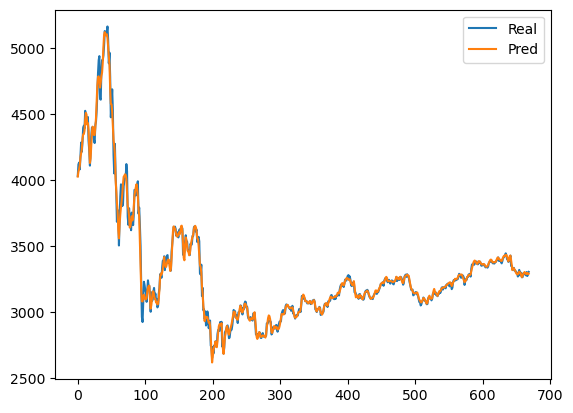

In [ ]:
y_pred = 0
y_true = 0
for i in range(9):
    loaded = torch.load(f"./lstm_{i}.pth")
    print("#"*10 , f" Model {i} Acc {loaded['acc']} ", "#"*10)
    test_ds = CSVDataset(imfs_test[i])
    model = LSTMModel().to(device)
    model.load_state_dict(loaded["model"])
    model.eval()
    with torch.inference_mode():
        y_pred += model(test_ds.x.to(device))
        y_true += test_ds.y

y_test_signal=min_max_scaler.inverse_transform(y_true.numpy().reshape(-1,1))
y_pred_signal=min_max_scaler.inverse_transform(y_pred.detach().cpu().numpy().reshape(-1,1))
plt.plot(y_test_signal, label="Real")
plt.plot(y_pred_signal, label="Pred")
plt.legend()
lstm_mae = mean_absolute_error(y_test_signal, y_pred_signal)
lstm_mape = mean_absolute_percentage_error(y_test_signal, y_pred_signal)
lstm_rmse = np.sqrt(mean_squared_error(y_test_signal, y_pred_signal))
lstm_r2 = r2_score(y_test_signal, y_pred_signal)

print(f"LSTM MAE : {lstm_mae}")
print(f"LSTM MAPE : {lstm_mape}")
print(f"LSTM RMSE : {lstm_rmse}")
print(f"LSTM R2 : {lstm_r2}")

In [ ]:
attn_models = []
attn_accs = []
for i in range(9):
    print("#"*10 , f" Model {i} ", "#"*10)
    train_ds = CSVDataset(imfs_train[i])
    test_ds = CSVDataset(imfs_test[i])

    train_dl = DataLoader(train_ds, shuffle=True, batch_size=BATCH_SIZE, pin_memory=True, num_workers=NW)
    test_dl = DataLoader(test_ds, shuffle=False, batch_size=BATCH_SIZE, pin_memory=True, num_workers=NW)
    dataloaders = {
        "train": train_dl,
        "test": test_dl
    }

    criterion = nn.L1Loss()
    attn_model = AttnLSTM()
    optimizer = optim.Adam(params=attn_model.parameters())
    # scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200, eta_min=1e-5)
    scaler = amp.GradScaler()
    trainer_attn = Trainer(dataloaders, attn_model, criterion, optimizer, scheduler=None, num_epochs=200, model_name=f"attn_{i}")
    trainer_attn.train()
    attn_models.append(trainer_attn.best_model)
    attn_accs.append(trainer_attn.best_acc)
    print("#"*10 , f" Model {i} Acc {trainer_attn.best_acc} ", "#"*10)

##########  Model 0  ##########


  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 0, Train Loss: 0.01819, Train Acc: 0.01819, Valid Loss: 0.0222, Valid Acc: 0.02225
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 1, Train Loss: 0.01786, Train Acc: 0.01786, Valid Loss: 0.02196, Valid Acc: 0.02201
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 2, Train Loss: 0.01786, Train Acc: 0.01785, Valid Loss: 0.02251, Valid Acc: 0.02255



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 3, Train Loss: 0.01781, Train Acc: 0.01781, Valid Loss: 0.02204, Valid Acc: 0.02209



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 4, Train Loss: 0.0178, Train Acc: 0.0178, Valid Loss: 0.023, Valid Acc: 0.02305



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 5, Train Loss: 0.01774, Train Acc: 0.01774, Valid Loss: 0.0219, Valid Acc: 0.02195
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 6, Train Loss: 0.0179, Train Acc: 0.01789, Valid Loss: 0.02189, Valid Acc: 0.02194
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 7, Train Loss: 0.01781, Train Acc: 0.01781, Valid Loss: 0.02235, Valid Acc: 0.0224



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 8, Train Loss: 0.0176, Train Acc: 0.0176, Valid Loss: 0.02191, Valid Acc: 0.02196



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 9, Train Loss: 0.0178, Train Acc: 0.0178, Valid Loss: 0.0219, Valid Acc: 0.02195



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 10, Train Loss: 0.01778, Train Acc: 0.01779, Valid Loss: 0.02205, Valid Acc: 0.02209



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 11, Train Loss: 0.01758, Train Acc: 0.01757, Valid Loss: 0.02195, Valid Acc: 0.022



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 12, Train Loss: 0.01767, Train Acc: 0.01767, Valid Loss: 0.022, Valid Acc: 0.02204



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 13, Train Loss: 0.01754, Train Acc: 0.01755, Valid Loss: 0.0225, Valid Acc: 0.02256



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 14, Train Loss: 0.01751, Train Acc: 0.01752, Valid Loss: 0.02234, Valid Acc: 0.0224



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 15, Train Loss: 0.01761, Train Acc: 0.01762, Valid Loss: 0.02188, Valid Acc: 0.02193
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 16, Train Loss: 0.0174, Train Acc: 0.0174, Valid Loss: 0.02154, Valid Acc: 0.0216
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 17, Train Loss: 0.01734, Train Acc: 0.01734, Valid Loss: 0.02227, Valid Acc: 0.02232



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 18, Train Loss: 0.01726, Train Acc: 0.01725, Valid Loss: 0.02161, Valid Acc: 0.02166



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 19, Train Loss: 0.0172, Train Acc: 0.0172, Valid Loss: 0.02128, Valid Acc: 0.02132
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 20, Train Loss: 0.01694, Train Acc: 0.01695, Valid Loss: 0.02235, Valid Acc: 0.02239



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 21, Train Loss: 0.01691, Train Acc: 0.01692, Valid Loss: 0.02127, Valid Acc: 0.02132
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 22, Train Loss: 0.01671, Train Acc: 0.01672, Valid Loss: 0.02121, Valid Acc: 0.02125
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 23, Train Loss: 0.01675, Train Acc: 0.01675, Valid Loss: 0.02114, Valid Acc: 0.02119
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 24, Train Loss: 0.01649, Train Acc: 0.01649, Valid Loss: 0.02054, Valid Acc: 0.02059
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 25, Train Loss: 0.01634, Train Acc: 0.01634, Valid Loss: 0.02099, Valid Acc: 0.02104



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 26, Train Loss: 0.0163, Train Acc: 0.0163, Valid Loss: 0.02052, Valid Acc: 0.02056
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 27, Train Loss: 0.01622, Train Acc: 0.0162, Valid Loss: 0.02184, Valid Acc: 0.0219



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 28, Train Loss: 0.01618, Train Acc: 0.01616, Valid Loss: 0.02036, Valid Acc: 0.0204
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 29, Train Loss: 0.01624, Train Acc: 0.01625, Valid Loss: 0.0209, Valid Acc: 0.02095



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 30, Train Loss: 0.01623, Train Acc: 0.01623, Valid Loss: 0.02026, Valid Acc: 0.0203
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 31, Train Loss: 0.01588, Train Acc: 0.01588, Valid Loss: 0.02011, Valid Acc: 0.02016
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 32, Train Loss: 0.01594, Train Acc: 0.01593, Valid Loss: 0.02057, Valid Acc: 0.02062



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 33, Train Loss: 0.01581, Train Acc: 0.01582, Valid Loss: 0.02031, Valid Acc: 0.02035



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 34, Train Loss: 0.01584, Train Acc: 0.01584, Valid Loss: 0.02009, Valid Acc: 0.02013
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 35, Train Loss: 0.01572, Train Acc: 0.01571, Valid Loss: 0.01971, Valid Acc: 0.01976
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 36, Train Loss: 0.01563, Train Acc: 0.01563, Valid Loss: 0.02045, Valid Acc: 0.02049



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 37, Train Loss: 0.0157, Train Acc: 0.0157, Valid Loss: 0.02007, Valid Acc: 0.02012



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 38, Train Loss: 0.01562, Train Acc: 0.01562, Valid Loss: 0.02243, Valid Acc: 0.0225



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 39, Train Loss: 0.01556, Train Acc: 0.01556, Valid Loss: 0.02008, Valid Acc: 0.02013



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 40, Train Loss: 0.01551, Train Acc: 0.01551, Valid Loss: 0.01961, Valid Acc: 0.01966
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 41, Train Loss: 0.01546, Train Acc: 0.01545, Valid Loss: 0.02225, Valid Acc: 0.02232



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 42, Train Loss: 0.01571, Train Acc: 0.0157, Valid Loss: 0.02008, Valid Acc: 0.02014



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 43, Train Loss: 0.01556, Train Acc: 0.01556, Valid Loss: 0.02064, Valid Acc: 0.02068



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 44, Train Loss: 0.01541, Train Acc: 0.0154, Valid Loss: 0.02039, Valid Acc: 0.02043



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 45, Train Loss: 0.0155, Train Acc: 0.01549, Valid Loss: 0.01979, Valid Acc: 0.01984



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 46, Train Loss: 0.01538, Train Acc: 0.01538, Valid Loss: 0.02054, Valid Acc: 0.02059



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 47, Train Loss: 0.01532, Train Acc: 0.01532, Valid Loss: 0.02073, Valid Acc: 0.02078



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 48, Train Loss: 0.01538, Train Acc: 0.01539, Valid Loss: 0.02122, Valid Acc: 0.02127



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 49, Train Loss: 0.01541, Train Acc: 0.01539, Valid Loss: 0.02078, Valid Acc: 0.02084



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 50, Train Loss: 0.01535, Train Acc: 0.01535, Valid Loss: 0.01992, Valid Acc: 0.01997



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 51, Train Loss: 0.01523, Train Acc: 0.01522, Valid Loss: 0.02004, Valid Acc: 0.02009



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 52, Train Loss: 0.01539, Train Acc: 0.01539, Valid Loss: 0.02068, Valid Acc: 0.02074



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 53, Train Loss: 0.01531, Train Acc: 0.01531, Valid Loss: 0.02073, Valid Acc: 0.02077



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 54, Train Loss: 0.01522, Train Acc: 0.01521, Valid Loss: 0.02001, Valid Acc: 0.02006



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 55, Train Loss: 0.01511, Train Acc: 0.0151, Valid Loss: 0.01998, Valid Acc: 0.02003



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 56, Train Loss: 0.0151, Train Acc: 0.0151, Valid Loss: 0.01998, Valid Acc: 0.02003



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 57, Train Loss: 0.01513, Train Acc: 0.01512, Valid Loss: 0.01986, Valid Acc: 0.01991



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 58, Train Loss: 0.01503, Train Acc: 0.01502, Valid Loss: 0.01971, Valid Acc: 0.01975



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 59, Train Loss: 0.01521, Train Acc: 0.01522, Valid Loss: 0.02132, Valid Acc: 0.02138



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 60, Train Loss: 0.01508, Train Acc: 0.01507, Valid Loss: 0.0202, Valid Acc: 0.02025



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 61, Train Loss: 0.0152, Train Acc: 0.0152, Valid Loss: 0.01996, Valid Acc: 0.02002



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 62, Train Loss: 0.01504, Train Acc: 0.01504, Valid Loss: 0.02047, Valid Acc: 0.02052



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 63, Train Loss: 0.01503, Train Acc: 0.01501, Valid Loss: 0.02146, Valid Acc: 0.02151



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 64, Train Loss: 0.01511, Train Acc: 0.01512, Valid Loss: 0.02, Valid Acc: 0.02005



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 65, Train Loss: 0.01497, Train Acc: 0.01496, Valid Loss: 0.02002, Valid Acc: 0.02006



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 66, Train Loss: 0.01489, Train Acc: 0.01489, Valid Loss: 0.02012, Valid Acc: 0.02017



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 67, Train Loss: 0.01487, Train Acc: 0.01488, Valid Loss: 0.02055, Valid Acc: 0.02059



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 68, Train Loss: 0.01499, Train Acc: 0.015, Valid Loss: 0.02044, Valid Acc: 0.02049



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 69, Train Loss: 0.01495, Train Acc: 0.01496, Valid Loss: 0.0197, Valid Acc: 0.01975



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 70, Train Loss: 0.0151, Train Acc: 0.0151, Valid Loss: 0.02137, Valid Acc: 0.02143



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 71, Train Loss: 0.0148, Train Acc: 0.01479, Valid Loss: 0.02019, Valid Acc: 0.02024



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 72, Train Loss: 0.01478, Train Acc: 0.01478, Valid Loss: 0.02024, Valid Acc: 0.02029



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 73, Train Loss: 0.01483, Train Acc: 0.01482, Valid Loss: 0.02111, Valid Acc: 0.02117



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 74, Train Loss: 0.01482, Train Acc: 0.01482, Valid Loss: 0.0207, Valid Acc: 0.02075



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 75, Train Loss: 0.01471, Train Acc: 0.01471, Valid Loss: 0.02138, Valid Acc: 0.02143



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 76, Train Loss: 0.01472, Train Acc: 0.01472, Valid Loss: 0.02026, Valid Acc: 0.02032



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 77, Train Loss: 0.01485, Train Acc: 0.01485, Valid Loss: 0.02007, Valid Acc: 0.02012



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 78, Train Loss: 0.01451, Train Acc: 0.01452, Valid Loss: 0.02006, Valid Acc: 0.02011



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 79, Train Loss: 0.01475, Train Acc: 0.01476, Valid Loss: 0.02055, Valid Acc: 0.02061



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 80, Train Loss: 0.01458, Train Acc: 0.01459, Valid Loss: 0.02013, Valid Acc: 0.02019



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 81, Train Loss: 0.01462, Train Acc: 0.01461, Valid Loss: 0.02265, Valid Acc: 0.02272



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 82, Train Loss: 0.01463, Train Acc: 0.01463, Valid Loss: 0.02044, Valid Acc: 0.02049



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 83, Train Loss: 0.01475, Train Acc: 0.01476, Valid Loss: 0.02002, Valid Acc: 0.02007



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 84, Train Loss: 0.01461, Train Acc: 0.01462, Valid Loss: 0.02102, Valid Acc: 0.02108



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 85, Train Loss: 0.01456, Train Acc: 0.01456, Valid Loss: 0.02079, Valid Acc: 0.02084



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 86, Train Loss: 0.01445, Train Acc: 0.01445, Valid Loss: 0.02183, Valid Acc: 0.02188



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 87, Train Loss: 0.01443, Train Acc: 0.01442, Valid Loss: 0.02016, Valid Acc: 0.02021



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 88, Train Loss: 0.01433, Train Acc: 0.01434, Valid Loss: 0.02075, Valid Acc: 0.0208



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 89, Train Loss: 0.01444, Train Acc: 0.01444, Valid Loss: 0.02041, Valid Acc: 0.02047



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 90, Train Loss: 0.01438, Train Acc: 0.01439, Valid Loss: 0.02141, Valid Acc: 0.02146



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 91, Train Loss: 0.01423, Train Acc: 0.01423, Valid Loss: 0.02126, Valid Acc: 0.02131



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 92, Train Loss: 0.01432, Train Acc: 0.01432, Valid Loss: 0.02004, Valid Acc: 0.02009



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 93, Train Loss: 0.01452, Train Acc: 0.01452, Valid Loss: 0.02002, Valid Acc: 0.02007



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 94, Train Loss: 0.01421, Train Acc: 0.0142, Valid Loss: 0.0225, Valid Acc: 0.02256



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 95, Train Loss: 0.01435, Train Acc: 0.01436, Valid Loss: 0.02034, Valid Acc: 0.02039



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 96, Train Loss: 0.01401, Train Acc: 0.014, Valid Loss: 0.02032, Valid Acc: 0.02038



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 97, Train Loss: 0.01397, Train Acc: 0.01398, Valid Loss: 0.0207, Valid Acc: 0.02076



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 98, Train Loss: 0.01411, Train Acc: 0.01411, Valid Loss: 0.01987, Valid Acc: 0.01993



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 99, Train Loss: 0.01413, Train Acc: 0.01413, Valid Loss: 0.02069, Valid Acc: 0.02075



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 100, Train Loss: 0.01402, Train Acc: 0.01402, Valid Loss: 0.02042, Valid Acc: 0.02047



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 101, Train Loss: 0.01385, Train Acc: 0.01385, Valid Loss: 0.02094, Valid Acc: 0.02099



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 102, Train Loss: 0.01398, Train Acc: 0.01397, Valid Loss: 0.02079, Valid Acc: 0.02085



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 103, Train Loss: 0.0139, Train Acc: 0.01389, Valid Loss: 0.01971, Valid Acc: 0.01975



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 104, Train Loss: 0.01398, Train Acc: 0.01399, Valid Loss: 0.02037, Valid Acc: 0.02043



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 105, Train Loss: 0.01364, Train Acc: 0.01364, Valid Loss: 0.02032, Valid Acc: 0.02038



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 106, Train Loss: 0.014, Train Acc: 0.014, Valid Loss: 0.02013, Valid Acc: 0.02018



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 107, Train Loss: 0.01368, Train Acc: 0.01368, Valid Loss: 0.02073, Valid Acc: 0.02079



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 108, Train Loss: 0.01386, Train Acc: 0.01386, Valid Loss: 0.01993, Valid Acc: 0.01998



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 109, Train Loss: 0.01363, Train Acc: 0.01362, Valid Loss: 0.01998, Valid Acc: 0.02003



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 110, Train Loss: 0.01375, Train Acc: 0.01376, Valid Loss: 0.02104, Valid Acc: 0.02109



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 111, Train Loss: 0.0136, Train Acc: 0.0136, Valid Loss: 0.02053, Valid Acc: 0.02058



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 112, Train Loss: 0.0135, Train Acc: 0.0135, Valid Loss: 0.02006, Valid Acc: 0.02011



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 113, Train Loss: 0.01362, Train Acc: 0.01362, Valid Loss: 0.0206, Valid Acc: 0.02065



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 114, Train Loss: 0.01367, Train Acc: 0.01367, Valid Loss: 0.02049, Valid Acc: 0.02054



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 115, Train Loss: 0.01376, Train Acc: 0.01377, Valid Loss: 0.0211, Valid Acc: 0.02116



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 116, Train Loss: 0.01356, Train Acc: 0.01355, Valid Loss: 0.02116, Valid Acc: 0.02122



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 117, Train Loss: 0.01346, Train Acc: 0.01347, Valid Loss: 0.02177, Valid Acc: 0.02182



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 118, Train Loss: 0.01355, Train Acc: 0.01354, Valid Loss: 0.02077, Valid Acc: 0.02083



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 119, Train Loss: 0.01361, Train Acc: 0.01361, Valid Loss: 0.02098, Valid Acc: 0.02103



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 120, Train Loss: 0.01364, Train Acc: 0.01365, Valid Loss: 0.02074, Valid Acc: 0.02079



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 121, Train Loss: 0.01348, Train Acc: 0.01348, Valid Loss: 0.02005, Valid Acc: 0.0201



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 122, Train Loss: 0.01328, Train Acc: 0.01329, Valid Loss: 0.02098, Valid Acc: 0.02102



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 123, Train Loss: 0.01333, Train Acc: 0.01334, Valid Loss: 0.02097, Valid Acc: 0.02102



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 124, Train Loss: 0.01335, Train Acc: 0.01336, Valid Loss: 0.02101, Valid Acc: 0.02107



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 125, Train Loss: 0.01337, Train Acc: 0.01337, Valid Loss: 0.02087, Valid Acc: 0.02092



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 126, Train Loss: 0.01349, Train Acc: 0.01348, Valid Loss: 0.0217, Valid Acc: 0.02176



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 127, Train Loss: 0.01341, Train Acc: 0.01339, Valid Loss: 0.02196, Valid Acc: 0.02201



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 128, Train Loss: 0.01315, Train Acc: 0.01315, Valid Loss: 0.02, Valid Acc: 0.02004



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 129, Train Loss: 0.01328, Train Acc: 0.01329, Valid Loss: 0.02067, Valid Acc: 0.02073



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 130, Train Loss: 0.01316, Train Acc: 0.01316, Valid Loss: 0.02059, Valid Acc: 0.02065



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 131, Train Loss: 0.0133, Train Acc: 0.0133, Valid Loss: 0.0213, Valid Acc: 0.02135



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 132, Train Loss: 0.0132, Train Acc: 0.01319, Valid Loss: 0.02088, Valid Acc: 0.02093



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 133, Train Loss: 0.01314, Train Acc: 0.01314, Valid Loss: 0.02006, Valid Acc: 0.02011



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 134, Train Loss: 0.0131, Train Acc: 0.0131, Valid Loss: 0.02176, Valid Acc: 0.02181



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 135, Train Loss: 0.01327, Train Acc: 0.01326, Valid Loss: 0.02114, Valid Acc: 0.0212



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 136, Train Loss: 0.01318, Train Acc: 0.01318, Valid Loss: 0.02102, Valid Acc: 0.02107



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 137, Train Loss: 0.013, Train Acc: 0.01299, Valid Loss: 0.02061, Valid Acc: 0.02067



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 138, Train Loss: 0.0131, Train Acc: 0.0131, Valid Loss: 0.02135, Valid Acc: 0.0214



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 139, Train Loss: 0.01318, Train Acc: 0.01318, Valid Loss: 0.02073, Valid Acc: 0.02079



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 140, Train Loss: 0.0129, Train Acc: 0.0129, Valid Loss: 0.02135, Valid Acc: 0.02141



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 141, Train Loss: 0.0131, Train Acc: 0.0131, Valid Loss: 0.02171, Valid Acc: 0.02177



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 142, Train Loss: 0.01279, Train Acc: 0.01279, Valid Loss: 0.02132, Valid Acc: 0.02138



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 143, Train Loss: 0.01291, Train Acc: 0.01291, Valid Loss: 0.02044, Valid Acc: 0.0205



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 144, Train Loss: 0.01286, Train Acc: 0.01286, Valid Loss: 0.02069, Valid Acc: 0.02075



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 145, Train Loss: 0.0129, Train Acc: 0.0129, Valid Loss: 0.02079, Valid Acc: 0.02085



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 146, Train Loss: 0.01282, Train Acc: 0.01282, Valid Loss: 0.02169, Valid Acc: 0.02174



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 147, Train Loss: 0.01267, Train Acc: 0.01267, Valid Loss: 0.02105, Valid Acc: 0.02111



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 148, Train Loss: 0.01277, Train Acc: 0.01277, Valid Loss: 0.02072, Valid Acc: 0.02078



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 149, Train Loss: 0.01286, Train Acc: 0.01285, Valid Loss: 0.02114, Valid Acc: 0.0212



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 150, Train Loss: 0.01263, Train Acc: 0.01264, Valid Loss: 0.02107, Valid Acc: 0.02112



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 151, Train Loss: 0.01263, Train Acc: 0.01263, Valid Loss: 0.02065, Valid Acc: 0.0207



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 152, Train Loss: 0.0126, Train Acc: 0.01261, Valid Loss: 0.02059, Valid Acc: 0.02065



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 153, Train Loss: 0.01261, Train Acc: 0.01261, Valid Loss: 0.02078, Valid Acc: 0.02083



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 154, Train Loss: 0.01259, Train Acc: 0.01259, Valid Loss: 0.02068, Valid Acc: 0.02073



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 155, Train Loss: 0.01268, Train Acc: 0.01267, Valid Loss: 0.02151, Valid Acc: 0.02157



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 156, Train Loss: 0.01264, Train Acc: 0.01262, Valid Loss: 0.02109, Valid Acc: 0.02114



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 157, Train Loss: 0.01245, Train Acc: 0.01245, Valid Loss: 0.02155, Valid Acc: 0.02161



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 158, Train Loss: 0.01248, Train Acc: 0.01249, Valid Loss: 0.0209, Valid Acc: 0.02095



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 159, Train Loss: 0.01246, Train Acc: 0.01246, Valid Loss: 0.02162, Valid Acc: 0.02169



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 160, Train Loss: 0.0126, Train Acc: 0.0126, Valid Loss: 0.02081, Valid Acc: 0.02086



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 161, Train Loss: 0.0123, Train Acc: 0.0123, Valid Loss: 0.02186, Valid Acc: 0.02192



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 162, Train Loss: 0.01241, Train Acc: 0.01242, Valid Loss: 0.0216, Valid Acc: 0.02166



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 163, Train Loss: 0.01252, Train Acc: 0.01252, Valid Loss: 0.02117, Valid Acc: 0.02123



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 164, Train Loss: 0.01235, Train Acc: 0.01235, Valid Loss: 0.02175, Valid Acc: 0.0218



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 165, Train Loss: 0.01228, Train Acc: 0.01229, Valid Loss: 0.02231, Valid Acc: 0.02238



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 166, Train Loss: 0.01231, Train Acc: 0.01231, Valid Loss: 0.02232, Valid Acc: 0.02238



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 167, Train Loss: 0.0122, Train Acc: 0.0122, Valid Loss: 0.0206, Valid Acc: 0.02066



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 168, Train Loss: 0.01237, Train Acc: 0.01237, Valid Loss: 0.02144, Valid Acc: 0.0215



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 169, Train Loss: 0.01231, Train Acc: 0.01231, Valid Loss: 0.02139, Valid Acc: 0.02145



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 170, Train Loss: 0.01236, Train Acc: 0.01236, Valid Loss: 0.02207, Valid Acc: 0.02213



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 171, Train Loss: 0.01232, Train Acc: 0.01231, Valid Loss: 0.02165, Valid Acc: 0.0217



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 172, Train Loss: 0.0122, Train Acc: 0.01219, Valid Loss: 0.02071, Valid Acc: 0.02076



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 173, Train Loss: 0.01206, Train Acc: 0.01204, Valid Loss: 0.02133, Valid Acc: 0.02139



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 174, Train Loss: 0.01197, Train Acc: 0.01198, Valid Loss: 0.02089, Valid Acc: 0.02094



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 175, Train Loss: 0.01217, Train Acc: 0.01217, Valid Loss: 0.02161, Valid Acc: 0.02167



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 176, Train Loss: 0.01205, Train Acc: 0.01204, Valid Loss: 0.02122, Valid Acc: 0.02127



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 177, Train Loss: 0.01207, Train Acc: 0.01207, Valid Loss: 0.02125, Valid Acc: 0.02131



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 178, Train Loss: 0.0119, Train Acc: 0.0119, Valid Loss: 0.02164, Valid Acc: 0.02171



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 179, Train Loss: 0.01197, Train Acc: 0.01197, Valid Loss: 0.02049, Valid Acc: 0.02054



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 180, Train Loss: 0.0121, Train Acc: 0.0121, Valid Loss: 0.0211, Valid Acc: 0.02116



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 181, Train Loss: 0.01187, Train Acc: 0.01188, Valid Loss: 0.02098, Valid Acc: 0.02104



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 182, Train Loss: 0.01197, Train Acc: 0.01197, Valid Loss: 0.02127, Valid Acc: 0.02134



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 183, Train Loss: 0.01194, Train Acc: 0.01193, Valid Loss: 0.0211, Valid Acc: 0.02116



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 184, Train Loss: 0.0119, Train Acc: 0.0119, Valid Loss: 0.02199, Valid Acc: 0.02205



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 185, Train Loss: 0.01188, Train Acc: 0.01188, Valid Loss: 0.0219, Valid Acc: 0.02196



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 186, Train Loss: 0.01166, Train Acc: 0.01167, Valid Loss: 0.02157, Valid Acc: 0.02163



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 187, Train Loss: 0.01169, Train Acc: 0.01169, Valid Loss: 0.02206, Valid Acc: 0.02212



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 188, Train Loss: 0.01173, Train Acc: 0.01173, Valid Loss: 0.02172, Valid Acc: 0.02178



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 189, Train Loss: 0.01173, Train Acc: 0.01173, Valid Loss: 0.02162, Valid Acc: 0.02168



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 190, Train Loss: 0.01191, Train Acc: 0.01191, Valid Loss: 0.02207, Valid Acc: 0.02213



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 191, Train Loss: 0.0117, Train Acc: 0.0117, Valid Loss: 0.02184, Valid Acc: 0.0219



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 192, Train Loss: 0.01167, Train Acc: 0.01167, Valid Loss: 0.02268, Valid Acc: 0.02274



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 193, Train Loss: 0.0118, Train Acc: 0.0118, Valid Loss: 0.02212, Valid Acc: 0.02218



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 194, Train Loss: 0.01178, Train Acc: 0.01177, Valid Loss: 0.02207, Valid Acc: 0.02213



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 195, Train Loss: 0.01204, Train Acc: 0.01205, Valid Loss: 0.02111, Valid Acc: 0.02117



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 196, Train Loss: 0.01149, Train Acc: 0.0115, Valid Loss: 0.02125, Valid Acc: 0.0213



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 197, Train Loss: 0.01137, Train Acc: 0.01136, Valid Loss: 0.02118, Valid Acc: 0.02123



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 198, Train Loss: 0.01148, Train Acc: 0.01148, Valid Loss: 0.02071, Valid Acc: 0.02076



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 199, Train Loss: 0.01136, Train Acc: 0.01136, Valid Loss: 0.02148, Valid Acc: 0.02155

##########  Model 0 Acc 0.019657649099826813  ##########
##########  Model 1  ##########


  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 0, Train Loss: 0.01948, Train Acc: 0.01947, Valid Loss: 0.02021, Valid Acc: 0.02028
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 1, Train Loss: 0.01944, Train Acc: 0.01944, Valid Loss: 0.01929, Valid Acc: 0.01937
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 2, Train Loss: 0.01921, Train Acc: 0.01921, Valid Loss: 0.01937, Valid Acc: 0.01943



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 3, Train Loss: 0.01913, Train Acc: 0.01913, Valid Loss: 0.01928, Valid Acc: 0.01935
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 4, Train Loss: 0.01915, Train Acc: 0.01915, Valid Loss: 0.01989, Valid Acc: 0.01996



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 5, Train Loss: 0.01898, Train Acc: 0.01898, Valid Loss: 0.01952, Valid Acc: 0.01959



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 6, Train Loss: 0.01889, Train Acc: 0.0189, Valid Loss: 0.01893, Valid Acc: 0.019
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 7, Train Loss: 0.01845, Train Acc: 0.01845, Valid Loss: 0.01784, Valid Acc: 0.01791
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 8, Train Loss: 0.01791, Train Acc: 0.01792, Valid Loss: 0.01753, Valid Acc: 0.01758
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 9, Train Loss: 0.01733, Train Acc: 0.01735, Valid Loss: 0.01701, Valid Acc: 0.01707
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 10, Train Loss: 0.01685, Train Acc: 0.01686, Valid Loss: 0.01699, Valid Acc: 0.01704
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 11, Train Loss: 0.01627, Train Acc: 0.01627, Valid Loss: 0.01566, Valid Acc: 0.01571
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 12, Train Loss: 0.01617, Train Acc: 0.01618, Valid Loss: 0.01533, Valid Acc: 0.01538
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 13, Train Loss: 0.01574, Train Acc: 0.01574, Valid Loss: 0.01792, Valid Acc: 0.01797



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 14, Train Loss: 0.01567, Train Acc: 0.01566, Valid Loss: 0.01446, Valid Acc: 0.01451
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 15, Train Loss: 0.015, Train Acc: 0.015, Valid Loss: 0.01725, Valid Acc: 0.01729



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 16, Train Loss: 0.01467, Train Acc: 0.01469, Valid Loss: 0.01458, Valid Acc: 0.01461



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 17, Train Loss: 0.01416, Train Acc: 0.01416, Valid Loss: 0.01368, Valid Acc: 0.01374
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 18, Train Loss: 0.0138, Train Acc: 0.0138, Valid Loss: 0.01518, Valid Acc: 0.01522



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 19, Train Loss: 0.01356, Train Acc: 0.01356, Valid Loss: 0.01343, Valid Acc: 0.01348
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 20, Train Loss: 0.01296, Train Acc: 0.01296, Valid Loss: 0.01218, Valid Acc: 0.01223
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 21, Train Loss: 0.0126, Train Acc: 0.0126, Valid Loss: 0.01183, Valid Acc: 0.01187
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 22, Train Loss: 0.01213, Train Acc: 0.01213, Valid Loss: 0.01134, Valid Acc: 0.01138
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 23, Train Loss: 0.01179, Train Acc: 0.01179, Valid Loss: 0.01087, Valid Acc: 0.01092
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 24, Train Loss: 0.01159, Train Acc: 0.0116, Valid Loss: 0.01041, Valid Acc: 0.01045
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 25, Train Loss: 0.01098, Train Acc: 0.01099, Valid Loss: 0.0112, Valid Acc: 0.01124



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 26, Train Loss: 0.01051, Train Acc: 0.01051, Valid Loss: 0.009553, Valid Acc: 0.009576
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 27, Train Loss: 0.009758, Train Acc: 0.009756, Valid Loss: 0.007878, Valid Acc: 0.007907
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 28, Train Loss: 0.008214, Train Acc: 0.008211, Valid Loss: 0.007966, Valid Acc: 0.007979



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 29, Train Loss: 0.008073, Train Acc: 0.008074, Valid Loss: 0.006232, Valid Acc: 0.006252
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 30, Train Loss: 0.007432, Train Acc: 0.007435, Valid Loss: 0.006819, Valid Acc: 0.006838



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 31, Train Loss: 0.007031, Train Acc: 0.007035, Valid Loss: 0.007459, Valid Acc: 0.007471



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 32, Train Loss: 0.006731, Train Acc: 0.006728, Valid Loss: 0.005743, Valid Acc: 0.005761
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 33, Train Loss: 0.006615, Train Acc: 0.006615, Valid Loss: 0.006964, Valid Acc: 0.006979



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 34, Train Loss: 0.006655, Train Acc: 0.006657, Valid Loss: 0.00608, Valid Acc: 0.006093



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 35, Train Loss: 0.00654, Train Acc: 0.006537, Valid Loss: 0.007163, Valid Acc: 0.007176



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 36, Train Loss: 0.006838, Train Acc: 0.00684, Valid Loss: 0.005623, Valid Acc: 0.005635
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 37, Train Loss: 0.006275, Train Acc: 0.006275, Valid Loss: 0.005931, Valid Acc: 0.00595



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 38, Train Loss: 0.006496, Train Acc: 0.006498, Valid Loss: 0.005326, Valid Acc: 0.005341
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 39, Train Loss: 0.006341, Train Acc: 0.006341, Valid Loss: 0.005786, Valid Acc: 0.005797



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 40, Train Loss: 0.006256, Train Acc: 0.006258, Valid Loss: 0.006342, Valid Acc: 0.006365



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 41, Train Loss: 0.006175, Train Acc: 0.006169, Valid Loss: 0.007093, Valid Acc: 0.007102



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 42, Train Loss: 0.006497, Train Acc: 0.006497, Valid Loss: 0.005809, Valid Acc: 0.005822



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 43, Train Loss: 0.006192, Train Acc: 0.006193, Valid Loss: 0.005899, Valid Acc: 0.005917



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 44, Train Loss: 0.006256, Train Acc: 0.006258, Valid Loss: 0.006524, Valid Acc: 0.006538



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 45, Train Loss: 0.006231, Train Acc: 0.006227, Valid Loss: 0.00552, Valid Acc: 0.005537



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 46, Train Loss: 0.005955, Train Acc: 0.00595, Valid Loss: 0.005509, Valid Acc: 0.005526



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 47, Train Loss: 0.006264, Train Acc: 0.006261, Valid Loss: 0.0112, Valid Acc: 0.01122



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 48, Train Loss: 0.006335, Train Acc: 0.006337, Valid Loss: 0.005438, Valid Acc: 0.005454



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 49, Train Loss: 0.006082, Train Acc: 0.006081, Valid Loss: 0.007355, Valid Acc: 0.007366



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 50, Train Loss: 0.005963, Train Acc: 0.005967, Valid Loss: 0.005506, Valid Acc: 0.005522



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 51, Train Loss: 0.006086, Train Acc: 0.006085, Valid Loss: 0.005493, Valid Acc: 0.005512



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 52, Train Loss: 0.006211, Train Acc: 0.00621, Valid Loss: 0.005321, Valid Acc: 0.005338
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 53, Train Loss: 0.00613, Train Acc: 0.006132, Valid Loss: 0.005468, Valid Acc: 0.005485



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 54, Train Loss: 0.006062, Train Acc: 0.006065, Valid Loss: 0.0052, Valid Acc: 0.005216
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 55, Train Loss: 0.005993, Train Acc: 0.005988, Valid Loss: 0.005807, Valid Acc: 0.005826



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 56, Train Loss: 0.006047, Train Acc: 0.006045, Valid Loss: 0.005244, Valid Acc: 0.005261



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 57, Train Loss: 0.006171, Train Acc: 0.00617, Valid Loss: 0.005764, Valid Acc: 0.005781



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 58, Train Loss: 0.005951, Train Acc: 0.005953, Valid Loss: 0.005716, Valid Acc: 0.005733



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 59, Train Loss: 0.005955, Train Acc: 0.00596, Valid Loss: 0.006331, Valid Acc: 0.006352



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 60, Train Loss: 0.006151, Train Acc: 0.006151, Valid Loss: 0.005924, Valid Acc: 0.005935



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 61, Train Loss: 0.00617, Train Acc: 0.006173, Valid Loss: 0.00533, Valid Acc: 0.005344



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 62, Train Loss: 0.005931, Train Acc: 0.005934, Valid Loss: 0.005513, Valid Acc: 0.005531



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 63, Train Loss: 0.005937, Train Acc: 0.005938, Valid Loss: 0.006918, Valid Acc: 0.006929



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 64, Train Loss: 0.006004, Train Acc: 0.006005, Valid Loss: 0.006161, Valid Acc: 0.006178



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 65, Train Loss: 0.006125, Train Acc: 0.006126, Valid Loss: 0.005261, Valid Acc: 0.005277



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 66, Train Loss: 0.005855, Train Acc: 0.00585, Valid Loss: 0.005616, Valid Acc: 0.00563



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 67, Train Loss: 0.006095, Train Acc: 0.006098, Valid Loss: 0.005326, Valid Acc: 0.005342



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 68, Train Loss: 0.005896, Train Acc: 0.005895, Valid Loss: 0.007623, Valid Acc: 0.007637



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 69, Train Loss: 0.005863, Train Acc: 0.005858, Valid Loss: 0.00573, Valid Acc: 0.005745



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 70, Train Loss: 0.005879, Train Acc: 0.005881, Valid Loss: 0.005734, Valid Acc: 0.005751



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 71, Train Loss: 0.006023, Train Acc: 0.006023, Valid Loss: 0.005691, Valid Acc: 0.005709



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 72, Train Loss: 0.006072, Train Acc: 0.006071, Valid Loss: 0.005558, Valid Acc: 0.005573



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 73, Train Loss: 0.005871, Train Acc: 0.005869, Valid Loss: 0.005406, Valid Acc: 0.005425



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 74, Train Loss: 0.00605, Train Acc: 0.006044, Valid Loss: 0.005931, Valid Acc: 0.005944



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 75, Train Loss: 0.005919, Train Acc: 0.005918, Valid Loss: 0.005733, Valid Acc: 0.005752



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 76, Train Loss: 0.005831, Train Acc: 0.005836, Valid Loss: 0.005775, Valid Acc: 0.005792



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 77, Train Loss: 0.005843, Train Acc: 0.005845, Valid Loss: 0.005379, Valid Acc: 0.005394



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 78, Train Loss: 0.00579, Train Acc: 0.00579, Valid Loss: 0.005571, Valid Acc: 0.005588



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 79, Train Loss: 0.005766, Train Acc: 0.005769, Valid Loss: 0.005769, Valid Acc: 0.005787



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 80, Train Loss: 0.005935, Train Acc: 0.005937, Valid Loss: 0.006718, Valid Acc: 0.006731



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 81, Train Loss: 0.005969, Train Acc: 0.005967, Valid Loss: 0.005496, Valid Acc: 0.005511



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 82, Train Loss: 0.005794, Train Acc: 0.005794, Valid Loss: 0.00539, Valid Acc: 0.005407



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 83, Train Loss: 0.005864, Train Acc: 0.005866, Valid Loss: 0.005554, Valid Acc: 0.005571



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 84, Train Loss: 0.006057, Train Acc: 0.006059, Valid Loss: 0.006014, Valid Acc: 0.006027



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 85, Train Loss: 0.005765, Train Acc: 0.005766, Valid Loss: 0.005305, Valid Acc: 0.00532



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 86, Train Loss: 0.005851, Train Acc: 0.005853, Valid Loss: 0.005436, Valid Acc: 0.005453



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 87, Train Loss: 0.006006, Train Acc: 0.006005, Valid Loss: 0.005507, Valid Acc: 0.005523



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 88, Train Loss: 0.00574, Train Acc: 0.005743, Valid Loss: 0.005374, Valid Acc: 0.00539



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 89, Train Loss: 0.005775, Train Acc: 0.005769, Valid Loss: 0.006168, Valid Acc: 0.006188



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 90, Train Loss: 0.005817, Train Acc: 0.005816, Valid Loss: 0.007126, Valid Acc: 0.007133



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 91, Train Loss: 0.005818, Train Acc: 0.005816, Valid Loss: 0.005359, Valid Acc: 0.005377



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 92, Train Loss: 0.005949, Train Acc: 0.005949, Valid Loss: 0.005257, Valid Acc: 0.005273



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 93, Train Loss: 0.006064, Train Acc: 0.006062, Valid Loss: 0.005889, Valid Acc: 0.005908



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 94, Train Loss: 0.005884, Train Acc: 0.005888, Valid Loss: 0.0059, Valid Acc: 0.005915



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 95, Train Loss: 0.005679, Train Acc: 0.005682, Valid Loss: 0.005601, Valid Acc: 0.005619



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 96, Train Loss: 0.005886, Train Acc: 0.005887, Valid Loss: 0.005987, Valid Acc: 0.006003



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 97, Train Loss: 0.005956, Train Acc: 0.005956, Valid Loss: 0.007379, Valid Acc: 0.007392



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 98, Train Loss: 0.005755, Train Acc: 0.005753, Valid Loss: 0.005215, Valid Acc: 0.005231



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 99, Train Loss: 0.005736, Train Acc: 0.005739, Valid Loss: 0.005883, Valid Acc: 0.005897



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 100, Train Loss: 0.005699, Train Acc: 0.005699, Valid Loss: 0.005527, Valid Acc: 0.005543



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 101, Train Loss: 0.005742, Train Acc: 0.005746, Valid Loss: 0.005749, Valid Acc: 0.005767



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 102, Train Loss: 0.005646, Train Acc: 0.005647, Valid Loss: 0.006223, Valid Acc: 0.006238



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 103, Train Loss: 0.005671, Train Acc: 0.005659, Valid Loss: 0.005431, Valid Acc: 0.005447



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 104, Train Loss: 0.005691, Train Acc: 0.00569, Valid Loss: 0.005393, Valid Acc: 0.00541



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 105, Train Loss: 0.005712, Train Acc: 0.005712, Valid Loss: 0.006189, Valid Acc: 0.006209



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 106, Train Loss: 0.005765, Train Acc: 0.005764, Valid Loss: 0.005445, Valid Acc: 0.005462



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 107, Train Loss: 0.005756, Train Acc: 0.005755, Valid Loss: 0.005292, Valid Acc: 0.005309



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 108, Train Loss: 0.005851, Train Acc: 0.005853, Valid Loss: 0.005429, Valid Acc: 0.005447



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 109, Train Loss: 0.005684, Train Acc: 0.005684, Valid Loss: 0.007093, Valid Acc: 0.007101



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 110, Train Loss: 0.00574, Train Acc: 0.005745, Valid Loss: 0.00592, Valid Acc: 0.005941



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 111, Train Loss: 0.005633, Train Acc: 0.005634, Valid Loss: 0.005475, Valid Acc: 0.005493



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 112, Train Loss: 0.00569, Train Acc: 0.00569, Valid Loss: 0.005422, Valid Acc: 0.005438



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 113, Train Loss: 0.005706, Train Acc: 0.005704, Valid Loss: 0.005816, Valid Acc: 0.005832



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 114, Train Loss: 0.005769, Train Acc: 0.005771, Valid Loss: 0.005474, Valid Acc: 0.005489



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 115, Train Loss: 0.005816, Train Acc: 0.005815, Valid Loss: 0.006377, Valid Acc: 0.006392



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 116, Train Loss: 0.00578, Train Acc: 0.005779, Valid Loss: 0.005886, Valid Acc: 0.005905



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 117, Train Loss: 0.005487, Train Acc: 0.005483, Valid Loss: 0.005253, Valid Acc: 0.00527



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 118, Train Loss: 0.005606, Train Acc: 0.005606, Valid Loss: 0.005588, Valid Acc: 0.005604



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 119, Train Loss: 0.005686, Train Acc: 0.005679, Valid Loss: 0.006035, Valid Acc: 0.00605



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 120, Train Loss: 0.005639, Train Acc: 0.005644, Valid Loss: 0.005949, Valid Acc: 0.005968



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 121, Train Loss: 0.005552, Train Acc: 0.005549, Valid Loss: 0.005514, Valid Acc: 0.00553



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 122, Train Loss: 0.005544, Train Acc: 0.005543, Valid Loss: 0.006011, Valid Acc: 0.006023



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 123, Train Loss: 0.005672, Train Acc: 0.005669, Valid Loss: 0.005886, Valid Acc: 0.005906



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 124, Train Loss: 0.005676, Train Acc: 0.005677, Valid Loss: 0.00682, Valid Acc: 0.006836



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 125, Train Loss: 0.005637, Train Acc: 0.005638, Valid Loss: 0.00597, Valid Acc: 0.005989



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 126, Train Loss: 0.005663, Train Acc: 0.005662, Valid Loss: 0.005753, Valid Acc: 0.005769



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 127, Train Loss: 0.005556, Train Acc: 0.005552, Valid Loss: 0.005666, Valid Acc: 0.005684



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 128, Train Loss: 0.005554, Train Acc: 0.005556, Valid Loss: 0.006085, Valid Acc: 0.006103



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 129, Train Loss: 0.00556, Train Acc: 0.005562, Valid Loss: 0.005768, Valid Acc: 0.005786



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 130, Train Loss: 0.005419, Train Acc: 0.005421, Valid Loss: 0.005619, Valid Acc: 0.005638



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 131, Train Loss: 0.005634, Train Acc: 0.005636, Valid Loss: 0.005856, Valid Acc: 0.005874



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 132, Train Loss: 0.005435, Train Acc: 0.005438, Valid Loss: 0.005533, Valid Acc: 0.005551



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 133, Train Loss: 0.005503, Train Acc: 0.005496, Valid Loss: 0.005628, Valid Acc: 0.005647



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 134, Train Loss: 0.005451, Train Acc: 0.005452, Valid Loss: 0.005579, Valid Acc: 0.005597



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 135, Train Loss: 0.005462, Train Acc: 0.005458, Valid Loss: 0.009596, Valid Acc: 0.009603



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 136, Train Loss: 0.005614, Train Acc: 0.005615, Valid Loss: 0.005923, Valid Acc: 0.005939



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 137, Train Loss: 0.005495, Train Acc: 0.005491, Valid Loss: 0.005798, Valid Acc: 0.005817



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 138, Train Loss: 0.005681, Train Acc: 0.005682, Valid Loss: 0.005831, Valid Acc: 0.00585



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 139, Train Loss: 0.005424, Train Acc: 0.00542, Valid Loss: 0.007286, Valid Acc: 0.007305



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 140, Train Loss: 0.005585, Train Acc: 0.005588, Valid Loss: 0.005659, Valid Acc: 0.005677



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 141, Train Loss: 0.005509, Train Acc: 0.005507, Valid Loss: 0.006031, Valid Acc: 0.00605



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 142, Train Loss: 0.005305, Train Acc: 0.005303, Valid Loss: 0.006202, Valid Acc: 0.006221



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 143, Train Loss: 0.005424, Train Acc: 0.005423, Valid Loss: 0.005733, Valid Acc: 0.005749



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 144, Train Loss: 0.005433, Train Acc: 0.005433, Valid Loss: 0.00582, Valid Acc: 0.005839



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 145, Train Loss: 0.005519, Train Acc: 0.005517, Valid Loss: 0.005593, Valid Acc: 0.005611



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 146, Train Loss: 0.005408, Train Acc: 0.005407, Valid Loss: 0.006647, Valid Acc: 0.006663



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 147, Train Loss: 0.005371, Train Acc: 0.005374, Valid Loss: 0.005906, Valid Acc: 0.00592



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 148, Train Loss: 0.005517, Train Acc: 0.005516, Valid Loss: 0.006779, Valid Acc: 0.006797



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 149, Train Loss: 0.005436, Train Acc: 0.005436, Valid Loss: 0.005707, Valid Acc: 0.005725



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 150, Train Loss: 0.005437, Train Acc: 0.00544, Valid Loss: 0.005856, Valid Acc: 0.005875



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 151, Train Loss: 0.005388, Train Acc: 0.005385, Valid Loss: 0.005518, Valid Acc: 0.005535



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 152, Train Loss: 0.005618, Train Acc: 0.005621, Valid Loss: 0.006644, Valid Acc: 0.006655



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 153, Train Loss: 0.005347, Train Acc: 0.005347, Valid Loss: 0.005776, Valid Acc: 0.005795



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 154, Train Loss: 0.005408, Train Acc: 0.005408, Valid Loss: 0.005907, Valid Acc: 0.005926



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 155, Train Loss: 0.005245, Train Acc: 0.005246, Valid Loss: 0.005621, Valid Acc: 0.00564



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 156, Train Loss: 0.005303, Train Acc: 0.005301, Valid Loss: 0.006037, Valid Acc: 0.006056



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 157, Train Loss: 0.005421, Train Acc: 0.005421, Valid Loss: 0.005731, Valid Acc: 0.005749



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 158, Train Loss: 0.00525, Train Acc: 0.005253, Valid Loss: 0.006829, Valid Acc: 0.006843



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 159, Train Loss: 0.005228, Train Acc: 0.005226, Valid Loss: 0.006465, Valid Acc: 0.006479



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 160, Train Loss: 0.005233, Train Acc: 0.005234, Valid Loss: 0.005865, Valid Acc: 0.005883



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 161, Train Loss: 0.005256, Train Acc: 0.005256, Valid Loss: 0.006133, Valid Acc: 0.006152



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 162, Train Loss: 0.005312, Train Acc: 0.005314, Valid Loss: 0.006285, Valid Acc: 0.006304



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 163, Train Loss: 0.005571, Train Acc: 0.005572, Valid Loss: 0.006235, Valid Acc: 0.006251



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 164, Train Loss: 0.005298, Train Acc: 0.005298, Valid Loss: 0.006068, Valid Acc: 0.006088



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 165, Train Loss: 0.005269, Train Acc: 0.00527, Valid Loss: 0.006575, Valid Acc: 0.006591



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 166, Train Loss: 0.005337, Train Acc: 0.005338, Valid Loss: 0.006231, Valid Acc: 0.006248



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 167, Train Loss: 0.005206, Train Acc: 0.005204, Valid Loss: 0.006084, Valid Acc: 0.006102



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 168, Train Loss: 0.005229, Train Acc: 0.005231, Valid Loss: 0.006382, Valid Acc: 0.006402



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 169, Train Loss: 0.005355, Train Acc: 0.005356, Valid Loss: 0.005759, Valid Acc: 0.005778



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 170, Train Loss: 0.005351, Train Acc: 0.005353, Valid Loss: 0.005795, Valid Acc: 0.005812



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 171, Train Loss: 0.005382, Train Acc: 0.005381, Valid Loss: 0.005808, Valid Acc: 0.005827



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 172, Train Loss: 0.005363, Train Acc: 0.005362, Valid Loss: 0.006076, Valid Acc: 0.006095



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 173, Train Loss: 0.00536, Train Acc: 0.005354, Valid Loss: 0.00568, Valid Acc: 0.005699



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 174, Train Loss: 0.005128, Train Acc: 0.005126, Valid Loss: 0.00676, Valid Acc: 0.006779



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 175, Train Loss: 0.005245, Train Acc: 0.005242, Valid Loss: 0.005839, Valid Acc: 0.005856



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 176, Train Loss: 0.00508, Train Acc: 0.005077, Valid Loss: 0.007834, Valid Acc: 0.007849



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 177, Train Loss: 0.005216, Train Acc: 0.005217, Valid Loss: 0.00593, Valid Acc: 0.005948



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 178, Train Loss: 0.005067, Train Acc: 0.005068, Valid Loss: 0.006291, Valid Acc: 0.006309



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 179, Train Loss: 0.005281, Train Acc: 0.005279, Valid Loss: 0.006348, Valid Acc: 0.006365



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 180, Train Loss: 0.005114, Train Acc: 0.005113, Valid Loss: 0.005896, Valid Acc: 0.005915



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 181, Train Loss: 0.005016, Train Acc: 0.005017, Valid Loss: 0.005924, Valid Acc: 0.005942



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 182, Train Loss: 0.005112, Train Acc: 0.005111, Valid Loss: 0.005997, Valid Acc: 0.006016



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 183, Train Loss: 0.005148, Train Acc: 0.005149, Valid Loss: 0.005876, Valid Acc: 0.005894



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 184, Train Loss: 0.005177, Train Acc: 0.005174, Valid Loss: 0.005871, Valid Acc: 0.005888



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 185, Train Loss: 0.005024, Train Acc: 0.005027, Valid Loss: 0.006875, Valid Acc: 0.006891



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 186, Train Loss: 0.005214, Train Acc: 0.005217, Valid Loss: 0.005917, Valid Acc: 0.005934



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 187, Train Loss: 0.005173, Train Acc: 0.005175, Valid Loss: 0.006077, Valid Acc: 0.006097



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 188, Train Loss: 0.005042, Train Acc: 0.005045, Valid Loss: 0.00619, Valid Acc: 0.006208



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 189, Train Loss: 0.005108, Train Acc: 0.005108, Valid Loss: 0.005923, Valid Acc: 0.005941



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 190, Train Loss: 0.005118, Train Acc: 0.005118, Valid Loss: 0.006102, Valid Acc: 0.00612



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 191, Train Loss: 0.005237, Train Acc: 0.005235, Valid Loss: 0.006115, Valid Acc: 0.006134



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 192, Train Loss: 0.005037, Train Acc: 0.005035, Valid Loss: 0.005997, Valid Acc: 0.006017



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 193, Train Loss: 0.005144, Train Acc: 0.005145, Valid Loss: 0.006314, Valid Acc: 0.006335



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 194, Train Loss: 0.005091, Train Acc: 0.005092, Valid Loss: 0.005898, Valid Acc: 0.005917



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 195, Train Loss: 0.005139, Train Acc: 0.00514, Valid Loss: 0.00689, Valid Acc: 0.006907



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 196, Train Loss: 0.004939, Train Acc: 0.004939, Valid Loss: 0.005841, Valid Acc: 0.005858



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 197, Train Loss: 0.005136, Train Acc: 0.005134, Valid Loss: 0.006483, Valid Acc: 0.006503



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 198, Train Loss: 0.004987, Train Acc: 0.004988, Valid Loss: 0.005748, Valid Acc: 0.005767



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 199, Train Loss: 0.004994, Train Acc: 0.004992, Valid Loss: 0.006366, Valid Acc: 0.006386

##########  Model 1 Acc 0.005216300021857023  ##########
##########  Model 2  ##########


  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 0, Train Loss: 0.02908, Train Acc: 0.02909, Valid Loss: 0.04075, Valid Acc: 0.04093
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 1, Train Loss: 0.02884, Train Acc: 0.02885, Valid Loss: 0.04073, Valid Acc: 0.0409
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 2, Train Loss: 0.02853, Train Acc: 0.02853, Valid Loss: 0.03996, Valid Acc: 0.04013
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 3, Train Loss: 0.02763, Train Acc: 0.02763, Valid Loss: 0.03787, Valid Acc: 0.03803
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 4, Train Loss: 0.02499, Train Acc: 0.025, Valid Loss: 0.03519, Valid Acc: 0.03533
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 5, Train Loss: 0.02371, Train Acc: 0.02371, Valid Loss: 0.03346, Valid Acc: 0.03359
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 6, Train Loss: 0.02271, Train Acc: 0.02271, Valid Loss: 0.03239, Valid Acc: 0.03251
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 7, Train Loss: 0.0211, Train Acc: 0.0211, Valid Loss: 0.02671, Valid Acc: 0.02681
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 8, Train Loss: 0.01865, Train Acc: 0.01865, Valid Loss: 0.02385, Valid Acc: 0.02395
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 9, Train Loss: 0.01576, Train Acc: 0.01576, Valid Loss: 0.01996, Valid Acc: 0.02
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 10, Train Loss: 0.01206, Train Acc: 0.01206, Valid Loss: 0.01578, Valid Acc: 0.01582
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 11, Train Loss: 0.009628, Train Acc: 0.009628, Valid Loss: 0.01437, Valid Acc: 0.0144
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 12, Train Loss: 0.007628, Train Acc: 0.007624, Valid Loss: 0.01007, Valid Acc: 0.01009
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 13, Train Loss: 0.00626, Train Acc: 0.006262, Valid Loss: 0.007167, Valid Acc: 0.00719
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 14, Train Loss: 0.005691, Train Acc: 0.005696, Valid Loss: 0.006386, Valid Acc: 0.006405
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 15, Train Loss: 0.00504, Train Acc: 0.005042, Valid Loss: 0.005993, Valid Acc: 0.006008
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 16, Train Loss: 0.004778, Train Acc: 0.004779, Valid Loss: 0.007494, Valid Acc: 0.007517



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 17, Train Loss: 0.00468, Train Acc: 0.004684, Valid Loss: 0.005551, Valid Acc: 0.00557
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 18, Train Loss: 0.004449, Train Acc: 0.004447, Valid Loss: 0.006012, Valid Acc: 0.006034



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 19, Train Loss: 0.00497, Train Acc: 0.004972, Valid Loss: 0.004764, Valid Acc: 0.00478
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 20, Train Loss: 0.004074, Train Acc: 0.004072, Valid Loss: 0.007434, Valid Acc: 0.007447



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 21, Train Loss: 0.003688, Train Acc: 0.003689, Valid Loss: 0.003954, Valid Acc: 0.003966
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 22, Train Loss: 0.003763, Train Acc: 0.003763, Valid Loss: 0.004395, Valid Acc: 0.004409



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 23, Train Loss: 0.003906, Train Acc: 0.003902, Valid Loss: 0.006872, Valid Acc: 0.006878



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 24, Train Loss: 0.003501, Train Acc: 0.003505, Valid Loss: 0.004072, Valid Acc: 0.004087



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 25, Train Loss: 0.003538, Train Acc: 0.00354, Valid Loss: 0.004798, Valid Acc: 0.004809



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 26, Train Loss: 0.003879, Train Acc: 0.003879, Valid Loss: 0.005373, Valid Acc: 0.005388



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 27, Train Loss: 0.00307, Train Acc: 0.00307, Valid Loss: 0.005115, Valid Acc: 0.005123



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 28, Train Loss: 0.00334, Train Acc: 0.003341, Valid Loss: 0.003394, Valid Acc: 0.003406
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 29, Train Loss: 0.00334, Train Acc: 0.003341, Valid Loss: 0.003851, Valid Acc: 0.003863



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 30, Train Loss: 0.003091, Train Acc: 0.003093, Valid Loss: 0.003164, Valid Acc: 0.003173
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 31, Train Loss: 0.002725, Train Acc: 0.002724, Valid Loss: 0.007844, Valid Acc: 0.007869



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 32, Train Loss: 0.002779, Train Acc: 0.002779, Valid Loss: 0.004716, Valid Acc: 0.004722



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 33, Train Loss: 0.002446, Train Acc: 0.002448, Valid Loss: 0.003355, Valid Acc: 0.003361



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 34, Train Loss: 0.002838, Train Acc: 0.002839, Valid Loss: 0.005386, Valid Acc: 0.005393



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 35, Train Loss: 0.002675, Train Acc: 0.002669, Valid Loss: 0.006324, Valid Acc: 0.006334



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 36, Train Loss: 0.003138, Train Acc: 0.003141, Valid Loss: 0.003041, Valid Acc: 0.003048
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 37, Train Loss: 0.002475, Train Acc: 0.002477, Valid Loss: 0.00241, Valid Acc: 0.002418
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 38, Train Loss: 0.002484, Train Acc: 0.002484, Valid Loss: 0.003275, Valid Acc: 0.003288



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 39, Train Loss: 0.002485, Train Acc: 0.002488, Valid Loss: 0.003124, Valid Acc: 0.003132



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 40, Train Loss: 0.002917, Train Acc: 0.002919, Valid Loss: 0.003653, Valid Acc: 0.003664



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 41, Train Loss: 0.002193, Train Acc: 0.002193, Valid Loss: 0.002405, Valid Acc: 0.002414
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 42, Train Loss: 0.00272, Train Acc: 0.002722, Valid Loss: 0.004049, Valid Acc: 0.004055



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 43, Train Loss: 0.002046, Train Acc: 0.002047, Valid Loss: 0.00401, Valid Acc: 0.004012



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 44, Train Loss: 0.00262, Train Acc: 0.002622, Valid Loss: 0.002744, Valid Acc: 0.002751



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 45, Train Loss: 0.001971, Train Acc: 0.001971, Valid Loss: 0.005008, Valid Acc: 0.00501



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 46, Train Loss: 0.00262, Train Acc: 0.002622, Valid Loss: 0.002504, Valid Acc: 0.002512



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 47, Train Loss: 0.002021, Train Acc: 0.00202, Valid Loss: 0.003294, Valid Acc: 0.003298



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 48, Train Loss: 0.002527, Train Acc: 0.002524, Valid Loss: 0.004618, Valid Acc: 0.004622



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 49, Train Loss: 0.001966, Train Acc: 0.001966, Valid Loss: 0.003136, Valid Acc: 0.003141



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 50, Train Loss: 0.001962, Train Acc: 0.001962, Valid Loss: 0.002169, Valid Acc: 0.002177
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 51, Train Loss: 0.001794, Train Acc: 0.001795, Valid Loss: 0.002089, Valid Acc: 0.002095
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 52, Train Loss: 0.002426, Train Acc: 0.002427, Valid Loss: 0.003545, Valid Acc: 0.003553



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 53, Train Loss: 0.001962, Train Acc: 0.001962, Valid Loss: 0.002551, Valid Acc: 0.002557



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 54, Train Loss: 0.001999, Train Acc: 0.002, Valid Loss: 0.004632, Valid Acc: 0.004639



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 55, Train Loss: 0.002142, Train Acc: 0.00214, Valid Loss: 0.004129, Valid Acc: 0.004131



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 56, Train Loss: 0.0021, Train Acc: 0.002101, Valid Loss: 0.002615, Valid Acc: 0.002619



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 57, Train Loss: 0.001773, Train Acc: 0.001774, Valid Loss: 0.001852, Valid Acc: 0.001857
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 58, Train Loss: 0.001678, Train Acc: 0.001679, Valid Loss: 0.001697, Valid Acc: 0.001703
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 59, Train Loss: 0.002017, Train Acc: 0.002019, Valid Loss: 0.003297, Valid Acc: 0.003301



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 60, Train Loss: 0.001687, Train Acc: 0.001687, Valid Loss: 0.00186, Valid Acc: 0.001866



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 61, Train Loss: 0.001804, Train Acc: 0.001803, Valid Loss: 0.00435, Valid Acc: 0.004366



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 62, Train Loss: 0.001588, Train Acc: 0.001588, Valid Loss: 0.001799, Valid Acc: 0.001804



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 63, Train Loss: 0.002391, Train Acc: 0.002388, Valid Loss: 0.003129, Valid Acc: 0.003131



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 64, Train Loss: 0.001936, Train Acc: 0.001937, Valid Loss: 0.00175, Valid Acc: 0.001757



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 65, Train Loss: 0.001808, Train Acc: 0.001809, Valid Loss: 0.001544, Valid Acc: 0.00155
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 66, Train Loss: 0.00167, Train Acc: 0.001669, Valid Loss: 0.00227, Valid Acc: 0.002278



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 67, Train Loss: 0.001765, Train Acc: 0.001766, Valid Loss: 0.001758, Valid Acc: 0.001762



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 68, Train Loss: 0.001606, Train Acc: 0.001605, Valid Loss: 0.001446, Valid Acc: 0.001451
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 69, Train Loss: 0.001558, Train Acc: 0.001558, Valid Loss: 0.003257, Valid Acc: 0.003259



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 70, Train Loss: 0.001934, Train Acc: 0.001934, Valid Loss: 0.002259, Valid Acc: 0.002263



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 71, Train Loss: 0.00155, Train Acc: 0.001548, Valid Loss: 0.002029, Valid Acc: 0.002034



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 72, Train Loss: 0.001686, Train Acc: 0.001687, Valid Loss: 0.001774, Valid Acc: 0.001778



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 73, Train Loss: 0.001409, Train Acc: 0.001409, Valid Loss: 0.002149, Valid Acc: 0.002153



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 74, Train Loss: 0.001758, Train Acc: 0.001756, Valid Loss: 0.002322, Valid Acc: 0.00233



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 75, Train Loss: 0.001586, Train Acc: 0.001586, Valid Loss: 0.001335, Valid Acc: 0.00134
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 76, Train Loss: 0.001569, Train Acc: 0.001569, Valid Loss: 0.001928, Valid Acc: 0.001931



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 77, Train Loss: 0.001552, Train Acc: 0.001552, Valid Loss: 0.001909, Valid Acc: 0.001912



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 78, Train Loss: 0.001645, Train Acc: 0.001646, Valid Loss: 0.001798, Valid Acc: 0.001802



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 79, Train Loss: 0.001731, Train Acc: 0.001731, Valid Loss: 0.001835, Valid Acc: 0.001839



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 80, Train Loss: 0.001422, Train Acc: 0.00142, Valid Loss: 0.004662, Valid Acc: 0.004667



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 81, Train Loss: 0.00155, Train Acc: 0.001551, Valid Loss: 0.002265, Valid Acc: 0.002274



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 82, Train Loss: 0.001467, Train Acc: 0.001465, Valid Loss: 0.001204, Valid Acc: 0.001208
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 83, Train Loss: 0.001277, Train Acc: 0.001277, Valid Loss: 0.001356, Valid Acc: 0.001359



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 84, Train Loss: 0.001666, Train Acc: 0.001666, Valid Loss: 0.001215, Valid Acc: 0.001218



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 85, Train Loss: 0.001605, Train Acc: 0.001605, Valid Loss: 0.002012, Valid Acc: 0.002017



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 86, Train Loss: 0.001329, Train Acc: 0.001328, Valid Loss: 0.001999, Valid Acc: 0.002002



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 87, Train Loss: 0.001486, Train Acc: 0.001485, Valid Loss: 0.001676, Valid Acc: 0.001682



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 88, Train Loss: 0.001376, Train Acc: 0.001377, Valid Loss: 0.001501, Valid Acc: 0.001506



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 89, Train Loss: 0.001567, Train Acc: 0.001568, Valid Loss: 0.002189, Valid Acc: 0.002194



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 90, Train Loss: 0.001438, Train Acc: 0.001438, Valid Loss: 0.002001, Valid Acc: 0.002007



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 91, Train Loss: 0.001534, Train Acc: 0.001532, Valid Loss: 0.002272, Valid Acc: 0.002276



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 92, Train Loss: 0.001504, Train Acc: 0.001505, Valid Loss: 0.002043, Valid Acc: 0.00205



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 93, Train Loss: 0.001316, Train Acc: 0.001314, Valid Loss: 0.001504, Valid Acc: 0.001509



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 94, Train Loss: 0.001457, Train Acc: 0.001457, Valid Loss: 0.002228, Valid Acc: 0.002232



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 95, Train Loss: 0.001334, Train Acc: 0.001334, Valid Loss: 0.002123, Valid Acc: 0.002127



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 96, Train Loss: 0.00143, Train Acc: 0.00143, Valid Loss: 0.001692, Valid Acc: 0.001697



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 97, Train Loss: 0.001405, Train Acc: 0.001404, Valid Loss: 0.001963, Valid Acc: 0.001968



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 98, Train Loss: 0.001638, Train Acc: 0.001639, Valid Loss: 0.003044, Valid Acc: 0.003049



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 99, Train Loss: 0.001684, Train Acc: 0.001684, Valid Loss: 0.002565, Valid Acc: 0.002569



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 100, Train Loss: 0.001537, Train Acc: 0.001537, Valid Loss: 0.00225, Valid Acc: 0.002256



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 101, Train Loss: 0.00162, Train Acc: 0.001621, Valid Loss: 0.003154, Valid Acc: 0.003157



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 102, Train Loss: 0.001302, Train Acc: 0.001302, Valid Loss: 0.00178, Valid Acc: 0.001784



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 103, Train Loss: 0.001206, Train Acc: 0.001206, Valid Loss: 0.001772, Valid Acc: 0.001776



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 104, Train Loss: 0.001843, Train Acc: 0.001844, Valid Loss: 0.002365, Valid Acc: 0.002374



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 105, Train Loss: 0.001233, Train Acc: 0.001233, Valid Loss: 0.001833, Valid Acc: 0.001836



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 106, Train Loss: 0.001325, Train Acc: 0.001326, Valid Loss: 0.001874, Valid Acc: 0.00188



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 107, Train Loss: 0.001505, Train Acc: 0.001505, Valid Loss: 0.002233, Valid Acc: 0.002236



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 108, Train Loss: 0.001383, Train Acc: 0.001383, Valid Loss: 0.002211, Valid Acc: 0.002219



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 109, Train Loss: 0.001077, Train Acc: 0.001077, Valid Loss: 0.001492, Valid Acc: 0.001497



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 110, Train Loss: 0.001393, Train Acc: 0.001394, Valid Loss: 0.002829, Valid Acc: 0.002835



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 111, Train Loss: 0.001382, Train Acc: 0.001382, Valid Loss: 0.001759, Valid Acc: 0.001765



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 112, Train Loss: 0.001535, Train Acc: 0.001536, Valid Loss: 0.001938, Valid Acc: 0.001942



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 113, Train Loss: 0.001259, Train Acc: 0.001259, Valid Loss: 0.002308, Valid Acc: 0.002315



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 114, Train Loss: 0.001428, Train Acc: 0.001428, Valid Loss: 0.002668, Valid Acc: 0.002673



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 115, Train Loss: 0.001183, Train Acc: 0.001183, Valid Loss: 0.002152, Valid Acc: 0.00216



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 116, Train Loss: 0.001433, Train Acc: 0.001434, Valid Loss: 0.001944, Valid Acc: 0.001951



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 117, Train Loss: 0.001502, Train Acc: 0.001503, Valid Loss: 0.002663, Valid Acc: 0.002666



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 118, Train Loss: 0.001196, Train Acc: 0.001195, Valid Loss: 0.002151, Valid Acc: 0.002157



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 119, Train Loss: 0.001348, Train Acc: 0.001348, Valid Loss: 0.002368, Valid Acc: 0.002373



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 120, Train Loss: 0.001385, Train Acc: 0.001386, Valid Loss: 0.001406, Valid Acc: 0.001411



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 121, Train Loss: 0.001203, Train Acc: 0.001202, Valid Loss: 0.002024, Valid Acc: 0.002031



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 122, Train Loss: 0.001501, Train Acc: 0.001502, Valid Loss: 0.001742, Valid Acc: 0.001745



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 123, Train Loss: 0.001131, Train Acc: 0.001132, Valid Loss: 0.001621, Valid Acc: 0.001626



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 124, Train Loss: 0.001342, Train Acc: 0.001343, Valid Loss: 0.002043, Valid Acc: 0.002049



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 125, Train Loss: 0.001204, Train Acc: 0.001205, Valid Loss: 0.001885, Valid Acc: 0.001892



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 126, Train Loss: 0.001084, Train Acc: 0.001082, Valid Loss: 0.0021, Valid Acc: 0.002107



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 127, Train Loss: 0.001206, Train Acc: 0.001204, Valid Loss: 0.002224, Valid Acc: 0.002227



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 128, Train Loss: 0.001457, Train Acc: 0.001457, Valid Loss: 0.00213, Valid Acc: 0.002135



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 129, Train Loss: 0.00118, Train Acc: 0.00118, Valid Loss: 0.001901, Valid Acc: 0.001904



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 130, Train Loss: 0.001382, Train Acc: 0.001383, Valid Loss: 0.002249, Valid Acc: 0.002258



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 131, Train Loss: 0.001221, Train Acc: 0.001221, Valid Loss: 0.001632, Valid Acc: 0.001636



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 132, Train Loss: 0.001185, Train Acc: 0.001185, Valid Loss: 0.001472, Valid Acc: 0.001476



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 133, Train Loss: 0.001228, Train Acc: 0.001227, Valid Loss: 0.001948, Valid Acc: 0.001953



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 134, Train Loss: 0.001276, Train Acc: 0.001275, Valid Loss: 0.002014, Valid Acc: 0.00202



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 135, Train Loss: 0.001346, Train Acc: 0.001347, Valid Loss: 0.001728, Valid Acc: 0.001734



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 136, Train Loss: 0.001118, Train Acc: 0.001118, Valid Loss: 0.002813, Valid Acc: 0.002823



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 137, Train Loss: 0.001166, Train Acc: 0.001167, Valid Loss: 0.002608, Valid Acc: 0.002618



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 138, Train Loss: 0.001285, Train Acc: 0.001286, Valid Loss: 0.001819, Valid Acc: 0.001825



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 139, Train Loss: 0.001327, Train Acc: 0.001328, Valid Loss: 0.001451, Valid Acc: 0.001456



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 140, Train Loss: 0.00129, Train Acc: 0.00129, Valid Loss: 0.002137, Valid Acc: 0.002141



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 141, Train Loss: 0.001224, Train Acc: 0.001224, Valid Loss: 0.002973, Valid Acc: 0.002982



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 142, Train Loss: 0.001231, Train Acc: 0.001232, Valid Loss: 0.001826, Valid Acc: 0.001829



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 143, Train Loss: 0.001163, Train Acc: 0.001163, Valid Loss: 0.00147, Valid Acc: 0.001475



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 144, Train Loss: 0.001253, Train Acc: 0.001252, Valid Loss: 0.001607, Valid Acc: 0.001613



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 145, Train Loss: 0.001267, Train Acc: 0.001268, Valid Loss: 0.001566, Valid Acc: 0.001571



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 146, Train Loss: 0.001036, Train Acc: 0.001036, Valid Loss: 0.003016, Valid Acc: 0.003028



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 147, Train Loss: 0.00107, Train Acc: 0.001069, Valid Loss: 0.001855, Valid Acc: 0.00186



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 148, Train Loss: 0.001094, Train Acc: 0.001094, Valid Loss: 0.001236, Valid Acc: 0.00124



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 149, Train Loss: 0.001223, Train Acc: 0.001224, Valid Loss: 0.001504, Valid Acc: 0.001509



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 150, Train Loss: 0.001266, Train Acc: 0.001265, Valid Loss: 0.001863, Valid Acc: 0.00187



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 151, Train Loss: 0.001116, Train Acc: 0.001115, Valid Loss: 0.002075, Valid Acc: 0.00208



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 152, Train Loss: 0.001111, Train Acc: 0.001111, Valid Loss: 0.001541, Valid Acc: 0.001545



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 153, Train Loss: 0.001154, Train Acc: 0.001154, Valid Loss: 0.002473, Valid Acc: 0.002482



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 154, Train Loss: 0.001047, Train Acc: 0.001047, Valid Loss: 0.001583, Valid Acc: 0.001588



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 155, Train Loss: 0.001106, Train Acc: 0.001106, Valid Loss: 0.001642, Valid Acc: 0.001645



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 156, Train Loss: 0.001228, Train Acc: 0.001227, Valid Loss: 0.001348, Valid Acc: 0.001352



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 157, Train Loss: 0.001139, Train Acc: 0.001139, Valid Loss: 0.001462, Valid Acc: 0.001467



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 158, Train Loss: 0.001242, Train Acc: 0.001242, Valid Loss: 0.001711, Valid Acc: 0.001716



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 159, Train Loss: 0.001202, Train Acc: 0.001201, Valid Loss: 0.00312, Valid Acc: 0.003126



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 160, Train Loss: 0.001265, Train Acc: 0.001266, Valid Loss: 0.001676, Valid Acc: 0.00168



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 161, Train Loss: 0.001219, Train Acc: 0.001218, Valid Loss: 0.001924, Valid Acc: 0.001932



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 162, Train Loss: 0.001074, Train Acc: 0.001073, Valid Loss: 0.001662, Valid Acc: 0.001667



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 163, Train Loss: 0.001126, Train Acc: 0.001126, Valid Loss: 0.001324, Valid Acc: 0.001329



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 164, Train Loss: 0.001286, Train Acc: 0.001284, Valid Loss: 0.001726, Valid Acc: 0.00173



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 165, Train Loss: 0.001255, Train Acc: 0.001256, Valid Loss: 0.001391, Valid Acc: 0.001396



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 166, Train Loss: 0.001205, Train Acc: 0.001205, Valid Loss: 0.001743, Valid Acc: 0.001747



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 167, Train Loss: 0.001172, Train Acc: 0.001172, Valid Loss: 0.00177, Valid Acc: 0.001776



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 168, Train Loss: 0.001068, Train Acc: 0.001068, Valid Loss: 0.001658, Valid Acc: 0.001663



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 169, Train Loss: 0.001038, Train Acc: 0.001038, Valid Loss: 0.001726, Valid Acc: 0.001731



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 170, Train Loss: 0.001085, Train Acc: 0.001085, Valid Loss: 0.001836, Valid Acc: 0.001842



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 171, Train Loss: 0.001125, Train Acc: 0.001125, Valid Loss: 0.001567, Valid Acc: 0.001571



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 172, Train Loss: 0.001237, Train Acc: 0.001238, Valid Loss: 0.002032, Valid Acc: 0.002036



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 173, Train Loss: 0.001139, Train Acc: 0.001139, Valid Loss: 0.002209, Valid Acc: 0.002213



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 174, Train Loss: 0.001093, Train Acc: 0.001093, Valid Loss: 0.001172, Valid Acc: 0.001176
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 175, Train Loss: 0.001035, Train Acc: 0.001036, Valid Loss: 0.001925, Valid Acc: 0.001932



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 176, Train Loss: 0.001036, Train Acc: 0.001036, Valid Loss: 0.001935, Valid Acc: 0.001938



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 177, Train Loss: 0.001218, Train Acc: 0.001217, Valid Loss: 0.001908, Valid Acc: 0.001914



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 178, Train Loss: 0.001144, Train Acc: 0.001143, Valid Loss: 0.001732, Valid Acc: 0.001738



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 179, Train Loss: 0.001195, Train Acc: 0.001194, Valid Loss: 0.001495, Valid Acc: 0.001499



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 180, Train Loss: 0.001184, Train Acc: 0.001184, Valid Loss: 0.002254, Valid Acc: 0.002261



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 181, Train Loss: 0.001079, Train Acc: 0.001079, Valid Loss: 0.001639, Valid Acc: 0.001643



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 182, Train Loss: 0.001108, Train Acc: 0.001107, Valid Loss: 0.001548, Valid Acc: 0.001553



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 183, Train Loss: 0.001178, Train Acc: 0.001178, Valid Loss: 0.002002, Valid Acc: 0.002004



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 184, Train Loss: 0.001188, Train Acc: 0.001188, Valid Loss: 0.001529, Valid Acc: 0.001533



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 185, Train Loss: 0.00103, Train Acc: 0.001031, Valid Loss: 0.001174, Valid Acc: 0.001178



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 186, Train Loss: 0.001052, Train Acc: 0.001053, Valid Loss: 0.002046, Valid Acc: 0.002051



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 187, Train Loss: 0.001172, Train Acc: 0.001172, Valid Loss: 0.001669, Valid Acc: 0.001675



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 188, Train Loss: 0.00109, Train Acc: 0.001089, Valid Loss: 0.001682, Valid Acc: 0.001686



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 189, Train Loss: 0.001041, Train Acc: 0.001041, Valid Loss: 0.00165, Valid Acc: 0.001655



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 190, Train Loss: 0.001106, Train Acc: 0.001107, Valid Loss: 0.001833, Valid Acc: 0.001839



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 191, Train Loss: 0.001097, Train Acc: 0.001098, Valid Loss: 0.001673, Valid Acc: 0.001676



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 192, Train Loss: 0.001086, Train Acc: 0.001086, Valid Loss: 0.001692, Valid Acc: 0.001698



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 193, Train Loss: 0.001124, Train Acc: 0.001124, Valid Loss: 0.001301, Valid Acc: 0.001306



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 194, Train Loss: 0.001133, Train Acc: 0.001133, Valid Loss: 0.001366, Valid Acc: 0.001371



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 195, Train Loss: 0.001124, Train Acc: 0.001125, Valid Loss: 0.001376, Valid Acc: 0.00138



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 196, Train Loss: 0.001095, Train Acc: 0.001095, Valid Loss: 0.001504, Valid Acc: 0.001507



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 197, Train Loss: 0.001043, Train Acc: 0.001043, Valid Loss: 0.001524, Valid Acc: 0.001527



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 198, Train Loss: 0.001095, Train Acc: 0.001096, Valid Loss: 0.001607, Valid Acc: 0.001613



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 199, Train Loss: 0.0009995, Train Acc: 0.0009997, Valid Loss: 0.001729, Valid Acc: 0.001732

##########  Model 2 Acc 0.0011759101180359721  ##########
##########  Model 3  ##########


  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 0, Train Loss: 0.05575, Train Acc: 0.05572, Valid Loss: 0.05314, Valid Acc: 0.05331
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 1, Train Loss: 0.04976, Train Acc: 0.04978, Valid Loss: 0.03487, Valid Acc: 0.03494
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 2, Train Loss: 0.01863, Train Acc: 0.01864, Valid Loss: 0.01486, Valid Acc: 0.01488
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 3, Train Loss: 0.009762, Train Acc: 0.009759, Valid Loss: 0.00934, Valid Acc: 0.009365
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 4, Train Loss: 0.006954, Train Acc: 0.00696, Valid Loss: 0.006571, Valid Acc: 0.006577
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 5, Train Loss: 0.005751, Train Acc: 0.005752, Valid Loss: 0.003789, Valid Acc: 0.003801
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 6, Train Loss: 0.005, Train Acc: 0.005004, Valid Loss: 0.006741, Valid Acc: 0.006753



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 7, Train Loss: 0.003699, Train Acc: 0.003696, Valid Loss: 0.005614, Valid Acc: 0.005614



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 8, Train Loss: 0.003604, Train Acc: 0.003607, Valid Loss: 0.003197, Valid Acc: 0.003208
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 9, Train Loss: 0.004364, Train Acc: 0.004363, Valid Loss: 0.007521, Valid Acc: 0.007517



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 10, Train Loss: 0.004047, Train Acc: 0.004049, Valid Loss: 0.003416, Valid Acc: 0.003424



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 11, Train Loss: 0.003381, Train Acc: 0.003382, Valid Loss: 0.003599, Valid Acc: 0.003606



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 12, Train Loss: 0.004337, Train Acc: 0.004341, Valid Loss: 0.002753, Valid Acc: 0.002762
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 13, Train Loss: 0.003197, Train Acc: 0.003199, Valid Loss: 0.00238, Valid Acc: 0.002388
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 14, Train Loss: 0.004016, Train Acc: 0.004016, Valid Loss: 0.006522, Valid Acc: 0.006521



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 15, Train Loss: 0.003049, Train Acc: 0.003046, Valid Loss: 0.006575, Valid Acc: 0.006577



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 16, Train Loss: 0.003568, Train Acc: 0.003571, Valid Loss: 0.002726, Valid Acc: 0.002734



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 17, Train Loss: 0.003139, Train Acc: 0.00314, Valid Loss: 0.00382, Valid Acc: 0.003826



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 18, Train Loss: 0.00317, Train Acc: 0.003168, Valid Loss: 0.00319, Valid Acc: 0.0032



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 19, Train Loss: 0.002586, Train Acc: 0.002588, Valid Loss: 0.002196, Valid Acc: 0.002202
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 20, Train Loss: 0.003432, Train Acc: 0.003423, Valid Loss: 0.007977, Valid Acc: 0.00798



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 21, Train Loss: 0.00264, Train Acc: 0.002641, Valid Loss: 0.002989, Valid Acc: 0.002993



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 22, Train Loss: 0.002269, Train Acc: 0.00227, Valid Loss: 0.002256, Valid Acc: 0.00226



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 23, Train Loss: 0.002363, Train Acc: 0.002364, Valid Loss: 0.001788, Valid Acc: 0.001793
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 24, Train Loss: 0.002768, Train Acc: 0.002766, Valid Loss: 0.001685, Valid Acc: 0.001691
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 25, Train Loss: 0.002283, Train Acc: 0.002284, Valid Loss: 0.003551, Valid Acc: 0.003556



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 26, Train Loss: 0.002395, Train Acc: 0.002396, Valid Loss: 0.004091, Valid Acc: 0.004093



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 27, Train Loss: 0.00235, Train Acc: 0.002351, Valid Loss: 0.002416, Valid Acc: 0.002417



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 28, Train Loss: 0.001853, Train Acc: 0.001854, Valid Loss: 0.001357, Valid Acc: 0.001362
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 29, Train Loss: 0.002292, Train Acc: 0.002294, Valid Loss: 0.001377, Valid Acc: 0.001382



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 30, Train Loss: 0.0022, Train Acc: 0.002201, Valid Loss: 0.003094, Valid Acc: 0.003095



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 31, Train Loss: 0.003058, Train Acc: 0.003056, Valid Loss: 0.002014, Valid Acc: 0.002017



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 32, Train Loss: 0.002144, Train Acc: 0.002144, Valid Loss: 0.002093, Valid Acc: 0.002096



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 33, Train Loss: 0.001545, Train Acc: 0.001545, Valid Loss: 0.002723, Valid Acc: 0.002722



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 34, Train Loss: 0.001664, Train Acc: 0.001664, Valid Loss: 0.001111, Valid Acc: 0.001114
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 35, Train Loss: 0.001984, Train Acc: 0.001985, Valid Loss: 0.002797, Valid Acc: 0.002798



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 36, Train Loss: 0.001696, Train Acc: 0.001698, Valid Loss: 0.0007628, Valid Acc: 0.0007656
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 37, Train Loss: 0.001503, Train Acc: 0.001504, Valid Loss: 0.002006, Valid Acc: 0.002008



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 38, Train Loss: 0.001829, Train Acc: 0.001828, Valid Loss: 0.002538, Valid Acc: 0.002546



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 39, Train Loss: 0.00193, Train Acc: 0.001929, Valid Loss: 0.002439, Valid Acc: 0.002441



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 40, Train Loss: 0.001356, Train Acc: 0.001355, Valid Loss: 0.001611, Valid Acc: 0.001613



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 41, Train Loss: 0.001409, Train Acc: 0.001408, Valid Loss: 0.003642, Valid Acc: 0.003641



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 42, Train Loss: 0.001447, Train Acc: 0.001446, Valid Loss: 0.001784, Valid Acc: 0.001784



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 43, Train Loss: 0.001614, Train Acc: 0.001614, Valid Loss: 0.002961, Valid Acc: 0.002962



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 44, Train Loss: 0.001583, Train Acc: 0.001584, Valid Loss: 0.001154, Valid Acc: 0.001156



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 45, Train Loss: 0.001724, Train Acc: 0.001725, Valid Loss: 0.001431, Valid Acc: 0.001432



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 46, Train Loss: 0.001273, Train Acc: 0.001272, Valid Loss: 0.001677, Valid Acc: 0.001677



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 47, Train Loss: 0.001971, Train Acc: 0.001972, Valid Loss: 0.002032, Valid Acc: 0.002033



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 48, Train Loss: 0.001508, Train Acc: 0.001508, Valid Loss: 0.0006426, Valid Acc: 0.0006441
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 49, Train Loss: 0.001132, Train Acc: 0.00113, Valid Loss: 0.002614, Valid Acc: 0.002615



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 50, Train Loss: 0.001148, Train Acc: 0.001149, Valid Loss: 0.00168, Valid Acc: 0.001681



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 51, Train Loss: 0.001576, Train Acc: 0.001576, Valid Loss: 0.001279, Valid Acc: 0.00128



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 52, Train Loss: 0.001466, Train Acc: 0.001467, Valid Loss: 0.001915, Valid Acc: 0.001915



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 53, Train Loss: 0.001318, Train Acc: 0.001318, Valid Loss: 0.001555, Valid Acc: 0.001556



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 54, Train Loss: 0.001226, Train Acc: 0.001226, Valid Loss: 0.003244, Valid Acc: 0.003243



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 55, Train Loss: 0.001566, Train Acc: 0.001567, Valid Loss: 0.0006434, Valid Acc: 0.0006455



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 56, Train Loss: 0.001263, Train Acc: 0.001263, Valid Loss: 0.002006, Valid Acc: 0.002007



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 57, Train Loss: 0.001038, Train Acc: 0.001038, Valid Loss: 0.0008923, Valid Acc: 0.0008934



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 58, Train Loss: 0.001498, Train Acc: 0.001496, Valid Loss: 0.002416, Valid Acc: 0.002415



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 59, Train Loss: 0.001218, Train Acc: 0.001219, Valid Loss: 0.0005519, Valid Acc: 0.0005538
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 60, Train Loss: 0.001165, Train Acc: 0.001165, Valid Loss: 0.002844, Valid Acc: 0.002845



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 61, Train Loss: 0.00113, Train Acc: 0.001131, Valid Loss: 0.001021, Valid Acc: 0.001023



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 62, Train Loss: 0.001042, Train Acc: 0.001042, Valid Loss: 0.0006001, Valid Acc: 0.000602



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 63, Train Loss: 0.001037, Train Acc: 0.001036, Valid Loss: 0.001256, Valid Acc: 0.001256



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 64, Train Loss: 0.001091, Train Acc: 0.001093, Valid Loss: 0.00122, Valid Acc: 0.001219



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 65, Train Loss: 0.001142, Train Acc: 0.001143, Valid Loss: 0.002163, Valid Acc: 0.002165



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 66, Train Loss: 0.001011, Train Acc: 0.001012, Valid Loss: 0.001603, Valid Acc: 0.001604



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 67, Train Loss: 0.001274, Train Acc: 0.001274, Valid Loss: 0.001463, Valid Acc: 0.001465



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 68, Train Loss: 0.001125, Train Acc: 0.001125, Valid Loss: 0.0007228, Valid Acc: 0.0007243



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 69, Train Loss: 0.0009652, Train Acc: 0.0009663, Valid Loss: 0.001194, Valid Acc: 0.001196



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 70, Train Loss: 0.00126, Train Acc: 0.00126, Valid Loss: 0.0008932, Valid Acc: 0.0008944



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 71, Train Loss: 0.001217, Train Acc: 0.001217, Valid Loss: 0.0007202, Valid Acc: 0.0007208



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 72, Train Loss: 0.00085, Train Acc: 0.0008504, Valid Loss: 0.001014, Valid Acc: 0.001015



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 73, Train Loss: 0.001118, Train Acc: 0.001117, Valid Loss: 0.0008578, Valid Acc: 0.0008602



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 74, Train Loss: 0.0009927, Train Acc: 0.0009934, Valid Loss: 0.001575, Valid Acc: 0.001576



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 75, Train Loss: 0.001043, Train Acc: 0.001043, Valid Loss: 0.0006378, Valid Acc: 0.0006388



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 76, Train Loss: 0.000951, Train Acc: 0.0009506, Valid Loss: 0.0005577, Valid Acc: 0.0005583



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 77, Train Loss: 0.001011, Train Acc: 0.001011, Valid Loss: 0.001502, Valid Acc: 0.001503



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 78, Train Loss: 0.000864, Train Acc: 0.0008648, Valid Loss: 0.0006899, Valid Acc: 0.000691



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 79, Train Loss: 0.0007619, Train Acc: 0.0007618, Valid Loss: 0.000851, Valid Acc: 0.0008535



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 80, Train Loss: 0.001077, Train Acc: 0.001077, Valid Loss: 0.0008405, Valid Acc: 0.0008421



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 81, Train Loss: 0.00102, Train Acc: 0.001021, Valid Loss: 0.001507, Valid Acc: 0.001508



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 82, Train Loss: 0.0009698, Train Acc: 0.0009703, Valid Loss: 0.0006663, Valid Acc: 0.0006685



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 83, Train Loss: 0.0009501, Train Acc: 0.0009498, Valid Loss: 0.0009685, Valid Acc: 0.0009691



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 84, Train Loss: 0.0007147, Train Acc: 0.0007152, Valid Loss: 0.0007241, Valid Acc: 0.000725



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 85, Train Loss: 0.0008244, Train Acc: 0.0008238, Valid Loss: 0.001515, Valid Acc: 0.001516



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 86, Train Loss: 0.001097, Train Acc: 0.001099, Valid Loss: 0.0005317, Valid Acc: 0.0005334
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 87, Train Loss: 0.0008742, Train Acc: 0.0008748, Valid Loss: 0.0007251, Valid Acc: 0.0007258



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 88, Train Loss: 0.0008494, Train Acc: 0.0008484, Valid Loss: 0.0009245, Valid Acc: 0.0009254



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 89, Train Loss: 0.0009442, Train Acc: 0.0009442, Valid Loss: 0.0005057, Valid Acc: 0.0005068
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 90, Train Loss: 0.0006624, Train Acc: 0.0006613, Valid Loss: 0.0006048, Valid Acc: 0.0006052



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 91, Train Loss: 0.001011, Train Acc: 0.001012, Valid Loss: 0.0003756, Valid Acc: 0.000377
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 92, Train Loss: 0.0009984, Train Acc: 0.0009981, Valid Loss: 0.00153, Valid Acc: 0.00153



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 93, Train Loss: 0.0008338, Train Acc: 0.0008344, Valid Loss: 0.0006399, Valid Acc: 0.0006398



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 94, Train Loss: 0.0007361, Train Acc: 0.0007355, Valid Loss: 0.001284, Valid Acc: 0.001284



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 95, Train Loss: 0.0007683, Train Acc: 0.0007689, Valid Loss: 0.0005952, Valid Acc: 0.0005971



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 96, Train Loss: 0.0006889, Train Acc: 0.0006891, Valid Loss: 0.0004207, Valid Acc: 0.0004221



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 97, Train Loss: 0.0005743, Train Acc: 0.0005742, Valid Loss: 0.0005452, Valid Acc: 0.0005459



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 98, Train Loss: 0.000674, Train Acc: 0.0006746, Valid Loss: 0.0003205, Valid Acc: 0.0003217
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 99, Train Loss: 0.0009944, Train Acc: 0.000993, Valid Loss: 0.0006794, Valid Acc: 0.0006805



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 100, Train Loss: 0.0007569, Train Acc: 0.0007569, Valid Loss: 0.0009595, Valid Acc: 0.0009609



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 101, Train Loss: 0.0007739, Train Acc: 0.0007744, Valid Loss: 0.0011, Valid Acc: 0.001101



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 102, Train Loss: 0.0008711, Train Acc: 0.0008708, Valid Loss: 0.0003908, Valid Acc: 0.0003921



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 103, Train Loss: 0.0007937, Train Acc: 0.0007944, Valid Loss: 0.0003356, Valid Acc: 0.0003362



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 104, Train Loss: 0.0008309, Train Acc: 0.0008317, Valid Loss: 0.000672, Valid Acc: 0.0006737



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 105, Train Loss: 0.0007771, Train Acc: 0.0007775, Valid Loss: 0.001063, Valid Acc: 0.001063



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 106, Train Loss: 0.0007022, Train Acc: 0.0007025, Valid Loss: 0.0004043, Valid Acc: 0.0004058



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 107, Train Loss: 0.0007485, Train Acc: 0.000749, Valid Loss: 0.000658, Valid Acc: 0.0006587



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 108, Train Loss: 0.000756, Train Acc: 0.0007559, Valid Loss: 0.001257, Valid Acc: 0.001258



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 109, Train Loss: 0.0006735, Train Acc: 0.0006738, Valid Loss: 0.001422, Valid Acc: 0.001423



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 110, Train Loss: 0.0009736, Train Acc: 0.000974, Valid Loss: 0.0006168, Valid Acc: 0.000617



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 111, Train Loss: 0.0006533, Train Acc: 0.0006533, Valid Loss: 0.000471, Valid Acc: 0.0004713



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 112, Train Loss: 0.000702, Train Acc: 0.0007028, Valid Loss: 0.000874, Valid Acc: 0.0008747



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 113, Train Loss: 0.0007872, Train Acc: 0.0007879, Valid Loss: 0.0007008, Valid Acc: 0.0007018



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 114, Train Loss: 0.0007049, Train Acc: 0.0007045, Valid Loss: 0.001133, Valid Acc: 0.001134



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 115, Train Loss: 0.0005434, Train Acc: 0.0005426, Valid Loss: 0.001094, Valid Acc: 0.001095



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 116, Train Loss: 0.0007092, Train Acc: 0.0007092, Valid Loss: 0.0004601, Valid Acc: 0.0004613



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 117, Train Loss: 0.0008901, Train Acc: 0.00089, Valid Loss: 0.0007828, Valid Acc: 0.0007842



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 118, Train Loss: 0.0006126, Train Acc: 0.0006127, Valid Loss: 0.0008011, Valid Acc: 0.0008021



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 119, Train Loss: 0.0006142, Train Acc: 0.0006145, Valid Loss: 0.0004203, Valid Acc: 0.0004215



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 120, Train Loss: 0.0007178, Train Acc: 0.0007183, Valid Loss: 0.0005845, Valid Acc: 0.0005854



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 121, Train Loss: 0.0005203, Train Acc: 0.0005206, Valid Loss: 0.0003565, Valid Acc: 0.0003569



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 122, Train Loss: 0.0007484, Train Acc: 0.0007483, Valid Loss: 0.0005799, Valid Acc: 0.0005805



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 123, Train Loss: 0.0007853, Train Acc: 0.0007856, Valid Loss: 0.0005393, Valid Acc: 0.0005393



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 124, Train Loss: 0.0006261, Train Acc: 0.0006266, Valid Loss: 0.0006153, Valid Acc: 0.000616



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 125, Train Loss: 0.0005947, Train Acc: 0.0005939, Valid Loss: 0.0009095, Valid Acc: 0.0009101



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 126, Train Loss: 0.0006074, Train Acc: 0.0006081, Valid Loss: 0.001353, Valid Acc: 0.001353



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 127, Train Loss: 0.0006217, Train Acc: 0.0006219, Valid Loss: 0.0005306, Valid Acc: 0.0005311



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 128, Train Loss: 0.0007733, Train Acc: 0.0007737, Valid Loss: 0.0006278, Valid Acc: 0.000629



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 129, Train Loss: 0.0006828, Train Acc: 0.0006833, Valid Loss: 0.0003762, Valid Acc: 0.0003769



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 130, Train Loss: 0.0007878, Train Acc: 0.0007887, Valid Loss: 0.0005425, Valid Acc: 0.0005428



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 131, Train Loss: 0.000567, Train Acc: 0.0005668, Valid Loss: 0.0009775, Valid Acc: 0.0009769



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 132, Train Loss: 0.0007113, Train Acc: 0.0007111, Valid Loss: 0.001072, Valid Acc: 0.001073



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 133, Train Loss: 0.0006069, Train Acc: 0.0006072, Valid Loss: 0.0007604, Valid Acc: 0.0007601



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 134, Train Loss: 0.0005845, Train Acc: 0.0005841, Valid Loss: 0.0007572, Valid Acc: 0.0007574



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 135, Train Loss: 0.0006579, Train Acc: 0.0006586, Valid Loss: 0.000942, Valid Acc: 0.000942



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 136, Train Loss: 0.0006372, Train Acc: 0.0006375, Valid Loss: 0.0003376, Valid Acc: 0.0003384



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 137, Train Loss: 0.0006958, Train Acc: 0.0006964, Valid Loss: 0.0003705, Valid Acc: 0.0003707



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 138, Train Loss: 0.0005307, Train Acc: 0.0005301, Valid Loss: 0.0005418, Valid Acc: 0.0005431



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 139, Train Loss: 0.0005919, Train Acc: 0.0005923, Valid Loss: 0.0007273, Valid Acc: 0.0007282



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 140, Train Loss: 0.0007217, Train Acc: 0.0007219, Valid Loss: 0.001006, Valid Acc: 0.001006



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 141, Train Loss: 0.0005013, Train Acc: 0.0005012, Valid Loss: 0.0005892, Valid Acc: 0.0005897



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 142, Train Loss: 0.0007159, Train Acc: 0.000715, Valid Loss: 0.0002855, Valid Acc: 0.0002864
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 143, Train Loss: 0.0005344, Train Acc: 0.0005342, Valid Loss: 0.0004822, Valid Acc: 0.000483



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 144, Train Loss: 0.0006327, Train Acc: 0.0006328, Valid Loss: 0.0008145, Valid Acc: 0.000815



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 145, Train Loss: 0.0005928, Train Acc: 0.0005919, Valid Loss: 0.0006334, Valid Acc: 0.000634



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 146, Train Loss: 0.0007049, Train Acc: 0.0007052, Valid Loss: 0.001268, Valid Acc: 0.001269



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 147, Train Loss: 0.0006159, Train Acc: 0.0006156, Valid Loss: 0.0003546, Valid Acc: 0.0003552



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 148, Train Loss: 0.0006166, Train Acc: 0.0006169, Valid Loss: 0.0007362, Valid Acc: 0.0007365



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 149, Train Loss: 0.0006201, Train Acc: 0.0006197, Valid Loss: 0.0005042, Valid Acc: 0.0005048



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 150, Train Loss: 0.0005054, Train Acc: 0.000505, Valid Loss: 0.0004483, Valid Acc: 0.0004498



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 151, Train Loss: 0.0005663, Train Acc: 0.0005665, Valid Loss: 0.0009205, Valid Acc: 0.0009209



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 152, Train Loss: 0.0005532, Train Acc: 0.0005535, Valid Loss: 0.0002587, Valid Acc: 0.000259
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 153, Train Loss: 0.000482, Train Acc: 0.0004821, Valid Loss: 0.0002783, Valid Acc: 0.0002786



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 154, Train Loss: 0.0004915, Train Acc: 0.0004909, Valid Loss: 0.0003917, Valid Acc: 0.0003927



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 155, Train Loss: 0.0005868, Train Acc: 0.000586, Valid Loss: 0.001547, Valid Acc: 0.001548



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 156, Train Loss: 0.0007344, Train Acc: 0.0007348, Valid Loss: 0.0005934, Valid Acc: 0.0005942



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 157, Train Loss: 0.000698, Train Acc: 0.0006985, Valid Loss: 0.0004276, Valid Acc: 0.0004278



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 158, Train Loss: 0.0004695, Train Acc: 0.00047, Valid Loss: 0.000497, Valid Acc: 0.0004968



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 159, Train Loss: 0.0004951, Train Acc: 0.0004954, Valid Loss: 0.0003751, Valid Acc: 0.0003753



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 160, Train Loss: 0.0005117, Train Acc: 0.0005113, Valid Loss: 0.0006912, Valid Acc: 0.0006912



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 161, Train Loss: 0.0005298, Train Acc: 0.0005297, Valid Loss: 0.0002564, Valid Acc: 0.000257
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 162, Train Loss: 0.0004865, Train Acc: 0.0004867, Valid Loss: 0.0004589, Valid Acc: 0.0004595



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 163, Train Loss: 0.0006515, Train Acc: 0.0006508, Valid Loss: 0.000403, Valid Acc: 0.0004033



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 164, Train Loss: 0.0004851, Train Acc: 0.0004854, Valid Loss: 0.000262, Valid Acc: 0.0002629



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 165, Train Loss: 0.0005739, Train Acc: 0.0005742, Valid Loss: 0.0006008, Valid Acc: 0.0006017



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 166, Train Loss: 0.0006503, Train Acc: 0.0006506, Valid Loss: 0.0002874, Valid Acc: 0.0002878



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 167, Train Loss: 0.0004639, Train Acc: 0.0004637, Valid Loss: 0.0003258, Valid Acc: 0.0003267



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 168, Train Loss: 0.0005619, Train Acc: 0.0005617, Valid Loss: 0.0005792, Valid Acc: 0.000579



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 169, Train Loss: 0.0004914, Train Acc: 0.0004915, Valid Loss: 0.0003255, Valid Acc: 0.0003264



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 170, Train Loss: 0.0005306, Train Acc: 0.0005311, Valid Loss: 0.0008471, Valid Acc: 0.0008468



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 171, Train Loss: 0.0005846, Train Acc: 0.000585, Valid Loss: 0.0007011, Valid Acc: 0.0007017



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 172, Train Loss: 0.0004702, Train Acc: 0.0004698, Valid Loss: 0.0008415, Valid Acc: 0.0008414



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 173, Train Loss: 0.0006496, Train Acc: 0.0006495, Valid Loss: 0.0008384, Valid Acc: 0.0008383



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 174, Train Loss: 0.0004538, Train Acc: 0.0004535, Valid Loss: 0.0002932, Valid Acc: 0.0002938



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 175, Train Loss: 0.0004794, Train Acc: 0.0004794, Valid Loss: 0.0002646, Valid Acc: 0.0002656



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 176, Train Loss: 0.0005677, Train Acc: 0.0005672, Valid Loss: 0.0007152, Valid Acc: 0.0007156



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 177, Train Loss: 0.0004095, Train Acc: 0.0004097, Valid Loss: 0.0002131, Valid Acc: 0.0002137
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 178, Train Loss: 0.0004341, Train Acc: 0.0004344, Valid Loss: 0.0003439, Valid Acc: 0.0003446



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 179, Train Loss: 0.0005449, Train Acc: 0.0005452, Valid Loss: 0.0005815, Valid Acc: 0.000582



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 180, Train Loss: 0.0005258, Train Acc: 0.0005262, Valid Loss: 0.0004501, Valid Acc: 0.0004508



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 181, Train Loss: 0.0003943, Train Acc: 0.0003944, Valid Loss: 0.0005396, Valid Acc: 0.0005396



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 182, Train Loss: 0.0005898, Train Acc: 0.0005893, Valid Loss: 0.000857, Valid Acc: 0.0008578



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 183, Train Loss: 0.0005009, Train Acc: 0.000501, Valid Loss: 0.0003683, Valid Acc: 0.0003697



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 184, Train Loss: 0.0005258, Train Acc: 0.0005254, Valid Loss: 0.000298, Valid Acc: 0.0002986



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 185, Train Loss: 0.0003407, Train Acc: 0.0003401, Valid Loss: 0.0002872, Valid Acc: 0.0002873



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 186, Train Loss: 0.0006106, Train Acc: 0.0006112, Valid Loss: 0.0003395, Valid Acc: 0.0003395



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 187, Train Loss: 0.0004097, Train Acc: 0.0004096, Valid Loss: 0.0004398, Valid Acc: 0.0004402



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 188, Train Loss: 0.000545, Train Acc: 0.0005449, Valid Loss: 0.0003446, Valid Acc: 0.0003455



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 189, Train Loss: 0.0004427, Train Acc: 0.000443, Valid Loss: 0.0003279, Valid Acc: 0.0003285



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 190, Train Loss: 0.0004424, Train Acc: 0.0004426, Valid Loss: 0.0001887, Valid Acc: 0.0001893
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 191, Train Loss: 0.0004669, Train Acc: 0.000467, Valid Loss: 0.000937, Valid Acc: 0.0009366



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 192, Train Loss: 0.0004545, Train Acc: 0.0004546, Valid Loss: 0.0004612, Valid Acc: 0.0004615



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 193, Train Loss: 0.0004336, Train Acc: 0.0004337, Valid Loss: 0.0004394, Valid Acc: 0.0004398



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 194, Train Loss: 0.0004334, Train Acc: 0.0004335, Valid Loss: 0.0005026, Valid Acc: 0.0005024



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 195, Train Loss: 0.0006551, Train Acc: 0.0006554, Valid Loss: 0.001376, Valid Acc: 0.001376



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 196, Train Loss: 0.0005516, Train Acc: 0.0005519, Valid Loss: 0.0008964, Valid Acc: 0.0008974



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 197, Train Loss: 0.0004308, Train Acc: 0.000431, Valid Loss: 0.0004141, Valid Acc: 0.0004144



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 198, Train Loss: 0.0003869, Train Acc: 0.0003868, Valid Loss: 0.0006292, Valid Acc: 0.0006307



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 199, Train Loss: 0.0004025, Train Acc: 0.0004027, Valid Loss: 0.0003171, Valid Acc: 0.0003183

##########  Model 3 Acc 0.00018929355428554118  ##########
##########  Model 4  ##########


  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 0, Train Loss: 0.05393, Train Acc: 0.0539, Valid Loss: 0.06952, Valid Acc: 0.06957
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 1, Train Loss: 0.03849, Train Acc: 0.03851, Valid Loss: 0.03376, Valid Acc: 0.03384
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 2, Train Loss: 0.01828, Train Acc: 0.01828, Valid Loss: 0.01996, Valid Acc: 0.01997
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 3, Train Loss: 0.01388, Train Acc: 0.01389, Valid Loss: 0.01523, Valid Acc: 0.01525
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 4, Train Loss: 0.01118, Train Acc: 0.01119, Valid Loss: 0.01442, Valid Acc: 0.01446
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 5, Train Loss: 0.008213, Train Acc: 0.008212, Valid Loss: 0.009593, Valid Acc: 0.009602
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 6, Train Loss: 0.008622, Train Acc: 0.008622, Valid Loss: 0.008752, Valid Acc: 0.008777
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 7, Train Loss: 0.006635, Train Acc: 0.006638, Valid Loss: 0.007071, Valid Acc: 0.007072
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 8, Train Loss: 0.005942, Train Acc: 0.005944, Valid Loss: 0.004498, Valid Acc: 0.004511
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 9, Train Loss: 0.005343, Train Acc: 0.005344, Valid Loss: 0.009635, Valid Acc: 0.009646



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 10, Train Loss: 0.005739, Train Acc: 0.005741, Valid Loss: 0.01116, Valid Acc: 0.0112



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 11, Train Loss: 0.00519, Train Acc: 0.005191, Valid Loss: 0.009203, Valid Acc: 0.009216



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 12, Train Loss: 0.004808, Train Acc: 0.004807, Valid Loss: 0.006939, Valid Acc: 0.006943



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 13, Train Loss: 0.004601, Train Acc: 0.004601, Valid Loss: 0.006387, Valid Acc: 0.006407



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 14, Train Loss: 0.004627, Train Acc: 0.00463, Valid Loss: 0.004346, Valid Acc: 0.00436
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 15, Train Loss: 0.004287, Train Acc: 0.004289, Valid Loss: 0.004631, Valid Acc: 0.004641



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 16, Train Loss: 0.004219, Train Acc: 0.004217, Valid Loss: 0.008847, Valid Acc: 0.008853



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 17, Train Loss: 0.004566, Train Acc: 0.004564, Valid Loss: 0.008591, Valid Acc: 0.00858



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 18, Train Loss: 0.004565, Train Acc: 0.004568, Valid Loss: 0.004616, Valid Acc: 0.004634



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 19, Train Loss: 0.004309, Train Acc: 0.004306, Valid Loss: 0.004054, Valid Acc: 0.004068
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 20, Train Loss: 0.003533, Train Acc: 0.003534, Valid Loss: 0.0038, Valid Acc: 0.003803
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 21, Train Loss: 0.003818, Train Acc: 0.00382, Valid Loss: 0.004037, Valid Acc: 0.004039



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 22, Train Loss: 0.003633, Train Acc: 0.003636, Valid Loss: 0.003841, Valid Acc: 0.003845



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 23, Train Loss: 0.003927, Train Acc: 0.003928, Valid Loss: 0.003093, Valid Acc: 0.003099
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 24, Train Loss: 0.003106, Train Acc: 0.003104, Valid Loss: 0.002847, Valid Acc: 0.002856
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 25, Train Loss: 0.003673, Train Acc: 0.003674, Valid Loss: 0.004736, Valid Acc: 0.004735



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 26, Train Loss: 0.003411, Train Acc: 0.003413, Valid Loss: 0.003351, Valid Acc: 0.003359



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 27, Train Loss: 0.003176, Train Acc: 0.003174, Valid Loss: 0.003147, Valid Acc: 0.003158



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 28, Train Loss: 0.003635, Train Acc: 0.003636, Valid Loss: 0.002732, Valid Acc: 0.00274
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 29, Train Loss: 0.003385, Train Acc: 0.003385, Valid Loss: 0.00263, Valid Acc: 0.00264
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 30, Train Loss: 0.003403, Train Acc: 0.003405, Valid Loss: 0.002233, Valid Acc: 0.002239
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 31, Train Loss: 0.002837, Train Acc: 0.00284, Valid Loss: 0.002248, Valid Acc: 0.002252



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 32, Train Loss: 0.0027, Train Acc: 0.002701, Valid Loss: 0.004179, Valid Acc: 0.004175



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 33, Train Loss: 0.002681, Train Acc: 0.002679, Valid Loss: 0.00213, Valid Acc: 0.002136
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 34, Train Loss: 0.002468, Train Acc: 0.002467, Valid Loss: 0.001912, Valid Acc: 0.001915
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 35, Train Loss: 0.002736, Train Acc: 0.002731, Valid Loss: 0.002871, Valid Acc: 0.002878



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 36, Train Loss: 0.003416, Train Acc: 0.003419, Valid Loss: 0.004358, Valid Acc: 0.004358



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 37, Train Loss: 0.003246, Train Acc: 0.003246, Valid Loss: 0.004714, Valid Acc: 0.004733



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 38, Train Loss: 0.003584, Train Acc: 0.003586, Valid Loss: 0.002412, Valid Acc: 0.002419



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 39, Train Loss: 0.002547, Train Acc: 0.002546, Valid Loss: 0.001838, Valid Acc: 0.001842
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 40, Train Loss: 0.002651, Train Acc: 0.002653, Valid Loss: 0.002302, Valid Acc: 0.002304



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 41, Train Loss: 0.002677, Train Acc: 0.002678, Valid Loss: 0.002794, Valid Acc: 0.002799



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 42, Train Loss: 0.002613, Train Acc: 0.002613, Valid Loss: 0.00188, Valid Acc: 0.001887



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 43, Train Loss: 0.002404, Train Acc: 0.002403, Valid Loss: 0.003763, Valid Acc: 0.003765



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 44, Train Loss: 0.002789, Train Acc: 0.002785, Valid Loss: 0.004421, Valid Acc: 0.004421



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 45, Train Loss: 0.002371, Train Acc: 0.002373, Valid Loss: 0.003157, Valid Acc: 0.003159



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 46, Train Loss: 0.002511, Train Acc: 0.002511, Valid Loss: 0.001807, Valid Acc: 0.001807
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 47, Train Loss: 0.001756, Train Acc: 0.001757, Valid Loss: 0.00232, Valid Acc: 0.002322



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 48, Train Loss: 0.002101, Train Acc: 0.002103, Valid Loss: 0.001837, Valid Acc: 0.001843



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 49, Train Loss: 0.002058, Train Acc: 0.002057, Valid Loss: 0.001623, Valid Acc: 0.001628
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 50, Train Loss: 0.002483, Train Acc: 0.002484, Valid Loss: 0.004227, Valid Acc: 0.004229



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 51, Train Loss: 0.002389, Train Acc: 0.00239, Valid Loss: 0.002104, Valid Acc: 0.002108



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 52, Train Loss: 0.002596, Train Acc: 0.002597, Valid Loss: 0.002154, Valid Acc: 0.002153



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 53, Train Loss: 0.001733, Train Acc: 0.001732, Valid Loss: 0.004461, Valid Acc: 0.004469



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 54, Train Loss: 0.002396, Train Acc: 0.002399, Valid Loss: 0.003567, Valid Acc: 0.003574



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 55, Train Loss: 0.002004, Train Acc: 0.002006, Valid Loss: 0.001024, Valid Acc: 0.001028
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 56, Train Loss: 0.0025, Train Acc: 0.002499, Valid Loss: 0.004921, Valid Acc: 0.00492



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 57, Train Loss: 0.002225, Train Acc: 0.002226, Valid Loss: 0.002354, Valid Acc: 0.002351



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 58, Train Loss: 0.00185, Train Acc: 0.001851, Valid Loss: 0.004308, Valid Acc: 0.004318



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 59, Train Loss: 0.001887, Train Acc: 0.001889, Valid Loss: 0.002072, Valid Acc: 0.002069



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 60, Train Loss: 0.002205, Train Acc: 0.002206, Valid Loss: 0.001637, Valid Acc: 0.001638



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 61, Train Loss: 0.001926, Train Acc: 0.001925, Valid Loss: 0.00211, Valid Acc: 0.002112



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 62, Train Loss: 0.002105, Train Acc: 0.002105, Valid Loss: 0.002244, Valid Acc: 0.00225



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 63, Train Loss: 0.001673, Train Acc: 0.001673, Valid Loss: 0.0008645, Valid Acc: 0.0008673
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 64, Train Loss: 0.00168, Train Acc: 0.001681, Valid Loss: 0.001636, Valid Acc: 0.001636



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 65, Train Loss: 0.001828, Train Acc: 0.001826, Valid Loss: 0.001671, Valid Acc: 0.00167



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 66, Train Loss: 0.001983, Train Acc: 0.001984, Valid Loss: 0.002168, Valid Acc: 0.002172



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 67, Train Loss: 0.001462, Train Acc: 0.001464, Valid Loss: 0.00113, Valid Acc: 0.001133



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 68, Train Loss: 0.002684, Train Acc: 0.002683, Valid Loss: 0.004942, Valid Acc: 0.004951



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 69, Train Loss: 0.002176, Train Acc: 0.002177, Valid Loss: 0.002547, Valid Acc: 0.002553



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 70, Train Loss: 0.001568, Train Acc: 0.001567, Valid Loss: 0.003146, Valid Acc: 0.003157



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 71, Train Loss: 0.001555, Train Acc: 0.001555, Valid Loss: 0.001536, Valid Acc: 0.001533



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 72, Train Loss: 0.001945, Train Acc: 0.001945, Valid Loss: 0.002806, Valid Acc: 0.002817



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 73, Train Loss: 0.001454, Train Acc: 0.001454, Valid Loss: 0.001348, Valid Acc: 0.001347



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 74, Train Loss: 0.001477, Train Acc: 0.001478, Valid Loss: 0.002086, Valid Acc: 0.002089



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 75, Train Loss: 0.001581, Train Acc: 0.00158, Valid Loss: 0.002174, Valid Acc: 0.002173



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 76, Train Loss: 0.002164, Train Acc: 0.002164, Valid Loss: 0.00149, Valid Acc: 0.001494



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 77, Train Loss: 0.001501, Train Acc: 0.001501, Valid Loss: 0.001913, Valid Acc: 0.001912



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 78, Train Loss: 0.00144, Train Acc: 0.001441, Valid Loss: 0.001794, Valid Acc: 0.001792



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 79, Train Loss: 0.001429, Train Acc: 0.00143, Valid Loss: 0.00111, Valid Acc: 0.00111



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 80, Train Loss: 0.001672, Train Acc: 0.001673, Valid Loss: 0.002577, Valid Acc: 0.002581



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 81, Train Loss: 0.001637, Train Acc: 0.001637, Valid Loss: 0.00108, Valid Acc: 0.001083



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 82, Train Loss: 0.001691, Train Acc: 0.001692, Valid Loss: 0.001903, Valid Acc: 0.0019



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 83, Train Loss: 0.001725, Train Acc: 0.001727, Valid Loss: 0.001086, Valid Acc: 0.001088



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 84, Train Loss: 0.001219, Train Acc: 0.001221, Valid Loss: 0.001022, Valid Acc: 0.001025



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 85, Train Loss: 0.001117, Train Acc: 0.001118, Valid Loss: 0.0008412, Valid Acc: 0.0008426
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 86, Train Loss: 0.001501, Train Acc: 0.001501, Valid Loss: 0.001911, Valid Acc: 0.001915



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 87, Train Loss: 0.001596, Train Acc: 0.001596, Valid Loss: 0.001863, Valid Acc: 0.001865



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 88, Train Loss: 0.00115, Train Acc: 0.001148, Valid Loss: 0.00243, Valid Acc: 0.002428



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 89, Train Loss: 0.001429, Train Acc: 0.00143, Valid Loss: 0.00265, Valid Acc: 0.002658



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 90, Train Loss: 0.001496, Train Acc: 0.001497, Valid Loss: 0.001807, Valid Acc: 0.001811



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 91, Train Loss: 0.001338, Train Acc: 0.001337, Valid Loss: 0.002202, Valid Acc: 0.002207



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 92, Train Loss: 0.001473, Train Acc: 0.001473, Valid Loss: 0.001487, Valid Acc: 0.001491



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 93, Train Loss: 0.001195, Train Acc: 0.001196, Valid Loss: 0.001323, Valid Acc: 0.001323



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 94, Train Loss: 0.001212, Train Acc: 0.001212, Valid Loss: 0.001553, Valid Acc: 0.001556



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 95, Train Loss: 0.001288, Train Acc: 0.001288, Valid Loss: 0.001532, Valid Acc: 0.001534



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 96, Train Loss: 0.001872, Train Acc: 0.001872, Valid Loss: 0.0009714, Valid Acc: 0.0009716



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 97, Train Loss: 0.001399, Train Acc: 0.001399, Valid Loss: 0.001118, Valid Acc: 0.001116



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 98, Train Loss: 0.001159, Train Acc: 0.001159, Valid Loss: 0.0007555, Valid Acc: 0.0007566
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 99, Train Loss: 0.001196, Train Acc: 0.001196, Valid Loss: 0.002314, Valid Acc: 0.002323



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 100, Train Loss: 0.001037, Train Acc: 0.001037, Valid Loss: 0.001822, Valid Acc: 0.001828



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 101, Train Loss: 0.00128, Train Acc: 0.001281, Valid Loss: 0.001169, Valid Acc: 0.001172



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 102, Train Loss: 0.001322, Train Acc: 0.001321, Valid Loss: 0.002259, Valid Acc: 0.00226



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 103, Train Loss: 0.001426, Train Acc: 0.001426, Valid Loss: 0.0007189, Valid Acc: 0.0007213
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 104, Train Loss: 0.0009289, Train Acc: 0.0009282, Valid Loss: 0.001897, Valid Acc: 0.001898



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 105, Train Loss: 0.001268, Train Acc: 0.001269, Valid Loss: 0.0006337, Valid Acc: 0.0006354
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 106, Train Loss: 0.001074, Train Acc: 0.001073, Valid Loss: 0.001609, Valid Acc: 0.00161



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 107, Train Loss: 0.001092, Train Acc: 0.001093, Valid Loss: 0.002036, Valid Acc: 0.00204



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 108, Train Loss: 0.001431, Train Acc: 0.001431, Valid Loss: 0.0006486, Valid Acc: 0.0006506



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 109, Train Loss: 0.001156, Train Acc: 0.001157, Valid Loss: 0.001035, Valid Acc: 0.001036



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 110, Train Loss: 0.00117, Train Acc: 0.00117, Valid Loss: 0.002295, Valid Acc: 0.002303



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 111, Train Loss: 0.001087, Train Acc: 0.001088, Valid Loss: 0.000853, Valid Acc: 0.0008522



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 112, Train Loss: 0.001143, Train Acc: 0.001144, Valid Loss: 0.001873, Valid Acc: 0.001872



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 113, Train Loss: 0.001152, Train Acc: 0.001151, Valid Loss: 0.001791, Valid Acc: 0.001795



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 114, Train Loss: 0.001111, Train Acc: 0.001111, Valid Loss: 0.001044, Valid Acc: 0.001046



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 115, Train Loss: 0.0009647, Train Acc: 0.0009645, Valid Loss: 0.001657, Valid Acc: 0.001658



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 116, Train Loss: 0.001135, Train Acc: 0.001136, Valid Loss: 0.001392, Valid Acc: 0.001397



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 117, Train Loss: 0.001297, Train Acc: 0.001296, Valid Loss: 0.001262, Valid Acc: 0.001264



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 118, Train Loss: 0.001226, Train Acc: 0.001226, Valid Loss: 0.002197, Valid Acc: 0.002194



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 119, Train Loss: 0.0009338, Train Acc: 0.0009333, Valid Loss: 0.0008977, Valid Acc: 0.0008972



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 120, Train Loss: 0.001075, Train Acc: 0.001074, Valid Loss: 0.001737, Valid Acc: 0.00174



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 121, Train Loss: 0.001018, Train Acc: 0.001018, Valid Loss: 0.001743, Valid Acc: 0.001746



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 122, Train Loss: 0.001146, Train Acc: 0.001144, Valid Loss: 0.001437, Valid Acc: 0.00144



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 123, Train Loss: 0.0009024, Train Acc: 0.0009029, Valid Loss: 0.000622, Valid Acc: 0.0006223
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 124, Train Loss: 0.001105, Train Acc: 0.001105, Valid Loss: 0.002073, Valid Acc: 0.00207



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 125, Train Loss: 0.001073, Train Acc: 0.001074, Valid Loss: 0.0005128, Valid Acc: 0.0005148
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 126, Train Loss: 0.001223, Train Acc: 0.001223, Valid Loss: 0.001317, Valid Acc: 0.001315



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 127, Train Loss: 0.0009713, Train Acc: 0.0009706, Valid Loss: 0.002327, Valid Acc: 0.002336



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 128, Train Loss: 0.001347, Train Acc: 0.001348, Valid Loss: 0.0006628, Valid Acc: 0.0006648



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 129, Train Loss: 0.0009825, Train Acc: 0.0009827, Valid Loss: 0.001757, Valid Acc: 0.001761



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 130, Train Loss: 0.0009947, Train Acc: 0.0009957, Valid Loss: 0.001136, Valid Acc: 0.001135



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 131, Train Loss: 0.001057, Train Acc: 0.001058, Valid Loss: 0.001061, Valid Acc: 0.001064



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 132, Train Loss: 0.001067, Train Acc: 0.001068, Valid Loss: 0.0006372, Valid Acc: 0.0006391



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 133, Train Loss: 0.0007438, Train Acc: 0.0007436, Valid Loss: 0.0006344, Valid Acc: 0.0006357



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 134, Train Loss: 0.001217, Train Acc: 0.001218, Valid Loss: 0.0007446, Valid Acc: 0.0007467



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 135, Train Loss: 0.0009551, Train Acc: 0.0009544, Valid Loss: 0.001086, Valid Acc: 0.001086



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 136, Train Loss: 0.001031, Train Acc: 0.001032, Valid Loss: 0.0008087, Valid Acc: 0.00081



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 137, Train Loss: 0.0009173, Train Acc: 0.0009181, Valid Loss: 0.0005193, Valid Acc: 0.0005187



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 138, Train Loss: 0.0009439, Train Acc: 0.0009436, Valid Loss: 0.0008649, Valid Acc: 0.0008657



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 139, Train Loss: 0.0008911, Train Acc: 0.0008919, Valid Loss: 0.0006375, Valid Acc: 0.0006375



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 140, Train Loss: 0.001217, Train Acc: 0.001217, Valid Loss: 0.001337, Valid Acc: 0.001342



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 141, Train Loss: 0.0008738, Train Acc: 0.0008745, Valid Loss: 0.0009301, Valid Acc: 0.0009307



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 142, Train Loss: 0.001062, Train Acc: 0.001063, Valid Loss: 0.0009631, Valid Acc: 0.0009665



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 143, Train Loss: 0.0009121, Train Acc: 0.0009112, Valid Loss: 0.0007908, Valid Acc: 0.0007932



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 144, Train Loss: 0.0008123, Train Acc: 0.0008128, Valid Loss: 0.001049, Valid Acc: 0.001053



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 145, Train Loss: 0.0009599, Train Acc: 0.0009575, Valid Loss: 0.001763, Valid Acc: 0.001766



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 146, Train Loss: 0.001058, Train Acc: 0.001059, Valid Loss: 0.001305, Valid Acc: 0.001305



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 147, Train Loss: 0.0008525, Train Acc: 0.0008527, Valid Loss: 0.0004733, Valid Acc: 0.000475
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 148, Train Loss: 0.0006968, Train Acc: 0.0006958, Valid Loss: 0.002763, Valid Acc: 0.00277



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 149, Train Loss: 0.0007074, Train Acc: 0.0007076, Valid Loss: 0.0009256, Valid Acc: 0.0009247



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 150, Train Loss: 0.001017, Train Acc: 0.001016, Valid Loss: 0.0007379, Valid Acc: 0.0007406



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 151, Train Loss: 0.0008826, Train Acc: 0.0008828, Valid Loss: 0.0005278, Valid Acc: 0.0005278



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 152, Train Loss: 0.0009148, Train Acc: 0.0009142, Valid Loss: 0.002537, Valid Acc: 0.00254



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 153, Train Loss: 0.0008703, Train Acc: 0.0008703, Valid Loss: 0.0004242, Valid Acc: 0.0004259
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 154, Train Loss: 0.001111, Train Acc: 0.001111, Valid Loss: 0.001216, Valid Acc: 0.001216



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 155, Train Loss: 0.001025, Train Acc: 0.001026, Valid Loss: 0.0009431, Valid Acc: 0.000946



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 156, Train Loss: 0.001084, Train Acc: 0.001084, Valid Loss: 0.001073, Valid Acc: 0.001072



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 157, Train Loss: 0.0009221, Train Acc: 0.0009215, Valid Loss: 0.0009443, Valid Acc: 0.000946



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 158, Train Loss: 0.0009706, Train Acc: 0.0009713, Valid Loss: 0.001591, Valid Acc: 0.001594



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 159, Train Loss: 0.0008112, Train Acc: 0.0008113, Valid Loss: 0.001044, Valid Acc: 0.001045



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 160, Train Loss: 0.0007733, Train Acc: 0.0007735, Valid Loss: 0.001018, Valid Acc: 0.001021



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 161, Train Loss: 0.0008482, Train Acc: 0.0008484, Valid Loss: 0.0003144, Valid Acc: 0.0003154
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 162, Train Loss: 0.001176, Train Acc: 0.001176, Valid Loss: 0.001059, Valid Acc: 0.001059



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 163, Train Loss: 0.0009909, Train Acc: 0.0009913, Valid Loss: 0.0004291, Valid Acc: 0.0004303



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 164, Train Loss: 0.0006652, Train Acc: 0.0006637, Valid Loss: 0.001183, Valid Acc: 0.001182



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 165, Train Loss: 0.0009726, Train Acc: 0.0009734, Valid Loss: 0.0002965, Valid Acc: 0.0002974
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 166, Train Loss: 0.000828, Train Acc: 0.0008278, Valid Loss: 0.0009881, Valid Acc: 0.0009896



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 167, Train Loss: 0.0008433, Train Acc: 0.0008427, Valid Loss: 0.001203, Valid Acc: 0.001201



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 168, Train Loss: 0.0008002, Train Acc: 0.0007998, Valid Loss: 0.0006988, Valid Acc: 0.0006996



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 169, Train Loss: 0.0005872, Train Acc: 0.0005866, Valid Loss: 0.001009, Valid Acc: 0.001008



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 170, Train Loss: 0.0008009, Train Acc: 0.0008003, Valid Loss: 0.001498, Valid Acc: 0.001503



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 171, Train Loss: 0.0007874, Train Acc: 0.0007881, Valid Loss: 0.000747, Valid Acc: 0.0007483



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 172, Train Loss: 0.0006845, Train Acc: 0.0006838, Valid Loss: 0.0009824, Valid Acc: 0.0009844



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 173, Train Loss: 0.0008534, Train Acc: 0.0008539, Valid Loss: 0.001082, Valid Acc: 0.001082



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 174, Train Loss: 0.0006703, Train Acc: 0.0006704, Valid Loss: 0.001375, Valid Acc: 0.001374



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 175, Train Loss: 0.0007166, Train Acc: 0.0007163, Valid Loss: 0.00103, Valid Acc: 0.001031



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 176, Train Loss: 0.0007501, Train Acc: 0.0007503, Valid Loss: 0.001242, Valid Acc: 0.001246



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 177, Train Loss: 0.0006874, Train Acc: 0.000688, Valid Loss: 0.0004054, Valid Acc: 0.000406



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 178, Train Loss: 0.000544, Train Acc: 0.0005438, Valid Loss: 0.0004737, Valid Acc: 0.0004734



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 179, Train Loss: 0.0005539, Train Acc: 0.0005542, Valid Loss: 0.0005031, Valid Acc: 0.0005047



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 180, Train Loss: 0.0007637, Train Acc: 0.000764, Valid Loss: 0.0009781, Valid Acc: 0.0009804



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 181, Train Loss: 0.0006477, Train Acc: 0.0006455, Valid Loss: 0.001055, Valid Acc: 0.001057



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 182, Train Loss: 0.0008453, Train Acc: 0.0008455, Valid Loss: 0.0005846, Valid Acc: 0.0005862



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 183, Train Loss: 0.0007443, Train Acc: 0.0007443, Valid Loss: 0.0004032, Valid Acc: 0.0004041



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 184, Train Loss: 0.0007302, Train Acc: 0.000728, Valid Loss: 0.001936, Valid Acc: 0.001936



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 185, Train Loss: 0.0008726, Train Acc: 0.0008717, Valid Loss: 0.001686, Valid Acc: 0.001686



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 186, Train Loss: 0.0005546, Train Acc: 0.0005542, Valid Loss: 0.0009572, Valid Acc: 0.0009593



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 187, Train Loss: 0.0008161, Train Acc: 0.0008163, Valid Loss: 0.001271, Valid Acc: 0.001277



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 188, Train Loss: 0.000836, Train Acc: 0.0008362, Valid Loss: 0.0006536, Valid Acc: 0.0006538



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 189, Train Loss: 0.0007463, Train Acc: 0.0007469, Valid Loss: 0.0007, Valid Acc: 0.0007019



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 190, Train Loss: 0.0006964, Train Acc: 0.0006965, Valid Loss: 0.001033, Valid Acc: 0.001036



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 191, Train Loss: 0.0005407, Train Acc: 0.000541, Valid Loss: 0.000549, Valid Acc: 0.0005509



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 192, Train Loss: 0.0006146, Train Acc: 0.0006148, Valid Loss: 0.0003478, Valid Acc: 0.0003484



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 193, Train Loss: 0.0006867, Train Acc: 0.0006871, Valid Loss: 0.0005045, Valid Acc: 0.0005059



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 194, Train Loss: 0.0005891, Train Acc: 0.0005892, Valid Loss: 0.000571, Valid Acc: 0.0005734



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 195, Train Loss: 0.0009448, Train Acc: 0.0009458, Valid Loss: 0.0006032, Valid Acc: 0.0006038



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 196, Train Loss: 0.0007191, Train Acc: 0.0007196, Valid Loss: 0.0007555, Valid Acc: 0.0007584



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 197, Train Loss: 0.0005383, Train Acc: 0.0005387, Valid Loss: 0.0007808, Valid Acc: 0.0007793



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 198, Train Loss: 0.0005306, Train Acc: 0.0005307, Valid Loss: 0.001111, Valid Acc: 0.001115



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 199, Train Loss: 0.000603, Train Acc: 0.0006031, Valid Loss: 0.0005248, Valid Acc: 0.000525

##########  Model 4 Acc 0.0002974355884362012  ##########
##########  Model 5  ##########


  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 0, Train Loss: 0.143, Train Acc: 0.1431, Valid Loss: 0.05583, Valid Acc: 0.05589
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 1, Train Loss: 0.06729, Train Acc: 0.06731, Valid Loss: 0.05812, Valid Acc: 0.05832



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 2, Train Loss: 0.06053, Train Acc: 0.06048, Valid Loss: 0.04619, Valid Acc: 0.04632
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 3, Train Loss: 0.05467, Train Acc: 0.05469, Valid Loss: 0.03908, Valid Acc: 0.03907
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 4, Train Loss: 0.04135, Train Acc: 0.04133, Valid Loss: 0.03166, Valid Acc: 0.03174
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 5, Train Loss: 0.03289, Train Acc: 0.0329, Valid Loss: 0.02164, Valid Acc: 0.02165
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 6, Train Loss: 0.02616, Train Acc: 0.02618, Valid Loss: 0.01826, Valid Acc: 0.01827
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 7, Train Loss: 0.01924, Train Acc: 0.01923, Valid Loss: 0.04035, Valid Acc: 0.0405



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 8, Train Loss: 0.01877, Train Acc: 0.01878, Valid Loss: 0.01205, Valid Acc: 0.01196
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 9, Train Loss: 0.01377, Train Acc: 0.01378, Valid Loss: 0.01498, Valid Acc: 0.01504



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 10, Train Loss: 0.01536, Train Acc: 0.01535, Valid Loss: 0.01681, Valid Acc: 0.01676



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 11, Train Loss: 0.01076, Train Acc: 0.01077, Valid Loss: 0.009975, Valid Acc: 0.01001
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 12, Train Loss: 0.00873, Train Acc: 0.008738, Valid Loss: 0.01229, Valid Acc: 0.01234



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 13, Train Loss: 0.01147, Train Acc: 0.01148, Valid Loss: 0.004378, Valid Acc: 0.004372
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 14, Train Loss: 0.009798, Train Acc: 0.009797, Valid Loss: 0.009339, Valid Acc: 0.009345



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 15, Train Loss: 0.00846, Train Acc: 0.008461, Valid Loss: 0.01038, Valid Acc: 0.01042



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 16, Train Loss: 0.008756, Train Acc: 0.00876, Valid Loss: 0.005418, Valid Acc: 0.00543



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 17, Train Loss: 0.007917, Train Acc: 0.007922, Valid Loss: 0.003336, Valid Acc: 0.003348
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 18, Train Loss: 0.007555, Train Acc: 0.007554, Valid Loss: 0.005054, Valid Acc: 0.005038



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 19, Train Loss: 0.01002, Train Acc: 0.01002, Valid Loss: 0.004926, Valid Acc: 0.004919



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 20, Train Loss: 0.007578, Train Acc: 0.007574, Valid Loss: 0.00805, Valid Acc: 0.00806



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 21, Train Loss: 0.008292, Train Acc: 0.008296, Valid Loss: 0.006992, Valid Acc: 0.006966



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 22, Train Loss: 0.006427, Train Acc: 0.006401, Valid Loss: 0.01458, Valid Acc: 0.01461



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 23, Train Loss: 0.009488, Train Acc: 0.009489, Valid Loss: 0.01422, Valid Acc: 0.01426



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 24, Train Loss: 0.0067, Train Acc: 0.006704, Valid Loss: 0.00992, Valid Acc: 0.009943



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 25, Train Loss: 0.007315, Train Acc: 0.007308, Valid Loss: 0.01085, Valid Acc: 0.0109



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 26, Train Loss: 0.006344, Train Acc: 0.006341, Valid Loss: 0.008267, Valid Acc: 0.008263



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 27, Train Loss: 0.00647, Train Acc: 0.006475, Valid Loss: 0.00669, Valid Acc: 0.006665



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 28, Train Loss: 0.006496, Train Acc: 0.006493, Valid Loss: 0.006236, Valid Acc: 0.006262



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 29, Train Loss: 0.006226, Train Acc: 0.006225, Valid Loss: 0.005479, Valid Acc: 0.005474



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 30, Train Loss: 0.006787, Train Acc: 0.006784, Valid Loss: 0.005624, Valid Acc: 0.005624



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 31, Train Loss: 0.008257, Train Acc: 0.008254, Valid Loss: 0.008141, Valid Acc: 0.008094



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 32, Train Loss: 0.007922, Train Acc: 0.007927, Valid Loss: 0.002694, Valid Acc: 0.002689
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 33, Train Loss: 0.00586, Train Acc: 0.005856, Valid Loss: 0.006555, Valid Acc: 0.006577



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 34, Train Loss: 0.006444, Train Acc: 0.006447, Valid Loss: 0.006354, Valid Acc: 0.006319



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 35, Train Loss: 0.005647, Train Acc: 0.005636, Valid Loss: 0.0116, Valid Acc: 0.01164



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 36, Train Loss: 0.005571, Train Acc: 0.005571, Valid Loss: 0.003747, Valid Acc: 0.003752



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 37, Train Loss: 0.006384, Train Acc: 0.006378, Valid Loss: 0.004386, Valid Acc: 0.004377



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 38, Train Loss: 0.007249, Train Acc: 0.007253, Valid Loss: 0.004547, Valid Acc: 0.00453



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 39, Train Loss: 0.004372, Train Acc: 0.004376, Valid Loss: 0.004817, Valid Acc: 0.004821



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 40, Train Loss: 0.004749, Train Acc: 0.004746, Valid Loss: 0.005241, Valid Acc: 0.005214



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 41, Train Loss: 0.005488, Train Acc: 0.005492, Valid Loss: 0.0008358, Valid Acc: 0.0008388
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 42, Train Loss: 0.004568, Train Acc: 0.00456, Valid Loss: 0.006119, Valid Acc: 0.006127



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 43, Train Loss: 0.004704, Train Acc: 0.004703, Valid Loss: 0.003891, Valid Acc: 0.003876



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 44, Train Loss: 0.004768, Train Acc: 0.004771, Valid Loss: 0.006957, Valid Acc: 0.006977



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 45, Train Loss: 0.005223, Train Acc: 0.005215, Valid Loss: 0.003055, Valid Acc: 0.003049



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 46, Train Loss: 0.005084, Train Acc: 0.005085, Valid Loss: 0.003474, Valid Acc: 0.003469



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 47, Train Loss: 0.004769, Train Acc: 0.004764, Valid Loss: 0.00613, Valid Acc: 0.006125



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 48, Train Loss: 0.005213, Train Acc: 0.005208, Valid Loss: 0.006278, Valid Acc: 0.006259



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 49, Train Loss: 0.00532, Train Acc: 0.005322, Valid Loss: 0.003168, Valid Acc: 0.00315



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 50, Train Loss: 0.004417, Train Acc: 0.004417, Valid Loss: 0.001772, Valid Acc: 0.001771



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 51, Train Loss: 0.004031, Train Acc: 0.004034, Valid Loss: 0.005489, Valid Acc: 0.005498



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 52, Train Loss: 0.003872, Train Acc: 0.003873, Valid Loss: 0.00308, Valid Acc: 0.003081



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 53, Train Loss: 0.004261, Train Acc: 0.00426, Valid Loss: 0.004108, Valid Acc: 0.00412



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 54, Train Loss: 0.00417, Train Acc: 0.004162, Valid Loss: 0.003142, Valid Acc: 0.003147



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 55, Train Loss: 0.005732, Train Acc: 0.005733, Valid Loss: 0.001955, Valid Acc: 0.001955



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 56, Train Loss: 0.004709, Train Acc: 0.004711, Valid Loss: 0.003138, Valid Acc: 0.003127



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 57, Train Loss: 0.004796, Train Acc: 0.004796, Valid Loss: 0.003673, Valid Acc: 0.003684



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 58, Train Loss: 0.005867, Train Acc: 0.005864, Valid Loss: 0.006386, Valid Acc: 0.006409



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 59, Train Loss: 0.003722, Train Acc: 0.003723, Valid Loss: 0.001601, Valid Acc: 0.001603



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 60, Train Loss: 0.005127, Train Acc: 0.005132, Valid Loss: 0.003684, Valid Acc: 0.003691



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 61, Train Loss: 0.004457, Train Acc: 0.004457, Valid Loss: 0.004718, Valid Acc: 0.004722



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 62, Train Loss: 0.00369, Train Acc: 0.003693, Valid Loss: 0.003409, Valid Acc: 0.003416



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 63, Train Loss: 0.004728, Train Acc: 0.004731, Valid Loss: 0.002233, Valid Acc: 0.002238



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 64, Train Loss: 0.003727, Train Acc: 0.003723, Valid Loss: 0.004892, Valid Acc: 0.004894



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 65, Train Loss: 0.003916, Train Acc: 0.003915, Valid Loss: 0.002286, Valid Acc: 0.002288



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 66, Train Loss: 0.003906, Train Acc: 0.003904, Valid Loss: 0.004029, Valid Acc: 0.00402



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 67, Train Loss: 0.004501, Train Acc: 0.0045, Valid Loss: 0.005523, Valid Acc: 0.005517



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 68, Train Loss: 0.003616, Train Acc: 0.003618, Valid Loss: 0.003367, Valid Acc: 0.00338



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 69, Train Loss: 0.004313, Train Acc: 0.004316, Valid Loss: 0.004058, Valid Acc: 0.004065



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 70, Train Loss: 0.003162, Train Acc: 0.003158, Valid Loss: 0.005149, Valid Acc: 0.005165



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 71, Train Loss: 0.004618, Train Acc: 0.004619, Valid Loss: 0.001372, Valid Acc: 0.001375



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 72, Train Loss: 0.003574, Train Acc: 0.003573, Valid Loss: 0.00276, Valid Acc: 0.002748



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 73, Train Loss: 0.004126, Train Acc: 0.004124, Valid Loss: 0.002898, Valid Acc: 0.002886



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 74, Train Loss: 0.003712, Train Acc: 0.003714, Valid Loss: 0.002771, Valid Acc: 0.002769



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 75, Train Loss: 0.003749, Train Acc: 0.003748, Valid Loss: 0.00579, Valid Acc: 0.005788



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 76, Train Loss: 0.003862, Train Acc: 0.003863, Valid Loss: 0.00889, Valid Acc: 0.008848



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 77, Train Loss: 0.004082, Train Acc: 0.004083, Valid Loss: 0.002242, Valid Acc: 0.002239



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 78, Train Loss: 0.003185, Train Acc: 0.003187, Valid Loss: 0.001762, Valid Acc: 0.001744



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 79, Train Loss: 0.00402, Train Acc: 0.004014, Valid Loss: 0.006746, Valid Acc: 0.006747



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 80, Train Loss: 0.004231, Train Acc: 0.004233, Valid Loss: 0.002698, Valid Acc: 0.002678



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 81, Train Loss: 0.003712, Train Acc: 0.003711, Valid Loss: 0.003147, Valid Acc: 0.003129



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 82, Train Loss: 0.003134, Train Acc: 0.003133, Valid Loss: 0.004894, Valid Acc: 0.004913



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 83, Train Loss: 0.004183, Train Acc: 0.004188, Valid Loss: 0.001723, Valid Acc: 0.001713



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 84, Train Loss: 0.00351, Train Acc: 0.003513, Valid Loss: 0.003185, Valid Acc: 0.003169



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 85, Train Loss: 0.003057, Train Acc: 0.003057, Valid Loss: 0.002463, Valid Acc: 0.002467



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 86, Train Loss: 0.003479, Train Acc: 0.003481, Valid Loss: 0.001579, Valid Acc: 0.001568



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 87, Train Loss: 0.003181, Train Acc: 0.003183, Valid Loss: 0.004266, Valid Acc: 0.004262



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 88, Train Loss: 0.004372, Train Acc: 0.004375, Valid Loss: 0.005449, Valid Acc: 0.005459



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 89, Train Loss: 0.00365, Train Acc: 0.003645, Valid Loss: 0.004674, Valid Acc: 0.004662



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 90, Train Loss: 0.002858, Train Acc: 0.002859, Valid Loss: 0.001276, Valid Acc: 0.001278



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 91, Train Loss: 0.003583, Train Acc: 0.003582, Valid Loss: 0.001829, Valid Acc: 0.001836



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 92, Train Loss: 0.003422, Train Acc: 0.003423, Valid Loss: 0.001302, Valid Acc: 0.001296



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 93, Train Loss: 0.002908, Train Acc: 0.002909, Valid Loss: 0.003063, Valid Acc: 0.003069



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 94, Train Loss: 0.002849, Train Acc: 0.00285, Valid Loss: 0.004128, Valid Acc: 0.00412



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 95, Train Loss: 0.003321, Train Acc: 0.00332, Valid Loss: 0.004317, Valid Acc: 0.004308



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 96, Train Loss: 0.003386, Train Acc: 0.003386, Valid Loss: 0.003481, Valid Acc: 0.00349



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 97, Train Loss: 0.003212, Train Acc: 0.00321, Valid Loss: 0.003312, Valid Acc: 0.003289



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 98, Train Loss: 0.003629, Train Acc: 0.003628, Valid Loss: 0.003753, Valid Acc: 0.003739



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 99, Train Loss: 0.003407, Train Acc: 0.00341, Valid Loss: 0.002325, Valid Acc: 0.002324



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 100, Train Loss: 0.003158, Train Acc: 0.003159, Valid Loss: 0.001864, Valid Acc: 0.00186



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 101, Train Loss: 0.003365, Train Acc: 0.003364, Valid Loss: 0.002882, Valid Acc: 0.00289



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 102, Train Loss: 0.003247, Train Acc: 0.003235, Valid Loss: 0.006603, Valid Acc: 0.0066



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 103, Train Loss: 0.002811, Train Acc: 0.002811, Valid Loss: 0.001391, Valid Acc: 0.001393



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 104, Train Loss: 0.003315, Train Acc: 0.003314, Valid Loss: 0.00438, Valid Acc: 0.004367



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 105, Train Loss: 0.003173, Train Acc: 0.003175, Valid Loss: 0.00353, Valid Acc: 0.00352



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 106, Train Loss: 0.002978, Train Acc: 0.002976, Valid Loss: 0.003374, Valid Acc: 0.003375



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 107, Train Loss: 0.003019, Train Acc: 0.003021, Valid Loss: 0.002593, Valid Acc: 0.002593



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 108, Train Loss: 0.00296, Train Acc: 0.002958, Valid Loss: 0.002641, Valid Acc: 0.002637



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 109, Train Loss: 0.003119, Train Acc: 0.003122, Valid Loss: 0.001336, Valid Acc: 0.001326



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 110, Train Loss: 0.003227, Train Acc: 0.00323, Valid Loss: 0.00215, Valid Acc: 0.002156



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 111, Train Loss: 0.002968, Train Acc: 0.002966, Valid Loss: 0.002837, Valid Acc: 0.002849



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 112, Train Loss: 0.002795, Train Acc: 0.002797, Valid Loss: 0.001268, Valid Acc: 0.001273



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 113, Train Loss: 0.004507, Train Acc: 0.00451, Valid Loss: 0.001439, Valid Acc: 0.00144



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 114, Train Loss: 0.003127, Train Acc: 0.003128, Valid Loss: 0.001808, Valid Acc: 0.001814



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 115, Train Loss: 0.002408, Train Acc: 0.002409, Valid Loss: 0.003701, Valid Acc: 0.003701



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 116, Train Loss: 0.002695, Train Acc: 0.002695, Valid Loss: 0.0009996, Valid Acc: 0.001003



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 117, Train Loss: 0.002189, Train Acc: 0.002188, Valid Loss: 0.001296, Valid Acc: 0.001292



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 118, Train Loss: 0.0027, Train Acc: 0.0027, Valid Loss: 0.003349, Valid Acc: 0.003354



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 119, Train Loss: 0.003115, Train Acc: 0.003114, Valid Loss: 0.002252, Valid Acc: 0.002248



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 120, Train Loss: 0.003195, Train Acc: 0.003198, Valid Loss: 0.001625, Valid Acc: 0.001614



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 121, Train Loss: 0.002956, Train Acc: 0.002958, Valid Loss: 0.002278, Valid Acc: 0.00226



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 122, Train Loss: 0.002626, Train Acc: 0.002623, Valid Loss: 0.001811, Valid Acc: 0.001811



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 123, Train Loss: 0.003218, Train Acc: 0.003222, Valid Loss: 0.001344, Valid Acc: 0.001348



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 124, Train Loss: 0.002283, Train Acc: 0.002282, Valid Loss: 0.001596, Valid Acc: 0.001597



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 125, Train Loss: 0.002199, Train Acc: 0.002199, Valid Loss: 0.002407, Valid Acc: 0.002404



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 126, Train Loss: 0.003902, Train Acc: 0.003904, Valid Loss: 0.002883, Valid Acc: 0.002873



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 127, Train Loss: 0.00234, Train Acc: 0.00234, Valid Loss: 0.001524, Valid Acc: 0.001529



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 128, Train Loss: 0.00223, Train Acc: 0.002231, Valid Loss: 0.002296, Valid Acc: 0.002305



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 129, Train Loss: 0.002125, Train Acc: 0.002124, Valid Loss: 0.001396, Valid Acc: 0.001387



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 130, Train Loss: 0.003212, Train Acc: 0.003214, Valid Loss: 0.003525, Valid Acc: 0.003495



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 131, Train Loss: 0.002175, Train Acc: 0.002177, Valid Loss: 0.000686, Valid Acc: 0.000687
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 132, Train Loss: 0.002676, Train Acc: 0.002677, Valid Loss: 0.00124, Valid Acc: 0.001242



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 133, Train Loss: 0.002452, Train Acc: 0.002452, Valid Loss: 0.0008174, Valid Acc: 0.0008177



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 134, Train Loss: 0.002764, Train Acc: 0.002761, Valid Loss: 0.006987, Valid Acc: 0.00698



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 135, Train Loss: 0.003702, Train Acc: 0.003702, Valid Loss: 0.004042, Valid Acc: 0.004042



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 136, Train Loss: 0.002563, Train Acc: 0.002563, Valid Loss: 0.00428, Valid Acc: 0.00429



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 137, Train Loss: 0.003011, Train Acc: 0.003013, Valid Loss: 0.002944, Valid Acc: 0.002946



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 138, Train Loss: 0.003027, Train Acc: 0.003027, Valid Loss: 0.002948, Valid Acc: 0.002957



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 139, Train Loss: 0.002447, Train Acc: 0.00245, Valid Loss: 0.002437, Valid Acc: 0.002436



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 140, Train Loss: 0.002651, Train Acc: 0.002652, Valid Loss: 0.001759, Valid Acc: 0.001754



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 141, Train Loss: 0.002786, Train Acc: 0.002786, Valid Loss: 0.002626, Valid Acc: 0.002624



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 142, Train Loss: 0.002441, Train Acc: 0.002441, Valid Loss: 0.004829, Valid Acc: 0.004832



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 143, Train Loss: 0.003002, Train Acc: 0.003003, Valid Loss: 0.002052, Valid Acc: 0.00206



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 144, Train Loss: 0.002537, Train Acc: 0.002536, Valid Loss: 0.006379, Valid Acc: 0.006375



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 145, Train Loss: 0.002731, Train Acc: 0.002732, Valid Loss: 0.002571, Valid Acc: 0.002562



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 146, Train Loss: 0.002421, Train Acc: 0.00242, Valid Loss: 0.003114, Valid Acc: 0.003103



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 147, Train Loss: 0.003086, Train Acc: 0.003089, Valid Loss: 0.00183, Valid Acc: 0.001821



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 148, Train Loss: 0.002465, Train Acc: 0.002465, Valid Loss: 0.001643, Valid Acc: 0.00165



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 149, Train Loss: 0.002471, Train Acc: 0.002473, Valid Loss: 0.0006755, Valid Acc: 0.0006741
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 150, Train Loss: 0.002374, Train Acc: 0.002375, Valid Loss: 0.003368, Valid Acc: 0.003357



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 151, Train Loss: 0.002538, Train Acc: 0.002539, Valid Loss: 0.001161, Valid Acc: 0.001153



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 152, Train Loss: 0.002303, Train Acc: 0.002305, Valid Loss: 0.001676, Valid Acc: 0.001674



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 153, Train Loss: 0.00232, Train Acc: 0.002322, Valid Loss: 0.001716, Valid Acc: 0.001716



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 154, Train Loss: 0.002378, Train Acc: 0.002379, Valid Loss: 0.002096, Valid Acc: 0.002077



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 155, Train Loss: 0.002643, Train Acc: 0.002644, Valid Loss: 0.001561, Valid Acc: 0.001561



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 156, Train Loss: 0.002484, Train Acc: 0.002484, Valid Loss: 0.00255, Valid Acc: 0.002555



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 157, Train Loss: 0.002278, Train Acc: 0.00228, Valid Loss: 0.001554, Valid Acc: 0.00156



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 158, Train Loss: 0.00273, Train Acc: 0.002727, Valid Loss: 0.003188, Valid Acc: 0.003191



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 159, Train Loss: 0.002302, Train Acc: 0.002301, Valid Loss: 0.003284, Valid Acc: 0.003268



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 160, Train Loss: 0.002343, Train Acc: 0.002345, Valid Loss: 0.003825, Valid Acc: 0.003826



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 161, Train Loss: 0.002517, Train Acc: 0.002517, Valid Loss: 0.002477, Valid Acc: 0.002458



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 162, Train Loss: 0.002006, Train Acc: 0.002008, Valid Loss: 0.002117, Valid Acc: 0.002101



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 163, Train Loss: 0.002602, Train Acc: 0.002603, Valid Loss: 0.004065, Valid Acc: 0.004083



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 164, Train Loss: 0.002123, Train Acc: 0.00212, Valid Loss: 0.001933, Valid Acc: 0.001925



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 165, Train Loss: 0.002573, Train Acc: 0.002573, Valid Loss: 0.001149, Valid Acc: 0.001145



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 166, Train Loss: 0.002394, Train Acc: 0.002396, Valid Loss: 0.0009217, Valid Acc: 0.0009242



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 167, Train Loss: 0.002288, Train Acc: 0.002287, Valid Loss: 0.003854, Valid Acc: 0.003854



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 168, Train Loss: 0.002133, Train Acc: 0.002132, Valid Loss: 0.002609, Valid Acc: 0.002604



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 169, Train Loss: 0.002808, Train Acc: 0.00281, Valid Loss: 0.001515, Valid Acc: 0.00151



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 170, Train Loss: 0.001936, Train Acc: 0.001934, Valid Loss: 0.00152, Valid Acc: 0.001524



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 171, Train Loss: 0.00185, Train Acc: 0.00185, Valid Loss: 0.00145, Valid Acc: 0.001449



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 172, Train Loss: 0.001707, Train Acc: 0.001709, Valid Loss: 0.002725, Valid Acc: 0.002725



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 173, Train Loss: 0.002141, Train Acc: 0.002143, Valid Loss: 0.0005607, Valid Acc: 0.00056
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 174, Train Loss: 0.002127, Train Acc: 0.002128, Valid Loss: 0.001796, Valid Acc: 0.001798



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 175, Train Loss: 0.001724, Train Acc: 0.001726, Valid Loss: 0.001293, Valid Acc: 0.00129



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 176, Train Loss: 0.002079, Train Acc: 0.002078, Valid Loss: 0.000954, Valid Acc: 0.0009574



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 177, Train Loss: 0.002302, Train Acc: 0.002302, Valid Loss: 0.002838, Valid Acc: 0.002837



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 178, Train Loss: 0.001716, Train Acc: 0.001715, Valid Loss: 0.001072, Valid Acc: 0.00107



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 179, Train Loss: 0.001971, Train Acc: 0.001973, Valid Loss: 0.003153, Valid Acc: 0.003163



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 180, Train Loss: 0.001946, Train Acc: 0.001944, Valid Loss: 0.002401, Valid Acc: 0.002407



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 181, Train Loss: 0.002541, Train Acc: 0.002543, Valid Loss: 0.002134, Valid Acc: 0.002127



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 182, Train Loss: 0.002146, Train Acc: 0.002147, Valid Loss: 0.001222, Valid Acc: 0.001223



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 183, Train Loss: 0.00185, Train Acc: 0.001851, Valid Loss: 0.0008054, Valid Acc: 0.0008017



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 184, Train Loss: 0.001791, Train Acc: 0.00179, Valid Loss: 0.0008491, Valid Acc: 0.0008439



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 185, Train Loss: 0.002501, Train Acc: 0.002502, Valid Loss: 0.001678, Valid Acc: 0.001683



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 186, Train Loss: 0.002064, Train Acc: 0.002064, Valid Loss: 0.0005193, Valid Acc: 0.0005139
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 187, Train Loss: 0.002207, Train Acc: 0.002208, Valid Loss: 0.001629, Valid Acc: 0.001629



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 188, Train Loss: 0.00223, Train Acc: 0.002231, Valid Loss: 0.001751, Valid Acc: 0.001747



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 189, Train Loss: 0.002286, Train Acc: 0.002287, Valid Loss: 0.0006896, Valid Acc: 0.0006895



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 190, Train Loss: 0.00189, Train Acc: 0.00189, Valid Loss: 0.001717, Valid Acc: 0.001719



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 191, Train Loss: 0.002457, Train Acc: 0.00246, Valid Loss: 0.001075, Valid Acc: 0.001077



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 192, Train Loss: 0.001874, Train Acc: 0.001874, Valid Loss: 0.0005199, Valid Acc: 0.0005222



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 193, Train Loss: 0.001838, Train Acc: 0.001838, Valid Loss: 0.00113, Valid Acc: 0.001133



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 194, Train Loss: 0.002252, Train Acc: 0.002254, Valid Loss: 0.001352, Valid Acc: 0.001339



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 195, Train Loss: 0.002133, Train Acc: 0.002133, Valid Loss: 0.002016, Valid Acc: 0.002009



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 196, Train Loss: 0.001779, Train Acc: 0.00178, Valid Loss: 0.001067, Valid Acc: 0.001062



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 197, Train Loss: 0.002002, Train Acc: 0.002001, Valid Loss: 0.001277, Valid Acc: 0.001268



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 198, Train Loss: 0.002162, Train Acc: 0.002162, Valid Loss: 0.0008993, Valid Acc: 0.0008974



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 199, Train Loss: 0.001971, Train Acc: 0.001965, Valid Loss: 0.005407, Valid Acc: 0.00538

##########  Model 5 Acc 0.0005138832493685186  ##########
##########  Model 6  ##########


  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 0, Train Loss: 0.09079, Train Acc: 0.09086, Valid Loss: 0.0289, Valid Acc: 0.02899
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 1, Train Loss: 0.02756, Train Acc: 0.02756, Valid Loss: 0.01502, Valid Acc: 0.01502
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 2, Train Loss: 0.02707, Train Acc: 0.02708, Valid Loss: 0.0164, Valid Acc: 0.01641



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 3, Train Loss: 0.02568, Train Acc: 0.02568, Valid Loss: 0.01861, Valid Acc: 0.01858



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 4, Train Loss: 0.02483, Train Acc: 0.02483, Valid Loss: 0.03169, Valid Acc: 0.03168



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 5, Train Loss: 0.02273, Train Acc: 0.02274, Valid Loss: 0.0193, Valid Acc: 0.01925



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 6, Train Loss: 0.02266, Train Acc: 0.02267, Valid Loss: 0.01798, Valid Acc: 0.01791



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 7, Train Loss: 0.02172, Train Acc: 0.02172, Valid Loss: 0.03023, Valid Acc: 0.03022



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 8, Train Loss: 0.02157, Train Acc: 0.02156, Valid Loss: 0.01464, Valid Acc: 0.01462
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 9, Train Loss: 0.02074, Train Acc: 0.02075, Valid Loss: 0.01284, Valid Acc: 0.01284
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 10, Train Loss: 0.01864, Train Acc: 0.01865, Valid Loss: 0.01976, Valid Acc: 0.01981



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 11, Train Loss: 0.01897, Train Acc: 0.01897, Valid Loss: 0.02655, Valid Acc: 0.02659



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 12, Train Loss: 0.01609, Train Acc: 0.01608, Valid Loss: 0.009371, Valid Acc: 0.00939
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 13, Train Loss: 0.01466, Train Acc: 0.01466, Valid Loss: 0.01836, Valid Acc: 0.01844



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 14, Train Loss: 0.01416, Train Acc: 0.01416, Valid Loss: 0.0107, Valid Acc: 0.0107



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 15, Train Loss: 0.01281, Train Acc: 0.01281, Valid Loss: 0.01972, Valid Acc: 0.01975



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 16, Train Loss: 0.01241, Train Acc: 0.01239, Valid Loss: 0.02081, Valid Acc: 0.02083



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 17, Train Loss: 0.01145, Train Acc: 0.01145, Valid Loss: 0.0112, Valid Acc: 0.01124



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 18, Train Loss: 0.01184, Train Acc: 0.01184, Valid Loss: 0.02568, Valid Acc: 0.02575



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 19, Train Loss: 0.01092, Train Acc: 0.01091, Valid Loss: 0.007808, Valid Acc: 0.007798
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 20, Train Loss: 0.01224, Train Acc: 0.01224, Valid Loss: 0.01011, Valid Acc: 0.01014



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 21, Train Loss: 0.01023, Train Acc: 0.01023, Valid Loss: 0.007061, Valid Acc: 0.007089
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 22, Train Loss: 0.01118, Train Acc: 0.01118, Valid Loss: 0.006769, Valid Acc: 0.006788
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 23, Train Loss: 0.008431, Train Acc: 0.008434, Valid Loss: 0.005874, Valid Acc: 0.00586
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 24, Train Loss: 0.008744, Train Acc: 0.008738, Valid Loss: 0.0109, Valid Acc: 0.01093



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 25, Train Loss: 0.009516, Train Acc: 0.009521, Valid Loss: 0.01006, Valid Acc: 0.01008



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 26, Train Loss: 0.008152, Train Acc: 0.008152, Valid Loss: 0.01453, Valid Acc: 0.01458



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 27, Train Loss: 0.007615, Train Acc: 0.00762, Valid Loss: 0.009306, Valid Acc: 0.009317



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 28, Train Loss: 0.008358, Train Acc: 0.00836, Valid Loss: 0.006252, Valid Acc: 0.006266



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 29, Train Loss: 0.007616, Train Acc: 0.007621, Valid Loss: 0.01142, Valid Acc: 0.01145



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 30, Train Loss: 0.008035, Train Acc: 0.008038, Valid Loss: 0.01629, Valid Acc: 0.01636



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 31, Train Loss: 0.008862, Train Acc: 0.008848, Valid Loss: 0.004537, Valid Acc: 0.004548
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 32, Train Loss: 0.007769, Train Acc: 0.007773, Valid Loss: 0.009524, Valid Acc: 0.009563



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 33, Train Loss: 0.007173, Train Acc: 0.007175, Valid Loss: 0.01369, Valid Acc: 0.01371



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 34, Train Loss: 0.008114, Train Acc: 0.008116, Valid Loss: 0.008194, Valid Acc: 0.008218



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 35, Train Loss: 0.008364, Train Acc: 0.00837, Valid Loss: 0.009715, Valid Acc: 0.009748



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 36, Train Loss: 0.00704, Train Acc: 0.007045, Valid Loss: 0.003493, Valid Acc: 0.003505
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 37, Train Loss: 0.007521, Train Acc: 0.007521, Valid Loss: 0.005998, Valid Acc: 0.006019



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 38, Train Loss: 0.007414, Train Acc: 0.007419, Valid Loss: 0.0062, Valid Acc: 0.006216



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 39, Train Loss: 0.006222, Train Acc: 0.006217, Valid Loss: 0.01072, Valid Acc: 0.01076



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 40, Train Loss: 0.007853, Train Acc: 0.007861, Valid Loss: 0.002097, Valid Acc: 0.0021
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 41, Train Loss: 0.006206, Train Acc: 0.006204, Valid Loss: 0.0045, Valid Acc: 0.004508



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 42, Train Loss: 0.005874, Train Acc: 0.005867, Valid Loss: 0.009338, Valid Acc: 0.009376



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 43, Train Loss: 0.007395, Train Acc: 0.007402, Valid Loss: 0.01178, Valid Acc: 0.01183



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 44, Train Loss: 0.006058, Train Acc: 0.006061, Valid Loss: 0.01106, Valid Acc: 0.0111



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 45, Train Loss: 0.005615, Train Acc: 0.005606, Valid Loss: 0.01548, Valid Acc: 0.01551



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 46, Train Loss: 0.005877, Train Acc: 0.005879, Valid Loss: 0.005395, Valid Acc: 0.005416



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 47, Train Loss: 0.005844, Train Acc: 0.005847, Valid Loss: 0.00591, Valid Acc: 0.005935



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 48, Train Loss: 0.005527, Train Acc: 0.005528, Valid Loss: 0.002594, Valid Acc: 0.002599



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 49, Train Loss: 0.004986, Train Acc: 0.004986, Valid Loss: 0.005558, Valid Acc: 0.005582



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 50, Train Loss: 0.006277, Train Acc: 0.006276, Valid Loss: 0.01536, Valid Acc: 0.01541



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 51, Train Loss: 0.006307, Train Acc: 0.006296, Valid Loss: 0.01302, Valid Acc: 0.01307



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 52, Train Loss: 0.005469, Train Acc: 0.005465, Valid Loss: 0.004213, Valid Acc: 0.004225



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 53, Train Loss: 0.005337, Train Acc: 0.005338, Valid Loss: 0.01114, Valid Acc: 0.01117



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 54, Train Loss: 0.006005, Train Acc: 0.006003, Valid Loss: 0.002233, Valid Acc: 0.002239



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 55, Train Loss: 0.005546, Train Acc: 0.005549, Valid Loss: 0.001098, Valid Acc: 0.001101
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 56, Train Loss: 0.005279, Train Acc: 0.005273, Valid Loss: 0.02349, Valid Acc: 0.02359



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 57, Train Loss: 0.005246, Train Acc: 0.005249, Valid Loss: 0.005986, Valid Acc: 0.005998



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 58, Train Loss: 0.006192, Train Acc: 0.006197, Valid Loss: 0.005904, Valid Acc: 0.005925



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 59, Train Loss: 0.006179, Train Acc: 0.006182, Valid Loss: 0.002911, Valid Acc: 0.002921



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 60, Train Loss: 0.005344, Train Acc: 0.005345, Valid Loss: 0.003361, Valid Acc: 0.003371



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 61, Train Loss: 0.006305, Train Acc: 0.006307, Valid Loss: 0.00879, Valid Acc: 0.008824



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 62, Train Loss: 0.004677, Train Acc: 0.004677, Valid Loss: 0.005451, Valid Acc: 0.005467



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 63, Train Loss: 0.006367, Train Acc: 0.006365, Valid Loss: 0.002026, Valid Acc: 0.002016



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 64, Train Loss: 0.005221, Train Acc: 0.005228, Valid Loss: 0.003171, Valid Acc: 0.003181



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 65, Train Loss: 0.005386, Train Acc: 0.005379, Valid Loss: 0.0151, Valid Acc: 0.01515



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 66, Train Loss: 0.005, Train Acc: 0.004997, Valid Loss: 0.002033, Valid Acc: 0.002033



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 67, Train Loss: 0.005445, Train Acc: 0.00545, Valid Loss: 0.001287, Valid Acc: 0.001286



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 68, Train Loss: 0.004576, Train Acc: 0.004579, Valid Loss: 0.01155, Valid Acc: 0.0116



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 69, Train Loss: 0.005102, Train Acc: 0.005102, Valid Loss: 0.006051, Valid Acc: 0.00606



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 70, Train Loss: 0.004722, Train Acc: 0.004709, Valid Loss: 0.01699, Valid Acc: 0.01703



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 71, Train Loss: 0.005648, Train Acc: 0.00565, Valid Loss: 0.005775, Valid Acc: 0.005785



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 72, Train Loss: 0.005319, Train Acc: 0.005315, Valid Loss: 0.002282, Valid Acc: 0.002289



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 73, Train Loss: 0.004891, Train Acc: 0.004887, Valid Loss: 0.003395, Valid Acc: 0.003392



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 74, Train Loss: 0.004792, Train Acc: 0.004795, Valid Loss: 0.002237, Valid Acc: 0.002242



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 75, Train Loss: 0.004505, Train Acc: 0.004509, Valid Loss: 0.003661, Valid Acc: 0.003667



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 76, Train Loss: 0.004717, Train Acc: 0.004719, Valid Loss: 0.003166, Valid Acc: 0.003164



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 77, Train Loss: 0.00514, Train Acc: 0.005139, Valid Loss: 0.002063, Valid Acc: 0.002057



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 78, Train Loss: 0.005006, Train Acc: 0.00501, Valid Loss: 0.009223, Valid Acc: 0.009262



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 79, Train Loss: 0.004333, Train Acc: 0.004331, Valid Loss: 0.01042, Valid Acc: 0.01044



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 80, Train Loss: 0.00467, Train Acc: 0.004666, Valid Loss: 0.004353, Valid Acc: 0.004353



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 81, Train Loss: 0.006127, Train Acc: 0.006117, Valid Loss: 0.007379, Valid Acc: 0.007398



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 82, Train Loss: 0.003992, Train Acc: 0.003988, Valid Loss: 0.004955, Valid Acc: 0.004972



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 83, Train Loss: 0.004409, Train Acc: 0.004409, Valid Loss: 0.003575, Valid Acc: 0.003568



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 84, Train Loss: 0.005342, Train Acc: 0.005342, Valid Loss: 0.005882, Valid Acc: 0.005896



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 85, Train Loss: 0.004835, Train Acc: 0.004839, Valid Loss: 0.001334, Valid Acc: 0.001338



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 86, Train Loss: 0.005408, Train Acc: 0.005408, Valid Loss: 0.008296, Valid Acc: 0.008294



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 87, Train Loss: 0.005086, Train Acc: 0.005087, Valid Loss: 0.00694, Valid Acc: 0.006949



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 88, Train Loss: 0.005593, Train Acc: 0.005593, Valid Loss: 0.003425, Valid Acc: 0.00344



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 89, Train Loss: 0.004536, Train Acc: 0.004537, Valid Loss: 0.003584, Valid Acc: 0.003598



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 90, Train Loss: 0.005161, Train Acc: 0.005161, Valid Loss: 0.00433, Valid Acc: 0.004347



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 91, Train Loss: 0.004148, Train Acc: 0.004148, Valid Loss: 0.004405, Valid Acc: 0.004413



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 92, Train Loss: 0.00461, Train Acc: 0.004594, Valid Loss: 0.01661, Valid Acc: 0.01669



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 93, Train Loss: 0.004589, Train Acc: 0.004589, Valid Loss: 0.00302, Valid Acc: 0.003022



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 94, Train Loss: 0.004066, Train Acc: 0.004065, Valid Loss: 0.003554, Valid Acc: 0.003548



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 95, Train Loss: 0.003552, Train Acc: 0.003553, Valid Loss: 0.0057, Valid Acc: 0.005724



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 96, Train Loss: 0.005064, Train Acc: 0.005065, Valid Loss: 0.009176, Valid Acc: 0.009216



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 97, Train Loss: 0.004901, Train Acc: 0.004904, Valid Loss: 0.001641, Valid Acc: 0.001644



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 98, Train Loss: 0.004806, Train Acc: 0.004803, Valid Loss: 0.01155, Valid Acc: 0.01159



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 99, Train Loss: 0.004945, Train Acc: 0.004946, Valid Loss: 0.006293, Valid Acc: 0.006306



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 100, Train Loss: 0.004852, Train Acc: 0.004847, Valid Loss: 0.00594, Valid Acc: 0.00594



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 101, Train Loss: 0.004866, Train Acc: 0.004864, Valid Loss: 0.002366, Valid Acc: 0.002373



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 102, Train Loss: 0.004502, Train Acc: 0.004504, Valid Loss: 0.001188, Valid Acc: 0.001186



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 103, Train Loss: 0.004356, Train Acc: 0.004352, Valid Loss: 0.003515, Valid Acc: 0.003518



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 104, Train Loss: 0.004643, Train Acc: 0.004645, Valid Loss: 0.001871, Valid Acc: 0.00186



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 105, Train Loss: 0.004577, Train Acc: 0.004576, Valid Loss: 0.002514, Valid Acc: 0.002525



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 106, Train Loss: 0.005347, Train Acc: 0.005347, Valid Loss: 0.004759, Valid Acc: 0.004775



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 107, Train Loss: 0.004764, Train Acc: 0.004764, Valid Loss: 0.009025, Valid Acc: 0.009043



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 108, Train Loss: 0.004318, Train Acc: 0.004321, Valid Loss: 0.002415, Valid Acc: 0.002424



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 109, Train Loss: 0.003806, Train Acc: 0.003806, Valid Loss: 0.005567, Valid Acc: 0.005587



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 110, Train Loss: 0.004342, Train Acc: 0.00434, Valid Loss: 0.00196, Valid Acc: 0.001942



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 111, Train Loss: 0.004643, Train Acc: 0.004646, Valid Loss: 0.005315, Valid Acc: 0.005333



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 112, Train Loss: 0.003908, Train Acc: 0.003911, Valid Loss: 0.00132, Valid Acc: 0.00131



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 113, Train Loss: 0.003831, Train Acc: 0.003829, Valid Loss: 0.00211, Valid Acc: 0.002113



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 114, Train Loss: 0.004301, Train Acc: 0.004301, Valid Loss: 0.006397, Valid Acc: 0.006409



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 115, Train Loss: 0.004714, Train Acc: 0.004718, Valid Loss: 0.005188, Valid Acc: 0.005202



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 116, Train Loss: 0.004013, Train Acc: 0.00401, Valid Loss: 0.002107, Valid Acc: 0.002097



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 117, Train Loss: 0.003749, Train Acc: 0.003752, Valid Loss: 0.01093, Valid Acc: 0.01095



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 118, Train Loss: 0.003762, Train Acc: 0.003762, Valid Loss: 0.0009889, Valid Acc: 0.0009884
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 119, Train Loss: 0.004269, Train Acc: 0.004271, Valid Loss: 0.003123, Valid Acc: 0.003128



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 120, Train Loss: 0.003286, Train Acc: 0.003288, Valid Loss: 0.003183, Valid Acc: 0.003197



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 121, Train Loss: 0.00398, Train Acc: 0.00398, Valid Loss: 0.0007374, Valid Acc: 0.0007399
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 122, Train Loss: 0.004225, Train Acc: 0.004226, Valid Loss: 0.004355, Valid Acc: 0.004356



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 123, Train Loss: 0.003303, Train Acc: 0.003304, Valid Loss: 0.001472, Valid Acc: 0.001475



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 124, Train Loss: 0.003135, Train Acc: 0.003134, Valid Loss: 0.003459, Valid Acc: 0.003464



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 125, Train Loss: 0.003797, Train Acc: 0.003796, Valid Loss: 0.004427, Valid Acc: 0.004442



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 126, Train Loss: 0.004058, Train Acc: 0.004059, Valid Loss: 0.01125, Valid Acc: 0.01129



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 127, Train Loss: 0.003812, Train Acc: 0.003813, Valid Loss: 0.002867, Valid Acc: 0.002878



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 128, Train Loss: 0.003215, Train Acc: 0.003215, Valid Loss: 0.0008295, Valid Acc: 0.0008325



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 129, Train Loss: 0.003426, Train Acc: 0.003428, Valid Loss: 0.0151, Valid Acc: 0.01515



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 130, Train Loss: 0.004191, Train Acc: 0.00419, Valid Loss: 0.007721, Valid Acc: 0.007739



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 131, Train Loss: 0.003924, Train Acc: 0.003921, Valid Loss: 0.02214, Valid Acc: 0.02223



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 132, Train Loss: 0.004154, Train Acc: 0.004155, Valid Loss: 0.002544, Valid Acc: 0.002553



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 133, Train Loss: 0.004409, Train Acc: 0.00441, Valid Loss: 0.001299, Valid Acc: 0.001298



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 134, Train Loss: 0.003493, Train Acc: 0.003491, Valid Loss: 0.009734, Valid Acc: 0.009763



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 135, Train Loss: 0.004329, Train Acc: 0.004332, Valid Loss: 0.00318, Valid Acc: 0.003194



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 136, Train Loss: 0.004061, Train Acc: 0.004063, Valid Loss: 0.00714, Valid Acc: 0.00716



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 137, Train Loss: 0.003256, Train Acc: 0.003256, Valid Loss: 0.0052, Valid Acc: 0.005215



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 138, Train Loss: 0.003546, Train Acc: 0.003543, Valid Loss: 0.005098, Valid Acc: 0.005117



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 139, Train Loss: 0.003753, Train Acc: 0.003754, Valid Loss: 0.004607, Valid Acc: 0.004616



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 140, Train Loss: 0.004004, Train Acc: 0.004006, Valid Loss: 0.003639, Valid Acc: 0.003654



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 141, Train Loss: 0.003971, Train Acc: 0.003968, Valid Loss: 0.001738, Valid Acc: 0.001738



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 142, Train Loss: 0.003764, Train Acc: 0.003761, Valid Loss: 0.005826, Valid Acc: 0.005837



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 143, Train Loss: 0.003341, Train Acc: 0.003338, Valid Loss: 0.002124, Valid Acc: 0.002132



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 144, Train Loss: 0.003479, Train Acc: 0.003482, Valid Loss: 0.003321, Valid Acc: 0.003333



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 145, Train Loss: 0.003279, Train Acc: 0.003279, Valid Loss: 0.001403, Valid Acc: 0.001408



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 146, Train Loss: 0.003689, Train Acc: 0.003689, Valid Loss: 0.01354, Valid Acc: 0.01359



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 147, Train Loss: 0.003121, Train Acc: 0.003112, Valid Loss: 0.001391, Valid Acc: 0.001381



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 148, Train Loss: 0.004074, Train Acc: 0.00407, Valid Loss: 0.006738, Valid Acc: 0.00675



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 149, Train Loss: 0.003687, Train Acc: 0.003689, Valid Loss: 0.006642, Valid Acc: 0.006671



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 150, Train Loss: 0.003878, Train Acc: 0.003875, Valid Loss: 0.001435, Valid Acc: 0.001441



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 151, Train Loss: 0.003359, Train Acc: 0.003356, Valid Loss: 0.008564, Valid Acc: 0.008582



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 152, Train Loss: 0.003099, Train Acc: 0.003099, Valid Loss: 0.008524, Valid Acc: 0.008558



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 153, Train Loss: 0.002862, Train Acc: 0.002863, Valid Loss: 0.004956, Valid Acc: 0.004964



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 154, Train Loss: 0.003966, Train Acc: 0.003967, Valid Loss: 0.003777, Valid Acc: 0.00379



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 155, Train Loss: 0.003523, Train Acc: 0.003521, Valid Loss: 0.01268, Valid Acc: 0.01272



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 156, Train Loss: 0.003408, Train Acc: 0.00341, Valid Loss: 0.007989, Valid Acc: 0.008022



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 157, Train Loss: 0.003924, Train Acc: 0.003926, Valid Loss: 0.001655, Valid Acc: 0.001655



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 158, Train Loss: 0.003382, Train Acc: 0.003381, Valid Loss: 0.004365, Valid Acc: 0.004376



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 159, Train Loss: 0.003756, Train Acc: 0.003758, Valid Loss: 0.001305, Valid Acc: 0.001306



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 160, Train Loss: 0.003482, Train Acc: 0.003483, Valid Loss: 0.002538, Valid Acc: 0.002531



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 161, Train Loss: 0.003093, Train Acc: 0.003094, Valid Loss: 0.003917, Valid Acc: 0.003923



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 162, Train Loss: 0.002934, Train Acc: 0.002936, Valid Loss: 0.0004811, Valid Acc: 0.0004828
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 163, Train Loss: 0.003476, Train Acc: 0.003476, Valid Loss: 0.008367, Valid Acc: 0.008384



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 164, Train Loss: 0.00306, Train Acc: 0.003061, Valid Loss: 0.002178, Valid Acc: 0.002185



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 165, Train Loss: 0.003274, Train Acc: 0.003273, Valid Loss: 0.008245, Valid Acc: 0.008275



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 166, Train Loss: 0.002996, Train Acc: 0.002996, Valid Loss: 0.004037, Valid Acc: 0.004046



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 167, Train Loss: 0.002846, Train Acc: 0.002847, Valid Loss: 0.008241, Valid Acc: 0.008271



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 168, Train Loss: 0.004011, Train Acc: 0.004009, Valid Loss: 0.006364, Valid Acc: 0.006382



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 169, Train Loss: 0.003118, Train Acc: 0.003116, Valid Loss: 0.002969, Valid Acc: 0.00298



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 170, Train Loss: 0.003293, Train Acc: 0.003295, Valid Loss: 0.003022, Valid Acc: 0.003031



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 171, Train Loss: 0.00433, Train Acc: 0.004333, Valid Loss: 0.001316, Valid Acc: 0.001316



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 172, Train Loss: 0.002825, Train Acc: 0.002823, Valid Loss: 0.005499, Valid Acc: 0.005509



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 173, Train Loss: 0.003102, Train Acc: 0.003102, Valid Loss: 0.003895, Valid Acc: 0.003901



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 174, Train Loss: 0.003001, Train Acc: 0.003003, Valid Loss: 0.002691, Valid Acc: 0.002689



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 175, Train Loss: 0.003278, Train Acc: 0.003278, Valid Loss: 0.003076, Valid Acc: 0.003077



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 176, Train Loss: 0.003031, Train Acc: 0.003032, Valid Loss: 0.001316, Valid Acc: 0.001315



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 177, Train Loss: 0.002647, Train Acc: 0.002647, Valid Loss: 0.005941, Valid Acc: 0.005963



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 178, Train Loss: 0.003347, Train Acc: 0.003348, Valid Loss: 0.004288, Valid Acc: 0.004298



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 179, Train Loss: 0.002901, Train Acc: 0.002899, Valid Loss: 0.01118, Valid Acc: 0.01121



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 180, Train Loss: 0.003445, Train Acc: 0.003445, Valid Loss: 0.001734, Valid Acc: 0.001741



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 181, Train Loss: 0.002872, Train Acc: 0.002872, Valid Loss: 0.001295, Valid Acc: 0.001296



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 182, Train Loss: 0.003159, Train Acc: 0.003159, Valid Loss: 0.001125, Valid Acc: 0.001126



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 183, Train Loss: 0.003039, Train Acc: 0.003039, Valid Loss: 0.002017, Valid Acc: 0.002016



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 184, Train Loss: 0.00292, Train Acc: 0.002918, Valid Loss: 0.00302, Valid Acc: 0.00302



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 185, Train Loss: 0.003485, Train Acc: 0.003487, Valid Loss: 0.003942, Valid Acc: 0.003954



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 186, Train Loss: 0.002537, Train Acc: 0.002536, Valid Loss: 0.00177, Valid Acc: 0.001778



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 187, Train Loss: 0.00291, Train Acc: 0.002907, Valid Loss: 0.01017, Valid Acc: 0.01021



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 188, Train Loss: 0.002904, Train Acc: 0.002905, Valid Loss: 0.0009701, Valid Acc: 0.000973



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 189, Train Loss: 0.00305, Train Acc: 0.00305, Valid Loss: 0.003124, Valid Acc: 0.00313



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 190, Train Loss: 0.003047, Train Acc: 0.00305, Valid Loss: 0.003011, Valid Acc: 0.003023



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 191, Train Loss: 0.002887, Train Acc: 0.002886, Valid Loss: 0.002955, Valid Acc: 0.002956



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 192, Train Loss: 0.002789, Train Acc: 0.00279, Valid Loss: 0.002628, Valid Acc: 0.002634



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 193, Train Loss: 0.002998, Train Acc: 0.002998, Valid Loss: 0.001491, Valid Acc: 0.001485



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 194, Train Loss: 0.003091, Train Acc: 0.003094, Valid Loss: 0.0005106, Valid Acc: 0.0005073



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 195, Train Loss: 0.002809, Train Acc: 0.002811, Valid Loss: 0.00622, Valid Acc: 0.006239



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 196, Train Loss: 0.00372, Train Acc: 0.00372, Valid Loss: 0.002685, Valid Acc: 0.002697



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 197, Train Loss: 0.002701, Train Acc: 0.002703, Valid Loss: 0.0003067, Valid Acc: 0.0003062
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 198, Train Loss: 0.003391, Train Acc: 0.003388, Valid Loss: 0.002107, Valid Acc: 0.002086



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 199, Train Loss: 0.003052, Train Acc: 0.003055, Valid Loss: 0.0008381, Valid Acc: 0.0008365

##########  Model 6 Acc 0.00030621179030276835  ##########
##########  Model 7  ##########


  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 0, Train Loss: 0.06639, Train Acc: 0.06648, Valid Loss: 0.02035, Valid Acc: 0.02025
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 1, Train Loss: 0.01468, Train Acc: 0.01469, Valid Loss: 0.01904, Valid Acc: 0.01892
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 2, Train Loss: 0.01363, Train Acc: 0.01363, Valid Loss: 0.01824, Valid Acc: 0.01814
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 3, Train Loss: 0.01261, Train Acc: 0.0126, Valid Loss: 0.01716, Valid Acc: 0.01706
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 4, Train Loss: 0.01264, Train Acc: 0.01264, Valid Loss: 0.02021, Valid Acc: 0.02011



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 5, Train Loss: 0.01196, Train Acc: 0.01195, Valid Loss: 0.01766, Valid Acc: 0.01756



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 6, Train Loss: 0.01145, Train Acc: 0.01145, Valid Loss: 0.01963, Valid Acc: 0.01959



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 7, Train Loss: 0.01237, Train Acc: 0.01236, Valid Loss: 0.0155, Valid Acc: 0.01544
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 8, Train Loss: 0.01213, Train Acc: 0.01213, Valid Loss: 0.01644, Valid Acc: 0.01635



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 9, Train Loss: 0.01167, Train Acc: 0.01167, Valid Loss: 0.01631, Valid Acc: 0.01621



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 10, Train Loss: 0.0114, Train Acc: 0.0114, Valid Loss: 0.01805, Valid Acc: 0.01795



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 11, Train Loss: 0.01101, Train Acc: 0.01101, Valid Loss: 0.01541, Valid Acc: 0.01534
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 12, Train Loss: 0.01047, Train Acc: 0.01047, Valid Loss: 0.01673, Valid Acc: 0.01668



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 13, Train Loss: 0.01087, Train Acc: 0.01087, Valid Loss: 0.01505, Valid Acc: 0.01498
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 14, Train Loss: 0.00992, Train Acc: 0.00992, Valid Loss: 0.01587, Valid Acc: 0.01579



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 15, Train Loss: 0.01017, Train Acc: 0.01017, Valid Loss: 0.0176, Valid Acc: 0.01755



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 16, Train Loss: 0.01032, Train Acc: 0.01033, Valid Loss: 0.01554, Valid Acc: 0.01546



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 17, Train Loss: 0.009893, Train Acc: 0.009892, Valid Loss: 0.01674, Valid Acc: 0.01671



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 18, Train Loss: 0.01012, Train Acc: 0.01012, Valid Loss: 0.01509, Valid Acc: 0.01501



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 19, Train Loss: 0.009915, Train Acc: 0.009906, Valid Loss: 0.01476, Valid Acc: 0.01468
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 20, Train Loss: 0.009608, Train Acc: 0.009607, Valid Loss: 0.01454, Valid Acc: 0.01448
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 21, Train Loss: 0.009636, Train Acc: 0.009636, Valid Loss: 0.0148, Valid Acc: 0.01473



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 22, Train Loss: 0.009224, Train Acc: 0.009226, Valid Loss: 0.01431, Valid Acc: 0.01425
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 23, Train Loss: 0.009194, Train Acc: 0.009194, Valid Loss: 0.01388, Valid Acc: 0.01382
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 24, Train Loss: 0.009264, Train Acc: 0.009265, Valid Loss: 0.01389, Valid Acc: 0.01383



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 25, Train Loss: 0.009048, Train Acc: 0.009046, Valid Loss: 0.01292, Valid Acc: 0.01286
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 26, Train Loss: 0.009777, Train Acc: 0.009781, Valid Loss: 0.01448, Valid Acc: 0.01445



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 27, Train Loss: 0.01055, Train Acc: 0.01056, Valid Loss: 0.01396, Valid Acc: 0.01389



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 28, Train Loss: 0.0088, Train Acc: 0.008803, Valid Loss: 0.01392, Valid Acc: 0.01386



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 29, Train Loss: 0.009647, Train Acc: 0.009646, Valid Loss: 0.01505, Valid Acc: 0.01503



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 30, Train Loss: 0.009963, Train Acc: 0.009961, Valid Loss: 0.0141, Valid Acc: 0.014



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 31, Train Loss: 0.00903, Train Acc: 0.009037, Valid Loss: 0.01273, Valid Acc: 0.01266
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 32, Train Loss: 0.008639, Train Acc: 0.008637, Valid Loss: 0.01345, Valid Acc: 0.01337



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 33, Train Loss: 0.008678, Train Acc: 0.00868, Valid Loss: 0.01414, Valid Acc: 0.01407



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 34, Train Loss: 0.008519, Train Acc: 0.008525, Valid Loss: 0.01296, Valid Acc: 0.01289



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 35, Train Loss: 0.008313, Train Acc: 0.008318, Valid Loss: 0.01196, Valid Acc: 0.01189
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 36, Train Loss: 0.008321, Train Acc: 0.008321, Valid Loss: 0.01122, Valid Acc: 0.01114
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 37, Train Loss: 0.008308, Train Acc: 0.008305, Valid Loss: 0.01175, Valid Acc: 0.01168



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 38, Train Loss: 0.00809, Train Acc: 0.008086, Valid Loss: 0.01323, Valid Acc: 0.01321



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 39, Train Loss: 0.007746, Train Acc: 0.007749, Valid Loss: 0.01093, Valid Acc: 0.01088
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 40, Train Loss: 0.007555, Train Acc: 0.007553, Valid Loss: 0.01322, Valid Acc: 0.01321



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 41, Train Loss: 0.006721, Train Acc: 0.006724, Valid Loss: 0.007471, Valid Acc: 0.007467
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 42, Train Loss: 0.007142, Train Acc: 0.007144, Valid Loss: 0.007555, Valid Acc: 0.007547



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 43, Train Loss: 0.005968, Train Acc: 0.005966, Valid Loss: 0.00921, Valid Acc: 0.009235



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 44, Train Loss: 0.006501, Train Acc: 0.006501, Valid Loss: 0.009209, Valid Acc: 0.009199



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 45, Train Loss: 0.005221, Train Acc: 0.005219, Valid Loss: 0.00512, Valid Acc: 0.005143
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 46, Train Loss: 0.005171, Train Acc: 0.005171, Valid Loss: 0.007378, Valid Acc: 0.007369



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 47, Train Loss: 0.004888, Train Acc: 0.004888, Valid Loss: 0.008236, Valid Acc: 0.00823



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 48, Train Loss: 0.004603, Train Acc: 0.004605, Valid Loss: 0.006142, Valid Acc: 0.006137



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 49, Train Loss: 0.004829, Train Acc: 0.004831, Valid Loss: 0.009965, Valid Acc: 0.009979



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 50, Train Loss: 0.004603, Train Acc: 0.004604, Valid Loss: 0.005344, Valid Acc: 0.005333



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 51, Train Loss: 0.004468, Train Acc: 0.004466, Valid Loss: 0.007755, Valid Acc: 0.007758



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 52, Train Loss: 0.005064, Train Acc: 0.005064, Valid Loss: 0.005982, Valid Acc: 0.005962



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 53, Train Loss: 0.004229, Train Acc: 0.004229, Valid Loss: 0.004882, Valid Acc: 0.004892
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 54, Train Loss: 0.004126, Train Acc: 0.004124, Valid Loss: 0.005649, Valid Acc: 0.005643



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 55, Train Loss: 0.003835, Train Acc: 0.003836, Valid Loss: 0.006, Valid Acc: 0.00598



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 56, Train Loss: 0.003625, Train Acc: 0.003619, Valid Loss: 0.009925, Valid Acc: 0.009934



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 57, Train Loss: 0.003552, Train Acc: 0.003553, Valid Loss: 0.004105, Valid Acc: 0.004114
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 58, Train Loss: 0.004364, Train Acc: 0.004367, Valid Loss: 0.004175, Valid Acc: 0.004187



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 59, Train Loss: 0.003488, Train Acc: 0.003487, Valid Loss: 0.004567, Valid Acc: 0.004571



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 60, Train Loss: 0.003422, Train Acc: 0.003423, Valid Loss: 0.003668, Valid Acc: 0.003683
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 61, Train Loss: 0.003229, Train Acc: 0.003227, Valid Loss: 0.004504, Valid Acc: 0.0045



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 62, Train Loss: 0.003331, Train Acc: 0.003332, Valid Loss: 0.005124, Valid Acc: 0.00513



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 63, Train Loss: 0.003776, Train Acc: 0.003776, Valid Loss: 0.003822, Valid Acc: 0.00383



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 64, Train Loss: 0.003175, Train Acc: 0.003178, Valid Loss: 0.007095, Valid Acc: 0.007109



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 65, Train Loss: 0.00408, Train Acc: 0.004082, Valid Loss: 0.003504, Valid Acc: 0.003518
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 66, Train Loss: 0.002848, Train Acc: 0.002848, Valid Loss: 0.005831, Valid Acc: 0.005839



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 67, Train Loss: 0.003332, Train Acc: 0.003333, Valid Loss: 0.004494, Valid Acc: 0.004514



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 68, Train Loss: 0.00321, Train Acc: 0.003204, Valid Loss: 0.006425, Valid Acc: 0.006429



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 69, Train Loss: 0.003097, Train Acc: 0.0031, Valid Loss: 0.003631, Valid Acc: 0.003632



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 70, Train Loss: 0.003028, Train Acc: 0.003026, Valid Loss: 0.004524, Valid Acc: 0.004526



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 71, Train Loss: 0.00337, Train Acc: 0.00337, Valid Loss: 0.004526, Valid Acc: 0.004542



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 72, Train Loss: 0.003788, Train Acc: 0.003784, Valid Loss: 0.005575, Valid Acc: 0.005595



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 73, Train Loss: 0.00277, Train Acc: 0.00277, Valid Loss: 0.003441, Valid Acc: 0.003444
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 74, Train Loss: 0.003574, Train Acc: 0.003577, Valid Loss: 0.003941, Valid Acc: 0.003957



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 75, Train Loss: 0.002828, Train Acc: 0.002831, Valid Loss: 0.002242, Valid Acc: 0.002243
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 76, Train Loss: 0.003544, Train Acc: 0.003547, Valid Loss: 0.003407, Valid Acc: 0.003411



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 77, Train Loss: 0.002358, Train Acc: 0.002356, Valid Loss: 0.002596, Valid Acc: 0.002598



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 78, Train Loss: 0.002424, Train Acc: 0.002424, Valid Loss: 0.003056, Valid Acc: 0.003056



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 79, Train Loss: 0.002549, Train Acc: 0.002546, Valid Loss: 0.004103, Valid Acc: 0.004089



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 80, Train Loss: 0.002583, Train Acc: 0.002583, Valid Loss: 0.001997, Valid Acc: 0.001989
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 81, Train Loss: 0.00234, Train Acc: 0.002339, Valid Loss: 0.002727, Valid Acc: 0.002739



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 82, Train Loss: 0.003073, Train Acc: 0.003076, Valid Loss: 0.002131, Valid Acc: 0.002135



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 83, Train Loss: 0.00281, Train Acc: 0.002807, Valid Loss: 0.003019, Valid Acc: 0.003015



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 84, Train Loss: 0.002473, Train Acc: 0.002472, Valid Loss: 0.003502, Valid Acc: 0.003513



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 85, Train Loss: 0.002259, Train Acc: 0.002258, Valid Loss: 0.002267, Valid Acc: 0.002275



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 86, Train Loss: 0.002189, Train Acc: 0.00219, Valid Loss: 0.002119, Valid Acc: 0.002128



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 87, Train Loss: 0.002373, Train Acc: 0.002373, Valid Loss: 0.00238, Valid Acc: 0.002383



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 88, Train Loss: 0.002327, Train Acc: 0.002328, Valid Loss: 0.002891, Valid Acc: 0.002884



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 89, Train Loss: 0.002118, Train Acc: 0.002117, Valid Loss: 0.003817, Valid Acc: 0.00381



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 90, Train Loss: 0.002604, Train Acc: 0.002606, Valid Loss: 0.002759, Valid Acc: 0.002751



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 91, Train Loss: 0.002133, Train Acc: 0.002133, Valid Loss: 0.002589, Valid Acc: 0.002591



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 92, Train Loss: 0.002629, Train Acc: 0.00263, Valid Loss: 0.00238, Valid Acc: 0.00238



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 93, Train Loss: 0.001888, Train Acc: 0.001887, Valid Loss: 0.001936, Valid Acc: 0.001936
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 94, Train Loss: 0.002263, Train Acc: 0.002262, Valid Loss: 0.004532, Valid Acc: 0.004546



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 95, Train Loss: 0.002171, Train Acc: 0.002171, Valid Loss: 0.00328, Valid Acc: 0.003287



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 96, Train Loss: 0.003087, Train Acc: 0.003087, Valid Loss: 0.003929, Valid Acc: 0.003933



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 97, Train Loss: 0.002079, Train Acc: 0.002079, Valid Loss: 0.006138, Valid Acc: 0.006148



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 98, Train Loss: 0.002536, Train Acc: 0.002535, Valid Loss: 0.006183, Valid Acc: 0.0062



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 99, Train Loss: 0.002276, Train Acc: 0.002278, Valid Loss: 0.003187, Valid Acc: 0.003199



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 100, Train Loss: 0.002553, Train Acc: 0.002554, Valid Loss: 0.003618, Valid Acc: 0.003626



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 101, Train Loss: 0.001886, Train Acc: 0.001887, Valid Loss: 0.001502, Valid Acc: 0.001508
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 102, Train Loss: 0.002386, Train Acc: 0.002387, Valid Loss: 0.002856, Valid Acc: 0.002855



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 103, Train Loss: 0.002258, Train Acc: 0.002256, Valid Loss: 0.001786, Valid Acc: 0.00178



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 104, Train Loss: 0.002454, Train Acc: 0.002452, Valid Loss: 0.004833, Valid Acc: 0.004838



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 105, Train Loss: 0.001646, Train Acc: 0.001646, Valid Loss: 0.001146, Valid Acc: 0.00115
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 106, Train Loss: 0.002014, Train Acc: 0.002014, Valid Loss: 0.007668, Valid Acc: 0.007702



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 107, Train Loss: 0.001944, Train Acc: 0.001941, Valid Loss: 0.001195, Valid Acc: 0.001195



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 108, Train Loss: 0.001981, Train Acc: 0.001982, Valid Loss: 0.002568, Valid Acc: 0.002574



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 109, Train Loss: 0.002059, Train Acc: 0.00206, Valid Loss: 0.001884, Valid Acc: 0.001882



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 110, Train Loss: 0.002226, Train Acc: 0.002228, Valid Loss: 0.004365, Valid Acc: 0.00438



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 111, Train Loss: 0.001811, Train Acc: 0.001812, Valid Loss: 0.001062, Valid Acc: 0.001063
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 112, Train Loss: 0.002356, Train Acc: 0.002358, Valid Loss: 0.002991, Valid Acc: 0.002994



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 113, Train Loss: 0.0023, Train Acc: 0.0023, Valid Loss: 0.001815, Valid Acc: 0.001811



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 114, Train Loss: 0.002085, Train Acc: 0.002083, Valid Loss: 0.001557, Valid Acc: 0.00156



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 115, Train Loss: 0.00171, Train Acc: 0.00171, Valid Loss: 0.003411, Valid Acc: 0.003424



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 116, Train Loss: 0.002061, Train Acc: 0.002062, Valid Loss: 0.001394, Valid Acc: 0.001393



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 117, Train Loss: 0.002296, Train Acc: 0.002296, Valid Loss: 0.003852, Valid Acc: 0.003859



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 118, Train Loss: 0.001576, Train Acc: 0.001575, Valid Loss: 0.0008799, Valid Acc: 0.0008783
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 119, Train Loss: 0.001815, Train Acc: 0.001812, Valid Loss: 0.001314, Valid Acc: 0.001315



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 120, Train Loss: 0.001986, Train Acc: 0.001986, Valid Loss: 0.002059, Valid Acc: 0.002059



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 121, Train Loss: 0.002098, Train Acc: 0.002099, Valid Loss: 0.005604, Valid Acc: 0.005629



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 122, Train Loss: 0.002104, Train Acc: 0.002104, Valid Loss: 0.001706, Valid Acc: 0.001704



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 123, Train Loss: 0.00201, Train Acc: 0.002008, Valid Loss: 0.002108, Valid Acc: 0.002108



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 124, Train Loss: 0.001949, Train Acc: 0.00195, Valid Loss: 0.001772, Valid Acc: 0.001771



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 125, Train Loss: 0.001903, Train Acc: 0.001903, Valid Loss: 0.001172, Valid Acc: 0.001176



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 126, Train Loss: 0.001819, Train Acc: 0.00182, Valid Loss: 0.001773, Valid Acc: 0.001776



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 127, Train Loss: 0.002228, Train Acc: 0.002229, Valid Loss: 0.001016, Valid Acc: 0.001018



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 128, Train Loss: 0.001637, Train Acc: 0.001638, Valid Loss: 0.001186, Valid Acc: 0.001191



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 129, Train Loss: 0.001707, Train Acc: 0.001708, Valid Loss: 0.001656, Valid Acc: 0.001655



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 130, Train Loss: 0.001674, Train Acc: 0.001673, Valid Loss: 0.001363, Valid Acc: 0.001359



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 131, Train Loss: 0.001781, Train Acc: 0.00178, Valid Loss: 0.001445, Valid Acc: 0.001442



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 132, Train Loss: 0.002117, Train Acc: 0.002117, Valid Loss: 0.002054, Valid Acc: 0.002053



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 133, Train Loss: 0.001893, Train Acc: 0.00189, Valid Loss: 0.006595, Valid Acc: 0.00661



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 134, Train Loss: 0.00183, Train Acc: 0.001829, Valid Loss: 0.006393, Valid Acc: 0.006421



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 135, Train Loss: 0.002035, Train Acc: 0.002034, Valid Loss: 0.002312, Valid Acc: 0.002322



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 136, Train Loss: 0.001798, Train Acc: 0.001797, Valid Loss: 0.002824, Valid Acc: 0.002822



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 137, Train Loss: 0.001506, Train Acc: 0.001506, Valid Loss: 0.0007652, Valid Acc: 0.0007673
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 138, Train Loss: 0.001598, Train Acc: 0.001598, Valid Loss: 0.001968, Valid Acc: 0.001975



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 139, Train Loss: 0.001641, Train Acc: 0.001642, Valid Loss: 0.001099, Valid Acc: 0.001102



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 140, Train Loss: 0.001595, Train Acc: 0.001593, Valid Loss: 0.001638, Valid Acc: 0.001627



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 141, Train Loss: 0.001684, Train Acc: 0.001681, Valid Loss: 0.004797, Valid Acc: 0.004815



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 142, Train Loss: 0.001442, Train Acc: 0.001442, Valid Loss: 0.0007831, Valid Acc: 0.0007846



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 143, Train Loss: 0.001742, Train Acc: 0.001741, Valid Loss: 0.001645, Valid Acc: 0.001648



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 144, Train Loss: 0.001489, Train Acc: 0.00149, Valid Loss: 0.001765, Valid Acc: 0.001762



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 145, Train Loss: 0.001626, Train Acc: 0.001625, Valid Loss: 0.00564, Valid Acc: 0.005659



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 146, Train Loss: 0.001989, Train Acc: 0.001989, Valid Loss: 0.001606, Valid Acc: 0.001613



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 147, Train Loss: 0.001471, Train Acc: 0.001468, Valid Loss: 0.001764, Valid Acc: 0.001758



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 148, Train Loss: 0.001879, Train Acc: 0.00188, Valid Loss: 0.001853, Valid Acc: 0.001844



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 149, Train Loss: 0.001527, Train Acc: 0.001529, Valid Loss: 0.0007666, Valid Acc: 0.000769



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 150, Train Loss: 0.001588, Train Acc: 0.001587, Valid Loss: 0.001955, Valid Acc: 0.001963



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 151, Train Loss: 0.001791, Train Acc: 0.001792, Valid Loss: 0.0009572, Valid Acc: 0.0009552



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 152, Train Loss: 0.001402, Train Acc: 0.001403, Valid Loss: 0.001012, Valid Acc: 0.001016



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 153, Train Loss: 0.001754, Train Acc: 0.001755, Valid Loss: 0.004092, Valid Acc: 0.004103



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 154, Train Loss: 0.001851, Train Acc: 0.00185, Valid Loss: 0.0006169, Valid Acc: 0.0006174
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 155, Train Loss: 0.001539, Train Acc: 0.001539, Valid Loss: 0.001291, Valid Acc: 0.001295



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 156, Train Loss: 0.001445, Train Acc: 0.001444, Valid Loss: 0.001737, Valid Acc: 0.001745



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 157, Train Loss: 0.001576, Train Acc: 0.001576, Valid Loss: 0.0006752, Valid Acc: 0.0006746



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 158, Train Loss: 0.001413, Train Acc: 0.001414, Valid Loss: 0.003676, Valid Acc: 0.003689



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 159, Train Loss: 0.001532, Train Acc: 0.001534, Valid Loss: 0.0007677, Valid Acc: 0.0007685



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 160, Train Loss: 0.001592, Train Acc: 0.001593, Valid Loss: 0.001662, Valid Acc: 0.001666



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 161, Train Loss: 0.001819, Train Acc: 0.00182, Valid Loss: 0.0006923, Valid Acc: 0.0006901



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 162, Train Loss: 0.001307, Train Acc: 0.001305, Valid Loss: 0.001327, Valid Acc: 0.001326



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 163, Train Loss: 0.001872, Train Acc: 0.001871, Valid Loss: 0.001462, Valid Acc: 0.001464



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 164, Train Loss: 0.00176, Train Acc: 0.001761, Valid Loss: 0.0038, Valid Acc: 0.003809



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 165, Train Loss: 0.00143, Train Acc: 0.001428, Valid Loss: 0.006945, Valid Acc: 0.006959



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 166, Train Loss: 0.001483, Train Acc: 0.001483, Valid Loss: 0.001326, Valid Acc: 0.001324



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 167, Train Loss: 0.001386, Train Acc: 0.001385, Valid Loss: 0.001896, Valid Acc: 0.001901



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 168, Train Loss: 0.001863, Train Acc: 0.001863, Valid Loss: 0.001333, Valid Acc: 0.001331



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 169, Train Loss: 0.001517, Train Acc: 0.001518, Valid Loss: 0.0009727, Valid Acc: 0.0009711



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 170, Train Loss: 0.001339, Train Acc: 0.001339, Valid Loss: 0.0005656, Valid Acc: 0.0005659
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 171, Train Loss: 0.001365, Train Acc: 0.001366, Valid Loss: 0.0006162, Valid Acc: 0.0006177



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 172, Train Loss: 0.00172, Train Acc: 0.001718, Valid Loss: 0.002682, Valid Acc: 0.002693



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 173, Train Loss: 0.001476, Train Acc: 0.001477, Valid Loss: 0.001271, Valid Acc: 0.00127



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 174, Train Loss: 0.001156, Train Acc: 0.001155, Valid Loss: 0.001115, Valid Acc: 0.001119



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 175, Train Loss: 0.001256, Train Acc: 0.001253, Valid Loss: 0.003601, Valid Acc: 0.003614



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 176, Train Loss: 0.001237, Train Acc: 0.001236, Valid Loss: 0.004172, Valid Acc: 0.004167



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 177, Train Loss: 0.001938, Train Acc: 0.001941, Valid Loss: 0.002676, Valid Acc: 0.002673



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 178, Train Loss: 0.001417, Train Acc: 0.001417, Valid Loss: 0.000724, Valid Acc: 0.0007249



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 179, Train Loss: 0.0016, Train Acc: 0.001599, Valid Loss: 0.002065, Valid Acc: 0.00207



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 180, Train Loss: 0.001444, Train Acc: 0.001445, Valid Loss: 0.000985, Valid Acc: 0.0009856



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 181, Train Loss: 0.001204, Train Acc: 0.001205, Valid Loss: 0.002011, Valid Acc: 0.002018



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 182, Train Loss: 0.001256, Train Acc: 0.001256, Valid Loss: 0.001566, Valid Acc: 0.001572



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 183, Train Loss: 0.001463, Train Acc: 0.001464, Valid Loss: 0.001828, Valid Acc: 0.001828



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 184, Train Loss: 0.001473, Train Acc: 0.001473, Valid Loss: 0.001199, Valid Acc: 0.001204



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 185, Train Loss: 0.001459, Train Acc: 0.001456, Valid Loss: 0.0006733, Valid Acc: 0.0006736



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 186, Train Loss: 0.00153, Train Acc: 0.00153, Valid Loss: 0.00185, Valid Acc: 0.001858



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 187, Train Loss: 0.001454, Train Acc: 0.001452, Valid Loss: 0.003835, Valid Acc: 0.003848



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 188, Train Loss: 0.001368, Train Acc: 0.001368, Valid Loss: 0.002716, Valid Acc: 0.002719



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 189, Train Loss: 0.001271, Train Acc: 0.001272, Valid Loss: 0.0006405, Valid Acc: 0.0006407



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 190, Train Loss: 0.001173, Train Acc: 0.001171, Valid Loss: 0.001293, Valid Acc: 0.001294



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 191, Train Loss: 0.001379, Train Acc: 0.001379, Valid Loss: 0.001976, Valid Acc: 0.001969



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 192, Train Loss: 0.001526, Train Acc: 0.001527, Valid Loss: 0.002681, Valid Acc: 0.002687



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 193, Train Loss: 0.001486, Train Acc: 0.001484, Valid Loss: 0.001035, Valid Acc: 0.001033



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 194, Train Loss: 0.001157, Train Acc: 0.001157, Valid Loss: 0.0005808, Valid Acc: 0.0005804



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 195, Train Loss: 0.00149, Train Acc: 0.00149, Valid Loss: 0.003426, Valid Acc: 0.003439



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 196, Train Loss: 0.001168, Train Acc: 0.001168, Valid Loss: 0.002407, Valid Acc: 0.002411



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 197, Train Loss: 0.001215, Train Acc: 0.001216, Valid Loss: 0.001158, Valid Acc: 0.001154



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 198, Train Loss: 0.001325, Train Acc: 0.001324, Valid Loss: 0.00109, Valid Acc: 0.001083



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 199, Train Loss: 0.001863, Train Acc: 0.001863, Valid Loss: 0.001231, Valid Acc: 0.001236

##########  Model 7 Acc 0.0005659172311425209  ##########
##########  Model 8  ##########


  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 0, Train Loss: 0.01507, Train Acc: 0.01508, Valid Loss: 0.0009122, Valid Acc: 0.000913
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 1, Train Loss: 0.00274, Train Acc: 0.002743, Valid Loss: 0.002215, Valid Acc: 0.002214



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 2, Train Loss: 0.002099, Train Acc: 0.002101, Valid Loss: 0.002228, Valid Acc: 0.002229



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 3, Train Loss: 0.002561, Train Acc: 0.00256, Valid Loss: 0.00481, Valid Acc: 0.004811



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 4, Train Loss: 0.00147, Train Acc: 0.001468, Valid Loss: 0.002497, Valid Acc: 0.002496



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 5, Train Loss: 0.001053, Train Acc: 0.001053, Valid Loss: 0.002468, Valid Acc: 0.002467



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 6, Train Loss: 0.001428, Train Acc: 0.001427, Valid Loss: 0.002471, Valid Acc: 0.00247



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 7, Train Loss: 0.001499, Train Acc: 0.001499, Valid Loss: 0.0001748, Valid Acc: 0.0001738
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 8, Train Loss: 0.001009, Train Acc: 0.001009, Valid Loss: 0.001154, Valid Acc: 0.001155



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 9, Train Loss: 0.00148, Train Acc: 0.001479, Valid Loss: 0.002664, Valid Acc: 0.002664



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 10, Train Loss: 0.001184, Train Acc: 0.001182, Valid Loss: 0.004102, Valid Acc: 0.0041



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 11, Train Loss: 0.001234, Train Acc: 0.001235, Valid Loss: 0.0006285, Valid Acc: 0.0006296



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 12, Train Loss: 0.001078, Train Acc: 0.001079, Valid Loss: 0.000508, Valid Acc: 0.000509



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 13, Train Loss: 0.001227, Train Acc: 0.001229, Valid Loss: 0.003709, Valid Acc: 0.00371



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 14, Train Loss: 0.001316, Train Acc: 0.001317, Valid Loss: 0.00158, Valid Acc: 0.001578



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 15, Train Loss: 0.0008703, Train Acc: 0.0008711, Valid Loss: 0.001812, Valid Acc: 0.001813



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 16, Train Loss: 0.00102, Train Acc: 0.00102, Valid Loss: 0.001632, Valid Acc: 0.00163



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 17, Train Loss: 0.0009368, Train Acc: 0.0009378, Valid Loss: 0.001483, Valid Acc: 0.001482



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 18, Train Loss: 0.0009464, Train Acc: 0.0009468, Valid Loss: 0.001338, Valid Acc: 0.001339



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 19, Train Loss: 0.0008411, Train Acc: 0.0008402, Valid Loss: 0.002476, Valid Acc: 0.002476



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 20, Train Loss: 0.001053, Train Acc: 0.001054, Valid Loss: 0.001644, Valid Acc: 0.001643



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 21, Train Loss: 0.0007585, Train Acc: 0.0007591, Valid Loss: 0.001534, Valid Acc: 0.001535



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 22, Train Loss: 0.0009108, Train Acc: 0.0009117, Valid Loss: 0.00119, Valid Acc: 0.001191



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 23, Train Loss: 0.0009364, Train Acc: 0.0009366, Valid Loss: 0.0008514, Valid Acc: 0.0008505



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 24, Train Loss: 0.000818, Train Acc: 0.0008188, Valid Loss: 0.0005635, Valid Acc: 0.0005644



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 25, Train Loss: 0.0007238, Train Acc: 0.0007242, Valid Loss: 0.0006079, Valid Acc: 0.0006067



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 26, Train Loss: 0.0006909, Train Acc: 0.0006911, Valid Loss: 0.0005866, Valid Acc: 0.0005876



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 27, Train Loss: 0.0007112, Train Acc: 0.0007116, Valid Loss: 0.0006642, Valid Acc: 0.0006633



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 28, Train Loss: 0.0008465, Train Acc: 0.0008471, Valid Loss: 0.0005153, Valid Acc: 0.0005163



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 29, Train Loss: 0.00103, Train Acc: 0.001031, Valid Loss: 0.0004751, Valid Acc: 0.0004738



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 30, Train Loss: 0.0004482, Train Acc: 0.0004481, Valid Loss: 7.433e-05, Valid Acc: 7.358e-05
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 31, Train Loss: 0.0006575, Train Acc: 0.0006574, Valid Loss: 0.001105, Valid Acc: 0.001104



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 32, Train Loss: 0.0006406, Train Acc: 0.0006414, Valid Loss: 0.001215, Valid Acc: 0.001214



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 33, Train Loss: 0.0008616, Train Acc: 0.0008621, Valid Loss: 0.0001086, Valid Acc: 0.0001085



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 34, Train Loss: 0.0007384, Train Acc: 0.0007385, Valid Loss: 0.0007188, Valid Acc: 0.0007176



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 35, Train Loss: 0.0007184, Train Acc: 0.0007189, Valid Loss: 0.0009231, Valid Acc: 0.000924



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 36, Train Loss: 0.0005791, Train Acc: 0.0005794, Valid Loss: 0.0004134, Valid Acc: 0.0004142



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 37, Train Loss: 0.0005846, Train Acc: 0.0005851, Valid Loss: 0.000495, Valid Acc: 0.0004959



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 38, Train Loss: 0.0006166, Train Acc: 0.0006156, Valid Loss: 0.0009519, Valid Acc: 0.0009509



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 39, Train Loss: 0.0006629, Train Acc: 0.0006631, Valid Loss: 0.001334, Valid Acc: 0.001333



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 40, Train Loss: 0.0008314, Train Acc: 0.0008311, Valid Loss: 0.001686, Valid Acc: 0.001687



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 41, Train Loss: 0.0008146, Train Acc: 0.0008154, Valid Loss: 0.002748, Valid Acc: 0.002749



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 42, Train Loss: 0.000663, Train Acc: 0.0006624, Valid Loss: 0.0008131, Valid Acc: 0.0008138



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 43, Train Loss: 0.000478, Train Acc: 0.000478, Valid Loss: 0.0007241, Valid Acc: 0.0007247



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 44, Train Loss: 0.0006402, Train Acc: 0.0006398, Valid Loss: 0.0009476, Valid Acc: 0.0009485



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 45, Train Loss: 0.0006002, Train Acc: 0.0006007, Valid Loss: 0.0003654, Valid Acc: 0.0003662



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 46, Train Loss: 0.0006537, Train Acc: 0.0006538, Valid Loss: 0.001907, Valid Acc: 0.001906



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 47, Train Loss: 0.0009744, Train Acc: 0.0009753, Valid Loss: 0.002531, Valid Acc: 0.00253



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 48, Train Loss: 0.0007069, Train Acc: 0.0007073, Valid Loss: 0.0006649, Valid Acc: 0.0006639



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 49, Train Loss: 0.000469, Train Acc: 0.0004694, Valid Loss: 0.001295, Valid Acc: 0.001294



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 50, Train Loss: 0.0008284, Train Acc: 0.0008279, Valid Loss: 0.0005278, Valid Acc: 0.0005284



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 51, Train Loss: 0.0004516, Train Acc: 0.0004519, Valid Loss: 0.001198, Valid Acc: 0.001199



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 52, Train Loss: 0.000603, Train Acc: 0.0006025, Valid Loss: 0.002265, Valid Acc: 0.002264



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 53, Train Loss: 0.0005952, Train Acc: 0.0005951, Valid Loss: 0.0003534, Valid Acc: 0.0003526



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 54, Train Loss: 0.0005368, Train Acc: 0.000537, Valid Loss: 0.0002224, Valid Acc: 0.0002232



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 55, Train Loss: 0.0005671, Train Acc: 0.0005677, Valid Loss: 0.0009696, Valid Acc: 0.0009687



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 56, Train Loss: 0.0004581, Train Acc: 0.0004579, Valid Loss: 0.001072, Valid Acc: 0.001071



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 57, Train Loss: 0.0006167, Train Acc: 0.0006144, Valid Loss: 0.00211, Valid Acc: 0.002109



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 58, Train Loss: 0.0005457, Train Acc: 0.0005461, Valid Loss: 0.0005199, Valid Acc: 0.0005209



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 59, Train Loss: 0.0004051, Train Acc: 0.0004052, Valid Loss: 0.0005622, Valid Acc: 0.0005612



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 60, Train Loss: 0.000533, Train Acc: 0.0005321, Valid Loss: 0.00111, Valid Acc: 0.001111



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 61, Train Loss: 0.0007472, Train Acc: 0.0007472, Valid Loss: 0.000853, Valid Acc: 0.0008539



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 62, Train Loss: 0.0004587, Train Acc: 0.0004589, Valid Loss: 7.701e-05, Valid Acc: 7.62e-05



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 63, Train Loss: 0.0004861, Train Acc: 0.0004858, Valid Loss: 0.0003456, Valid Acc: 0.0003449



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 64, Train Loss: 0.0005834, Train Acc: 0.0005825, Valid Loss: 0.002039, Valid Acc: 0.002038



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 65, Train Loss: 0.0007378, Train Acc: 0.0007378, Valid Loss: 0.000165, Valid Acc: 0.0001655



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 66, Train Loss: 0.0006692, Train Acc: 0.0006695, Valid Loss: 5.839e-05, Valid Acc: 5.794e-05
Model Saved!



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 67, Train Loss: 0.0006747, Train Acc: 0.0006741, Valid Loss: 0.0004145, Valid Acc: 0.0004155



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 68, Train Loss: 0.0005317, Train Acc: 0.0005317, Valid Loss: 0.001411, Valid Acc: 0.001412



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 69, Train Loss: 0.0005695, Train Acc: 0.0005679, Valid Loss: 0.001502, Valid Acc: 0.001503



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 70, Train Loss: 0.0005767, Train Acc: 0.0005768, Valid Loss: 8.86e-05, Valid Acc: 8.776e-05



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 71, Train Loss: 0.0004031, Train Acc: 0.0004028, Valid Loss: 0.0009884, Valid Acc: 0.0009891



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 72, Train Loss: 0.0004486, Train Acc: 0.000449, Valid Loss: 0.0002096, Valid Acc: 0.0002104



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 73, Train Loss: 0.0003999, Train Acc: 0.0003992, Valid Loss: 0.0006193, Valid Acc: 0.0006201



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 74, Train Loss: 0.0005256, Train Acc: 0.0005249, Valid Loss: 0.0005828, Valid Acc: 0.0005837



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 75, Train Loss: 0.0005638, Train Acc: 0.0005642, Valid Loss: 0.0003812, Valid Acc: 0.0003821



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 76, Train Loss: 0.0005828, Train Acc: 0.0005832, Valid Loss: 0.00053, Valid Acc: 0.000529



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 77, Train Loss: 0.0003791, Train Acc: 0.0003791, Valid Loss: 0.0001898, Valid Acc: 0.0001905



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 78, Train Loss: 0.0004493, Train Acc: 0.0004498, Valid Loss: 0.0006296, Valid Acc: 0.0006287



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 79, Train Loss: 0.0004219, Train Acc: 0.0004218, Valid Loss: 0.0002242, Valid Acc: 0.0002235



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 80, Train Loss: 0.000449, Train Acc: 0.000449, Valid Loss: 0.0001158, Valid Acc: 0.0001148



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 81, Train Loss: 0.0005341, Train Acc: 0.0005344, Valid Loss: 0.0007116, Valid Acc: 0.0007122



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 82, Train Loss: 0.0005717, Train Acc: 0.0005723, Valid Loss: 0.0002685, Valid Acc: 0.0002694



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 83, Train Loss: 0.0004309, Train Acc: 0.0004307, Valid Loss: 9.016e-05, Valid Acc: 8.979e-05



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 84, Train Loss: 0.0005216, Train Acc: 0.0005222, Valid Loss: 0.000584, Valid Acc: 0.0005849



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 85, Train Loss: 0.0003573, Train Acc: 0.0003573, Valid Loss: 0.0005296, Valid Acc: 0.0005286



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 86, Train Loss: 0.0004106, Train Acc: 0.0004104, Valid Loss: 0.001291, Valid Acc: 0.00129



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 87, Train Loss: 0.000523, Train Acc: 0.0005235, Valid Loss: 6.072e-05, Valid Acc: 5.996e-05



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 88, Train Loss: 0.0005719, Train Acc: 0.000572, Valid Loss: 0.0002551, Valid Acc: 0.000256



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 89, Train Loss: 0.0004244, Train Acc: 0.0004248, Valid Loss: 0.000623, Valid Acc: 0.000622



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 90, Train Loss: 0.0005784, Train Acc: 0.0005781, Valid Loss: 0.001331, Valid Acc: 0.00133



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 91, Train Loss: 0.0005353, Train Acc: 0.0005351, Valid Loss: 0.0004329, Valid Acc: 0.0004339



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 92, Train Loss: 0.0005182, Train Acc: 0.0005183, Valid Loss: 0.0003228, Valid Acc: 0.0003236



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 93, Train Loss: 0.0003827, Train Acc: 0.0003825, Valid Loss: 0.0006276, Valid Acc: 0.0006269



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 94, Train Loss: 0.0002974, Train Acc: 0.0002971, Valid Loss: 0.0003094, Valid Acc: 0.0003103



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 95, Train Loss: 0.0004904, Train Acc: 0.0004903, Valid Loss: 0.0004039, Valid Acc: 0.0004046



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 96, Train Loss: 0.0005167, Train Acc: 0.0005172, Valid Loss: 0.0006993, Valid Acc: 0.0006983



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 97, Train Loss: 0.0004315, Train Acc: 0.0004316, Valid Loss: 0.001554, Valid Acc: 0.001555



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 98, Train Loss: 0.0005456, Train Acc: 0.0005453, Valid Loss: 0.0003028, Valid Acc: 0.0003034



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 99, Train Loss: 0.0004306, Train Acc: 0.0004298, Valid Loss: 0.0007412, Valid Acc: 0.0007419



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 100, Train Loss: 0.0003832, Train Acc: 0.0003835, Valid Loss: 7.425e-05, Valid Acc: 7.359e-05



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 101, Train Loss: 0.000462, Train Acc: 0.0004622, Valid Loss: 0.0005945, Valid Acc: 0.0005953



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 102, Train Loss: 0.0004056, Train Acc: 0.0004052, Valid Loss: 0.0001064, Valid Acc: 0.0001056



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 103, Train Loss: 0.0004223, Train Acc: 0.0004224, Valid Loss: 0.0009564, Valid Acc: 0.0009554



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 104, Train Loss: 0.0004933, Train Acc: 0.0004937, Valid Loss: 0.0005132, Valid Acc: 0.000514



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 105, Train Loss: 0.0006522, Train Acc: 0.0006522, Valid Loss: 0.0002337, Valid Acc: 0.0002327



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 106, Train Loss: 0.0004285, Train Acc: 0.0004285, Valid Loss: 0.0005102, Valid Acc: 0.0005109



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 107, Train Loss: 0.0003809, Train Acc: 0.0003811, Valid Loss: 0.0003176, Valid Acc: 0.0003168



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 108, Train Loss: 0.0004951, Train Acc: 0.0004946, Valid Loss: 0.001381, Valid Acc: 0.00138



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 109, Train Loss: 0.0003627, Train Acc: 0.000363, Valid Loss: 0.001072, Valid Acc: 0.001071



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 110, Train Loss: 0.0004699, Train Acc: 0.0004691, Valid Loss: 0.001276, Valid Acc: 0.001276



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 111, Train Loss: 0.0004533, Train Acc: 0.0004538, Valid Loss: 7.141e-05, Valid Acc: 7.111e-05



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 112, Train Loss: 0.0003028, Train Acc: 0.0003022, Valid Loss: 7.744e-05, Valid Acc: 7.677e-05



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 113, Train Loss: 0.0004748, Train Acc: 0.000475, Valid Loss: 0.000753, Valid Acc: 0.0007522



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 114, Train Loss: 0.0003984, Train Acc: 0.0003985, Valid Loss: 0.0004824, Valid Acc: 0.0004833



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 115, Train Loss: 0.0004432, Train Acc: 0.0004434, Valid Loss: 0.0001886, Valid Acc: 0.0001894



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 116, Train Loss: 0.000347, Train Acc: 0.0003473, Valid Loss: 0.0007098, Valid Acc: 0.0007106



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 117, Train Loss: 0.0003673, Train Acc: 0.0003671, Valid Loss: 0.0009436, Valid Acc: 0.0009427



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 118, Train Loss: 0.0004215, Train Acc: 0.0004216, Valid Loss: 0.0004307, Valid Acc: 0.0004298



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 119, Train Loss: 0.0003348, Train Acc: 0.0003347, Valid Loss: 0.0001111, Valid Acc: 0.0001102



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 120, Train Loss: 0.0004651, Train Acc: 0.0004651, Valid Loss: 0.0002999, Valid Acc: 0.0003007



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 121, Train Loss: 0.0004815, Train Acc: 0.0004817, Valid Loss: 0.0001764, Valid Acc: 0.000177



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 122, Train Loss: 0.0003416, Train Acc: 0.0003418, Valid Loss: 0.0006154, Valid Acc: 0.0006145



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 123, Train Loss: 0.0004626, Train Acc: 0.0004628, Valid Loss: 0.0009061, Valid Acc: 0.0009068



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 124, Train Loss: 0.0004374, Train Acc: 0.0004373, Valid Loss: 0.000756, Valid Acc: 0.0007551



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 125, Train Loss: 0.0004943, Train Acc: 0.0004942, Valid Loss: 0.0002541, Valid Acc: 0.000255



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 126, Train Loss: 0.0003214, Train Acc: 0.0003218, Valid Loss: 7.261e-05, Valid Acc: 7.215e-05



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 127, Train Loss: 0.0003915, Train Acc: 0.0003919, Valid Loss: 0.0001186, Valid Acc: 0.0001188



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 128, Train Loss: 0.0004685, Train Acc: 0.0004682, Valid Loss: 0.0008387, Valid Acc: 0.0008394



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 129, Train Loss: 0.0003751, Train Acc: 0.0003753, Valid Loss: 0.000395, Valid Acc: 0.000394



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 130, Train Loss: 0.0003649, Train Acc: 0.0003647, Valid Loss: 0.0005661, Valid Acc: 0.0005666



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 131, Train Loss: 0.0003595, Train Acc: 0.0003598, Valid Loss: 0.0003081, Valid Acc: 0.0003072



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 132, Train Loss: 0.0003871, Train Acc: 0.0003869, Valid Loss: 0.0008441, Valid Acc: 0.0008448



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 133, Train Loss: 0.0003408, Train Acc: 0.0003411, Valid Loss: 0.0007606, Valid Acc: 0.0007598



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 134, Train Loss: 0.0004585, Train Acc: 0.0004584, Valid Loss: 0.0001729, Valid Acc: 0.0001736



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 135, Train Loss: 0.0004707, Train Acc: 0.000471, Valid Loss: 0.0005956, Valid Acc: 0.0005947



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 136, Train Loss: 0.000342, Train Acc: 0.0003418, Valid Loss: 0.0004708, Valid Acc: 0.0004716



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 137, Train Loss: 0.0003397, Train Acc: 0.0003399, Valid Loss: 0.0007733, Valid Acc: 0.000774



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 138, Train Loss: 0.0003742, Train Acc: 0.0003742, Valid Loss: 0.0008872, Valid Acc: 0.0008879



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 139, Train Loss: 0.0003193, Train Acc: 0.0003193, Valid Loss: 9.69e-05, Valid Acc: 9.607e-05



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 140, Train Loss: 0.0003554, Train Acc: 0.0003558, Valid Loss: 0.0001912, Valid Acc: 0.0001904



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 141, Train Loss: 0.0003402, Train Acc: 0.0003398, Valid Loss: 0.0008246, Valid Acc: 0.0008238



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 142, Train Loss: 0.0003541, Train Acc: 0.0003542, Valid Loss: 0.0005157, Valid Acc: 0.0005165



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 143, Train Loss: 0.000346, Train Acc: 0.0003459, Valid Loss: 0.00118, Valid Acc: 0.001181



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 144, Train Loss: 0.0004174, Train Acc: 0.0004172, Valid Loss: 0.0009402, Valid Acc: 0.0009393



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 145, Train Loss: 0.0003569, Train Acc: 0.000357, Valid Loss: 0.001039, Valid Acc: 0.001039



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 146, Train Loss: 0.0003857, Train Acc: 0.0003859, Valid Loss: 0.0003099, Valid Acc: 0.0003107



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 147, Train Loss: 0.0003501, Train Acc: 0.0003505, Valid Loss: 0.0002604, Valid Acc: 0.0002594



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 148, Train Loss: 0.0002933, Train Acc: 0.0002933, Valid Loss: 0.0011, Valid Acc: 0.001101



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 149, Train Loss: 0.0003751, Train Acc: 0.0003748, Valid Loss: 0.0007556, Valid Acc: 0.0007563



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 150, Train Loss: 0.0003728, Train Acc: 0.0003727, Valid Loss: 0.0002982, Valid Acc: 0.0002975



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 151, Train Loss: 0.0003818, Train Acc: 0.0003822, Valid Loss: 0.0001434, Valid Acc: 0.0001438



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 152, Train Loss: 0.0003569, Train Acc: 0.0003566, Valid Loss: 0.0001724, Valid Acc: 0.0001714



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 153, Train Loss: 0.0003688, Train Acc: 0.0003685, Valid Loss: 0.00128, Valid Acc: 0.001279



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 154, Train Loss: 0.0003031, Train Acc: 0.0003031, Valid Loss: 0.0003827, Valid Acc: 0.0003819



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 155, Train Loss: 0.0003492, Train Acc: 0.0003495, Valid Loss: 0.0002938, Valid Acc: 0.0002945



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 156, Train Loss: 0.0004336, Train Acc: 0.0004338, Valid Loss: 0.0004134, Valid Acc: 0.0004125



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 157, Train Loss: 0.0004093, Train Acc: 0.0004095, Valid Loss: 0.0008403, Valid Acc: 0.0008394



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 158, Train Loss: 0.0004023, Train Acc: 0.0004008, Valid Loss: 0.0002713, Valid Acc: 0.0002706



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 159, Train Loss: 0.0003678, Train Acc: 0.0003678, Valid Loss: 0.0002328, Valid Acc: 0.0002335



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 160, Train Loss: 0.0004438, Train Acc: 0.0004441, Valid Loss: 0.001024, Valid Acc: 0.001023



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 161, Train Loss: 0.0003419, Train Acc: 0.0003418, Valid Loss: 0.0001823, Valid Acc: 0.000183



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 162, Train Loss: 0.0003243, Train Acc: 0.0003239, Valid Loss: 0.001104, Valid Acc: 0.001104



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 163, Train Loss: 0.0003531, Train Acc: 0.0003535, Valid Loss: 0.0003324, Valid Acc: 0.0003333



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 164, Train Loss: 0.0003242, Train Acc: 0.0003243, Valid Loss: 0.0003883, Valid Acc: 0.000389



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 165, Train Loss: 0.0003957, Train Acc: 0.0003957, Valid Loss: 0.0001727, Valid Acc: 0.0001733



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 166, Train Loss: 0.0003563, Train Acc: 0.0003564, Valid Loss: 0.0007802, Valid Acc: 0.0007793



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 167, Train Loss: 0.0002934, Train Acc: 0.0002934, Valid Loss: 0.0005368, Valid Acc: 0.0005358



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 168, Train Loss: 0.0003196, Train Acc: 0.0003193, Valid Loss: 0.001129, Valid Acc: 0.001129



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 169, Train Loss: 0.0003027, Train Acc: 0.0003031, Valid Loss: 0.0002127, Valid Acc: 0.0002119



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 170, Train Loss: 0.0003154, Train Acc: 0.0003156, Valid Loss: 0.0007476, Valid Acc: 0.0007466



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 171, Train Loss: 0.0003927, Train Acc: 0.0003929, Valid Loss: 0.0006182, Valid Acc: 0.0006172



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 172, Train Loss: 0.0005379, Train Acc: 0.0005384, Valid Loss: 0.0004343, Valid Acc: 0.0004334



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 173, Train Loss: 0.0004355, Train Acc: 0.000436, Valid Loss: 0.0001178, Valid Acc: 0.000118



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 174, Train Loss: 0.0003696, Train Acc: 0.0003687, Valid Loss: 0.000898, Valid Acc: 0.0008971



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 175, Train Loss: 0.0003996, Train Acc: 0.0003996, Valid Loss: 0.0003194, Valid Acc: 0.0003202



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 176, Train Loss: 0.0004937, Train Acc: 0.0004933, Valid Loss: 0.0004946, Valid Acc: 0.0004937



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 177, Train Loss: 0.0003267, Train Acc: 0.000327, Valid Loss: 7.454e-05, Valid Acc: 7.373e-05



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 178, Train Loss: 0.0003, Train Acc: 0.0002991, Valid Loss: 0.001043, Valid Acc: 0.001044



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 179, Train Loss: 0.0004138, Train Acc: 0.000414, Valid Loss: 0.000853, Valid Acc: 0.0008521



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 180, Train Loss: 0.0003618, Train Acc: 0.0003621, Valid Loss: 0.0009839, Valid Acc: 0.000983



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 181, Train Loss: 0.0003431, Train Acc: 0.0003427, Valid Loss: 0.002106, Valid Acc: 0.002105



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 182, Train Loss: 0.0003699, Train Acc: 0.0003699, Valid Loss: 0.001226, Valid Acc: 0.001225



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 183, Train Loss: 0.0004201, Train Acc: 0.0004199, Valid Loss: 0.000448, Valid Acc: 0.0004473



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 184, Train Loss: 0.0003557, Train Acc: 0.0003554, Valid Loss: 0.001388, Valid Acc: 0.001389



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 185, Train Loss: 0.00032, Train Acc: 0.0003197, Valid Loss: 0.001324, Valid Acc: 0.001323



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 186, Train Loss: 0.0003069, Train Acc: 0.0003071, Valid Loss: 7.863e-05, Valid Acc: 7.789e-05



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 187, Train Loss: 0.0002611, Train Acc: 0.0002613, Valid Loss: 0.0007768, Valid Acc: 0.0007775



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 188, Train Loss: 0.0002485, Train Acc: 0.0002486, Valid Loss: 0.0003023, Valid Acc: 0.000303



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 189, Train Loss: 0.0003395, Train Acc: 0.0003389, Valid Loss: 0.0004925, Valid Acc: 0.0004933



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 190, Train Loss: 0.0002869, Train Acc: 0.0002871, Valid Loss: 0.0002905, Valid Acc: 0.0002895



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 191, Train Loss: 0.0002793, Train Acc: 0.0002796, Valid Loss: 0.000497, Valid Acc: 0.0004978



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 192, Train Loss: 0.0003629, Train Acc: 0.0003633, Valid Loss: 0.0004686, Valid Acc: 0.0004677



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 193, Train Loss: 0.0004022, Train Acc: 0.0004025, Valid Loss: 0.0002813, Valid Acc: 0.0002805



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 194, Train Loss: 0.0003183, Train Acc: 0.0003179, Valid Loss: 0.0001128, Valid Acc: 0.000112



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 195, Train Loss: 0.0003511, Train Acc: 0.0003514, Valid Loss: 0.0004069, Valid Acc: 0.000406



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 196, Train Loss: 0.0003707, Train Acc: 0.0003711, Valid Loss: 0.0006978, Valid Acc: 0.000697



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 197, Train Loss: 0.0003607, Train Acc: 0.0003607, Valid Loss: 0.0004524, Valid Acc: 0.0004514



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 198, Train Loss: 0.0003309, Train Acc: 0.0003311, Valid Loss: 0.0001537, Valid Acc: 0.0001542



  0%|          | 0/171 [00:00<?, ?batch/s]

  0%|          | 0/42 [00:00<?, ?batch/s]

Epoch: 199, Train Loss: 0.0003306, Train Acc: 0.0003308, Valid Loss: 0.0006072, Valid Acc: 0.0006062

##########  Model 8 Acc 5.7942135754274204e-05  ##########


##########  Model 0 Acc 0.019756633788347244  ##########
##########  Model 1 Acc 0.005337726790457964  ##########
##########  Model 2 Acc 0.0012084810296073556  ##########
##########  Model 3 Acc 0.0002136710681952536  ##########
##########  Model 4 Acc 0.00031541785574518144  ##########
##########  Model 5 Acc 0.0005599881405942142  ##########
##########  Model 6 Acc 0.00048276077723130584  ##########
##########  Model 7 Acc 0.000617370824329555  ##########
##########  Model 8 Acc 7.358206494245678e-05  ##########
ATTN MAE : 19.037824630737305
ATTN MAPE : 0.005477284546941519
ATTN RMSE : 32.465396881103516
ATTN R2 : 0.9948558331440116


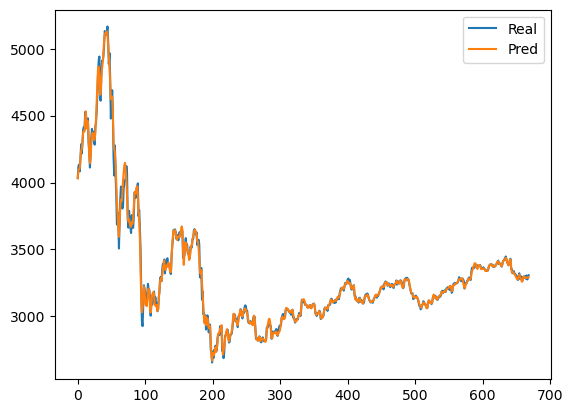

In [ ]:
y_pred = 0
y_true = 0
for i in range(9):
    loaded = torch.load(f"./attn_{i}.pth")
    print("#"*10 , f" Model {i} Acc {loaded['acc']} ", "#"*10)
    test_ds = CSVDataset(imfs_test[i])
    model = attn_models[i]

    model.load_state_dict(loaded["model"])
    model.eval()
    with torch.inference_mode():
        y_pred += model(test_ds.x.to(device))
        y_true += test_ds.y

y_test_signal=min_max_scaler.inverse_transform(y_true.numpy().reshape(-1,1))
y_pred_signal=min_max_scaler.inverse_transform(y_pred.detach().cpu().numpy().reshape(-1,1))
plt.plot(y_test_signal, label="Real")
plt.plot(y_pred_signal, label="Pred")
plt.legend()
attn_mae = mean_absolute_error(y_test_signal, y_pred_signal)
attn_mape = mean_absolute_percentage_error(y_test_signal, y_pred_signal)
attn_rmse = np.sqrt(mean_squared_error(y_test_signal, y_pred_signal))
attn_r2 = r2_score(y_test_signal, y_pred_signal)

print(f"ATTN MAE : {attn_mae}")
print(f"ATTN MAPE : {attn_mape}")
print(f"ATTN RMSE : {attn_rmse}")
print(f"ATTN R2 : {attn_r2}")

In [ ]:
from sklearn.linear_model import LinearRegression
from mlxtend.plotting import plot_linear_regression


In [ ]:
linear_reg = LinearRegression()
linear_reg.fit(y_pred_signal, y_test_signal)

LinearRegression()

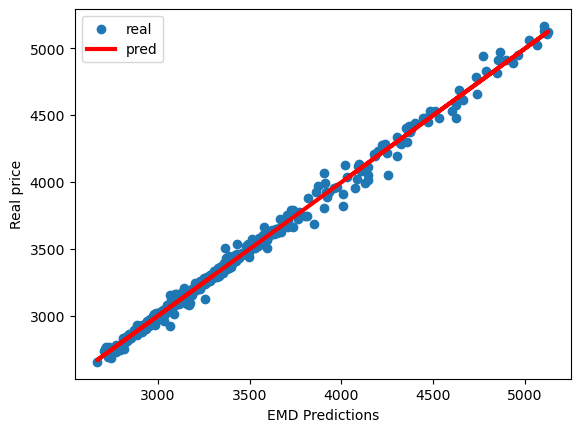

In [ ]:
plt.scatter(y_pred_signal, y_test_signal, label="real")
plt.plot(y_pred_signal, linear_reg.predict(y_pred_signal), color="red", linewidth=3, label="pred")
plt.xlabel("EMD Predictions")
plt.ylabel("Real price")
plt.legend()

In [ ]:
linear_reg.coef_

array([[0.99747145]], dtype=float32)

In [ ]:
linear_reg.intercept_

array([8.596924], dtype=float32)

In [ ]:
mean_absolute_error(y_test_signal, linear_reg.predict(y_pred_signal))